# Inequality and Polarization: An Agent-Based Modeling Approach Using Eurostat Data

by:
- Kevin Heinrich, 11902941
- Matthias Hemmer, 11804194
- Marina Hofer, 12337819
- Christina Sophie Knes, 11902902

## Project Description

This project explores the relationship between regional income inequality and social polarization in Europe using agent-based modeling. Drawing on real-world data from Eurostat, including the Gini coefficient, at-risk-of-poverty rates and disposable income across NUTS-2 regions, we simulate how economic disparities might influence public opinion dynamics and social fragmentation.

We implement a modified Deffuant model, where agents interact and adjust their opinions based on income differences and local economic context. The model integrates heterogeneity in income, frustration levels, and opinion tolerance, creating a dynamic system that allows us to observe under which conditions polarization emerges.

Our main objectives are:
- To simulate opinion formation in a socioeconomically stratified population.
- To explore how varying levels of inequality and redistribution affect polarization.
- To identify regional vulnerability to polarization based on Eurostat indicators.

Through these simulations, we aim to provide insights into how economic structures may contribute to societal tensions, and how policy interventions might influence collective outcomes.

## Environment Setup

For the following project, **Python Version 3.13.5** was used. The recommended way would be to use a virtual environment when executing the cells in the jupyter notebook. To create a virtual environment, enter the following command:

- `python -m venv .venv`

Afterwards, you can select the python version of the virtual environment for the jupyter kernel.

The following libraries are required for this project:

### Agent-Based Modeling
- **`mesa`** –  A Python framework for building and analyzing agent-based models. Provides components for model structure, agents, data collection, and visualization.

### Data Access and APIs
- **`eurostat`** –  A Python interface to retrieve and process data from the Eurostat database, useful for accessing European statistics.

### Data Manipulation and Analysis
- **`numpy`** –  Fundamental package for numerical computations with support for multi-dimensional arrays and matrices.
- **`pandas`** –  Data manipulation and analysis library providing data structures like Series and DataFrame for handling structured data.

### Data Manipulation and Analysis
- **`matplotlib`** –  2D plotting library used to create static, interactive, and animated visualizations in Python.
- **`seaborn`** –  High-level interface for drawing attractive and informative statistical graphics built on top of matplotlib.

### Standard Library Modules
- **`pathlib`** – Object-oriented interface for working with filesystem paths, included in the Python standard library.


## PIP installations

To install the required libraries, run the following:

In [18]:
#! pip install eurostat
#! pip install numpy
#! pip install pandas
#! pip install mesa
#! pip install scipy
#! pip install matplotlib
#! pip install seaborn
#! pip install geopandas

## Import modules and define constants

For the structure of this project, we put every import and every constant in one cell each.

In [19]:
import eurostat
from mesa import Model, Agent, DataCollector
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import geopandas as gpd

In [20]:
# Preprocessing constants
TARGET_AGE = "TOTAL"
TARGET_SEX = "T" # Total
TARGET_MEAN_INCOME_UNIT = "EUR" # Unit of measure for income: Euro
TARGET_MEAN_INCOME_INDIC = "MEI_E" # Income and living conditions indicator: Mean equivalised net income
TARGET_POVERTY_UNIT = "PC"
TARGET_POVERTY_INDIC = "LI_R_M60"
TARGET_HOUSING_INCOME_GROUP = "TOTAL"
TARGET_HOUSING_TYPE = "TOTAL"
TARGET_UNEMPLOYMENT_AGES = "Y15-74"
TARGET_UNEMPLOYMENT_UNIT = "PC_POP"

# Simulation constants
NUM_STEPS = 100
NUM_AGENTS_PER_REGION = 20
SEED = 15
SHIFT_RATE = 0.2
NOISE_STD = 0.05

## Set Seed for "random" calls

The following cell sets the seed for our "random" calls to allow the reproduction of the experiments.

In [21]:
np.random.seed(SEED)

## Define and create "results" directory

The next cell creates the "result" directory (only if it is not created so far) to store our result plots.

In [22]:
result_dir = Path.cwd().joinpath("results")
result_dir.mkdir(parents=True, exist_ok=True)

## 1. Read Eurostat data

### 1.1 Read data from API

Firstly, we download the necessary datasets via the `eurostat` API. In total, we use 5 datasets:

- **Mean and median income by age and sex** (code: ilc_di03)
- **Gini coefficient of equivalised disposable income by age** (code: ilc_di12)
- **At-risk-of-poverty rate by poverty threshold, age and sex** (code: ilc_li02)
- **Share of housing costs in disposable household income, by type of household and income group** (code: ilc_mded01)
- **Unemployment by sex and age - annual data** (code: une_rt_a)

In [6]:
df_orig_mean_median_income = eurostat.get_data_df("ilc_di03")
df_orig_gini_coefficient = eurostat.get_data_df("ilc_di12")
df_orig_at_risk_of_poverty = eurostat.get_data_df("ilc_li02")
df_orig_household_cost_shares = eurostat.get_data_df("ilc_mded01")
df_orig_unemployment_rate = eurostat.get_data_df("une_rt_a")

<Axes: title={'center': 'Mean Income vs Gini Coefficient'}, xlabel='mean_income', ylabel='2024_x'>

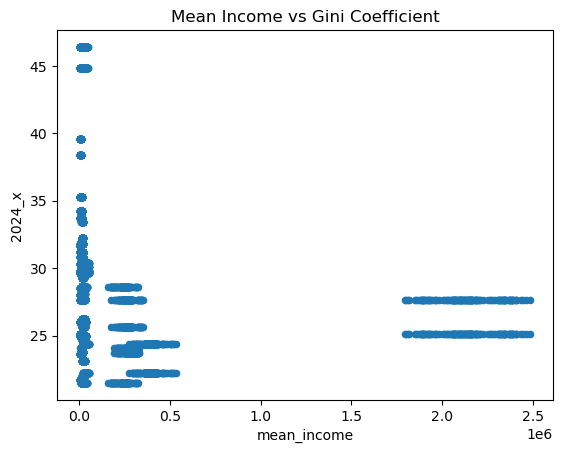

In [31]:
df_join = df_orig_gini_coefficient.merge(
    df_orig_mean_median_income,
    on="geo\\TIME_PERIOD"
)
income_cols = [col for col in df_join.columns if col.endswith('_y') and col[:4].isdigit()]
df_join["mean_income"] = df_join[income_cols].mean(axis=1)
df_join.plot.scatter(x="mean_income", y="2024_x", title="Mean Income vs Gini Coefficient")

In [38]:
df_orig_mean_median_income.head()
df_orig_gini_coefficient.head()
df_orig_at_risk_of_poverty.head()
df_orig_household_cost_shares.head()
df_orig_unemployment_rate.head()

,freq,age,unit,sex,geo\TIME_PERIOD,2003,2004,2005,2006,2007,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,A,Y15-24,PC_ACT,F,AT,NaN,NaN,NaN,NaN,NaN,...,10.4,10.7,9.1,9.8,8.1,10.6,11.3,9.5,10.7,10.1
1,A,Y15-24,PC_ACT,F,BA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44.5,42.1,33.2,35.6
2,A,Y15-24,PC_ACT,F,BE,NaN,NaN,NaN,NaN,NaN,...,20.5,18.3,18.2,15.3,12.3,15.6,16.2,14.4,14.4,14.8
3,A,Y15-24,PC_ACT,F,BG,NaN,NaN,NaN,NaN,NaN,...,26.7,21.1,16.3,15.7,11.8,17.7,15.1,10.4,11.1,11.7
4,A,Y15-24,PC_ACT,F,CH,NaN,NaN,NaN,NaN,NaN,...,8.4,8.4,8.0,7.5,7.2,8.0,8.3,6.8,7.6,8.5


In [63]:
def melt_eurostat_df(df):
    year_cols = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    id_vars = [col for col in df.columns if col not in year_cols]
    df_long = df.melt(id_vars=id_vars, var_name="year", value_name="value")
    df_long = df_long[df_long["year"].apply(lambda x: str(x).isdigit())]
    df_long["year"] = df_long["year"].astype(int)
    for col in id_vars:
        if "geo" in col.lower():
            df_long.rename(columns={col: "geo"}, inplace=True)
    
    return df_long

df_income_long = melt_eurostat_df(df_orig_mean_median_income)
df_gini_long = melt_eurostat_df(df_orig_gini_coefficient)
df_poverty_long = melt_eurostat_df(df_orig_at_risk_of_poverty)
df_costs_long = melt_eurostat_df(df_orig_household_cost_shares)
df_unemp_long = melt_eurostat_df(df_orig_unemployment_rate)

In [67]:
print(df_income_long.columns)

Index(['freq', 'age', 'sex', 'indic_il', 'unit', 'geo', 'year', 'value'], dtype='object')


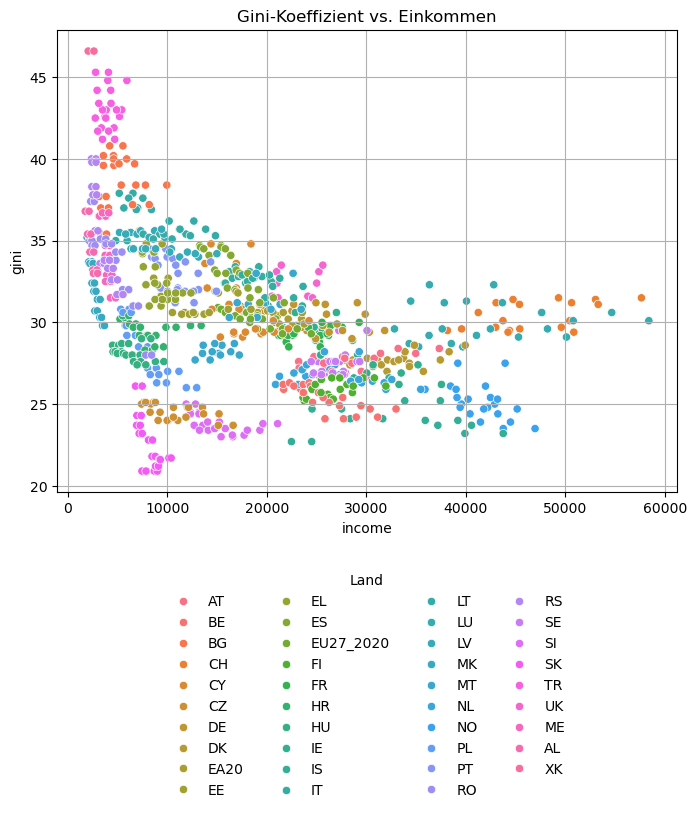

In [82]:
income = df_income_long.query("age == 'TOTAL' and sex == 'T' and unit == 'EUR'").rename(columns={"value": "income"})
gini = df_gini_long.query("age == 'TOTAL'").rename(columns={"value": "gini"})

df_plot = income.merge(gini, on=["geo", "year"], how="inner").dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="income", y="gini", hue="geo")
plt.title("Gini-Koeffizient vs. Einkommen")

plt.legend(
    title="Land",        
    loc="upper center",  
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,              
    frameon=False        
)

plt.grid(True)
plt.show()

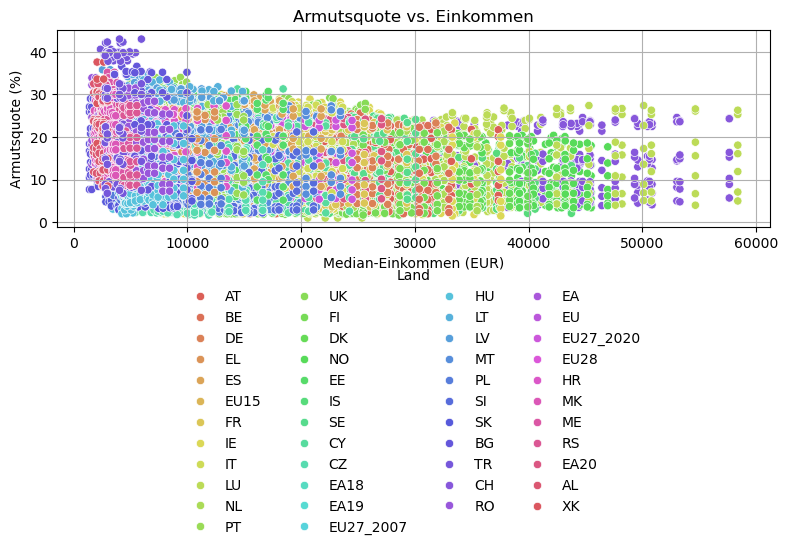

In [76]:
income = df_income_long.query("age == 'TOTAL' and sex == 'T' and unit == 'EUR'").rename(columns={"value": "income"})
poverty = df_poverty_long.query("age == 'TOTAL' and sex == 'T' and unit == 'PC'").rename(columns={"value": "poverty_rate"})

df_plot = income.merge(poverty, on=["geo", "year"], how="inner").dropna()

unique_countries = df_plot["geo"].unique()
num_countries = len(unique_countries)

palette = sns.color_palette("hls", n_colors=num_countries)

plt.figure(figsize=(8, 6))
plot = sns.scatterplot(data=df_plot, x="income", y="poverty_rate", hue="geo", palette=palette)

plt.title("Armutsquote vs. Einkommen")
plt.xlabel("Median-Einkommen (EUR)")
plt.ylabel("Armutsquote (%)")
plt.grid(True)

plt.legend(
    title="Land",        
    loc="upper center",  
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,              
    frameon=False        
)

plt.tight_layout()
plt.show()

In [81]:
print(df_year) indic_il

        freq unit   indic_il sex    age geo  year  value
1669124    A   PC   LI_R_M40   T  TOTAL  AL  2023    NaN
1669125    A   PC   LI_R_M40   T  TOTAL  AT  2023    6.5
1669126    A   PC   LI_R_M40   T  TOTAL  BE  2023    2.9
1669127    A   PC   LI_R_M40   T  TOTAL  BG  2023   12.4
1669128    A   PC   LI_R_M40   T  TOTAL  CH  2023    8.9
...      ...  ...        ...  ..    ...  ..   ...    ...
1695071    A   PC  LI_R_MD70   T  TOTAL  SI  2023   20.3
1695072    A   PC  LI_R_MD70   T  TOTAL  SK  2023   20.1
1695073    A   PC  LI_R_MD70   T  TOTAL  TR  2023   29.1
1695074    A   PC  LI_R_MD70   T  TOTAL  UK  2023    NaN
1695075    A   PC  LI_R_MD70   T  TOTAL  XK  2023    NaN

[330 rows x 8 columns]


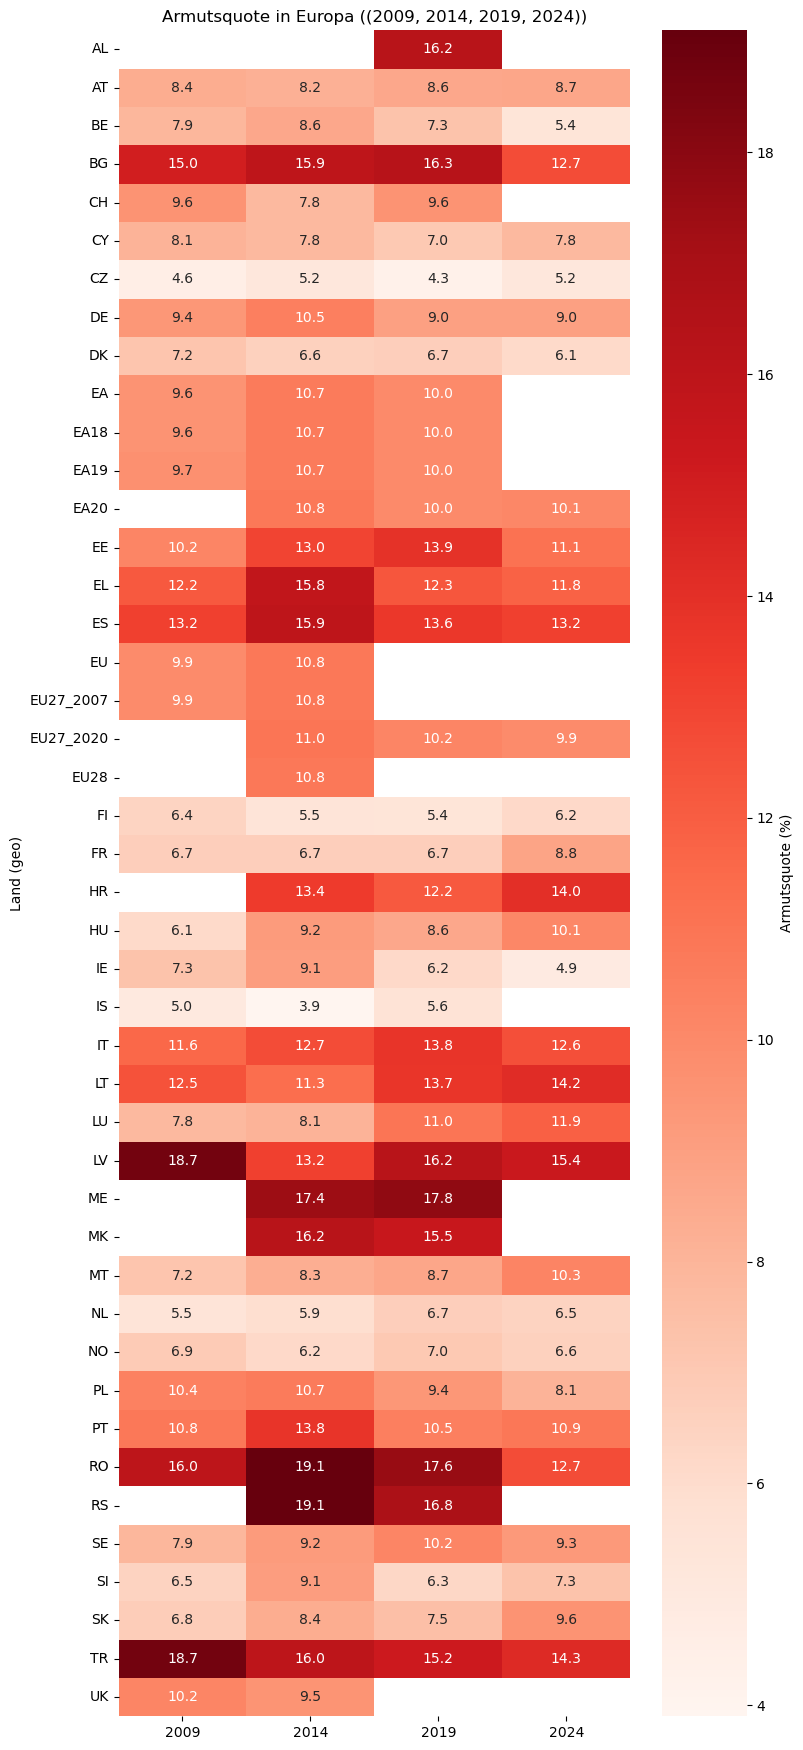

In [97]:
selected_year = 2009, 2014, 2019, 2024
df_poverty_filtered = df_poverty_long.copy()
if "age" in df_poverty_filtered.columns:
    df_poverty_filtered = df_poverty_filtered[df_poverty_filtered["age"] == "TOTAL"]
    df_poverty_filtered = df_poverty_filtered[df_poverty_filtered["sex"] == "T"]
    df_poverty_filtered = df_poverty_filtered[df_poverty_filtered["unit"] == "PC"]
    df_poverty_filtered = df_poverty_filtered[df_poverty_filtered["indic_il"] == "LI_R_MD50"]

df_year = df_poverty_filtered[df_poverty_filtered["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="value")
heatmap_data = heatmap_data.dropna(how="all")


plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds", cbar_kws={"label": "Armutsquote (%)"})

plt.title(f"Armutsquote in Europa ({selected_year})")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()
plt.show()


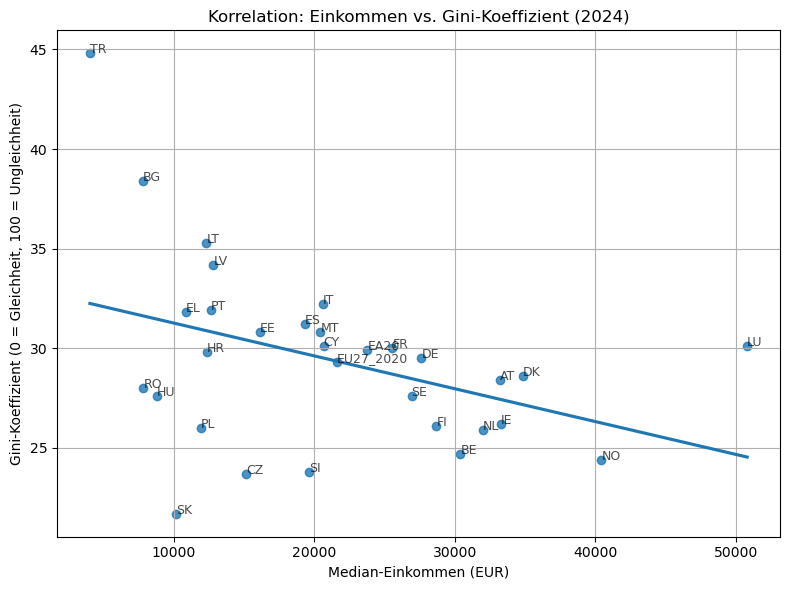

In [100]:
selected_year = 2024

income = df_income_long.copy()
income = income[
    (income["age"] == "TOTAL") &
    (income["sex"] == "T") &
    (income["unit"] == "EUR") &
    (income["indic_il"] == "MED_E") &
    (income["year"] == selected_year)
].rename(columns={"value": "income"})

# Filter Gini
gini = df_gini_long.copy()
gini = gini[
    (gini["age"] == "TOTAL") &
    #(gini["unit"] == "PC") &
    #(gini["indic_il"] == "GINI") &
    (gini["year"] == selected_year)
].rename(columns={"value": "gini"})

df_plot = income.merge(gini, on=["geo", "year"], how="inner").dropna()

plt.figure(figsize=(8, 6))
sns.regplot(data=df_plot, x="income", y="gini", ci=None)
for i, row in df_plot.iterrows():
    plt.text(row["income"], row["gini"], row["geo"], fontsize=9, alpha=0.7)

plt.title(f"Korrelation: Einkommen vs. Gini-Koeffizient ({selected_year})")
plt.xlabel("Median-Einkommen (EUR)")
plt.ylabel("Gini-Koeffizient (0 = Gleichheit, 100 = Ungleichheit)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:

import geopandas as gpd
import geodatasets
from iso3166 import countries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests, zipfile, io, os



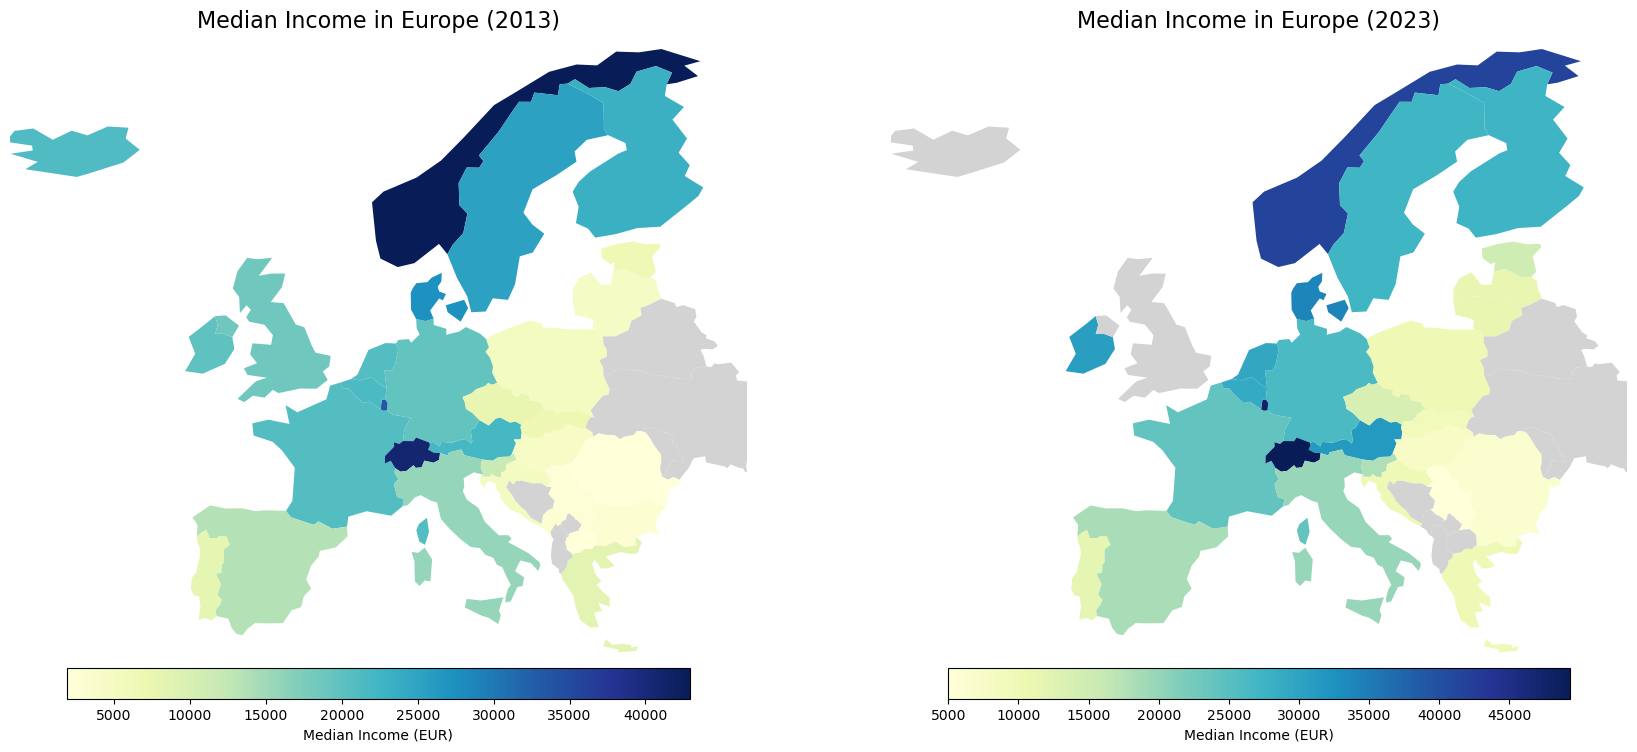

In [155]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
extract_dir = "ne_admin_0"

if not os.path.exists(extract_dir):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)

world = gpd.read_file(f"{extract_dir}/ne_110m_admin_0_countries.shp")

alpha2_to_alpha3 = {
    "AL": "ALB", "AT": "AUT", "BE": "BEL", "BG": "BGR", "CH": "CHE", "CY": "CYP",
    "CZ": "CZE", "DE": "DEU", "DK": "DNK", "EE": "EST", "EL": "GRC", "ES": "ESP",
    "FI": "FIN", "FR": "FRA", "HR": "HRV", "HU": "HUN", "IE": "IRL", "IS": "ISL",
    "IT": "ITA", "LT": "LTU", "LU": "LUX", "LV": "LVA", "MT": "MLT", "NL": "NLD",
    "NO": "NOR", "PL": "POL", "PT": "PRT", "RO": "ROU", "SE": "SWE", "SI": "SVN",
    "SK": "SVK", "TR": "TUR", "UK": "GBR", "RS": "SRB", "ME": "MNE", "MK": "MKD"
}

europe = world[
    (world["CONTINENT"] == "Europe") &
    (world["NAME"] != "Russia")
]

# Filter Eurostat data
def get_income_data_for_year(year):
    df = df_income_long.copy()
    df = df[
        (df["age"] == "TOTAL") &
        (df["sex"] == "T") &
        (df["unit"] == "EUR") &
        (df["indic_il"] == "MED_E") &
        (df["year"] == year)
    ]
    df["iso_a3"] = df["geo"].map(alpha2_to_alpha3)
    return df

df_income_1 = get_income_data_for_year(2013)
df_income_2 = get_income_data_for_year(2023)

# Merge with geo data
map_1 = europe.merge(df_income_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_income_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2013, 2023]):
    map_df.plot(
        column="value",
        ax=ax,
        cmap="YlGnBu",
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Median Income (EUR)",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Median Income in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.show()

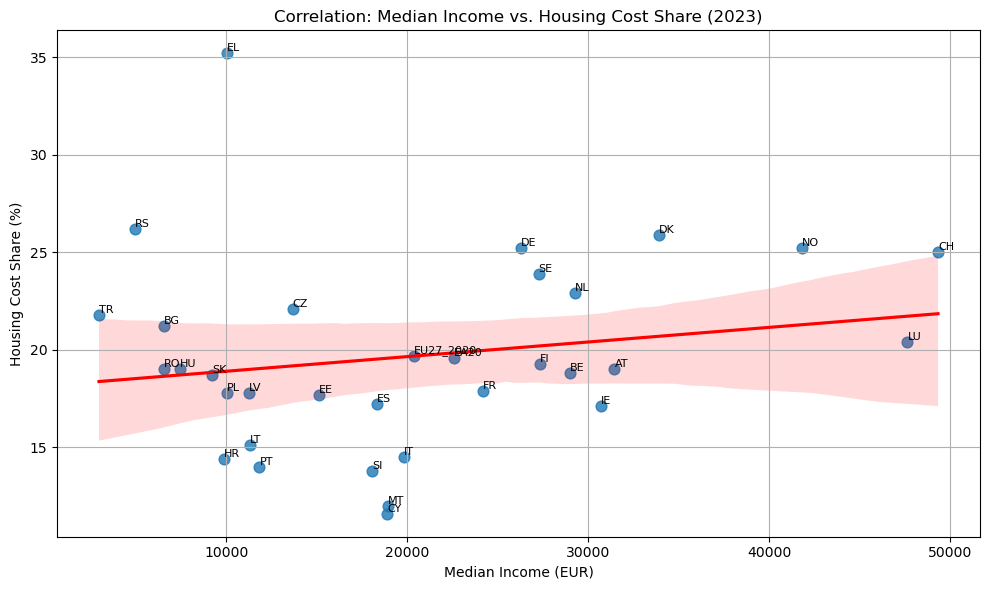

In [158]:
year = 2023
income_2023 = df_income_long[
    (df_income_long["year"] == year) &
    (df_income_long["age"] == "TOTAL") &
    (df_income_long["sex"] == "T") &
    (df_income_long["unit"] == "EUR") &
    (df_income_long["indic_il"] == "MED_E")
][["geo", "value"]].rename(columns={"value": "income"})

costs_2023 = df_costs_long[
    (df_costs_long["year"] == year) &
    (df_costs_long["unit"] == "PC") &
    (df_costs_long["hhtyp"] == "TOTAL") &
    (df_costs_long["incgrp"] == "TOTAL")
][["geo", "value"]].rename(columns={"value": "cost_share"})

df_corr = income_2023.merge(costs_2023, on="geo").dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=df_corr, x="income", y="cost_share", scatter_kws={"s": 60}, line_kws={"color": "red"})

for i, row in df_corr.iterrows():
    plt.text(row["income"], row["cost_share"], row["geo"], fontsize=8, ha="left", va="bottom")

plt.title(f"Correlation: Median Income vs. Housing Cost Share ({year})")
plt.xlabel("Median Income (EUR)")
plt.ylabel("Housing Cost Share (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Poverty Rate Over Time'}, xlabel='Step', ylabel='Poverty Rate'>

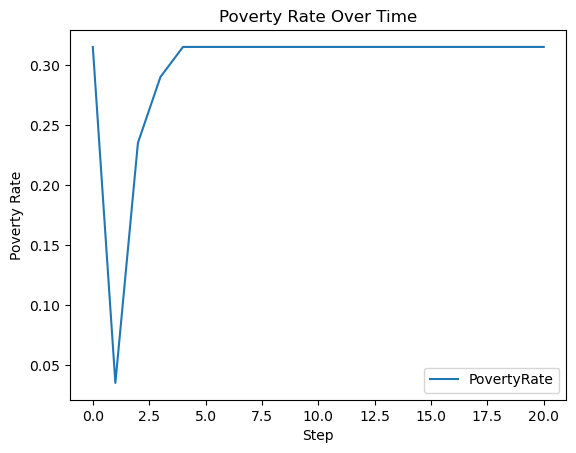

In [165]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
import numpy as np
import pandas as pd

class Person(Agent):
    def __init__(self, model, income):
        super().__init__(model)
        self.income = income
        self.has_credit = False
        self.repaid = False

    def step(self):
        poverty_line = self.model.poverty_line
        if self.income < poverty_line and not self.has_credit:
            # Apply for microcredit
            self.income += self.model.microcredit_amount
            self.has_credit = True

        elif self.has_credit and not self.repaid:
            # Repay microcredit with probability
            if np.random.random() < self.model.repayment_prob:
                self.income -= self.model.microcredit_amount
                self.repaid = True

class MicrocreditModel(Model):
    def __init__(self, N=100, poverty_line=1000, microcredit_amount=500, repayment_prob=0.8):
        super().__init__()
        self.num_agents = N
        self.poverty_line = poverty_line
        self.microcredit_amount = microcredit_amount
        self.repayment_prob = repayment_prob

        #self.agents = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"PovertyRate": self.compute_poverty_rate},
            agent_reporters={"Income": "income", "HasCredit": "has_credit"}
        )

        for i in range(self.num_agents):
            income = np.random.normal(1200, 400)
            agent = Person(self, max(income, 0))
            #self.agents.add(agent)

        self.datacollector.collect(self)

    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

    def compute_poverty_rate(self):
        poor = [a for a in self.agents if a.income < self.poverty_line]
        return len(poor) / self.num_agents

# Run simulation
model = MicrocreditModel(N=200)
for _ in range(20):
    model.step()

# Convert results
model_df = model.datacollector.get_model_vars_dataframe()
model_df.plot(title="Poverty Rate Over Time", ylabel="Poverty Rate", xlabel="Step")


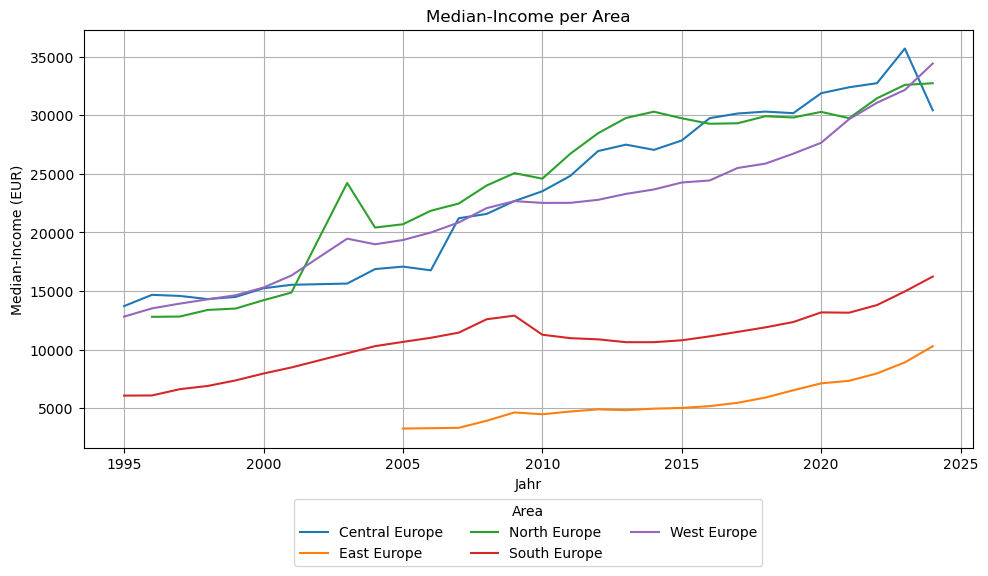

In [103]:
region_map = {
    "AT": "Central Europe", "DE": "Central Europe", "CH": "Central Europe",
    "SE": "North Europe", "FI": "North Europe", "DK": "North Europe", "NO": "North Europe",
    "IT": "South Europe", "ES": "South Europe", "PT": "South Europe", "GR": "South Europe", "HR": "South Europe",
    "PL": "East Europe", "CZ": "East Europe", "HU": "East Europe", "SK": "East Europe", "RO": "East Europe", "BG": "East Europe",
    "FR": "West Europe", "BE": "West Europe", "NL": "West Europe", "IE": "West Europe", "LU": "West Europe"
}

df_income_filtered = df_income_long.copy()
df_income_filtered = df_income_filtered[
    (df_income_filtered["age"] == "TOTAL") &
    (df_income_filtered["sex"] == "T") &
    (df_income_filtered["unit"] == "EUR") &
    (df_income_filtered["indic_il"] == "MED_E")
]

df_income_filtered["region"] = df_income_filtered["geo"].map(region_map)
df_income_filtered = df_income_filtered.dropna(subset=["region", "value"])

df_grouped = df_income_filtered.groupby(["region", "year"])["value"].mean().reset_index()

plt.figure(figsize=(10, 6))
for region in df_grouped["region"].unique():
    df_line = df_grouped[df_grouped["region"] == region]
    plt.plot(df_line["year"], df_line["value"], label=region)

plt.title("Median-Income per Area")
plt.ylabel("Median-Income (EUR)")
plt.xlabel("Jahr")
plt.legend(title="Area", loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame({
    "geo": ["AT", "DE", "IT", "ES", "SE"],
    "median_income": [23000, 25000, 20000, 18000, 28000]
})

# ISO2 → ISO3 Mapping
iso_map = {
    "AT": "AUT",
    "DE": "DEU",
    "IT": "ITA",
    "ES": "ESP",
    "SE": "SWE"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyMAAAd2CAYAAAAe33KSAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3gU1dfA8e/uphfSSCN0CL136R2UIk2KolLkVSmCoFKlCQRQikiTDgpI70gRkCrSe+iEkkZIIY2U3Z33j0hwTQF+JjtJPJ/nyaNz596bM0l22DO3rEZRFAUhhBBCCCGEMDOt2gEIIYQQQggh/pskGRFCCCGEEEKoQpIRIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGREij5szZw4ajYYKFSqoHUqm1qxZw+zZs9UO47UFBQUxfvx4Lly4kOV9azQaxo8fn2X9jR8/Ho1Gk+FXQEBAln2vnCo5OZkyZcowderU1LKDBw/Sp08fypQpg729PT4+Prz99tucPXs23T7OnTtH8+bNcXBwwNnZmU6dOnH37l2TOjdv3uSLL76gevXqODs74+rqSr169di4cWOa/n777TdatGhBgQIFsLa2xsPDg6ZNm7J79+40sZcoUSJXvk6EECIjkowIkcctW7YMgKtXr/Lnn3+qHE3GcnMyMmHChGxJRv744w8++uijLO93z549/PHHH2m+vL29s/x75TTz588nMjKSQYMGpZYtWLCAgIAABg8ezO7du/n+++95/PgxderU4eDBgybtr1+/TuPGjUlKSmL9+vUsW7aMmzdv0qBBA8LCwlLr7du3j127dtG5c2c2bNjA6tWr8fX15Z133mHixIkmfYaHh1O+fHlmzZrFvn37+PHHH7G0tKRNmzb8/PPPqfUsLS0ZO3YsEydOJDw8PJt+QkIIYWaKECLPOn36tAIobdq0UQClX79+r9ROr9crCQkJ2RydqTZt2ihFihQx6/fMCs9/xsuXL1c7lJcaN26cAihhYWHZ+n3i4uKytf//VXJysuLj46OMGDHCpDw0NDRN3ZiYGMXT01Np1qyZSfk777yj5M+fX3n69GlqWUBAgGJpaal89dVXqWVhYWGK0WhM02+bNm0UOzu7l76+kpKSFB8fH6VBgwYm5YmJiYqrq6syefLkTNsLIURuISMjQuRhS5cuBWDq1KnUrVuXX375hfj4eJM6AQEBaDQapk+fzqRJkyhWrBjW1tYcOnQodVrPpUuXeOedd3BycsLV1ZWhQ4ei1+u5ceMGrVu3xtHRkaJFizJ9+nSTvlesWJHu9J/ff/8djUbD77//DkDjxo3ZtWsX9+/fN5k29NyCBQuoXLkyDg4OODo6UqZMGUaNGmXS58mTJ6lXrx42NjYUKFCAkSNHsnjx4jTfP6OpT0WLFqVXr14mZVeuXOHtt9/GxcUFGxsbqlSpwsqVK02uo2bNmgD07t07Ne6/93/mzBnat2+Pq6srNjY2VK1alfXr16f5/un5Z1/Pf56HDh3i008/JX/+/Li5udGpUyeCgoJeqc9X8c/fz3PP/1ZWrFiRWtarVy8cHBy4fPkyLVu2xNHRkWbNmgEQERFB//798fHxwcrKiuLFizN69GgSExPTXOfAgQP58ccfKVWqFNbW1pQrV45ffvnFpF5YWBj9+/enXLlyODg4pE5nOnr06Ctd1/bt2wkMDOT99983Kffw8EhT18HBgXLlyvHw4cPUMr1ez86dO+ncuTP58uVLLS9SpAhNmjRhy5YtqWX58+c3+Rt+rlatWsTHxxMREZFprJaWljg7O2NhYWFSbmVlRbdu3Vi0aBGKomR+wUIIkQtIMiJEHvXs2TPWrl1LzZo1qVChAn369CEmJoYNGzakW3/OnDkcPHiQ7777jl9//ZUyZcqknuvatSuVK1dm06ZN9OvXj1mzZvH555/ToUMH2rRpw5YtW2jatCnDhw9n8+bNrx3r/PnzqVevHl5eXibThgB++eUX+vfvT6NGjdiyZQtbt27l888/Jy4uLrX9tWvXaNasGVFRUaxYsYKFCxdy/vx5Jk2a9NqxPHfjxg3q1q3L1atXmTNnDps3b6ZcuXL06tUrNemqVq0ay5cvB2DMmDGpcT+fWnXo0CHq1atHVFQUCxcuZNu2bVSpUoVu3bqZvKF/XR999BGWlpasWbOG6dOn8/vvv9OzZ89Xbm8wGNDr9SZfBoPhf44nKSmJ9u3b07RpU7Zt28aECRNISEigSZMmrFq1iqFDh7Jr1y569uzJ9OnT6dSpU5o+tm/fzpw5c5g4cSIbN26kSJEi9OjRw2SNxfM38OPGjWPXrl0sX76c4sWL07hx4zSJU3p27dqFh4cH5cqVe2ndp0+fcu7cOcqXL59adufOHZ49e0alSpXS1K9UqRK3b98mISEh034PHTqEu7t7ugmQ0WhEr9cTFBTEuHHjuHnzJsOGDUtTr3Hjxty/f58rV6689DqEECLHU3toRgiRPVatWqUAysKFCxVFSZl24uDgkGbax7179xRAKVGihJKUlGRy7vm0nhkzZpiUV6lSRQGUzZs3p5YlJycr7u7uSqdOnVLLli9frgDKvXv3TNofOnRIAZRDhw6llmU0TWvgwIGKs7NzptfarVs3xdbWVgkJCUkt0+v1SpkyZdJ8f0AZN25cmj6KFCmifPjhh6nH3bt3V6ytrZUHDx6Y1HvzzTcVOzs7JSoqSlGUzKdplSlTRqlataqSnJxsUt62bVvF29tbMRgMmV7XP2N9/vPs37+/Sb3p06crgBIcHJxpf89/n+l9lShRIrVeer8fRXnxt/L3a/3www8VQFm2bJlJ3YULFyqAsn79epPyadOmKYCyb98+k+vM6PdXsmTJDK9Hr9crycnJSrNmzZSOHTtmeu2Koihly5ZVWrdu/dJ6iqIo7733nmJhYaGcOXMmtez48eMKoKxduzZN/SlTpiiAEhQUlGGfixcvVgDl+++/T/d8q1atUn8f+fLlM3l9/d2tW7cUQFmwYMErXYsQQuRkMjIiRB61dOlSbG1t6d69O5Ay7eSdd97h6NGj3Lp1K0399u3bY2lpmW5fbdu2NTkuW7YsGo2GN998M7XMwsKCkiVLcv/+/Sy8ipRpLVFRUfTo0YNt27bx5MmTNHUOHTpEs2bN8PT0TC3T6XR069btf/6+Bw8epFmzZhQqVMikvFevXsTHx6eO3GTk9u3bXL9+nffeew/AZBTirbfeIjg4mBs3bvxPsbVv397k+PmT+lf92f/222+cPn3a5Gvr1q3/UyzPde7c2eT44MGD2Nvb06VLF5Py51PhDhw4YFKe0e/v9u3bPHr0KLV84cKFVKtWDRsbGywsLLC0tOTAgQP4+/u/NMagoKB0RyT+6euvv2b16tXMmjWL6tWrpzmf3vSrl5379ddfGTBgAF26dDFZPP93P/zwA6dOnWLbtm20atWKbt26sXbt2jT1nl9DYGDgS69FCCFyOklGhMiDbt++zZEjR2jTpg2KohAVFUVUVFTqG8PnO2z9XWY7Kbm6upocW1lZYWdnh42NTZryl01TeV3vv/8+y5Yt4/79+3Tu3BkPDw9q167N/v37U+uEh4fj5eWVpm16Za8qPDw83Z9JgQIFUs9nJjQ0FIAvvvgCS0tLk6/+/fsDpJtYvQo3NzeTY2trayBlat6rqFy5MjVq1DD5+jdbP9vZ2ZmsoYAXv5N/vjn38PDAwsIizc8vs9/f87ozZ87k008/pXbt2mzatImTJ09y+vRpWrdu/UrX/uzZszR/s/80YcIEJk2axOTJkxk4cKDJuec/9/R+9xEREWg0GpydndOc27t3L506daJFixasXr06w4TF19eXmjVr0r59e9avX0+zZs0YMGAARqPRpN7za3jV37cQQuRkFi+vIoTIbZYtW4aiKGzcuDHdzzVYuXIlkyZNQqfTpZZl9rT3f/X8TdM/Fyy/7pvw3r1707t3b+Li4jhy5Ajjxo2jbdu23Lx5kyJFiuDm5kZISEiadumVWVtbp4kH0r7BdHNzIzg4OE295wvF8+fPn2nMz8+PHDky3TUSAKVLl860D7W87u8tvb8dNzc3/vzzTxRFMTn/+PFj9Hp9mp9fZr+/50nAzz//TOPGjVmwYIFJvZiYmJddEpDyO8ls4fiECRMYP34848ePT7NBAkCJEiWwtbXl8uXLac5dvnyZkiVLpkl29u7dS4cOHWjUqBGbNm3CysrqlWKFlFHBPXv2EBYWZjJq9PwaXvY3KIQQuYGMjAiRxxgMBlauXEmJEiU4dOhQmq9hw4YRHBzMr7/+mu2xFC1aFIBLly6ZlG/fvj1NXWtr65c+6bW3t+fNN99k9OjRJCUlcfXqVQCaNGnCgQMHUkcjIOXnsG7dunRj+mc8Bw8eJDY21qSsWbNmHDx4MM0uVatWrcLOzo46deqkxg1pn1KXLl0aX19fLl68mGYU4vmXo6Njpterltf5vWWkWbNmxMbGppn+tWrVqtTzf5fR769EiRIULFgQSEl6nv+8n7t06dJLp8w9V6ZMGe7cuZPuuW+++Ybx48czZswYxo0bl24dCwsL2rVrx+bNm00SoAcPHnDo0KE0See+ffvo0KED9evXZ+vWrWliz4yiKBw+fBhnZ+c0I2HPP2DxVRbiCyFETicjI0LkMb/++itBQUFMmzaNxo0bpzlfoUIF5s6dy9KlS9OsBclqNWvWpHTp0nzxxRfo9XpcXFzYsmULx44dS1O3YsWKbN68mQULFlC9enW0Wi01atSgX79+2NraUq9ePby9vQkJCcHPzw8nJ6fUbXXHjBnD9u3badq0KWPHjsXOzo558+aZ7Lj13Pvvv8/XX3/N2LFjadSoEdeuXWPu3Lk4OTmZ1Bs3bhw7d+6kSZMmjB07FldXV1avXs2uXbuYPn16av3nT8tXr15N2bJlcXBwoECBAhQoUIAff/yRN998k1atWtGrVy98fHyIiIjA39+fc+fOZbizWXY7e/ZsmuuFlDe3+fLlw8vLi+bNm+Pn54eLiwtFihThwIEDr7VT2gcffMC8efP48MMPCQgIoGLFihw7dowpU6bw1ltv0bx5c5P6+fPnp2nTpnz99dfY29szf/58rl+/brK9b9u2bfnmm28YN24cjRo14saNG0ycOJFixYqh1+tfGlPjxo2ZOHEi8fHx2NnZpZbPmDGDsWPH0rp1a9q0acPJkydN2j1PPCFl9KRmzZq0bduWESNGkJCQwNixY8mfP7/JzlfHjh2jQ4cOeHl5MWrUqDQfivn8Zw3w9ttvU7lyZapUqYKbmxtBQUGsWLGCw4cPM2/evDTb+548eRKdTkfDhg1fes1CCJHjqbt+XgiR1Tp06KBYWVkpjx8/zrBO9+7dFQsLCyUkJCR1h6Rvv/02Tb2MPiTvww8/VOzt7dPUb9SokVK+fHmTsps3byotW7ZU8uXLp7i7uyuDBg1Sdu3alWa3poiICKVLly6Ks7OzotFolOe3p5UrVypNmjRRPD09FSsrK6VAgQJK165dlUuXLpl8n+PHjyt16tRRrK2tFS8vL+XLL79UFi1alGY3rcTEROWrr75SChUqpNja2iqNGjVSLly4kGY3LUVRlMuXLyvt2rVTnJycFCsrK6Vy5crp7pq1du1apUyZMoqlpWWaHbAuXryodO3aVfHw8FAsLS0VLy8vpWnTpqm7nGXmn309303r9OnTJvUy2v3qnzLbTQtQ9u/fn1o3ODhY6dKli+Lq6qo4OTkpPXv2VM6cOZPublrp/S0oiqKEh4crn3zyieLt7a1YWFgoRYoUUUaOHJnmA/8AZcCAAcr8+fOVEiVKKJaWlkqZMmWU1atXm9RLTExUvvjiC8XHx0exsbFRqlWrpmzdulX58MMPX+kDM2/fvq1oNJo0O3w1atQo05/LP505c0Zp1qyZYmdnp+TLl0/p0KGDcvv27df6Wf/9dzVt2jSlZs2aiouLi6LT6RQ3NzelVatWys6dO9O9jgYNGijt2rV76fUKIURuoFEU+dQkIUTetGLFCnr37s29e/dSpx6JnEej0TBgwADmzp2b7d+rXbt26PV6s0xTzA537tzB19eXvXv30qJFC7XDEUKIf03WjAghhPjP8PPzS93aODeaNGkSzZo1k0RECJFnSDIihBDiP6NChQosX7483d27cjq9Xk+JEiWYN2+e2qEIIUSWkWlaQgghhBBCCFXIyIgQQgghhBBCFZKMCCGEEEIIIVQhyYgQQgghhBBCFZKMCCGEEEIIIVQhn8AuhBBCCCFe2yeafGqHkOctVKLVDiHbyciIEEIIIYQQQhWSjAghhBBCCCFUIcmIEEIIIYQQQhWSjAghhBBCCCFUIcmIEEIIIYQQQhWSjAghhBBCCCFUIVv7CiGEEEKI1yZPtEVWkL8jIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGVHRiRMn0Ol0tG7d2qQ8ICAAjUbDhQsX1AlMCCGEEEIIM5CtfVW0bNkyBg0axJIlS3jw4AGFCxdWOyQhhBBCiFei1WjUDkHkATIyopK4uDjWr1/Pp59+Stu2bVmxYoXaIQkhhBBCCGFWkoyoZN26dZQuXZrSpUvTs2dPli9fjqIoaoclhBBCCCGE2UgyopKlS5fSs2dPAFq3bk1sbCwHDhxQOSohhBBCCCHMR5IRFdy4cYNTp07RvXt3ACwsLOjWrRvLli37n/tMTEwkOjra5CsxMTGrQhZCCCGEECLLSTKigqVLl6LX6/Hx8cHCwgILCwsWLFjA5s2biYyM/J/69PPzw8nJyeTLz88viyMXQgghhBAi62gUWahgVnq9noIFC/LVV1/RsmVLk3OdO3dm0KBBtG3blmLFinH+/HmqVKnySv0mJiamGQmxtrbG2to6q0IXQgghhEg1UOukdgh53lzjU7VDyHayta+Z7dy5k8jISPr27YuTk+mLuEuXLixdupS2bdsCKdO5/qlcuXJYWVmlKZfEQwghhBDmJNNrRFaQkREza9euHUajkV27dqU5d+7cOapXr87Zs2epXr16uu3v3btH0aJFszlKIYQQQojMfSYjI9luzn9gZESSESGEEEII8dokGcl+/4VkREbYhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihCtnaVwghhBBCvDatRu0IRF4gIyNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFbO0rhBBCCCFemzzRFllB/o6EEEIIIYQQqpCRkTxMeXhN7RByNOOt82qHkKMph/aoHUKOpxswTu0QcjTl8UO1Q8jxlMsn1Q4hR1NOnlA7hBzN4ocdaocgxL8mIyNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFLGAXQgghhBCvTavRqB2CyANkZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQrX2FEEIIIcRrkyfaIitIMqKiEydO0KBBA1q0aMGePXvo1asXK1euzLSNoihmiu71hD4J57vFqzhy6hyJSUkULViAScMGUqFUiXTr/3nhCh9+8XWa8t3LfqB44YLZHW62OnPrPsv2n+Dqg2DCnsYy5+OuNK9SJvX8/vP+rD96lqsPgomKe8amUf9H2UJemfb54cyVnL51P015wwolWTjg3Sy/hmxXpDTa+m3QFCiKJp8LhjWzUfzPvjhvnw9ty+5oSlYAGzuU+zcw7lwFEaEZdqnrMwpNsbJpyo03LmD8eUZ2XIXZ/LB8NfNWrDEpy+/qzLEtq9Otf/bSVb77cTl3HzwiISGRAl4edGvXml5dO5ojXFXEPUvg+1+289upC0Q8jaFssUKM6t2ViiWLZtjm1NWbTFu5kduPgvBwcabv2y3p3rKh+YLORmfuh7DsxBWuBocTFvuMOV2b0LxMkXTrjtt5gg3nbjKiZU0+qFM+wz6TDUYWH7vEtkt3CI2Oo1h+J4Y2q06Dkrnvnq1p0QVt5brg6QPJSSj3rmPctgIeB76oU/kNNPVaoylUEo1DPvRTP4PAey/vu3F7tPXfBBd3iItGuXAC4/aVoE/OvgsSIheTZERFy5YtY9CgQSxZsoQHDx7w/fffM3Xq1NTz3t7eLF++nNatW6sY5cs9jYmlx+CR1K5SkcV+X+Pq7MzDoBDyOdi9tO2vK+biYPeinqtTvuwM1SziE5Mo7eNJxzeqMHjRhjTnnyUlU7VEIVpVK8fY1Ttfqc/vP+5Kst6QehwVF0+nyT/Sqlq5LIvbnDRW1hDyAOP5I+h6DE5zXvfuEDAaMKyZBYnP0NZ9E13vERjmjIDkxHT7NKz9HnR/u6XZOaDrPxnl6qlsugrz8i1WhGUzJqUe63S6DOva2tjwXse2lC5RDFsbG85dvsq4GXOxtbGhW/s3zRGu2Y1Z8BO3HgYxbVBvPFyc2HH0T/pMnM3OWePwdHNJU/9R6BM+8ZtLl2b1mf5Zb87duMM3i9fims+BlnWqqXAFWSs+SU9pT1c6VvFl8IZDGdb77fp9LgWG4eH48vv1nEPn2HH5LhPa1qV4fieO3wnks/WHWN37Lcp5u2Vl+NlOU7ICxqO7UO7fAp0WbdsP0A2YiGFyf0j66x5jZYNy1x/l/HF07w56tX5rNELb/kOMq+eg3PNH4+GDtudgtIBx85LsuyAhcjFJRlQSFxfH+vXrOX36NCEhIaxYsYKxY8fi5ORkUs/Z2Rkvr8yfmqttyS+b8XbPj9+XL27WBb08Xqmtm7Mz+Rzssys0VTSs4EvDCr4Znm9fuxIAgeFRr9yns72tyfGvZ65gY2WZa5MR5dYllFuX0j/p5oWmsC/6H0akPqU07liBbsQ8NJXqoJw9nH67Z3Emh5qKdVKeeF7JG8mITqfF3c31leqWK1WCcn8blSzo7cn+Iyc4e+lqnkxGEhKT2P/neeZ+9Sk1y6W89gZ2bceBUxdZu+8IQ3q8nabNL/uP4J3flVG9uwJQoqA3V+/cZ9n2/XkiGWnoW5CGvpmPWIRGxzH51z9Z9F4LPl3720v73H7pDh83qESjv/rtXqMMx+4EsuLkVaZ3zF0jSsYF402PV8/Gwm81FCoJd64CoJz+K4lzfbV/zwA0xcqkJDB/3aeUiMcoZ4+gKVIqS+IWIi+S6X4qWbduHaVLl6Z06dL07NmT5cuX59gpWC9z8I/TVChVksETp1O3y4d0/Hgo63fte6W2HT8ZSoOufej15VhOXriczZHmHZtOXOCtGhWws7ZSO5SsZ/HXM5Lkv01pUBQwGNAULv3K3WirN0K5fDLDkZTc5v6jIBp0ep9m3fowdMI0HgYFv3LbazfvcP6qPzWrVMzGCNVjMBoxGI1YW1malFtbWXLu+u1021y4eZd6lUyn9dWrXI6rd++bjELmVUZFYcTWo/SpWwFfj7QjR+lJMhixtjAdkbOxsODcg4ynT+YaNn89FIuP+VfdKHeuoSlUAor89UDKzRNNuRoYr575lwEKkXfJyIhKli5dSs+ePQFo3bo1sbGxHDhwgObNm6sc2et7GBzK2h176NWlPR/36MKlG7eYPG8pVpaWdGjZJN027m4uTPz8U8qXKkFScjLb9x+m95fjWDXjG2pWynjOsoBLAYHcCnrMN++3UzuU7BEWjBIZhrZlV4zblkFyIpq6b6JxdEZxdHp5ewCf4mg8C2HYkjemRVQuW5qpo4ZRtKAP4ZGRLPhpHT0GfMGOFQtwyWRqY6MuHxAR9RSDwcjAXu/yTttWZozafOxtbahSqjgLNu6ihI8Xbk752HX8NJduB1Akg1HaJ1HRuDmb/uzyO+dDbzASGROLh8sr/q3lUkuOX0an1dKzVtp1VhmpX6IAK05eo3phLwq7OnLybjAHbzzAkEsfpP2dtlNflDtXIfjBv+pHOXcUo4MTuiHTQKNBo7PAeHQ3yv6NWRSpEHmPJCMquHHjBqdOnWLz5s0AWFhY0K1bN5YtW/Y/JyOJiYkkJpo+AbZKTMLaDE/OFUWhfKkSDO2bklyV8y3O7YCHrN2xJ8NkpHghH4oX8kk9rlquDMFhT1i2YZskIy+x6fh5fAt4UKmoz8sr50ZGA4Zf5qDr8BEWo39EMRhQ7l7FePPiK3ehrd4IJfQhBN7NxkDNp2GdGn87KkqV8mVp+W5ftu45QO9uGS9KX/3DdOLiE7h47TozFq2gsI83bZs3zvZ41TBtUG9Gz19Fo49HoNNqKVesEG3r1+Ta3YzfXGo0GpPj56PTmvQq5yFXg57w05/X2PR/7dP8DDIzslVtxu48Ttv5W9AAhVwd6VjFly0XbmVfsGagfecTNAWKYpg9/F/3pSlZAW2rrhjXL0QJuIHG3Rtt5/9D0yoCZe+6LIhWiLxHkhEVLF26FL1ej4/PizeTiqJgaWlJZGQkLi6vNmT+d35+fkyYMMGkbOyQ/owfOuBfx/sy7q4ulCxSyKSsROGC7Dv6x2v1U6VsKbYfyGA9gABSFr//euYqg9o1VjuU7BUUgGH+GLC2TVmUHh+D7v/GowS9fCcbLK3QVKyD8cCm7I9TJXa2NpQqVpT7j4IyrVfQO2W9WekSRQmPjGLuijV5Nhkp7OXOTxOHEZ+QSOyzBDxcnPh85mJ8PPKnWz+/cz6eRD41KQt/GoOFTouzo4M5QlbN2QehRMQl0Gz2iw02DIrC9P1nWPXnNX4b/E667VztbZjbrRmJej1R8Yl4ONox88BZfFwczRV6ltN2+T80FWth+H4kRIX/+/7a9kQ5dQjlj5SpykrwfYxWNmh7DMSwb33KlNM8RJvXM3dhFpKMmJler2fVqlXMmDGDli1bmpzr3Lkzq1evZuDAga/d78iRIxk6dKhJmdVj8zwVrlq+DPceBpqUBTwKooCn+2v1c+32PdxdXz8R+y/Zc/YqSXo97Wrlzbn/aSQ+S/mvqyf4FEM58PKpDpoKtUFngXLxRDYHp56kpGTuPHhI9dcYRVQUhaTkvL+1qJ2NNXY21jyNjeP4xWt80bNTuvWqlCrO72dMN1E4ftGf8sWLYGmR8U5leUH7SiV4o3gBk7J+q/fTvmJxOlbJePON56wtLPDMZ0Gywcg+//u0Llc0myLNXtp3PkZT6Q0Mc0ZCeBate7G0BsVoWpZ6rAHyVjIiRFaQZMTMdu7cSWRkJH379k2zc1aXLl1YunTp/5SMWFtbY21tbVKmPDXP4uZendvRY/BIFq7ZyJuN6nHp+i3W797HxM8/Ta0zY8lPPH4SwbQRKdu4rty0Ax8vD0oWKUSyXs/23w6z7+gfzBn3lVlizk5xCUk8CItIPQ4Mj8L/YQhO9rYUcHUiKu4ZwRFPefw0ZaFkQGjK07j8+Rxwd0p5IjtixVY8nB0Z2qGZSd+bjp+nWeUyOL/Ctsk5mpV1SoLxnLM7eBVO2RHraTia8rVS9ud/Go7GsxDat3qi+J9FuXMltYm288cQHYlx/3qTrrXVGqFcPwfPYs11Ndlu2vwlNKlbmwKe7oRHRrFg1Tpi4+Lp0DplWueMRSt4HBbOtNHDAFi9ZSfeHu4UL5Ky69HZS9dYtm4zPTvl0XVGwLELV1EUKFbAk/shj/nup80UK+BJxyZ1AZi5eguhEVFMG9QbgO4tGrJmz+9MXbGBd5rX58LNu2w+eJzvhvRV8zKyTFxSMg8iolOPA6Ni8Q8Jx8nWmgJODjjb2ZjUt9BqyO9gS7H8L/5dGrH1KB6OdgxtVh2Ai4/CeBwTTxkvV0Kj45l3+AKKotC3XgXzXFQW0nb9FE31hhgWT4aEZ+DonHIiIR6Sk1L+384BXNzROKXsYqfx9ElJJaIjISYqpZ/3P4eocIw7VgGgXDmFpkkHNI/uoty/iSa/N9o276Xs6vfPJEUIAUgyYnZLly6lefPmaRIRSBkZmTJlCufOnaNatdyztWTFMr78MGE4M5f8zPyf1lPQ24ORn/ahXbNGqXXCIiIJehyWepys1zP9xxWEPonAxtqKkkUK8ePkMTSqXV2NS8hSVx8E0WvWqtTjaRtThus71KnMlA/f5tClG4xetT31/LClKdOJ+rdpyMC2jQEIjniK9h9zuQNCwzl35yFLPnsvm68g+2kKFEPXd3Tqse6tlGsynjuKccsicHRG++a7YO8EsVEoF45h/H2raR9ObijGfzxldPNCU7Q0xhXTsvsSzCo0LJxhE6cT9TQaF2cnKpcrzboFM/H5a3F2WHiEyevLaDQya/FKHgWHoNPpKFzAm2H/1ytPbuv7XEz8M2at2UpIeBRODna0rF2VIT06pI5yhEU+JfjJi4cEBT3zs3DkQKau3MCavYfxcHFiVJ9ueWJbX0hZF9Jr1d7U42n7TgPQoXIJprzd4JX6CH4aazINJ0lv4PtD53gUGYOdlSUNfQsyrWMD8tlYZ9xJDqVt8BYAFoP9TMoNP89G+fMAAJqKtdH1HJJ6Ttc7ZU2JcfcajL+uTanj4m6yE6Zx7zo0KGjb9gQnN4iNRrlyCuPOn7LzcoTI1TRKbt1PVryU8vCa2iHkaMZb59UOIUdTDu1RO4QcTzdgnNoh5GjK44dqh5DjKZdPqh1CjqaczLvTLbOCxQ87VP3+IyydVf3+/wVTk6PUDiHbyeeMCCGEEEIIIVQhyYgQQgghhBBCFbJmRAghhBBCvDZ5oi2ygvwdCSGEEEIIIVQhyYgQQgghhBBCFZKMCCGEEEIIIVQhyYgQQgghhBBCFZKMCCGEEEIIIVQhyYgQQgghhBBCFbK1rxBCCCGEeG0ajUbtEEQeICMjQgghhBBCCFVIMiKEEEIIIYRQhSQjQgghhBBCCFVIMiKEEEIIIYRQhSxgz8M0Tu5qh5CjaQuXUTuEHM3ocU7tEHI8jWN+tUMQuZySP0DtEHI047MktUMQQmQzGRkRQgghhBBCqEJGRoQQQgghxGuTJ9oiK8jfkRBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCFb+wohhBBCiNem1agdgcgLZGRECCGEEEIIoQpJRoQQQgghhBCqkGlaZtarVy9WrlyZeuzq6krNmjWZPn06lSpVAkCjSX/cc+3atXTv3t0scb6OH5f/xL5Dh7l7/z421tZUrVSRLwZ+SvGihTNtt3r9Jn7esJnA4GC8PT35tM8HdGjzppmiNp+mvT8j6PGTNOXvtmnB2P6905T/eekaH46clKZ898JvKV7IJ1tiNLczgeEsO3+Hq4+fEhafyJy3atC8uFfq+XJzd6bbbljdsvStViLdc7fCY5j75w2uhj0lKOYZI+qX44MqxbMlfnP7cdkK9h38nbsBf73GKlfki88GUrxokUzbnTp7jqkzZnPr7j083PPz0Yfv06NLJzNFbT4/LF/NvBVrTMryuzpzbMvqdOufvXSV735czt0Hj0hISKSAlwfd2rWmV9eO5gjXLM7cfsCyA39y9WEoYdGxzPmoE80rlQIg2WBgzs4jHLl2l0fhUTjYWPNG6SIMbd8YDyfHDPvcf/EGi/b9wYMnkegNRgq7u9C7SS3a16pgrsvKMto3u6GtVg+NdyFISkK5cw39xqUQ+iilgk6HrkMvNBVronH3hmdxGK+dx7BpKTyNyLBfiy+noy1dOU258dKf6OeMza7LESJXk2REBa1bt2b58uUAhISEMGbMGNq2bcuDBw9S6yxfvpzWrVubtHN2djZnmK/s1LnzvPdOJyqWK4PBYGDWgsX0HfQ5u9b/jJ2tbbpt1mzcwoz5PzJp1HAqlivDpWv+jJk8jXyOjjRtWN/MV5C9Ns6ehMFgTD2+df8hfcb40ap+7Uzb/bpoBg5/+/m5OuXLthjNLV5voHT+fHQsW4jBv55Nc/5w7+Ymx0fvh/H1wYu0LOGVpu5zCXoDBZ3saFXSm6nHrmV5zGo6dfY873XtQsXy5TAY9Myau5C+/T9j16ZfMnyNPQwM4v8Gfc47Hd/m20kTOHfxEhP8puPq4kyrZk3NfAXZz7dYEZbNeJHE63S6DOva2tjwXse2lC5RDFsbG85dvsq4GXOxtbGhW/u88UAkPimZ0j6edKxTicFLt5icS0hK5tqjUD5pVZcyPh5Exyfgt/kAAxZtYsOXvTLs08nOho9bvkExTzcsdToOX73N6DW7cHW0o37Z3JX4a0tXwnhoB0rATdDq0HXsheXQKSR/3Q+SEsHKGk2Rkhh3rsH48C4aewd03T7BYtAE9JMGZdivfv43oHvx1krjkA+LcQswnjlqjssSIleSZEQF1tbWeHmlvKny8vJi+PDhNGzYkLCwMNzd3YGUxON5nZxu6Q8zTY79xo7kjZbtuOp/g5rVqqTbZvvuvXTr+DZvtWwGQKGCPly4fJXFq1bnuWTkn0nE4o3bKeztSa2KZTNt5+aUj3wO9tkZmmoaFvGgYRGPDM+729uYHB+8F0Ktgm4Ucsr451HR05mKns4AzPzjepbEmVMsnfe9ybHfhK95o1lrrl67Ts3qVdNt88vGzXh7eTH6y6EAlChejMvX/Fm2anWeTEZ0Oi3ubq6vVLdcqRKUK/VihK2gtyf7j5zg7KWreSYZaViuBA3LpT+K6Ghrw9IBpqPso7u0oNuMlQRFPKWAq1O67Wr5mo7Evd+4JltPXeHc3Ue5LhnRzx5terx8Blaz16Mp4oty6wo8i0c/c2TqeQUwrJ2P5ZgfwNUdIsLS7zguxuRQU6sxJCVgPHMki69AiLxD1oyoLDY2ltWrV1OyZEnc3NzUDidLxMTGAeCUL+Mn+UnJSVhbWZmU2Vhbc/mqP8l6fbbGp6akZD3bDx2jU4tGGU7He67jZ6No0LM/vUZN5uTFq2aKMOd5Ep/IkfuP6Vw282l//yUxMbEAOGUyWnbh0mXqvVHLpKzBG3W44u9PcnLee43dfxREg07v06xbH4ZOmMbDoOBXbnvt5h3OX/WnZpWK2RhhzhaTkIhGA/lsbV5eGVAUhT9uBBDwOIIaJQplc3RmYPfXg45/JBMmbO1RjEaIj3vlbrX1W2E8dThltEUIkS4ZGVHBzp07cXBwACAuLg5vb2927tyJVvsiN+zRo0eaaQaXLl2iePGc/fRJURT8Zv1A9SqVKFUy41jr16nNxm07ad64AeXLlOaK/w027dhFsl5PZFQUHvnzmzFq8zlw8gwxsfF0bN4owzrurs5MHPQR5UsWIyk5me0Hj9F79BRWTR1DzQqZj6bkRduuP8TO0oIWmUzR+i9RFAW/md9TvUplSpVM/8k3wJPwcPK7mj7gcHNzRa83pLzG3PPOa6xy2dJMHTWMogV9CI+MZMFP6+gx4At2rFiASyYJW6MuHxAR9RSDwcjAXu/yTttWZow650hM1jNr+++0qV4eB1vrTOvGPEug8dfzSNYb0Go1fP1OS+qWKWamSLOPRdf/w3jzCkrQ/QwqWKLr3AfjqUOQEP9KfWqKlUZbsBjJK2dlYaQ5izzRFllBkhEVNGnShAULFgAQERHB/PnzefPNNzl16hRFiqQMg8+aNYvmzU3nzRcqlPHTp8TERBITTZ+8WCcmYm2d+T8sWW3i9JncvH2HNYvnZ1qvf99ehIWH0633xyiAm6sLHdu+yZJVa9BpM57rndtt3HeIBjUq4+nmkmGd4gULULxggdTjqmVLEfwknGWbdv0nk5HN1x7StpQP1hZ59+/idUyc+i03b91mzbIfX1r3n4NviqL8VZ63PhygYZ0afzsqSpXyZWn5bl+27jlA724ZL0pf/cN04uITuHjtOjMWraCwjzdtmzfO9nhzkmSDgWErtmFUFMa+0/Kl9e2trdk8vA/xiUmcvBnA9K0HKZTfOc0UrtxE9+4ANAWLkTxtWAYVdFh8PAo0Ggw/z33lfrX1W2F8dA/l3o0silSIvEmSWhXY29tTsmRJSpYsSa1atVi6dClxcXEsXrw4tY6Xl1dqnedflpaWGfbp5+eHk5OTyZffzO8zrJ8dvvl2FgePHGflgjl4eWa8HgDAxsYav7GjuHDsAAe3beD3HZvw8fbG3t4OF+f05yvndoGPw/jjwhXeadnktdtWKe3L/aCQbIgqZzsTFM69qDi6lJcpWgDfTPuOg0eOsnLRfLw8PTOtm9/NjbDwcJOyiIhILCx0ODvlzdfYc3a2NpQqVpT7j4IyrVfQ24vSJYrStV1rer3Tgbn/2JErr0s2GBi6fCuB4VEsHdD9paMiAFqthiLuLpQt6EnvprVpWbk0i/efNEO02UPXoz/aKm+Q/N1XEJl218OURGQ05PdKWUPyiqMiWFmjrdkY49E9WRuwEHmQjIzkABqNBq1Wy7Nnz/7nPkaOHMnQoUNNyqwTo/9taK9EURS++XYW+38/wk8Lf6CQT4GXN/qLpYVFauKye98BmtSvazJdLS/ZvP8wbk5ONKqV/oLjzFy7G4C7q3PWB5XDbb72kPLuTpTJn3d2EvtfKIrCN9O+Y/+hw/y0eP4rvcaqVKrIoSOmO/gcO/knFcqWxdIyb9/6k5KSufPgIdUrlX/lNoqikJScnI1R5SzPE5H7YZGsGPguzvbp78r2MgqQlEvX+eneHYC2al2Sv/0SnoSmU+GvRMTTB/23X2W+nuQftDUagqUlxpMHsjBiIfKmvP0vUg6VmJhISEjKU+7IyEjmzp1LbGws7dq1S60TFRWVWuc5R0dH7O3T303I2to67ZSsaPMsmJswbQY79/7G/O/8sLezI+xJytNYRwcHbGxSYpoxdyGhYWFMn/A1APfuP+DSVX8qVyhHdEwMy1ev49bdu0wdPzrD75ObGY1Gtuw/QodmDbD4x1qgGSt+4XF4BNOG9Qdg5dZf8fHMT8nCBUnWG9h+6Bj7jp9izqghKkSePeKS9Dx4+mIRaGB0PP5hT3GysaKAY8qbotikZPbeDubL+uXS7WPE/vN42NswtG7K1LUkg5E7ESlvFpINRkLjEvAPe4qdpQVFnHP3rmQTpn7Lzl/3Mn/Wt9jb2f/tNWaPjU3KguMZP8wj9HEY078ZD0D3Lp1YvW4DfjNm07Xj25y/dJlNW7czw+8btS4j20ybv4QmdWtTwNOd8MgoFqxaR2xcPB1ap0x1nbFoBY/Dwpk2OmUazuotO/H2cKd4kYIAnL10jWXrNtOzU7sMv0duE5eYxIOwyNTjwPAo/B+F4mRng4eTI0OWbsH/USjzP+6CQTESFv3Xpgh2tlj9NSVyxE878HByZGj7xgAs2vcHFQp7USi/C8kGA0eu3mH7qSuM7Zr71tro3huItnYT9HPHQ8IzyPfX1NlncZCcBFotFp98jaZIyZTPB9FqX9SJiwFDSgKm6/MlRD3BsHm5Sf/a+q0xnj/xWgmMEP9VkoyoYM+ePXh7ewMpCUaZMmXYsGEDjRs3Tq3Tu3faD8Pz8/NjxIgR5grzla3dtBWA9z8x3Xvdb+woOrV7C4CwJ+EEh7x48mQ0Glm++hfu3X+AhYUFtWtUY+2ShRQs4G22uM3pxIUrBIU9oVPLxmnOhUVEERT2YjpNsl7P9KVrCA2PwMbKipJFCvLj+C9pVPP1R1RyqquPo+i19cXUjml/fS5IhzIFmdK8CgC7bwahoNDGN/1RgOCYZ2j/tvYhLC6BzutejAQsP3+X5efvUrOAKys71c2GqzCftRs2AfB+v09Nyv3Gf02n9m2BtK+xQj4FWPTDLPxmzGb1+o14uOdn9FfD8uS2vqFh4QybOJ2op9G4ODtRuVxp1i2YiY9XyqhrWHgEQY9fbMVqNBqZtXglj4JD0Ol0FC7gzbD/65VntvUFuPogmF4/rE09nrblIAAdalVgwJv1OXTlNgCdppm+iV4xqEfq+o/gyGiT19izpGQmbthHaFQM1pYWFPdwY9oH7XizWu5by6ZrkpJ4Wn71nUm5ftl3GE/sBxd3tFXfSKkzfoFJneRvv0S5cQkAjZs7imI0OY+nD9pSFUj+29bAQoiMaZTnKxpF3hOdwT7oAgDl8YOXV/oPM/7635o//7/Q9fla7RByNCUmnTn4woTxonwYXmYMG35RO4QczWrJXlW//wTrjDdjEVljXGLkyytlwM/Pj1GjRjF48GBmz54NpExJnTBhAosWLSIyMpLatWszb948ypd/9WmtWU1GRoQQQgghxGvT5rGd+fKS06dPs2jRIipVqmRSPn36dGbOnMmKFSsoVaoUkyZNokWLFty4cQNHR0dVYs2bK4WFEEIIIYT4D4qNjeW9995j8eLFuLi8GL1SFIXZs2czevRoOnXqRIUKFVi5ciXx8fGsWaPebAhJRoQQQgghhMgjBgwYQJs2bdJ8Xt29e/cICQmhZcsXnylkbW1No0aNOHHihLnDTCXTtIQQQgghhMiB0v1Q6/R2UP3LL7/8wrlz5zh9+nSac893afX8x+dUeXp6cv/+/SyK+PXJyIgQQgghhBA5ULofau3nl27dhw8fMnjwYH7++efUbd/To/nHWh9FUdKUmZOMjAghhBBCCJEDpfuh1hmMipw9e5bHjx9TvXr11DKDwcCRI0eYO3cuN27cAFJGSJ5/xATA48eP04yWmJMkI0IIIYQQQuRAmU3J+qdmzZpx+fJlk7LevXtTpkwZhg8fTvHixfHy8mL//v1UrZry2WVJSUkcPnyYadOmZXnsr0qSESGEEEII8dpkrn/O4ujoSIUKFUzK7O3tcXNzSy0fMmQIU6ZMwdfXF19fX6ZMmYKdnR3vvvuuGiEDkowIIYQQQgjxn/DVV1/x7Nkz+vfvn/qhh/v27VPtM0ZAkhEhhBBCCCHypN9//93kWKPRMH78eMaPH69KPOmRETYhhBBCCCGEKiQZEUIIIYQQQqhCkhEhhBBCCCGEKiQZEUIIIYQQQqhCFrDnYYYT29UOIUczbFindgg52smd19QOIcdr8KZ6WyHmBsbbF9QOIcdTDu1TO4QcLfDkPbVDyNGKqfz9tep9aLfIQ2RkRAghhBBCCKEKSUaEEEIIIYQQqpBkRAghhBBCCKEKSUaEEEIIIYQQqpBkRAghhBBCCKEKSUaEEEIIIYQQqpCtfYUQQgghxGuTJ9oiK8jfkRBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCEL2M2kV69erFy5MvXY1dWVmjVrMn36dCpVqgSAoigsWbKEZcuWcfXqVYxGI0WKFKF58+YMGjSIkiVLqhW+iTO3H7Ls4CmuPgwhLDqOOX070rySLwDJBgNzdh3lyLW7PAp/ioONFW+ULsrQdg3xcHJ8pf53n/Pni5U7aFqxJHM/6pSdl5IttG91R1utHhrvQpCUhHLnGvoNSyD0UUoFnQ5dx15oKtZC4+4Nz+IwXjuHYdNSiIrIuGOdDu1b3dHVbQEu+VFCHmLYuBTlyhnzXFgW8f7wfbx7fYBNoYIAxN+4yf0Zs4k8eAiAIl8Mxb1De6x9CmBMSiL20mUC/KYTc+58hn16dnuH0nNmpSk/WrgESmJi9lyIGTXt/RlBj5+kKX+3TQvG9u+dbpuk5GTmrdnMjkPHCYuMwiu/K59060Dnlo2zOdrsJ/egzGkad0BboRZ4FIDkJJT7NzHuXg1Pgk3qaZt3QVO7Gdg6wINbGLYte3GfyoiNHdpW3dFUqAW29hAZhnHnKpQbF7LterKD00cfY9+8JZbFiqEkJJJw4TyRs74lOeBeah2tmxuun3+Jbd16aB3zkXD2NOFTvkH/4P4rfQ/7N9vg8e0s4g78xuPB/bPrUoTI9SQZMaPWrVuzfPlyAEJCQhgzZgxt27blwYMHKIrCu+++y9atWxk1ahSzZs3Cw8ODe/fusX//fiZNmsSKFSvUvYC/xCclU9rHg461KzJ42VaTcwlJeq49DOWTVnUpU8Cd6GeJ+G0+wIDFm9nwxYcv7Tsw4infbj1E9RIFsyn67KctVRHjoe0o926CVoeuUy8sh/mRPKYfJCWAlTWawr4Yd6zG+PAuGnsHdN0/xWLQRPTfDMywX13HXmjrNEO/chZK8EO0FWpgMWAcer8hKA/umPEK/53E4GDuTfIj4V7KP/qe3d6h/MqlnGvemvgbN4m/e5fbo8aQcP8BWhsbfD7uR8V1qzldpz7J4Rkna/roaE7XbWRSlhcSEYCNsydhMBhTj2/df0ifMX60ql87wzZD/OYQHvWUSYP7UbiAFxFRT9H/rY/cTO5BmdMUL4vxj70oj+6AVoe2VTd0H43GMGMYJKe8JjSN2qNp0Abj+gUoT4LRNuuUUufbz1PuU+nR6dB9NAYl9imGn2fB03BwdoPEDOrnYDY1ahK99mcSr1xGY2GBy2ef47VoGY/efgvl2TMAPL+fD3o9oZ/1R4mNJd8HvfFessKkTkYsvAvgOmw4CWdOm+NyhMjVJBkxI2tra7y8vADw8vJi+PDhNGzYkLCwMA4cOMAvv/zCtm3baN++fWqb4sWL06xZMxRFUSvsNBqWK07DcsXTPedoa83SAd1MykZ3bk63mT8RFBFNAdd8GfZrMBoZvmonA9+sz9m7j4h+lvv+gQPQzx5terxsBlbfb0BT1Bfl5mV4Fo9+5ojU8wpgWDMPy6/ngqs7RISl26/2jeYYdq5BuZzyj5vx951oK9RA27ILhiXTsu16slrEvt9MjgP8puP94Qfkq16N+Bs3Cdu81eT83bET8H6vB/blyhJ19HjGHSsKyWHp/+xyO1cn09fN4o3bKeztSa2KZdOtf/TMRU5f8Wf/0tk4OzoAUNDTPdvjNBe5B2XOuMzP9HjDAizGLoGCxeGePwDa+m9hPLgF5eqplDrr5qH7ehGaqvVR/vwtTZ8AmhpNwM4e4/yvwWhIKYxKO2KXG4R+8pHJcdiYERQ5+ifW5cqTcPYMFkWKYlOlKo/efovkO7cBCJ80Hvsjf2D/VltiN23IuHOtFvdpM4icPwebajXQOmb8N5fbadGoHYLIA2TNiEpiY2NZvXo1JUuWxM3NjbVr11K6dGmTROTvNJrc+4KPSUhEo4F8dtaZ1pu/5wQuDnZ0fqOSmSIzEzv7lP/GxWRcx9YexWiE+LiM61hYQnKySZGSlIjWt3wWBKkSrRb3Du3R2dkSfeZsmtMaS0u8338P/dOnxF69lmlXOnt7ap05Se3zpyn/8wrsK+Tin0smkpL1bD90jE4tGmV4Xzj451kqlCzG0o07aPjBAFr1G8q0JatJSEwyc7Q5w3/+HmRjl/Lf+NiU/7p6oMnngnLr0os6Bj3K3WtoipTKsBtNuRoo92+h7dAH3Zgf0X3+HZomHSAX//v0nNYhZQqf4elTADRWVkDKPTaV0YiSnIxN1eqZ9uX86UAMkRHEbt6YPcEKkcfIyIgZ7dy5EweHlKeUcXFxeHt7s3PnTrRaLTdv3qR06dIm9YcMGcKSJUsAcHZ25tGjl8zlzYESk/XM2nGYNtXK4WCT8RuBc3cfsfnkJTZ/1ct8wZmJRbePMd68jBIYkEEFS3Rd+mL88xAkxGfYj/HKGbQtO2G8eQnCgtGUrYq2yhugzX3PFOzKlqHqrm1ora0xxMVxtXc/4m/eSj3v2qIZZX+cj9bWlqTQx1zq+i76iMgM+4u/fYcbnw0lzt8fnaMjPv36UmXHVs42bZk6HSyvOHDyDDGx8XRs3ijDOg9DHnP22k2srKyYO/pzIqNjmDB/OU9jY5ky5GMzRqs+uQeBtu0HKPf8IfRhSoGjc8p/Y56aVox9Ci4Zj6BpXD2gRHmUC8cwLJ+KJr832rf7YNTqUA5syp7gzcT1q5EknD1D8u2U+1DyvbskBz7CZfAwwieOxRj/DKcPe2Ph7oHOPeOfkXXVajh27EJgl7fNFboQuV7uexeTizVp0oQLFy5w4cIF/vzzT1q2bMmbb77J/fspi+H++ZRz9OjRXLhwgbFjxxIbG5tp34mJiURHR5t8JSYlZ9omuyUbDAxbuR2jojC2a4sM68UlJDL8p11M6N4aFwc7M0aY/XTvDURTsBj6RX4ZVNBh8clo0Ggw/PxDpn0Z1i6Ax0FYTl6K5Y+7sXhvAMbj+8CY+9YBPLt9h7NNW3H+rfYErfyJ0nNmYVfKN/V81PETnG3aigttOxB56HfKLV6AZX63DPuLOXuOx5s2E3fNn+g/T+Hf7xOe3b2Lz0fpL+7OzTbuO0SDGpXxdHPJsI5RUdBo4LsvB1CpdEka1azKiI96suW3I/+p0RG5B4H27T5ovApjWDsnnbP/mP6r0UBmU4I1GoiLxrhpEQTeQ7l4AuOhLWjrZPyzzQ3cRo/DqlRpHn/1+YtCvZ7Hnw/Csmgxipw4Q9EzF7GpWYv4I4chg7VXGjt73P2+5cn4MRijMn54IoQwJSMjZmRvb2+yI1b16tVxcnJi8eLF+Pr6cv36dZP67u7uuLu74+Hh8dK+/fz8mDBhgknZ1++1Y1xPdZ7OJBsMDF2+ncDwpywf2D3TJ5IPnkQRGPGUAYtfPFkz/vUPYsXPv2XX6I8onD/jN145le7d/mirvEHytGEQmc68ap0Oi0/GQH5P9N9+lemoCACxT9HPHZ8yXcshH0SFo+vSF+VJSLbEn52U5GQSAgIAiL14CccqlfHp15dbX6aspTHGPyMhIICEgABizp6j5h9H8Xq3Ow/nzHvFb6AQc+EitsWKZdMVqCPwcRh/XLjCD6M+z7Seu6sznm6uONq/eGNdopAPiqIQ8iScoj7e2R2q6uQeBNr2vdGUq45h4Xh4+rfNH2KiUv7r6Pzi/wHs86WMjmQkJgrFYDBNWB4HosnnAjodGAxZF7yZuI78GrsmTQn+8D0MoaEm55KuXSWoy9toHBzQWFpijIzEe80Gkq5eSbcvy0KFsSxYCM+5C18U/jVyXfTCNR61a4X+4cNsuxYhcitJRlSk0WjQarU8e/aMHj168O6777Jt2zbefvv1E4iRI0cydOhQkzKL39dkVaiv5fmbgPthkawY1B1ne9tM6xf3dGPbcNMn2N/vPkpcQhKjOjXDyzn3Lf7TvTsAbbV6JE//AtJLFp4nIp4+6Kd/mfl6kn/SJ0NUeMpWv9XqYzxzJOsCV4tGkzpHO6PzWqvM5/v/k0P5csT9I8HP7TbvP4ybkxONalXNtF61sqXYe+xP4p4lYG9rA0BAYDBarQavTEaY8gq5B4H27d5oytfC8OMEiPzHxg4Rj1GiI9H4VkIJCkgp0+nQFC+H8deM/91QAm6gqVLPdAQlvzdKdESuTETcRo3FrlkLgnv3RB+Y8TRoJTYWBbAoXATr8hWImjs73XrJ9+7wqEMbkzKXQZ+jtbcnfOok9MG578GREOYgyYgZJSYmEhKScjOKjIxk7ty5xMbG0q5dOxo1asTmzZvp3r07I0eOpFWrVnh6enL//n3WrVuHTqfLtG9ra2usrU3frBmsLLPlOuISk3gQ9mIIOjA8Cv9HoTjZ2eLh5MCQZdvwfxTK/P/rjMFoJCw6ZYqZk50tVhYp1zHi5114ODkwtF0jrC0t8C1gOgc3319voP5Znhvoeg5CW7sJ+h/GQcIzyPfXE9VncZCcBFotFp9+jaaIL/rvv055cva8TlwMGPQp/fT9EiLDMWxeBoCmWBlwcUN5cAeNS350b78PWi2GX9ercZn/s6KjhhNx4BCJQUHoHBzw6NAe57pvcLl7T7R2thQe8hnhe/eTFBqKpYsL3r0/xNrbi7AdO1P7KP3DbBJDQgiYPBWAwsM+J+bsOZ7du4fOwQGffn2wr1Ce2yPHqHWZWc5oNLJl/xE6NGuAxT/uBzNW/MLj8AimDUv5LIO2jeux4JctjJq1kEE9uxAZHcP0ZWvo3KIxNtaZJH25hNyDMqft0BdNlXoYVn4Lic/AwSnlREJ8ysMMwHhsN9omHTA+CUZ5EoK2SQdITkQ5f+xFP10HQHQExj1rU9qc3I+uXmu07XphPLEHTX6vlD6O7zH3Jf5rbmPGYf9WOx5/9ilKXBw6t/wAGGNjUrcEt2vZGmNkBPrgYKx8S+E6YjTxB3/j2YkXu/rlnzIdw+NQImfPQElKSl1z8pwxJhogTbkQ4gVJRsxoz549eHunTI9wdHSkTJkybNiwgcaNGwOwbt06Fi9ezPLly5k+fTrJyckULFiQZs2aMXPmTBUjN3X1QQi95v6Sejxta8qH1XWoVYEBretx6ErKNoidpq8wabdiYHdq+RYGIDgyGm0e2IElPbom7QCwHD7DpFy/7FuMx/eDizvaqnVT6kxYaFInefoXKDdSdrjRuHqYbulsaYlFx17g7g0JzzBePoV+ybSUJCcXsXJ3p8zc77Hy9EAfE0PcNX8ud+9J1JGjaKytsStZEs+u72Dp6kJyZCQxFy5y4e3OxN+4mdqHtY9Pyu5jf7Fwyofvd9Ow8nBHHxND7OUrXOzQmZjzF1S4wuxx4sIVgsKe0CmdDy0Mi4giKCw89dje1oZlk0YyaeFKugwZg7OjA60b1GHI+13NGHH2kXtQ5rRvtATA4pPxJuWG9fNRzh4GQDm8HcXSCm2HvikfXvjwNoYlU0w+Y0Tj7Iai/G19xNNwDEsmo2v3Iboh01MSleO/ovy+LduvKavl6/4eAN4rVpuUh40eTuy2LQBYuLvj9NVIdG5uGMLCiNm+laiF803qW3h758p1e1lFmzdfQsLMNEpO+gALkaUMe5aqHUKOZtiwTu0QcrSTOzPfSldAg+O5702YORlvX1A7hBxPObRP7RBytIe7zqsdQo5W7MrNl1fKRjPs8v60T7UNiw9/eaVcTnbTEkIIIYQQQqhCkhEhhBBCCCGEKiQZEUIIIYQQQqhCkhEhhBBCCCGEKiQZEUIIIYQQQqhCtvYVQgghhBCvTZ5oi6wgf0dCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFbO0rhBBCCCFem1ajdgQiL5CRESGEEEIIIYQqZGQkD9P4lFA7hBxN17CB2iHkaDVjnqkdQs5n56h2BDmaxtlD7RByvmLF1I4gR/MqF6R2CEKIbCYjI0IIIYQQQghVSDIihBBCCCGEUIUkI0IIIYQQQghVSDIihBBCCCGEUIUsYBdCCCGEEK9Ni+ztK/49GRkRQgghhBBCqEKSESGEEEIIIYQqJBkRQgghhBBCqEKSESGEEEIIIYQqJBkRQgghhBBCqEKSESGEEEIIIYQqZGtfIYQQQgjx2rSys6/IApKMmFFISAiTJ09m165dBAYG4uHhQZUqVRgyZAjNmjWjaNGiDBkyhCFDhpi0Gz9+PFu3buXChQuqxP0yeoOBuet3sPPoKZ5ERePu7ESHJm/waee30GozHnxb/esh1uz5ncCwcLzzu/Jxpzfp0PgNM0aePc48CGXZyWtcDYkgLPYZczo3onnpQqnnR+04wdbLd03aVCqQn196tc6wz/3XH7DoxBUeRMagNxop7JKP3rXL0r5i8Wy7juxi0aEnuloN0fgUgaREjDevkPzzApTgh+nWt+z3BRYt3iZpxRwMuze80vfQ1W2G1ZDxGE4fJenbUVkZvip+WLGGeSvXmpTld3Hm2Oaf0q0/Yuostu49mKa8ZJFC7FwxP1tiNKfT1++w7NffuRoQSFhUND981ovm1SuknlcUhXlb97H+9z+JjounUonCfP1+J3wLemXY574zl1m04wAPHj9BrzdQxMudXq0b8Xa96ua4pCx35tETlp25xdXHUYTFJTCnXW2alyxgUudOeDQzj13l9KMnGBUo6ebIzDa1KJDP7qX9777xiC92n6ZpCW/mtq+TXZeRbbLrPqSt1RDLju+j8fIBnQVKyCP0O9ZhOLo3uy5FiFxPkhEzCQgIoF69ejg7OzN9+nQqVapEcnIye/fuZcCAAVy/fl3tEP9nS7buZd2+I/gN7I1vIW+u3LnPqHkrcbSz5YM2zdJts3bvYWat2crET3pSsWRRLt0KYOzCn3BysKNJjcpmvoKsFZ+sp7SHCx0rlWDw5iPp1qlfvACT275IvCx1mc+YdLK14uN6FSjm5oSlTsvhW4GM3vkHrvY21C9eINO2OY22XBX0e7dgvOMPOh2W3f8PqzEzSRz6PiQmmNat2QCtbzmUiLBX7l+T3xPL9/tjuHYhiyNXl2/RwiybMSn1WJdJoj964P8x7P96pR4bDAbe/ugzWjWun50hms2zxCRKFypAxwa1GPzDyjTnl+w+xIo9R5jSrztFvfKzcPsB+n67iF+nfoW9rU26fTrb2/Jxu2YUL+CBpU7H7xf9Gb1kHW75HKhfsXR2X1KWi0/WU9rdiY7lCzN456k05x9ExdJz/RE6ly/KgDfK4mhlyd2IGKwtdC/tOzA6nm+PXKa6j1t2hG4W2XYfio0mefMqlKAHoE9GW60ulv1HoERHYryY9vcghJBkxGz69++PRqPh1KlT2Nvbp5aXL1+ePn36qBjZv3fhxl2a1qxC4+oVAfDxyM+uY6e5cud+hm22Hz5JtxYNeKteTQAKebpz8dZdlmzdm+uTkYYlfGhYwifTOlYWWtwdbF+5z1pFTJ/ovl+rDFsv3+Hcw8e5LhlJmvKF6fF8P2yX7kBbvDRG/4svTrjkx6rPEBInD8NqxPRX61yjxfKzsSSvX4a2bGU09g5ZGLm6dDod7q4ur1TX0cEeR17cZ3479gfRMbF0at08u8Izq4aVy9Kwctl0zymKwqq9R/m4fTNa1ki5J03t1536n41n58nzdGuS/uhrrbIlTY4/aNmArcfOcPbmvVyZjDQs5kXDYhmPBH1//BoNi3rxRcMXI0qFnO0zrP+cwagw/NfTDHyjLGcDw4lOTM6SeM0tu+5Dxn88BDH8uhGLRm+iLVNRkhEhMiAL2M0gIiKCPXv2MGDAAJNE5DlnZ2fzB5WFqpctycnL17kXFArA9YCHnLt+m0bVKmTYJkmvx8rS0qTMxsqKy7cDSNYbsjXenOD0/VDqz97Amwu3MXb3ScLjEl7e6C+KovDHvWACIqKpUdgzG6M0D41dymtCiY3+W6EGq0FjSN6+FuVRwCv3ZdGlF0RHYTi0K2uDzAHuBwbRoMuHNOvRl6ETp/MwKOSV227cvZ83qlfGx8sjGyPMGR6FRfDkaQz1KrxIIKwsLahZugTnbwW8Uh+KovDH1VsEBD+mRuncNxXyZYyKwuF7oRR1caDf5uPUX7iLbmt/57fbQS9tO//kdVxsrelcoWj2B2pGWXkf+jtthepoChTCeO3iyysL8R8lIyNmcPv2bRRFoUyZMi+tO3z4cMaMGWNSlpSURLly5bIrvH/tow6tiIl/RpvB49BpNRiMCkN6vE2b+rUybFO/cjk2HjhG81pVKFe8MFfv3GfzweMk6w1ExsTi4eJkxiswrwYlCtCqbGEK5HPg0dNY5hy+SO/V+9nY5y2sMpkiEZOQROMfNpNsMKDVaPi6dS3qFvM2Y+TZw/LDgRj8L6I8vJdaZvH2e2AwYPh14yv3oy1dEYumbUj4KnePNKanctlSTB3xOUUL+RAeGcWCn9bRY+CX7Fg+DxenfJm2fRwewdE/z/LdmC8yrZdXPHkaA0D+fKajYm75HAgKj8y0bUz8MxoP+YYkvR6tVsvYDzpRr0KpbItVLeHxicQn61ly+iaf1SvH0PrlORYQyuAdf7LinQbULJg/3XbnAsPZfDWAzT2bmjni7JdV9yEAbO2x+XEzWFiB0UDy0pkYL5/J4oiFyDskGTEDRVEA0Ghevu3El19+Sa9evUzK5syZw5Ej6a89eC4xMZHExESTMsukJKytrF4v2P/B7uNn2HHkT74d3BffQgXwD3iI3/L1eLg6Z7gg/dMubXgSFU33UVNRFHBzzkeHxm+wdNs+dHl8e443yxVN/X9fD2cqeLvSbO5WDt8OpEWZwhm2s7e2ZHPfNsQnJ3MyIITpv52lkLNDmilcuYll38/RFC5B4tgBqWWaYqWweKsLCcP7vnpHNrZYDhpD0o/TIeZpNkSqroa1a5gcVylXhpbv9WPr3oP07toh07Zb9hzA0cGeZvVz3yLjf+Uf91uFl9+D7W2s2fzNUOITEjl57RbT1m6nkLtrmilcud3zf5OalvDmw2op11bWw5kLwRGsu3Qv3WQkLimZ4XvOMKF5VVxsrc0ab3bLsvvQcwnxJH7ZB2xs0VWsjuUHA1FCg9JM4RJCpJBkxAx8fX3RaDT4+/vToUOHTOvmz5+fkiVN/+FzdXV96ffw8/NjwoQJJmVjP/mQcf17vW64r+27nzbxUYdWtKmfsv6jVBEfgsLCWbT51wyTERtrKyYP+JDxH/ck/GnKDlzrfzuKva0NLo55Z57/q3B3sKOAkz33I2MyrafVaCji6ghAWU9X7j55yuITV3NtMmLZewja6vVIGjcI/rYwVFu2MuRzwWb+i6eRGp0Flh8MwOKtd0gc2DVNXxpPH7QeBbAaPvVvhSmzUG3WHiJxyHsooS+fgpJb2NnaUKp4Ue4HZn5NiqKw+df9vN2ySZppkXlVfqeU18iTpzF4OL8YNYqIjsUtX+b3Fq1WSxHPlDfiZYv4cCfoMYt2HsxzyYizrTUWWg0l3BxNyou7OnIuMDzdNg+i4giMjmfAtpOpZca/kpqKs7eyq1dzCjvnvnt3Vt6HUikKSmggAPr7t9H4FMWiw/sk5cFkROb6i6wgyYgZuLq60qpVK+bNm8dnn32WZt1IVFTUv143MnLkSIYOHWpSZnnrZAa1s9azxKQ0W/jqtNrUf6gyY2mhw8stZVHu7uOnaVy9YqbbAedFUfGJhETHvdaCdkh50ptkyJ3rayz7DEFXqyGJ4z9DCQs2OWc4sjfNlAbr0TPQH9mL4dDudPtTgh6QMOwD0+/RvR/Y2JG84nuUJ4+z9gJUlpSUzJ37D6leMfPpm6cuXuF+YDCd32pppsjUV9DdlfxOjpy4cpNyRVI2kkjS6zl94w7DurZ5rb6Uv9rmNVY6LRU8XbgXEWtSHhAZm+G2vsVdHdn2vunuiN+fuEZckp5RjSvh5fjy7YBzmqy+D2VIA/xHHgYI8b+QZMRM5s+fT926dalVqxYTJ06kUqVK6PV69u/fz4IFC/D39/9X/VtbW2NtbTp0bjTDFC2AJjUq8eOm3Xjnd8W3kDfX7j1kxc7f6NSkbmqdmau3EBoexbTPegNwLyiUy7fvUcm3GNGx8azY8Ru3HgQxdWAvs8ScneKSknnwt1GOwKex+IdG4GRjjZOtFfOOXqJl6cK4O9gS+DSW2b9fwMXOhualXnwWyYjtx/FwtGNok6oALDpxhQrebhRydiDZYOTInUC2X77L2NYZr8vJqSz7DkVXvzlJ00ehPIsHp79G/uJjITkJYqNNF5ECil6PEhVh8hkAlgNGo0Q8Qb/2R0hOMpnrDaDExaKBNOW50bQFS2nyRi0KeLoTHvmUBT+vIzY+ng6tUt4czli8ksdh4UwbZfpAYtPufVQuW5pSxYqoEXa2iUtI5EHok9TjR2ER+N8PxMnBjgJuLnzQqgGLdh6giGd+injlZ9GOg9hYWdG2TtXUNsN/XIunixNDu74FwKIdByhfrBCFPdxI1hs4csmf7cfPMPaDzma/vqwQl6TnQdSLZCMwOh7/x1E42VhRIJ8dfWr4MnTXKWoUdKNWIXeOBYTy+90QVrzzYvvnEXvO4OFgy9D65bG20OGb33R9Uj7rlDfY/yzPDbLlPkTK55cY71xPGRmxsERX9Q10DVuTvGSG2a5NiNxGkhEzKVasGOfOnWPy5MkMGzaM4OBg3N3dqV69OgsWLFA7vH9lTN/ufP/LNiYuXkNEdAweLk50bdGA/l3aptYJi3xK8JOI1GOj0ciK7b9xLygECwsdtcuXZu3kr/DxSH/hZG5yNTicXqt/Sz2e9ttZADpULM7Y1rW49TiK7ZfvEp2QjLuDLbWLeDKjYwPsrV88OQuOjkP7t/ntz5L0TNxzitCYeKwtdBR3y8e09vVM1p/kFhatOgJgPeEHk/KkeVMwHP71lfvR5PeEVxh9ywtCw8IZNuk7op5G4+Kcj8plS7Nu3nepu2OFhUcQ9Nj0MxBiYuPYd+QEowb+nxohZ6ur9x7y4dSFqcfT1m4HoEP9Gvj1685HbzUhMSmZias2Ex3/jErFC7Pky34mnzESHBGJ9m/r0+ITk5i4ajOhEVHYWFlSzNuDaR+/y1u1q5jturLS1dBIem08lno87fBlADqUK8yUVtVpXrIA45pVYfHpm0w5dImiro7MbleL6j4v7sHBMc9M7kN5Sbbdh6xtsPxoKBo3j5QPUwy8T/IP32D4I+2HkAohUmgU5T/yr/l/kPHy72qHkKMp546qHUKOlrRrn9oh5Hg2s5eqHUKOpjy4oXYIOZ5y4bjaIeRoSQfl55MZ2/Xq/ju2wCH3P0DM6T6NffLySrncf2tyvhBCCCGEECLHkGRECCGEEEIIoQpZMyKEEEIIIV5bHv9YMGEmMjIihBBCCCGEUIUkI0IIIYQQQghVSDIihBBCCCGEUIUkI0IIIYQQQghVSDIihBBCCCGEUIUkI0IIIYQQQghVyNa+QgghhBDitWmRvX3FvycjI0IIIYQQQghVSDIihBBCCCGEUIUkI0IIIYQQQghVyJqRPEzjVUztEHI0Jf9NtUPI0bR21mqHkONpnNzVDiFnK2hQO4IcT3l0R+0QcjQLZ3u1QxBCZDMZGRFCCCGEEEKoQkZGhBBCCCHEa9PKZloiC8jIiBBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCFb+wohhBBCiNcmO/uKrCAjI0IIIYQQQghVSDIihBBCCCGEUIUkI0IIIYQQQghVyJoRlYSEhDB58mR27dpFYGAgHh4eVKlShRo1ajBp0iQOHTpE/fr1U+vHxcVRsWJF3n77bWbNmqVi5Jn78ae1zPpxOR+805FRgz/NsF5SUhLzlq9mx74DhEVE4uWen08+6EHntq3NGG32OHPnEcsOnebqo1DCouOY07s9zSv6ApBsMDBn93GO+N/jUUQUDjbWvFGqCEPbNMDDySHTflcdPssvJy4SHBmDi4MNLSuV4vM2DbC2zF0vY12bHmir10fjXQiSEzHevoZh/WKUkEcv6nT4AG3txmhc3UGvRwm4hX7TMpS71zPsV1u9Prq2PdB4+oBOhxIaiGHPRownfjPHZWWrH5etZN/B37kbcB8ba2uqVq7IF58NoHjRIhm22XfgEGs3bsb/xi2SkpPwLV6cgR9/RIO6dcwYufmEhoXz3eJVHDl1jsSkRIoWLMCkLwZSoVTJdOufvXyN7xav4u6DQBISEyng6U63tq3o1aW9mSPPHmfuBbHs6AWuBoURFhPPnPda07xcsdTzcw+c5tdLtwl5GoulTks5H3cGt6hN5UKeGfaZbDCw+PB5tp2/QWh0HMXyOzO0VR0alCpsjkvKUtrW3dBUq4fGqyAkJaHcvYZh0zII/es+pNOhfftDtBVrQn5veBaH4n8ew+Zl8DQi885t7dF26IW2Wj2wc4AnIRg2LEa5cjr7L0yIXCh3vYvJIwICAqhXrx7Ozs5Mnz6dSpUqkZyczN69e1m0aBGDBg2iV69eXLx4EXt7ewC++uorrK2t8fPzUzn6jF32v8H67bspXaL4S+sOGTuZ8IhIJo0YSuGCBYiIjEJvMJghyuwXn5RM6QLudKxVgcErtpucS0jScy0wlE9a1qFMAXei4xPw2/o7A5ZuZcPQnhn2ueOsPzN3HWVSt1ZULVaAgLBIRq3dA8CIDk2y9XqymrZMJQwHt6HcvQE6HbrOfbD8YhpJo/pCUgIASsgj9D/NRQkLRmNpha5V55Q6wz+AmKfp9qvExWDYsQYl+CGKPhldlTpY9P2S5OgolCtnzHmJWe7U2fO817UzFcuXw2AwMGvuQvr2H8yuTWuxs7VNt83pcxeoW7sWnw/8lHyODmzetotPh3zB+lVLKVemtJmvIHs9jYmlx+AR1K5SkcVTv8bV2YmHQSHkc7DPsI2tjQ3vdXiL0sWLYmtjzbnL/oybvQBbG2u6tW1lxuizR3xSMqW93ehYvQyD1+xNc75ofidGt2tAIdd8JCTrWXX8Iv2W72TPsHdxtU//b2rO/lPsuHCLCR0bUdzdheO3HvDZ6j2s/rgj5Qq4Z/clZSlNqYoYD+1ACbgJOi26Dr2wGDIZ/bj/g6REsLJGU7gkhp1rUB7dQ2PngLbbx+gGjMcw5bOMO9ZZoPvcD2KiMCychBL5BI2rO0pCvPkuTohcRpIRFfTv3x+NRsOpU6dSkw2A8uXL06dPH2xsbNizZw/Dhw9n7ty5HDp0iMWLF3PixAlsbGxUjDxjcfHP+GLCVL756nMWrFyTad2jJ09z+sIl9q9fiXO+fAAU9PYyR5hm0bBsMRqWLZbuOUdba5Z+8o5J2ehOTek2ezVBkdEUcMmXbruLAUFULeZD2+plAfBxdeKtqmW4/CAka4M3g+QZI02O9Uu/xfqHTWiK+qLcvAyA8eTB1PMKoF+7EOtGb6EpWBzF/3y6/SrXL6L87diwfwvaei3RlqqAIZcnI0vnzTY59pswhjeavcnVa9epWb1qum1Gf/m5yfHQQZ9y4PARDh45lueSkSW/bMbbPT9+X714k1jQK+Mn/ADlfItTzvfFg5OCXp7sP3aSs5ev5YlkpGHpIjQsnfHIWdvKpUyOh79Vj01nr3MjJJw3ShRMt832Czf5uHF1Gv3Vb/faFTh26yErjl1ketfmWRe8GRjmjDE9XjETy5nr0BTxRbl1BZ7FY5g9KvW8AhjXLsBi9BwMru4QEZZuv9p6LdHYO6Cf9jn89YBNiXicbdchRF4ga0bMLCIigj179jBgwACTROQ5Z2dnbGxsWLVqFYsWLWLr1q306dOHUaNGUaNGDRUifjUTZ/5A47q1qFuz2kvrHjz2BxVKl2Lp6g007NCDVt17M23uIhISE80Qac4Tk5CIRgP5bK0zrFOtuA/XHoZy6X4wAA/Dozjqf49G5dJPenIV279eB3Ex6Z/XWaBr3AYlPhbl4Z1X7lZTtioa74IYb1zKgiBzlpiYWACcnNJPXtNjNBqJi49PfQCQlxw8cYoKpUsyeMJ06nb+kI4ff876Xfteq49rt+5y/up1alaqkE1R5lxJegPrT1/D0caKMl5umdazttCZlNlYWnDufu57KJKGrR2QMsKaITt7FKMR4uMyrKKpXAflznV0PQZg8d1aLMYtRPtmN9DkzbdbWo18ZffXf4GMjJjZ7du3URSFMmXKZFqvRo0ajBw5ks6dO1O1alXGjBmTaX017frtENdu3mbj4rmvVP9hUAhnL1/BytqKuVPGEfk0mgkzfuBpdAxTRg3L5mhzlsRkPbN2HqVN1bI42GScjLxVtQwRsfH0nPsLKKA3GuletzL9mtU2Y7TZw6LHJxhvXEYJDDAp11aujcWnY8DKGp5GkPztcIiNzrwzW3usZv0CFpagGNGvmoNy9Vz2Ba8CRVHwm/k91atUplTJEq/cbtlPa3j27BlvtmyWjdGp42FwKGu376FXl/Z8/G4XLl2/xeS5S7CytKRDy8ynMTbq1peIp08xGIwM/KAb77RpYaao1ff79QCGrdtPQrIedwd7lvRuh0sGU7QA6vsWYsXxi1Qv6k1hVydO3n3EQf8ADEajGaPOHrquH2O8dQWC7qdfwcISbcfeKKd+h0ymXGncvaGMJ8qfh9DP+RqNpw+6HgNAq8O4K/NZA0L8V0kyYmaKkjKRRKN5ebo7ZswYJk6cyIgRI7CwyPxXlZiYSOI/RhasEhOxts74DW5WCA59zJTvF7B0ph/W1lav1MaoGNGg4buxI3D8a073iEEfM3jMN4wdNhCbbI45p0g2GBj2006MisLYLpm/QTx1+yE//vYnYzs3o1Jhbx48iWLK1kO47/uDT1u+YaaIs57F+4PQFipO0uQhac4Z/S+SNPZjNI5O6Bq9hWX/MSRNHAQxURl3mBCf0sbGFm25qlj0+ITksGCU6xez7RrMbeLU77h56zZrli165TY79+xj7o9LmD9rOm6urtkYnToURaF8qRIM/eh9IGUK1u37D1i7fc9Lk5HVs6cQ9+wZF/1vMmPxTxT28aZt04bmCFt1tYr7sHlgV6LinrHhjD9Df9nHL590ws3BLt36I9vWZ+yW32k7+xc0Gijkmo+O1Uqz5dwNM0eetbQ9BqDxKYZ+egYPw3Q6dP83Eo1Wi37NSx66aTQp60V++h4UI8qD2xid3NC26iLJiBAZyJvjhjmYr68vGo0Gf3//l9a1tLQEeGkiAuDn54eTk5PJl9/38/91vC9z9cYtwiOj6PzRAMo3ak35Rq05feESP23cSvlGrTGksyjd3c0VT/f8qYkIQIkihVEUhZDHT7I95pwg2WBg6MqdBIZHs/STLpmOigDM+fU47auXo0udSpQq4E7zSr4Meas+iw+cwmhUMm2bU1n0HIi2yhskTf0CItP5vSclwOMglDv+6JfNQDEY0DV8M/NOFSWlzYM7KTtpnT6CRZse2XMBKvhm2nccPHKUlYvm4+Xp8Uptdu/dz+iJk5k9bTJ1a9fK5gjV4e7qQskihUzKShQuSPDj9Of1/11Bb09KFy9K1zYt6dWlHXNX/pJdYeY4dlaWFHFzonJhLyZ1aoJOq2XT2Yx3rHO1t2Vuzzc5O+4jfvuiJ7uG9MDOyhIfF0czRp21tN0/RVu5DvoZX0FUOvchnQ7d/41C4+aFftbITEdFAJSnESihgaC8GC1SQh6gcXIFnTz/FSI98sowM1dXV1q1asW8efP47LPP0qwbiYqKwtnZ+bX7HTlyJEOHDjUps4rO/nm8dWpUZfuqH03KRk2ZQfEihfjova7odLo0bapVLM/eQ0eJi3+GvV3KlICAh4/QarV4eeTP9pjV9jwRuf8kkhX9u+KcybSI5xKSk9H+YzRNp9WgKKCgALlrYqlFz4Foq9cneeowePJqf6cajQb+StBf2f/SJgdSFIVvps1g/6HD/LR4HoV8CrxSu5179jFqwmRmTplI4wb1sjlK9VStUIZ7DwNNygIeBVHA8/V2eFIUhaTk5KwMLVdRFIUk/ct3NbS2tMDTyYFkg4F9V+/SuuKrTxfMSbQ9+qOtUjclEQkPTVvheSLi4YN+xvCM17X9jXL7GtpaTVLuPc9nQnj4oESFg0Gf1ZcgRJ4gIyMqmD9/PgaDgVq1arFp0yZu3bqFv78/c+bM4Y03/rcpN9bW1uTLl8/kK7unaAE42NlRqngxky9bGxuc8+WjVPGUxdUzFi5l+DfTU9u0bdEUZydHRk35jtv37nP6wiWmz1tM5zat8sQUrbjEJPwDH+MfmLKDSmBENP6BjwmKjEZvMDJkxQ6uPgph+ntvYTAqhEXHERYdZ/ImYMSaX5m582jqceNyJfjlxEV2n7/Oo/CnnLgRwJxfT9CkQnF02tz1MrZ4/zO0dZuTvHBKynaXTi4pX5Z/TfOzskHXuQ+aEmXBzQNNkZJY9B4Kru4YTx1+0U+/4ei69E091rXpgaZ8NXD3RuNdCF2rzmjrtsCQBz5nZMLUb9m+ew8zpkzA3s6esCfhhD0JJyEhIbXOjB/m89XXE1KPd+7Zx/CxExj++SAqV6yQ2ub54ve8pFfn9lz0v8nC1Ru4HxjMjgOHWb9rH++9/VZqnRlLfmL41Nmpx6u37ubgiVMEPAoi4FEQm/YcYNmGbbRv3tj8F5AN4hKT8Q96gn9QytP+wMho/IOeEBQVQ3xSMrP2neTigxACI2O4FhjG15sPERodR6sKLxKLERsOMHPvydTjiw9D2X/1Lg8jojkTEMT/rdiFoij0bZD+jm45mfbdAWhrN8WwdBokPIN8Lilfz+9DWi26j8egKVIK/dJpoNW+qPO3EQ5d7y/Qduydemw8vBMcHNF2+wQ8fNBUrIX2re4Yf99h7ksUIteQkREVFCtWjHPnzjF58mSGDRtGcHAw7u7uVK9enQULFqgdXpYLC48gKPTF1ob2drYsmzWVSbPm0eWjgTg7OdK6SSOG/F8v9YLMQlcfhtJr/vrU42nbfgegQ83yDGj1BoeupuwI1WnGTybtVvTvSq2SKVNNgiOjTUZCPmlRB40Gvt99nMdPY3FxsKVJ+eIMfqs+uY2uWcqHylmNnGlSnrxkOsZj+0AxoPEuhGX9luCQD2KjMd67SfKUz1H+trhU4+ZhMhUCaxss3v8s5YMSkxJRgh+iXzQV46nfzXFZ2Wrths0AvN+vv0m53/gxdGrfFoCwJ08IDnkxyrRu0xb0egMTp37HxKnfpZZ3bPcWUyeMNUPU5lOxjC8/TBjBzKU/Mf+n9RT09mRk/760a94otU5YeARBf5u2ZVSMzFr6M49CQtHpdBT29mLYR+/niW19Aa4GPqbX0hefczRt9wkAOlQtzbi3G3IvLIrB5/YRGf8MZzsbKvh48FO/Dvh6vlhTFPw01uQ+lKQ38P3+UzyKjMbOypKGpQoz7Z1mme4EmFPpGrcDwOKLb03K9ctnoPyxH1zc0VZJeThoOdb032X9d1+h3Pxrlz5XDzTK36bKRj7BMHs02q7/h8W4BRD1BOOBrRj3bMi+ixEil9MoipI7J5yLl1LCMtgVRABgPJX2g8DEC/oN619e6T/Oep68wciMEpkHtnzNZsaTch/KjHHfHrVDyNEsF6n781nl9Gpr18T/7oOnef9zanLX/A4hhBBCCCFEniHJiBBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIVkowIIYQQQgghVCHJiBBCCCGEEEIV8jkjQgghhBDitWk1L68jxMvIyIgQQgghhBBCFZKMCCGEEEIIIVQhyYgQQgghhBBCFZKMCCGEEEIIIVQhyYgQQgghhBBCFZKMCCGEEEIIIVQhW/vmYRoLa7VDyNG0paurHUKOZtEyUu0Qcj6jUe0IcjYLS7UjyPE0RUurHUKOpi17T+0QRCbkibbICvJ3JIQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVUgyIoQQQgghhFCFJCNCCCGEEEIIVcjWvkIIIYQQ4rVp1A5A5AkyMiKEEEIIIYRQhSQjQgghhBBCCFVIMiKEEEIIIYRQhSQjQgghhBBCCFVIMiKEEEIIIYRQheymZWYhISFMnjyZXbt2ERgYiIeHB1WqVGHIkCEcPXqUCRMmZNh2/PjxjBs3zozRvpo1m7aydvM2AoNDAPAtXpT+fT6kUd06L2179uJl3u8/GN/ixdj209LsDlUVTXt/RtDjJ2nK323TgrH9e6fbJik5mXlrNrPj0HHCIqPwyu/KJ9060Lll42yO1jzO3A9h2YnLXA16QljsM+Z0a0bzMkXSrTtux3E2nLvBiFa1+aBO+Qz7/HDFbk7fD0lT3tC3IAvfbZllsavhx+Wr2Hfod+4GPMDG2oqqlSryxaD+FC+a/s8M4M8z5/jgk4FpyndvXEOJokWzMVrz+2H5auatWGNSlt/VmWNbVr+07bnL13h/8HB8ixVh69K52RVijhD3LIHvN+7mt9OXiYiOpWxRH0a934mKJQpn2GbH8TMs3XmQ+yFhONjZ0qBSGb58921cHO3NGHnWOxMUwbKL97gaFk1YfCJzWlWleTHP1PPlFu5Jt92wOqXpW6VYuue2XH/E6N+vpCk//1ELrC10WRO4EHmQJCNmFBAQQL169XB2dmb69OlUqlSJ5ORk9u7dy4ABAzhz5gyffPJJmnYjR45k69atvPvuuypE/XJeHu58MeBjChf0AWDrrj0M+Go0W1Ytwbd4+jdtgJjYWIZPnMIbNarxJCLSXOGa3cbZkzAYjKnHt+4/pM8YP1rVr51hmyF+cwiPesqkwf0oXMCLiKin6P/WR24Xn5RMaU9XOlbxZfD6gxnW++36fS4FhuHhaPfSPr/v1oxkgyH1OCo+kU4Lt9KqXMZ/g7nFqXPnee+dzlQsVxaDwcCs+T/Sd+AQdm1Yg52tbaZt92z6BQf7F28cXV2cszladfgWK8KyGZNSj3W6l7/5i4mNY/iUGdSpVoXwyLx7D3puzOJfuPUohGmf9sTDJR87jp+hj998dk4fgaerc5r6Z2/cZcSC1Yzo2YEm1SoQGvmU8cvW8/WSX5j7eV/zX0AWitcbKO3mSMfSPgzedyHN+cMfNDE5PvogjK9/v0LL4p5p6v6dg5UFu7o3MCnLy4mIViOb+4p/T5IRM+rfvz8ajYZTp05h/7c3B+XLl6dPnz44ODjg4OBg0mb16tX89NNP7Nq1C19fX3OH/EqaNqhncvz5p/1Yu2UbF65cyzQZGTt1Bm1bNken1fLbkWPZHaZqXJ3ymRwv3ridwt6e1KpYNt36R89c5PQVf/YvnY2zY8rfQ0FP92yP05wa+haioW+hTOuERscxefcfLOrZik/X7H9pn8621ibHv165h42lBa3KFf03oeYIS3+YZXLsN240b7Row1X/69SsVjXTtm6uLuRzdMzO8HIEnU6Lu5vra7UZN2MubZs3RqvVcuDYH9kUWc6QkJTE/tOXmDu0LzXLlgBgYOc3OXDmMmt/O86Qrm3StLl4OwAfd1feb90IgIIebnRrWpelOzN+gJBbNCzsTsPCGd9X3e1M7ycHAx5Ty8eVQvkyfzCiSaetECJzsmbETCIiItizZw8DBgwwSUSec3Z2TlN29uxZ+vXrx9SpU2nVqpUZovz3DAYDu/YfIP5ZAlUrZjylZtPO3TwIDGRg3w/NGJ36kpL1bD90jE4tGqHJ4InSwT/PUqFkMZZu3EHDDwbQqt9Qpi1ZTUJikpmjVY9RURix5Qh96lbE18Plf+pj0/mbvFWhGHZWllkcnfpiYuMAcMqX7yU1ocN7vajfqh0ffjqIk2fOZndoqrn/KIgGnd6nWbc+DJ0wjYdBwZnW37R7Pw8CgxnwYc4ccc5qBoMRg9GItaXp68HaypJzN++m26aqbzFCIqI4fOEaiqLw5GkMe09dpFGVcuYIOcd4Ep/IkQdhdC5T8KV145MNNPv5d5r8dIhPd5/l2pNoM0QoRO4mIyNmcvv2bRRFoUyZMq9U//Hjx3Ts2JFOnTrxxRdfZHN0/96N23fo3m8AiUlJ2NnaMm/aJEoWK5pu3YAHj5gxbxGrf/wBC4v/1p/ggZNniImNp2PzRhnWeRjymLPXbmJlZcXc0Z8TGR3DhPnLeRoby5QhH5sxWvUsOXYJnVZDz9r/25ueS4Fh3HocyTft62dxZOpTFAW/mXOoXqUypUqWyLCee343vhk9nPJly5CUlMS23Xvo9eln/PTj3JeOpuQ2lcuWZuqoYRQt6EN4ZCQLflpHjwFfsGPFAlyc0iZsAY8CmbloBT//MB2LPDyF5u/sbW2o4luUBVv3UsLHEzcnR3adOMelOw8o4pU/3TZVSxXj2/7vM/SHlSQlJ6M3GGlarQKjP+xs5ujVte1GIHaWFrQolvkUreIuDkxuUpFSrg7EJuv5+fJ9em49yeYu9SjqnLvX2AiRnf5b7wRVpCgKQIZPw/8uOTmZLl264OnpyZIlS16p/8TERBITE03KrBMTsbY2z3BxsSKF2bpqCdGxsew7dIThE6fw84I5aRISg8HAsHETGdSvN8UKZz5NJy/auO8QDWpUxtMt46f9RkVBo4HvvhyAo33KlIARHyUz2O97xn7aGxtrK3OFq4qrQU/46c9rbPr47Vd6vaRn07mb+Hq4UMknb01vA5g4fQY3b99mzZKFmdYrXrSIyQL3qpUqEhL6mKU/rc1zyUjDOjX+dlSUKuXL0vLdvmzdc4De3Tqa1DUYDHwx8VsG9X6PYoV8zBuoyqZ92pPRi9bSaOA4dFot5YoWpG3daly79yjd+rcfhTB51Wb6d2xF/UplCIt6yrdrtjN+2Xom/18PM0evns03Amnr6/3StR+VPZ2p7OmcelzNy4XOG0+w+sp9Rtf/b40mCfE6JBkxE19fXzQaDf7+/nTo0CHTup999hk3b97kzJkz2NjYvFL/fn5+aXbiGvfVMMaPMM+oipWlJUUKpQxhVyxbhsvXrrNq3UYm/uP7x8XHc8X/Bv43b/PNjO8BMBqNKIpCuXpNWfr9d7xRo5pZYja3wMdh/HHhCj+M+jzTeu6uzni6uaYmIgAlCvmgKAohT8Ip6uOd3aGq6uyDUCLintFs1rrUMoOiMH3fKVadvMpvQ7pm2v5Zsp5fr95lUOO893f0zfSZHDxyjJ8XzcfL0+O121euUJ7tv+7NhshyFjtbG0oVK8r9R0FpzsXFP+PKjVv4377DN98vAMBoVFAUhfJN27H0u0nUqVbZ3CGbRWHP/Pz09SDiExKJfZaAh4sTn89ZgY+HW7r1F23/jWqlitG3bVMAShcugK21NT0nzmHwO2/h4eJkzvBVcSY4gntRccxo/vp/E1qNhoruTtx/Gp8NkQmRd0gyYiaurq60atWKefPm8dlnn6VZNxIVFYWzszOLFi1i2bJlHDp0iIIFXz4/9bmRI0cydOhQkzLrePV2h1FQSEpKTlPuYG/PjtXLTcrWbNrKybPnmTNlAgUL5N032pv3H8bNyYlGtTJ/Kl2tbCn2HvuTuGcJ2NumJKMBgcFotRq88qf/piEvaV+pBG8UL2BS1u/nvbSvVIKOVUq9tP2eq/dI0htpVynjKUy5jaIofDN9Jvt/P8xPP86jkE+BlzdKh/+Nm7j/B/6GkpKSufPgIdUrpV235mBvx/bl80zK1m7dxcnzl/h+wkgKenuZK0zV2NlYY2djzdO4eI5fvs4XPdqnWy8hKQmd1nRpqVb739o9abP/I8q756NM/pevz/onRVG4Hh6Nr2ve30BCiH9DkhEzmj9/PnXr1qVWrVpMnDiRSpUqodfr2b9/PwsWLGDJkiUMGjSIsWPHUrx4cUJCTD8zwdbWFien9J9EWVtbp52SZTDP05iZCxbR8I3aeHl4EBcfz+79Bzl17gJLZk0HYMb8RYSGhTF93Gi0Wi2lShQ3ae/m4oK1lVWa8rzEaDSyZf8ROjRrgMU/thydseIXHodHMG1YfwDaNq7Hgl+2MGrWQgb17EJkdAzTl62hc4vGeWaKVlxSMg8iXizsDIyMwT8kHCdbawo4OeBsZzoiaKHVkt/BjmL5X/z9j9hyGA9He4Y2r2FSd9P5mzQrUzhNH7nZhGnfsXPPfubPmIa9nR1hT8IBcHRwwMYm5XU/Y+4CQh+HMX3iWABWrFlHwQJelCxenOTkZLb/upe9B3/nh+lTVLuO7DJt/hKa1K1NAU93wiOjWLBqHbFx8XRo3RyAGYtW8DgsnGmjh6Xcg4oXNWnv6uKMtZVlmvK85tglfxQFinl7cD/0Cd+t2UYxbw86NkzZZnzmLzsIjXzKtE97AtCkannGLl3H2t+OpUzTiozG7+ctVCpRONePisQl63nwtxGLwOhn+D+JxsnakgKOKdtlxybp2Xs3lC/fKJ1uHyMOXsLD3pqhtVPOzztzm8qeThRxsic2KWXNyPXwGMbk4Sla/63UVGQXSUbMqFixYpw7d47JkyczbNgwgoODcXd3p3r16qnJSFJSEmPGjGHMmDFp2n/44YesWLHC/IG/xJOISL4aP4XH4eE4OthTukQJlsyaTr3aNQEIexJOcMhjlaNU14kLVwgKe0KndD60MCwiiqCw8NRje1sblk0ayaSFK+kyZAzOjg60blCHIe9nPj0pN7ka9IReK39NPZ627xQAHSqXZEqHhq/UR/DTuDR73AeEP+Xcg1CW9Mwdu8+9qrUbtwDw/scDTMr9xo2mU7uULVlTXmehqeeSk5OZNnsuoWFh2FhbU7J4cRbN/o5G9euaL3AzCQ0LZ9jE6UQ9jcbF2YnK5UqzbsFMfLxSprKFhUcQ9DhM5SjVFxOfwKx1OwmJiMLJwZ6WNSsxpGsbLP9aCxEWFU1w+IsR9Y6NahOXkMjqfceYvnobjna21Cnvy7Du7dS6hCxz9fFTeu04nXo87Y/rAHQoVYApTSsBsPt2MAoKbUqmP2IfHPPMZEvSmMRkxh2+ypP4RBytLCmb35FV7WtR6W/rSIQQaWmU5yurRd4TmfbTqMULSnig2iHkaMZTv6kdQo6na/eR2iHkaEpc3v8gwX9LeXRL7RByNOVo+p+ELlLoPv9e1e+/3iXzHcbEv9c1MvTllXI5+ZwRIYQQQgghhCokGRFCCCGEEEKoQpIRIYQQQgghhCokGRFCCCGEEEKoQnbTEkIIIYQQr0229hVZQUZGhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihCtnaVwghhBBCvDbZ2ldkBRkZEUIIIYQQQqhCRkbyMCUmXO0QcjTjjbNqh5CjKceOqB1Cjqe06KF2CDmaEhGqdgg5nnL7qtoh5GiGq9fVDiFH06kdgBBZQEZGhBBCCCGEEKqQZEQIIYQQQgihCklGhBBCCCGEEKqQZEQIIYQQQgihClnALoQQQgghXptGI5v7in9PRkaEEEIIIYQQqpBkRAghhBBCCKEKSUaEEEIIIYQQqpBkRAghhBBCCKEKSUaEEEIIIYQQqpBkRAghhBBCCKEK2dpXCCGEEEK8NtnYV2QFSUbMqFevXqxcuRIACwsLXF1dqVSpEj169KBXr15otSkDVUWLFuX+/ftp2vv5+TFixAizxvyqQp+E892Snzhy6hyJSUkU9SnApGEDqFCqRLr1R0z/ga37D6UpL1mkEDuXfJ/d4WarM3cesezQaa4+CiUsOo45vdvTvKIvAMkGA3N2H+eI/z0eRUThYGPNG6WKMLRNAzycHDLtd9Xhs/xy4iLBkTG4ONjQslIpPm/TAGvL3PUy1rR6B22VuuBZEJKTUO76Y9yyHB4HplTQ6tC2/wBN+RqQ3wuexaHcuIBx6wp4GpFxx96F0bbtiaZwSTRunhg2LEI5tM0s12RuP/60llk/LuODdzoyanD/l9Y/d+kK7w8ahm+xomxd8aMZIjQvvcHA3F+2sfPISZ5EPcXdxYkOTerz6TttU++r/3T22k1m/LSRu4+CSUhKooC7G11bNqZX+5Zmjj57nAkIZtnxS1wNfkJYTDxzuregedmi6dYdt/0oG85eZ0TrOnzwRsVX6n/35Tt8sfEgTcsUYW6P3Pcz077ZDW21emi8C0FSEsqda+g3LoXQRykVdDp0HXqhqVgTjbs3PIvDeO08hk1LM70PWXw5HW3pymnKjZf+RD9nbHZdjhC5Wu56F5MHtG7dmuXLl2MwGAgNDWXPnj0MHjyYjRs3sn37diwsUn4lEydOpF+/fiZtHR0d1Qj5pZ7GxNJjyChqV67A4ilf4+rsxMOgEPI52GfYZvSAPgz7qGfqscFg4O2Ph9Kq4RvmCDlbxSclU7qAOx1rVWDwiu0m5xKS9FwLDOWTlnUoU8Cd6PgE/Lb+zoClW9kwtGcGPcKOs/7M3HWUSd1aUbVYAQLCIhm1dg8AIzo0ydbryWqakhUxHt6Fcv9mauKhGzQJwzefQFIiWFlDoRIYf12L8uge2Dmge+f/0H0yFsO0IRl3bGUNT0IwnjuGtku/jOvlcpf9b7B++25Klyj+SvVjYuMYPmk6dapXJTwiMpujU8eSzbtZt/d3/D7ri29hH67cDmDUD0txtLPlg3Yt0m1ja2PNe281pVSRQtjZWHP22i3GL1yJnY0VXVs2Nu8FZIP4ZD2lvVzpWLUUg9f9lmG93/wDuBT4GA9Hu1fuOzAqhm/3/Un1Il5ZEaoqtKUrYTy0AyUg5T6k69gLy6FTSP66X+p9SFOkJMadazA+vIvG3gFdt0+wGDQB/aRBGfarn/8N6F68tdI45MNi3AKMZ46a47KEyJUkGTEza2trvLxSbuA+Pj5Uq1aNOnXq0KxZM1asWMFHH30EpCQez+vldEvWbcHbPT9+X764QRf08si0jaO9PY72L5KV347/SXRsHJ1aNc22OM2lYdliNCxbLN1zjrbWLP3kHZOy0Z2a0m32aoIioyngki/ddhcDgqhazIe21csC4OPqxFtVy3D5QUjWBm8GxnmmTweNP83CYvpaKFwSbl+FhHiMP4wxqWNYvxCL4bPBxR0iw9Lv+P4tjPdvpfx/h15ZH3gOEBf/jC8m+PHNV5+zYOXqV2oz7tvZtG3RFK1Wy4Gjx7M5QnVcuHGHprWq0LhGyhNpH4/87Dr6J1fuBGTYplzxIpQrXiT12McjP/tPnuXMtVt5Ihlp6FuIhr6FMq0TGh3H5N0nWPR+az5dvfeV+jUYjQzfdIiBjatx9kEI0QlJWRGu2elnjzY9Xj4Dq9nr0RTxRbl1BZ7Fo585MvW8AhjWzsdyzA/g6g4RGdyH4mJMDjW1GkNSAsYzR7L4CoTIO2QBew7QtGlTKleuzObNm9UO5X9y8I/TVChVgsETv6XuO73o+Mkw1u/e/1p9bNxzgDeqVsLHM/MkJi+KSUhEo4F8ttYZ1qlW3IdrD0O5dD8YgIfhURz1v0ejcuknPbmK7V9JaVxshlU0NvYoRiM8y7jOf8HEmT/QuG5t6tas9kr1N+3aw4PAIAb0fj+bI1NX9bK+nLzkz73AlOT8+r0HnPO/RaPqrzblCODa3ftcuHGbmuVLZ1eYOYrRqDBi8yH61K2Er4frK7eb//t5XOxs6Fy9TDZGpwK75/ehmIzr2P51H4qPe+VutfVbYTx1OGW0RQiRLhkZySHKlCnDpUuXUo+HDx/OmDGmT4d37txJ48aNzRzZyz0MDmXtjr306tyOj9/tzKXrt5g8bylWlhZ0aPHyKUSPwyM4euoc34363AzR5iyJyXpm7TxKm6plcbDJOBl5q2oZImLj6Tn3F1BAbzTSvW5l+jWrbcZos4e2cz+U21cgOO06KQAsLNF26IVy5jAkPDNvcDnIrt8Oce3m/7N339FRVG0YwJ/Z3WTTG6kQCCkQelE6GAgd6SAgSIkUaSoQQAhFKUJAqaIGkVCVovQaijRpUqSGXkJNQnrPJtmd74/FxDWF5DO7k8Tnd84emTv33n0HyWbfuWXuY9uP3xWqftiz51iyMhg/fbcUCoVcz9FJa3ivd5GUmobOn0yHXCaDWqPB+A96ofM7Td7YttXwiYhNSIJao8bYft3Rp52PASKW3urT1yCXyTCwSc1Ct/nzaQR2XLmLHaN66TEyaSj6fgTNvZsQX+b/OSTvPRSaC8eB9NRC9Sm4e0Pm6o7M9UuLMVKisofJSAkhiiIEIWdfismTJ8PPz0+nToUKFfJtr1KpoFLp3nkxVmVAqTQu1jjzIooialb1hP8w7ZqHGl4eePDkGTbvPVSoZGTn4eOwtDBHm2aN9B1qiZKpVmPixn3QiCI+f69NgXUvPHiGH47+gc97t0GdSi54Gh2P+buOw+HwOYxuX3rX2cj6jYZQoTLUiyfnU0EO2bApgCBAs6VwX8LLovDIV5i//HsEL1lQqJ9ptVqNSbMD8cmwwXCv5GqACKV14PQF7D15Dl9P+AhVKlXA7cdPERi8GY62NujRunmBbX+aNxWp6SpcvfsQSzZug5uLY6GSmNIs9GUUNv5xE9tH9tT5vVOQFFUGpmw/jtnd3oGtuYmeIzQs+YCxEFzdkblwYj4V5FCMnAYIAtQ/fVvofmUtOkDz/DHEx3eLKVKisonJSAlx+/ZtuLvnTLmxt7eHl5dXodsHBgZi9uzZOmWfjx+NWRPGFluM+XGws4HXP77weFZyxeHfz7+xrSiK2BFyDN3btoSxkZG+QixxMtVq+K/fhxcxiVg7pk+BoyIA8M3BM+j2dg2816QOAKBqeQekZmRi1q9HMLJtE8hkpW+DRVnfURDqNIZ6yRQgPiaPCnLIhk/V7oy1fNp/elQk9O59xMTFo/fwnJ2z1GoNLl27gZ937Mb1Ywcgl+eMfqSkpuHmnXu4ff8B5i7VfnnSaETtjYOWHRC8ZAGavF3f4NehL4vW/4Lhvd5F53e0I4VV3VzxMioGq3bsf2My4urkkN0mJiER327ZXeaTkctPIhCbkoY2Szdnl6k1Ir469Ac2nL+JoxP652rzNDYJL+KTMXZTztoSjSgCAGrPXo39n/RFJbu817yVZPL+YyCr1xSZX00E4qLzqCCHYuR0wN4ZWYs+K/SoCIyVkDVsBfXuDcUbcAnDuf5UHJiMlADHjh3DjRs3MGHC/z9NKSAgAP7+/jplxpEP/21ohVK/ZnU8fv5Spyzs+UuUf/1LviAXrofiyctw9O5Y8MhAWfJXIvIkOg7rxvSFjbnpG9ukZ2ZC9o87mHKZAFEERIgobbu9y/qOglCvKdRLA4CYyDwqvE5EHMtDvSyg4Hnc/wFNGtTHng2rdMqmzV8ED7eKGP5BP51EBAAszM1y1d+8Yy/O/3kVy7+cCVeX0rE5RmGlqTJybeErl8mg0YhF6kcURWRkZhVnaCVSt7pV0NRDd6R9xMaD6Fa3CnrWr5pnGw97a+we01unbPmxS0hRZWJap6Zwtsp/98SSSj5gLGT1myHz68lAdB6fQ38lIk4VkPX1Z0X6HJI18AGMjKA5/1sxRkxUNjEZMTCVSoWIiAidrX0DAwPRpUsXDB48OLteUlISIiJ0d0oyMzODlVXed56USiWUSt2762K8/qdoAYBf7y7oP24aVm7ahk4tm+P63fv45cARzBk/KrvO4uCf8Co6BgunjNNpu/3gb6hbrQqqurv9s9tSK0WVgafR8dnHL2ITcfvFK1ibmcDRygLj1+3F7ReR+H5YT6g1IqIStYshrc1MYPx6bv/UTQfhaGUB/y7vAABa1fDE+pOXUd3V8fU0rTh8c/AsfGt5QJ7PcxRKKtn7YyA0aAn1D3MBVRpgZas9kZYCZGYAMhlkI6ZBqOQJ9fezAZk8p05KEqDWflmUDfEH4mOg2a19dg/kCsClUvafBZtyEF09tO8RFW7gqyxeFmZmqOqhu1mBqYkJbKyssssXrwzGq6hoLJw5BTKZLFd9O1sbKI2NcpWXBb4N6+GHbfvgYm+HKpUq4NajJ1i35xB6tXknu86SjdsQGRuHheO02z7/fOA3lHcoB/cKLgCAP2/fw9rdh/DBu2XjxkiKKhNPYxOzj1/EJeF2eAysTZUob2MBGzPdqVYKuQz2FqZwt7fJLpu64zgcLc3h364RlEYKVHHSXehuZaL9HfPP8tJA/sHHkDX2Rda3s7Sjrnl8DilGzYTg5qV9PohMlufnkHzoZCA+Guoda3X6l7XoCM2Vs//5GylEhcFkxMBCQkLg4uIChUIBW1tb1K1bF9988w2GDBmic2fv888/x+ef626BOnLkSKxcudLQIb9Rbe8qWDFrCpYE/4Tvf/oVrs6OCBg9FF3btMyuExUTh5evdIfAk1JScPj0OUwbM8zQIetV6LNI+H3/S/bxwt0nAAA9GtbE2A5NcTxUO2LVa/FGnXbrxvRFIy/tVpzhcYk6IyGj2jWBIADLD5zBq4Rk2FqYwremB8a920LPV1P8ZD6dAQCKCQt1ytUblkI8fxSwsYesrnaajGK67vxs9dKpEO/fAAAItg4Q/37n29oOimkrsg+Fdr0ha9cb4r3r2tGVMi4qJgYvI19JHYYkZowYgOWbdmLOqp8Qm5AIR1sb9G3fCmP6dsuuExWXgPConIfViaKIJRu348WrKMjlclR0doD/oPfQr33LvN6i1Al9GQW/dfuzjxce0k6b7VGvCub3bFWoPsITUnKNyJYVct+uAACjzxbplGetWQTN2SOArQNk9bXr8YxmBenUyfx6MsS72g1nhHIOEEWNbudOFSCrWguZS8r+5w5RcRBEUSzaODaVGuLTUKlDKNE0N8rmMxeKi7i/bD69vDjJZwe9udJ/mBj1TOoQSjzx+jmpQyjR1EeLtk38f43x6sI9H0ZfdtmVrSmfJVGP2NL3PLGiKl3zO4iIiIiIqMxgMkJERERERJLgmhEiIiIiKrIyuqSIDIwjI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAlu7UtERERERSaAe/vSv8eRESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgQXsJdlxiZSR1CiCY6uUodQslXk38+bCHJ+hBbIwlrqCEo80cFJ6hBKNJmDndQhEJGecWSEiIiIiIgkwdt6RERERFRk3NiXigNHRoiIiIiISBJMRoiIiIiISBJMRoiIiIiISBJMRoiIiIiISBJMRoiIiIiISBJMRoiIiIiISBLc2peIiIiIioxb+1Jx4MgIERERERFJgskIERERERFJgtO0DMTPzw/r168HACgUCtjZ2aFOnTro378//Pz8IJNp88LKlStj/PjxGD9+PABAFEVMmjQJq1atwu7du9G6dWupLiFfK9b+hO/WbdIps7ezxemdP+dZ//CpM9iyaz9uP3iEjMxMeFV2w8cffoB3Gr1tiHAlkZKWjuXbDuLopRuITUxG9coVMG1gT9T2rJRvm5+PnMamI7/jRVQcXMrZYGT3dujxTkMDRq1HFatA1rg94FwJgqUN1Nu+B+5fyzlvpITg2xNClXqAqTmQEAPx0jGIV07l26VQuylkXfxylau/Gguos4r/Ggxo047d2LxjD16ERwAAqnhUxpihg9GyaeM860+duwA7DxzKVe7l7ob9m9bpM1TJREbHYNHqn3Dqwp9QZWSgcoXy+HLiGNSq6plvm72/ncLqX3bhyYtwWJqboUWD+vhs5BDYWlkaMHL9uHT/CdYcOY/QZ+GISkjGNx/1Qdt63tnnj1y5g19O/4nQp+GIT0nD9oDhqF7R+Y39bjj2B7acuozwuETYmpui/VvVMaF7ayiNStfXCaFld8hqNQQcygOZGRCf3IMmZDMQHa5TT9amN4RGbbSfQ88eQL17LfDqef791mwIWaseQDknQC4HoiOgOb0f4pXTer4iotKrdH16lHIdO3bE2rVroVarERkZiZCQEIwbNw7btm3Dnj17oFDo/u9Qq9UYMWIE9u7di2PHjqFhw5L7RbSKuxvWLJ6XfSyXy/Ote+naTTRrUB8TRvjB0tIcOw4cwZiA2dgatBQ1CvjiUJrNWL0V95+HY+HoD+BoY4W9Zy5j6IIg7Fs4BU52Nrnqbz56Bku37sOc4f1Q26Mirj98is+Df4G1uSl836pl+AsobkbGEF89h3j9LOS9R+U6LbTtA8HNG5q9a4CEGAjuNSB06A8xOUE3afkHMT0NmlWf6xaW8kQEAJwdHDBpzAhUcq0AANh14BDGfjYDO9evQhUP91z1p0/4GBPHfJR9rFar0X3QcHRs3cpQIRtUQlIy+o+fjsZ1a+HH+TNgZ2ONZy8jYGVhnm+byzdvY8pXKzB1lB9aN2mAyJhYzFr+A2Yu+R7fzppiwOj1IzUjE96ujujZtC7G/bgt1/m0jAzU93RFh7eq4/Of9xeqz70XbmDJrmP4clBX1PdwRVhkDKZt3AsAmPpe+2KNX98Ej+rQnDsM8fkjQCaDrEM/yIcGQL10MpCp0tbx6QqhxbvQbFsJMTocMt+ekA+bBvVifyAjPe+OU5OhOb4TYtRLQJ0FodpbkPUeBU1yIsT71w14hUSlB5MRA1IqlXB21t55qlChAt566y00adIEbdq0wbp16zB8+PDsuiqVCv3798fFixdx6tQpVK9eXaqwC0Uul8OhnF2h6k77ZKTOsf9Hfjh25jyOn/2jTCYj6RkZOHLxOr6dMBQNq2mv7+PeHfHb5RvY/NtZjO/zbq42e85cQr/WzfBuk/oAgIqO9rj24AlW7ztWNpKRR6EQH4Xme1qo4AHxxjng6T0AgHj1dwj13oHg4gaxgGQEEIGUxGIOVnqt32mmczxh1HBs3rEHV2/eyjMZsbSwgKVFzvHRk6eRkJSEXp076jtUSazeuhMuDvYInPxxdpmrs2OBba7evocKTg4Y3LOztr6LE/p2bo/gX3bpM1SD8anpBZ+aXvme79a4DgDgRUx8ofu89vgF6ntWRJeG2s+gCuVs8G6DmrgR9vJfxSoFzdoFusfbVkIxYxVQwR0IuwMAkDXvBM3xXRBDL2rr/BoE+fSVEOo1h3jhtzz7FR/f1j0+GwK85QOhsjeTEaJ8cM2IxFq3bo26detix44d2WXJycno3LkzQkNDcebMmRKfiADAk+cv8E6vgWjT70P4z16AZy/D39zoNY1Gg5TUNFiXgakReVGrNVBrNFAaGemUK42N8OfdR3m2ycjMgvE/pj2YGBvhxsOnyMxS6y3WkkJ89gBClbqAhY22oFJVwM6pwAQGAGCshGzMfMjGLoCsz1jAqaLeYzU0tVqN/UeOITU9HfVr1yxUm217D6BZw7dRweXN03BKo2PnLqFWVU+Mm7MIzfp8iJ6jJuGXA0cKbFO/hjciomNw8o/LEEUR0XHxOHTqHFqW4emi/9ZbnhVx62k4roe9AAA8i47D7zcfoGWt/JOeUsPETPvftGTtf20dIVjZQrx/I6eOOgvi49sQ3KoWulvBsybg4ALx8Z1iDJaobOHISAlQrVo1XL+ec8dk7ty5sLS0xK1bt+DoWPDdvZKgbnVvLJg2EZVdKyAmLh5BG7eg/9hJ2LsuCLbWVm9sv3brDqSmp6OT7zsGiNbwzE1NUK9KZQTtOgzPCk4oZ22J/Wf/xPWHT+HmZJ9nmxa1q2HbifNo26A2alR2RejjZ9hx8g9kqtWIS0qGo621ga/CsMQjW4F3B0H+yUKIajUgaiAe3Ag8f5h/m5gIYN96iFEvAGMTyBq2hmzQZ9AEzwXiXhkwev24++AR3v9oLFQZGTAzNcV3C+bAy73yG9u9io7BqfN/YNGsGfoPUiLPwiOxee8h+PXuipEDeuH6nQeY990aGBsZoUe7Vnm2eatmNXw9dTwmzFuCjIxMZKnVaN20IWZ8PMywwZci7zaoidikVAxcvB4QgSyNBu+/8zZGdGgudWj/muzdQdqEIfL1ehDL15+xyQm6FZMTAJu8P7ezKU0hD/geUCgAjQaa3WshPrhRcJtSSsa9fakYMBkpAURRhCDk/ES3b98eR48exfz587Fs2bJC9aFSqaBSqXTKjFUqKJXK4gw1Tz5NdNey1KtZHe0HDMOukKP4sF+vAtvuO3oC3677Gd/N+xzlbG30GKW0Fo76ANN/3IKWn8yCXCZDjcqu6NL0LdwKy3sh5Oie7RCdkIj3Zy2DKALlrC3Rw6cRgvcdg1xW9gc0hQatIZR3h/rX77RrRipVgdB+gHbNSFg+dxhfPob48nH2oeb5Q8iGTofQwFeb3JRy7m4VsWv9aiQmJ+Pw8VOYMncBfvp+2RsTkp37Q2BpYYG2LVsYJlAJiKKImlU94T/sAwBADS8PPHjyDJv3Hso3GXnw5BnmfReMsQP7oEWDengVE4evf9yAWct/wLyJYw0Yfelx4V4Yfjh0Gp+/3wl1KlfA06hYzP/1MBwOWGD0u6X3ZpKs24cQXCpBvXJWHmfFfxwX4tt3RjrUK6YCxiYQPGtB1nkgNLGRuaZwEZEWk5ES4Pbt23B3z5n33aZNG3z66afo3r071Go1VqxY8cY+AgMDMXv2bJ2yzyd+glmTxhV7vG9iZmqCqu5uePK84HnEB46dxIyvlmPZ7AA0a1DfQNFJo5KTPTbO+Bip6Sokp6XD0dYaE1asRwWHvNfZmBgbY95H/TFraF/EJCTBwdYKvxw7B3MTJWwt81+UWyYojCC06gHN9iDg4U0A0I52OFaErHF7aPJLRnIRIYaHQbB1zPV1ojQyNjKCW0XtAvba1b1x4/YdbNi6HXOmTsy3jSiK2L7vILp3bA/jf0wTLEsc7GzgVclVp8yzUgUc/v18vm1Wbd6Bt2pWw7C+PQAA3h6VYWZqgg8mzMA4vwFwLGerz5BLpW/2nkS3RrXxXnPt53XVCo5IVWVi1qb9GNmxBWSl8Da5rKsfhOpvQ71qNpAYm3Mi6fWIiIUNkBSfU25hlXu05J9EEYiJ1P4x/AlEx/IQWnVnMkKUj7J/i7WEO3bsGG7cuIHevXvrlLdr1w779u3DmjVrMHbsWIhiwV+nAgICkJCQoPMK+CT3LkWGkJGRiYdPnxW4oH3f0RMICFyKRTMno1XTRgaMTlpmJko42lojISUVZ27cQZu3C16MbqSQw7mcDeQyGQ6cv4JW9WtmbwNdZsnkEOQK7S/0vxM1gFC0LzuCU0XtaEoZJIoiMjIzC6xz4co1PHn+Au91zb1JQllSv2Y1PP7HzY+w5+Eo7+SQb5s0lSrXl+e/frbe9Hn7X5WekQnZP34G5TIBIgCxFKb8sm5+EGo2hHr1l0BclO7JuFcQE+MgVKmdUyaXQ3CvDvHJvSK+kwBBUXZvBlDJERQUhDp16sDKygpWVlZo2rQpDh48mH3ez88PgiDovJo0aSJhxFocGTEglUqFiIgIna19AwMD0aVLFwwePDhX/datW2P//v3o0qULRFHEd999pzOd6++USmWuKVliqv6naAHAwu9Xw7dZY5R3ctCuGdmwBckpqejRsQ0AYPGqtXgVFYOF0ycB0CYiU+cvxrRPRqJujWqIitHejTJRKmFZwFacpdnp63cgiiLcXRzxJDIaizbvgbuLI3r6aJ8TsWTrPkTGJWDhKO00k8fhr3Dj4VPU8XJDYkoq1h08ifvPw7Fg5AApL6P4GCkB25wvioKNPURHVyA9BUiMg/jkLmSte0OTlfl6mlZVCLWaQPzt15w2XfyApHiIJ3dpj1t0gfjikXZ9iLEJhAatAceKEA9tNvDFFb8lQT/Cp2ljODs5IiUlFQeOHsOFK9eweulCAMDi739EZFQUvvpimk67bXsPoG7N6qjqmXvHrbLEr3dX9B83DSs3bUenls1w/e4D/HLgCOaMz7khszj4J7yKjsXCKZ8CAHybNMDnS1di894QtGhQD1Ex8ZgftAZ1qlWBk33hdgYsyVLSM/A0KudO/4uYeNx+FgFrc1OUt7NGfEoawmMT8CpBu2A7LDIGAGBvZQEHa+1WbFPX7YajjSX8e2ifb9WqdhWsP/YHqld0Rp3K5fE0Kg7f7DsJ39pVS930UVn3oRDqNoN642JAlQZYvF4jkp4KZGmTfM2Zg5C16g5NdDjEmAjt80MyMyBePZPTT5/RQGIcNIe2ANA+vwQvHkGMiQQUCgje9SC89Q40u9YY+hLpP8jV1RULFiyAl5d2U4n169eje/fuuHLlCmrW1G548tdjJv5ibGwsSax/x2TEgEJCQuDi4gKFQgFbW1vUrVsX33zzDYYMGZLv3e5WrVrhwIED6Ny5MzQaDYKCgvJNSKQSGRWNiXMWIj4hEbY21qhbwxtbg5aigrMTACAqJg4vX+Xcddq69yCy1GrMWfY95iz7Pru8R8e2WBDgb/D4DSEpNQ1Lf9mPiNh4WJuboX2juhjf510YKbTPY4mKT0R4dFx2fY1GxLqDJ/A4/BUUcjka1/DC5s/H5Tutq9RxcYP8g5zpRbK2fQEAmutnIe5fD83u1RBa9YSs21DAxBxIjIV4crfOQw8FKzvdO9hKU8g6DQTMrbRfLiKfQfPzIiA8zEAXpT/RsXH4bPZ8vIqJhaWFObw9PbB66UI0b9QAABAVE4PwSN1F+kmv15ZMn/BxXl2WKbW9vbBi1mdYEvwzvv/pV7g6OyJg9Ifo2sYnu472cyg6+7hXh9ZISUvHz7sPYuEP62Fpbo4m9Wtj0vCBUlxCsQt9+hJ+y37KPl64Xbu7WI8mdTB/cDccv34P018/IwQAJq7ZCQAY8+47+LhLSwBAeFyCzujRqE7vQBAELN97Aq/ik2BrYQbf2lUwrpuvAa6oeMmatAMAKD7SfS6R+tcgiH9qP2fEU3shGhlD1n3o64cePoR6zXydZ4wINvY6n0OCsRJC9w8B63JAZgYQ9RKard9BvJH/lEGi4tK1a1ed43nz5iEoKAjnz5/PTkb+/piJkkIQOR5dZokR+e88RID47K7UIZRo4tHdUodQ4slHfiF1CCWamBz75kr/cZr7V6QOoUQTjx6QOoQSTREo7cjvAXsXSd//v+Dd6MI/KuHv1Go1fv31VwwZMgRXrlxBjRo14Ofnh127dsHY2Bg2NjZo2bIl5s2bJ/nOrRwZISIiIqIiEwqzuxj9K3ntlprX1Py/3LhxA02bNkV6ejosLCywc+dO1KhRAwDQqVMn9OnTB25ubnj8+DFmzpyJ1q1b4/LlywbZfTU/pWuSJxERERHRf0RgYCCsra11XoGBgfnW9/b2xtWrV3H+/HmMHj0aQ4YMwa1btwAA/fr1Q+fOnVGrVi107doVBw8exL1797B//35DXU6eODJCRERERFQCBQQEwN9fdz1tQaMYxsbG2QvYGzRogIsXL2L58uX44YcfctV1cXGBm5sb7t+/X7xBFxGTESIiIiKiEqigKVmFIYpirmlef4mJicGzZ8/g4iLt2h8mI0REREREpdy0adPQqVMnVKxYEUlJSdiyZQtOnDiBkJAQJCcnY9asWejduzdcXFwQFhaGadOmwd7eHj179pQ0biYjRERERESlXGRkJAYNGoTw8HBYW1ujTp06CAkJQbt27ZCWloYbN25gw4YNiI+Ph4uLC3x9fbF161ZYWlpKGjeTESIiIiKiUi44ODjfc6ampjh06JABoyk8JiNEREREVGTc2JeKA7f2JSIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSQiiKIpSB0FEREREpcshh/JSh1DmdYh6KXUIeseRESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikoRC6gCIiIiIqPQRpA6AygSOjBARERERkSSYjBARERERkSSYjBARERERkSSYjBARERERkSSYjBiYn58fBEHI9erYsaNOvfnz50Mul2PBggUSRUpEREREpF+CKIqi1EH8l/j5+SEyMhJr167VKVcqlbC1tc0+rlKlCt577z1s374d9+7dM3SYRERERAU67FBe6hDKvPZRL6UOQe+4ta8ElEolnJ2d8z1/8uRJpKWlYc6cOdiwYQNOnToFHx8fA0ZIREREVDAZN/elYsBpWiVQcHAw+vfvDyMjI/Tv3x/BwcFSh0REREREVOyYjEhg3759sLCw0HnNnTsXAJCYmIjt27dj4MCBAICBAwdi27ZtSExMlDJkIiIiIqJix2laEvD19UVQUJBOmZ2dHQBg06ZN8PDwQN26dQEA9erVg4eHB7Zs2YKPPvoo3z5VKhVUKpVOmVKphFKpLOboiYiIiIiKB0dGJGBubg4vLy+d11/JyJo1axAaGgqFQpH9Cg0NfeNUrcDAQFhbW+u8AgMDDXE5RERERET/F46MlCA3btzApUuXcOLEiezkBADi4+Ph4+ODmzdvolatWnm2DQgIgL+/v04ZR0WIiIiIqCRjMiIBlUqFiIgInTKFQoHg4GA0atQoz52zmjZtiuDgYCxdujTPPjkli4iIiIhKGyYjEggJCYGLi4tOmbu7OxITEzFlypQ82/Tu3RuBgYFYuHAhjI2NDREmERERUb64sS8VBz70kIiIiIiK7DeHClKHUOa1iXohdQh6xwXsREREREQkCSYjREREREQkCSYjREREREQkCSYjREREREQkCSYjREREREQkCW7tS0RERERFJnBvXyoGHBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJcGtfIiIiIioy7uxLxYEjI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAkmI0REREREJAlu7UtERERERSZwc18qBhwZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSXBrXyIiIiIqMhl39qViwJGRQvLz84MgCLleHTt21Kk3f/58yOVyLFiwIFcf4eHhGDBgALy9vSGTyTB+/Pg832vZsmXw9vaGqakpKlasiAkTJiA9PV0fl0VEREREJBkmI0XQsWNHhIeH67w2b96sU2ft2rX47LPPsGbNmlztVSoVHBwcMH36dNStWzfP9/j5558xdepUfPHFF7h9+zaCg4OxdetWBAQE6OWaiIiIiIikwmlaRaBUKuHs7Jzv+ZMnTyItLQ1z5szBhg0bcOrUKfj4+GSfr1y5MpYvXw4AeSYrAHDu3Dk0b94cAwYMyG7Tv39/XLhwoRivhIiIiIhIehwZKUbBwcHo378/jIyM0L9/fwQHBxe5jxYtWuDy5cvZycejR49w4MABdO7cubjDJSIiIiKSFJORIti3bx8sLCx0XnPnzgUAJCYmYvv27Rg4cCAAYODAgdi2bRsSExOL9B7vv/8+5s6dixYtWsDIyAienp7w9fXF1KlTi/16iIiIiIikxGlaReDr64ugoCCdMjs7OwDApk2b4OHhkb0WpF69evDw8MCWLVvw0UcfFfo9Tpw4gXnz5uH7779H48aN8eDBA4wbNw4uLi6YOXNmvu1UKhVUKpVOmVKphFKpLPR7ExEREREZEkdGisDc3BxeXl46r7+SkTVr1iA0NBQKhSL7FRoaWuSpWjNnzsSgQYMwfPhw1K5dGz179sT8+fMRGBgIjUaTb7vAwEBYW1vrvAIDA//V9RIRERHlR+BL76//Ao6MFIMbN27g0qVLOHHiRHZyAgDx8fHw8fHBzZs3UatWrUL1lZqaCplMN0eUy+UQRRGiKObbLiAgAP7+/jplHBUhIiIiopKMyUgRqFQqRERE6JQpFAoEBwejUaNGOjtn/aVp06YIDg7G0qVLAQBXr14FACQnJyMqKgpXr16FsbExatSoAQDo2rUrlixZgvr162dP05o5cya6desGuVyeb2yckkVEREREpQ2TkSIICQmBi4uLTpm7uzsSExMxZcqUPNv07t0bgYGBWLhwIYyNjVG/fv3sc5cvX8amTZvg5uaGsLAwAMCMGTMgCAJmzJiBFy9ewMHBAV27dsW8efP0dl1ERERERFIQxILm/hARERER5eF3J1epQyjz3ol8LnUIescF7EREREREJAkmI0REREREJAmuGSEiIiKiIvuvbD1L+sWRESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgS39iUiIiKiIhO4uS8VA46MEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJLibFhEREREVmcDNtKgYcGSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwa19iYiIiKjIeEebigP/HRERERERkSSYjBARERERkSSYjBARERERkSSYjBSSn58fBEHI9erYsaNOvfnz50Mul2PBggW5+ggPD8eAAQPg7e0NmUyG8ePH56qTmZmJOXPmwNPTEyYmJqhbty5CQkL0dVlERERERJJhMlIEHTt2RHh4uM5r8+bNOnXWrl2Lzz77DGvWrMnVXqVSwcHBAdOnT0fdunXzfI8ZM2bghx9+wIoVK3Dr1i2MGjUKPXv2xJUrV/RyTUREREREUmEyUgRKpRLOzs46L1tb2+zzJ0+eRFpaGubMmYOUlBScOnVKp33lypWxfPlyDB48GNbW1nm+x8aNGzFt2jS8++678PDwwOjRo9GhQwcsXrxYr9dGRERERGRoTEaKUXBwMPr37w8jIyP0798fwcHBRe5DpVLBxMREp8zU1BSnT58urjCJiIiI/jWBL72//guYjBTBvn37YGFhofOaO3cuACAxMRHbt2/HwIEDAQADBw7Etm3bkJiYWKT36NChA5YsWYL79+9Do9HgyJEj2L17N8LDw4v9eoiIiIiIpMSHHhaBr68vgoKCdMrs7OwAAJs2bYKHh0f2WpB69erBw8MDW7ZswUcffVTo91i+fDlGjBiBatWqQRAEeHp64sMPP8TatWsLbKdSqaBSqXTKlEollEplod+biIiIiMiQODJSBObm5vDy8tJ5/ZWMrFmzBqGhoVAoFNmv0NDQIk/VcnBwwK5du5CSkoInT57gzp07sLCwgLu7e4HtAgMDYW1trfMKDAz8v6+ViIiIiEjfODJSDG7cuIFLly7hxIkT2ckJAMTHx8PHxwc3b95ErVq1itSniYkJKlSogMzMTGzfvh19+/YtsH5AQAD8/f11yjgqQkREREQlGZORIlCpVIiIiNApUygUCA4ORqNGjeDj45OrTdOmTREcHIylS5cCAK5evQoASE5ORlRUFK5evQpjY2PUqFEDAPDHH3/gxYsXqFevHl68eIFZs2ZBo9Hgs88+KzA2TskiIiIiotKGyUgRhISEwMXFRafM3d0diYmJmDJlSp5tevfujcDAQCxcuBDGxsaoX79+9rnLly9j06ZNcHNzQ1hYGAAgPT0dM2bMwKNHj2BhYYF3330XGzduhI2Njb4ui4iIiIhIEoIoiqLUQRARERFR6XLBpZLUIZR5jcKfSh2C3nEBOxERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYLPGSEiIiKiIhOkDoDKBI6MEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJLi1bxkmPrgsdQglmubPE1KHUKKpDx+WOoQSz2jut1KHUKKJLx5IHUKJJ146KXUIJVrG8bNSh1CimW49Jen7c2tfKg4cGSEiIiIiIkkwGSEiIiIiIkkwGSEiIiIiIkkwGSEiIiIiIkkwGSEiIiIiIkkwGSEiIiIiIklwa18iIiIiKjJB4Oa+9O9xZISIiIiIiCTBZISIiIiIiCTBZISIiIiIiCTBZISIiIiIiCTBZISIiIiIiCTB3bQKyc/PD+vXr89V3qFDB4SEhGQfz58/HzNnzsS8efMwdepUnbo7duxAUFAQrl69CpVKhZo1a2LWrFno0KGDTr3t27dj5syZePjwITw9PTFv3jz07NlTPxdWDFp/+ClevorOVT6gczt8PubDPNtkZGbiu007sPf4GUTFxcPZ3g6j+vVA7/at9Byt/l0KC8ea09cQ+jIaUUmp+KZ/e7StUTnPul/sPoVfL93B1E5NMbhZ7Xz7/PXSbey+eh8PImMBADXKO2B8u4ao4+qoj0vQK1mnfpC91RyCS0UgIwPiw1vI2hYMRD7XVpDLIe/hB6F2QwgOLkBaCjS3rkC9PRhIiC2477Y9IW/VGbBzBJITobn8O9Tb1wBZmQa4Mv1ZsfZnfLd+s06Zva0NTu/8Kc/6f1y5jiETpuUqP7A+CB5uFfUSo9RS0tKxfNsBHL14A7GJyaheuQKmDeqF2p6V8m2z98wlBO87hicRUbAwM8U7daph8oDusLU0N2Dk+nHpeTTWXLqP0FfxiEpJxzddG6OtV3mdOg9jErHkdCguPo+GRgS8ylliSedGKG9l9sb+D9x9jkkHLqK1pwu+7dZEX5ehN4oeH0DeyAdCeTcgQwXNvZvI/HklxPBnedY3GjEJirbdkLF+BdQHfs23X3nrLpD7dICsogcAQPP4LjI3/wjx4W29XAdRWcBkpAg6duyItWvX6pQplUqd47Vr1+Kzzz7DmjVrciUjp06dQrt27TB//nzY2Nhg7dq16Nq1K/744w/Ur18fAHDu3Dn069cPc+fORc+ePbFz50707dsXp0+fRuPGjfV7gf+nbcu+hFqtyT6+/+QZhs4IRIcW+cc7PvAbxMQn4MtxI1CpvDNi4xOQ9bc+SrPUjEx4O5dDz/reGLflSL71jt4Kw/XnUXC0fPMv/guPw9G5tifqdW4GpUKB4NNXMWL9Aez5pA+crErXFyeZdx1oju+FGHYPkMkh7+kHI//5yJw5AshQAcZKCG5e0OzbBM2zRxDMLSDvNwqKT2Yj68tP8u+3sS/kvYdCvXYJNA9vQXCqAMXQSQAA9dYfDHV5elOlciWsWTwv+1guf/PA9sGNP8DCLOffl52NlV5iKwlm/LgF959HYOHogXC0tcLeM5cwNPB77PtqKpzsbHLVv3z3EaYG/YypA3vA961aiIxLwKw1v2Dm6i34dsIww19AMUvNzIK3gzV61qyEcfsu5Dr/ND4ZA385hd41K2Ns0+qwNDbCo9gkKBXyN/b9IjEVX5+6gbcrlNNH6AYhq14PWYd2QvPwDiCXw6jfCBhPXwzVxMGAKl23boMWkHlVhxgb9eZ+a9aH+uxvyLy7HMjMgKJbfyinL0L6xCFAXO6bdqWdjDv7UjFgMlIESqUSzs7O+Z4/efIk0tLSMGfOHGzYsAGnTp2Cj49P9vlly5bp1J8/fz52796NvXv3Zicjy5YtQ7t27RAQEAAACAgIwMmTJ7Fs2TJs3qx7Z7SksLPW/YLz47Y9qOTihEa1q+dZ//dL13Dx5m0cCV4GG0sLAICrk4Pe4zQUn6qV4FM1/7uxABCZmIJ5+89g1eBOGP1TSIF1AeDrPq11jud098Hh0Mc4//AFutev+q/iNbSsZdN1j9cuhvGyXyC4VYF4/yaQloqsJQHZ50UA6s3fw2jGCsDOAcjnC4HgWQPig1BoLhzXtouJhObCCQiVvfV2LYYkl8vhUM62SG3K2VjD6vXPWFmWnpGBIxev41v/YWhY3RMA8HHvTvjt0g1sPnoG4/t2ztXm2oMwVHCww6COLQEAro7l0K91MwTvO2bQ2PXFx90ZPu75/75afuYWfCo7Y5JPreyyijZvvrGh1oiYcvAiPm5aHZdfxCBRVTpHHTMCJ+seBwXCdPVeyDy8obl9LeeErT2Mh46Hav4kGE9Z+MZ+M1fM1T3+4WvIG7eCvPbbUJ86VCyxE5U1XDNSjIKDg9G/f38YGRmhf//+CA4OLrC+RqNBUlIS7OzsssvOnTuH9u3b69Tr0KEDzp49q5eYi1tGZhb2HD+NXu1a5vswpGN/XEYtL3cEb9sLn8Fj0WGEPxau/hnpqgwDRysNjUbE1G3HMbRFHVRxsntzgzykZ2YhS62BtZnyzZVLOrPXX4BSkvKvY2oOUaMBUlPyrSLevwnBrQoE99fJh70zZLUbQnPjj2IMVjpPXrzEO70Ho837w+A/eyGevYx4Y5ueI8bhnV6D4Oc/DeevXDdAlNJQqzVQazRQGhnplCuNjfDnvUd5tqlfxR0RsfE4efUWRFFEdEISDl24hpb1ahgiZElpRBEnH0eisq0FRuw4gxYr96Pf5hM4+uDlG9t+f/4ObE2V6F2rsv4DNSDBTJu0i8mJfysUYPzxDGTu3QLxedj/17FSCSgUuv0SkQ6OjBTBvn37YGGhe5dxypQpmDlzJhITE7F9+/bspGHgwIFo3rw5VqxYASurvKdGLF68GCkpKejbt292WUREBJycnHTqOTk5ISLizV88SoLfzl9CUnIqerZtmW+dZxGvcPnWPRgbG+Pb6RMQl5iE2d+vRUJyMuaPH2nAaKWx+verkMsEDGxS682V87Hk8AU4WpmjqUeFYoxMGoq+H0Fz7ybEl0/yqWAEee+h2hGP9NR8+9FcPAlYWkMxZTEAAYJCAfXxvdAc/EU/gRtQ3RreWBDgj8oVKyAmNh5BG7eg/9hJ2Lvue9ha5/58cShnhzmTPkbNql7IyMzEnsPH8aH/dGxYFoiGdf//f3cllbmpCepVqYygXYfgWcEJ5awtsf/sn7j+8CncnO3zbFO/qju+HjMI/ivWIyMzE1lqDVq/VQvTh/Q2cPSGF5OqQmpmFlZfvIdPm9eAf4uaOB0WiXF7/8C6Pu+goWvef2d/vojBjtAw7BjYOs/zpZnR4I+hvn0N4rPH2WWK7gMAtRrqg9v+/34HjIIYGwXNjcvFESZRmcRkpAh8fX0RFBSkU/bXqMamTZvg4eGBunXrAgDq1asHDw8PbNmyBR999FGuvjZv3oxZs2Zh9+7dcHTUXYT8zxEFURTzHWX4i0qlgkql0ikzVmVAqTQu3MUVk22Hj+OdBnXhVMB0Eo0oQhCARZPHwtJcO5996vBMjAtcjs9HfwgTA8dsSKEvorDx/E1sH93rjf9P8xP8+1Xsv/EQ64d2gdKodP8IyweMheDqjsyFE/OpIIdi5DRAEKD+6dsC+xK860DeuT/UP38L8dEdwLE8FO+PhpgQC82+TXqI3nB8GjfIOfAA6tWshvYDhmPXod/wYd/cm1t4VHKFRyXX7OP6Nasj/FUU1mzdUSaTEQBYOHogpq/ajJYffwG5TIYalV3RpdlbuPX4eZ71HzyPwLwNOzCmZwe0qFMNUfEJ+HrTHsxa8wvmfdTfwNEbliiKAIDWni4Y8pYXAKC6ow2uhsdi6/XHeSYjKRmZmBJyCbPb1oetaRkYkf0bo6ETIFTygOqLj7PLBPeqUHR6D+lTh//f/Sq69Ye8eRuoZn8KZP43Rv6J/h+l+5uMgZmbm8PLyyvPc2vWrEFoaCgUipy/Uo1Gg+Dg4FzJyNatWzFs2DD8+uuvaNu2rc45Z2fnXKMgr169yjVa8k+BgYGYPXu2Ttnnn4zArE8NN9Lw4lUUzl29iRXTJhRYz8HOBk7l7LITEQDwrFgBoigiIjoGlSu46DtUyVx+EoHYlDS0WZzz5VitEfFVyHlsOHcDRycOKLD9mtPXsOrUVQT7dYa3c+ldPAoA8v5jIKvXFJlfTcx7YadcDsXI6YC9M7IWfVbgqAgAyLsPgebcb9D8/noNzoswqJUmkA8aB83+zcDrL2BlgZmpCap6VMaT52+eVvOXejWqYc+R43qMSlqVnOyxceYnSE1XITktHY621pjwzTpUcMz752TVnqN4q6o7hnXR3uX3rlQepkolBs75BuP6vAtHW2tDhm9QNqZKKGQCPMtZ6pR72FnizxcxebZ5Gp+CF4mpGLv7fHaZ5vXPVO1lu7Dfry0q2ZS+9UlGH46D7O3myJj1ic56NFn1uoCVLUy+y9k5S5ArYDRoDBSd3oPqk34F9qvo8j4UPQZC9aU/xKd5TxUkIi0mI8Xgxo0buHTpEk6cOKGz/iM+Ph4+Pj64efMmatXS3o3cvHkzhg4dis2bN6Nz59yLKps2bYojR45gwoScL/SHDx9Gs2bNCowhICAA/v7+OmXGz0L/zWUV2Y4jJ1HO2hotG9UvsN5b1avi0Ok/kJKWDnNTEwBA2ItwyGQCnO1L9xfsN+lWrwqaeupOrRqx/gC61auCnvULXmgdfPoafjjxJ34c8i5qVSjdC/7lA8ZCVr8ZMr+eDERH5lHhdSLiVAFZX39W8HqSvyiVuRMOjQYQBAACtEvhy4aMjEw8fPIMb9epWeg2t+4/hEO5/2+NUmliZqKEmYkSCSmpOHPjDib175ZnvfSMDMhlussmZf+RrYGM5TLUcrLF49hknfKwuOR8t/X1sLPE7kFtdMqWn72FlIwsTGtVB86F2BWwpDH6cDzkjd6BavY4iFHhOufUpw5Bc+OSTply2iJknToM9YkDBfar6Po+FL0GQzV/EsRHd4s9bqKyhslIEahUqlyjFgqFAsHBwWjUqJHOzll/adq0KYKDg7F06VJs3rwZgwcPxvLly9GkSZPsvkxNTWFtrb0LN27cOPj4+GDhwoXo3r07du/ejaNHj+L06dMFxqZUKnNtMywacLqTRqPBziOn0KPNO1DIdbeGXLxuC17FxGLhxDEAgC6tmiNoy05MW7oSnwx8D3GJSfhqzSb0bteqTEzRSlFl4mlsQvbxi/hE3A6PhrWpCcrbWMDGzESnvkIug72FGdwdbLLLpm47Dkcrc/i3bwRAOzXrm98u4es+rVHexhJRSdpRAjNjI5grdRftlnTyDz6GrLEvsr6dBaSnAVavp/SlpWinMshkUIyaCcHNC1nffA7IZDl1UpIAdZa2n6GTgfhoqHdot9sWr52HrF0viE8fQPP4DgTHCpD3GALNtfOAWLq3jV74fTB8mzVCeScHxMQlIGjjFiSnpqJHB+2Xw8Wr1uFVdAwWTtNOd1v/625UcHaEl3slZGZmYc+R4zh86iy+mZP72SNlxenrtyGKgLuLI55ERmPRpt1wd3FETx/tFuNLtuxFZFwCFo4eCADwrV8Tnwdvxeajp7XTtOISEfjTTtTxrFQmRkVSMrLwND4n2XiRmIrbr+JhbWKM8lZmGNqgCvz3X0AD13JoVNEBp8MiceJRBNb1aZHdZmrIJThamMK/RU0oFXJUsdddn2T1+rPnn+WlgdGwCZA3b4uMr6dBTEsFrF8n6qnJ2s+h5MRci87FrCyICbE6zyIxGjsNYmw0sjavAqCdmqXoOwwZ38yF+Coip9/0NECVZpBrMyThP5LAk34xGSmCkJAQuLjoTiFyd3dHYmIipkyZkmeb3r17IzAwEAsXLsQPP/yArKwsjB07FmPHjs2uM2TIEKxbtw4A0KxZM2zZsgUzZszAzJkz4enpia1bt5bYZ4z85ezVm3gZFY1eeTy0MCo2Hi+jcob+zU1NsObLAHy5cj3eGz8DNpYW6PhOE4wf1DdX29Io9GUU/Nbsyz5eeFA7raFH/aqY36tVofoIT0jWuUu7+cItZKo1GL/lqE69Mb5v4ePWDf7ZvEST+3YFABh9tkinPGvNImjOHgFsHSCr31RbZ5buGq3MrydDvKvdFUoo5wDxb0mGet8miKIIeU8/yG3KAUkJ0Fw7D/XOdXq8GsOIjIrGxLlfIz4hEbY2Vqhboxq2fr8YFZy1682iYuLwMjJniklmVia+ClqDyOgYmCiN4VW5En5Y8AVaNmko1SXoXVJqOpZu3YeI2HhYW5ijfcM6GN+3M4xePzcjKj4R4TFx2fV7tmyMlHQVfj58Gl/9vBuWZqZoUrMKJr7fVapLKFahkXHw25ZzE2vhyRsAgB41KmF+h7fR1qs8vmhTDz9evIf5x6+jsp0llnVthLcr5KwXCU9Kg+z/XNtW0inaa9daKWet0CnP+H4+1CffvN36X4RyToAmZ9RV3q4HBCNjKCf+Y4vfX9cia9vafzYnIgCCKJahidSkQ3zA3TsKovnzhNQhlGjqw4elDqHEM5pb8KL6/zrxxQOpQyjxxEsnpQ6hRMs4Xjq2tZeK6dZTkr7/1YqVJX3//4J6z8KkDkHv+JwRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBHfTIiIiIqIiK6ObrZGBcWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwa19iYiIiKjIuLUvFQeOjBARERERkSQ4MlKGiXGRUodQook3r0kdQokW/keY1CGUeJWyMqUOoUQT712XOoQST3OFn0MFeXzpudQhlGg1pA6AqBhwZISIiIiIiCTBZISIiIiIiCTBZISIiIiIiCTBZISIiIiIiCTBBexEREREVGQC9/alYsCRESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgSTESIiIiIikgS39iUiIiKiIuPOvlQcmIxIwM/PD+vXr89V3qFDB4SEhKBy5cp48uRJrvOBgYGYOnWqIUIs0MU7D7Fm/zGEPn6OqPhErBg/FG0b1M4+L4oivttxCL8cP4fElDTU8ayEmX69UcXVpcB+D1+4hm+2HcTTV9Go5GiPcX3eRbuGdfR9OcXPzRuyFu9CcKkMwcoW6k3LIN75M+e8uRVk7ftB8KwFmJhBfHIXmv0bgdjIgvs1MYOszXsQajQATMyA+GhoQjZBvH9dv9dTzKyGfQSztu1h5O4BMT0dqmtXELd0EbLCHmfXkZUrB9sJk2DStAVklpZQXb6E2MC5yHqa++fiLxa9+8C8aw8YVakCAMi4FYr45UuQcfOG3q/JECKjY7Doxw04deFPqDIyUNm1PL6c+DFqVfV8Y9s/b97GIP8ZqOJeCbt+WGqAaPXr0pMIrDl7A6EvoxGVnIZv+rVB22puedb9Yu8Z/PrnXUzt0BiDm9TMt88h6w7g4pOIXOU+VVyxckD7YovdEGQd+0Ko3xyCsyuQkQHx0S2od6wBIl+8riCHrMcQyGo1AOxdgLQUiLevQL1zLZAQm2+/QtO2UPhNzFWeObYbkJWpr8vRC9sBH8D2gw9gVKECAEB1/z6iv12B5JMns+s4fDoONu+/D7m1NdKuXkXErC+gun8/3z7dft4E8yZNcpUnHT+OZ8OHFf9FEJURTEYk0rFjR6xdu1anTKlUZv95zpw5GDFihM55S0tLg8T2JmmqDHhXqoCePo0xbvnaXOdX7zuGdQdPYP7IAajs7ICVu49g2IKVOPh1AMxNTfLs88r9MPh/uwGfvtcJbRvUxtFLN+D/7Xr8NPNT1PXK+0tGSSUYK4GIp9D8+Tvk/T/NdV4+YDygzoJ60zJAlQZZs46Q+02BesVUIDMj707lcsiHfAYxJRHqrSu0XxisywGqNL1eiz6YNGiEpC0/a5MEuRw2n06A0w/BeNmjM8Q07fU4Lv8OYlYWoj4dA01KMqwG+8Hpx7U6dXL127AxUg7uhyrwT4gZGbD+cDicfliDlz07Q/3qlSEvsdglJCWj/7gANK5XGz8GzoSdjQ2evYyAlYXZG9smJadgysLlaFK/DmLi4/UfrAGkZmTC28kOPetVwbhfjuVb7+idJ7j+IgqOlm/+e1rerw0y1ers4/hUFXqt3IUONdyLJWZDEqrWhubEXohh97SfHd2HQDFuHrJmjQQyVICxEkJFT6j3b4b4/BEEM0vI+o6EfOwXUM8fV2DfYloKsj7X/d1U2hIRAMiMCMerr79CRpj2Bod1716ouPIHPOrWFar791Huo5GwGzoULz/7DBlhj2E/diwqrd+Ah+3aQpOSkmefz8aMhmBklH2ssLWFx779SDx4wCDXRFRaMRmRiFKphLOzc77nLS0tCzwvJZ+61eFTt3qe50RRxIaQkxjZvR3avx7VWDByAFqMnYl9Z/9EvzbN8my3IeQkmtWqio+6tQUAfNTNCRdvP8SGkJNY/PFg/VyInoj3r+c/WlHOGUJFL2StCACitHcpNfvWQz7lOwi1m0L882SezYT6PoCpOTQ/zgU0r78wJcToI3y9ezV6uM5xzMwAVDx1HsY1akJ1+RIUbpWhrFsfL3t0RubDBwCA2C9nw/XkWZh36ozkHdvy7Dd66iTdfmfNgFm7DjBp3BQpe3fr52IMZPWWHXBxsEfg5E+yy1ydHQvV9otlK9GltQ9kMhl+O/uHvkI0KJ8qFeFTpWKBdSITUzDvwDmsGtgBozcdeWOfNqZKneODNx/DxEiBDjUq/5tQJaH+Zqbu8fqlMFq8BYJbFYj3bwLpqVAvn559XgSg2RIExbTlUNs6AHFR+XcuikBinJ4iN5zkY7pJbNTixbAb8AFM69WH6v592H34IaK//x5Jhw8BAF5Onoyqf1yAVbduiN+8Oc8+NQkJOsfWXbpCk5aGxANMRogKwgXsVKyeR8UgOiEJzWt7Z5cZGynQsJoXrtx/nG+7aw/C0OxvbQCgeR1vXLkfpq9QpSF/nf///U6iKALqLAhuVfNtJlR7C+KzB5B1GQz5ZysgHzsfgk/XMjFhV2ahHfH76xe5YGwMABBVqpxKGg3EzEwo33q70P0KJqaAQpHrC0JpdOzcRdSq6oVxc75Cs/eGoOdIf/yy//Ab220P+Q1PX0Zg7OB+Boiy5NCIIqbuPIWhzWqjiqPt/9XH9iv38G4td5gZG725cklnqh0ZElOSCqwjajRAWt53/bMpTaGYvw6KBRshHzsLqPjmaYIlnkwGqy5dIJiaIvXKnzCqWBFGjo5IOf17dhUxIwOpf/wBs7feKnS3Nn37InH/vnxHc4lIi8mIRPbt2wcLCwud19y5c7PPT5kyJdf5EydOSBdwIUXHa3/Z2VvrTikrZ22B6IT8fxFGxyflamNvbYnohMTiD1JK0eEQ46Iga9dHu+5DLofwThcIljaApU2+zQRbBwg1GgKCDOqNi6E5uRuyZp0gtOxmsND1xXZyANIvX0LmA+1c7MzHj5D14jlsxk+EzMoKUBjBatgIKBwcIbd3KHy/EyZC/SoSaefP6it0g3kWHonNe0PgVqE8Vgd+gX5dO2Ded8HYdfh4vm3Cnr/EktUb8fW08VDI5QaMVnqrT1+HXCZgYOMa/1f76y+icP9VHHq/5f3myqWAvM9H0Ny/CbzMZ82VwgiyXh9CvHgCSE/Nv6OI51CvX4ys72dDvXoBkJkJxWeLAMfyeolb35RVvVHt+g1Uv30HLnO/xPMxo5Hx4AEUDtrPmazoaJ36WTHRUBTyM8ikTh2YeHsjbuvWYo+bqKzhNC2J+Pr6IigoSKfMzs4u+8+TJ0+Gn5+fzvkKrxfa5UWlUkH19zvJAIwyMqEsIXf1RBEQUPBd/H+eF0VAKAN3/nVo1FBvWQF5j2FQTFsJUa2G+CgUmnvXCm4nyICUJGj2rAFEEWJ4GDRWtpA1fxfqE6V3CpLd9M9hXLUqIoYMyCnMykKU/6coN3seKp65CDErC+nnzyHt97ynsOXF6sPhMOvUGZFDBwMZ+azDKUVEUUTNqp7wHzYQAFCjigcehD3D5r0h6NHeN1d9tVqNSfOX4pMh78PdNf/PjbIo9GU0Nv5xC9tHdv+/Pz+2/3kPVRxtUadC4ZPfkkrWfwyECu7I+npSPhXkkI+YCkGQIWvTdwX2JT6+Azy+o/0zAPXDW1BMXwGZbzdotq4s5sj1T/X4ER527QK5lRWsOnRE+a++RtiA/jkVRFG3gSBAe+VvZtu3L9Lv3kX69dK1wQiRFJiMSMTc3BxeXl75nre3ty/w/D8FBgZi9uzZOmWfDx+ALz764P+O8f9hb6Md3YhOSIKjrXV2eWxiMspZWxTYLuofoyAxiUkoZ1UyFu0Xq/AwqINmAkpT7bSt1CTIP/oC4ov8p7EhOR6iWq37yzHqpXZERS4H/rbwtrSwDZgB01atEek3EOpI3Z3EMm6FIrxPDwgWFhCMjKCJi4Pzz78g49bNN/ZrNWQorIePROSID5F5766+wjcoBztbeLnprpHwrOSKw7+fy7N+Slo6bt57gNsPHmHuih8BaKcuiaKImu17I3jhF2hSvxTuVFcIl59GIjYlDW2W5tyRVosivjp8ARvOh+Lo+L4Ftk/LzMLB0Ef4pFXhp+OUVLL3R0NWpwmyFk0G4qPzqCCH/KNpEMo5I2vp1IJHRfIiihDD7kEopSMjyMxE5pMnyASQfuMGTOrUQTk/P0T/8AMAQOHggKyonPUzCrtyuUZL8iKYmMCqS1dELSv9O9e9SZm7YUiSYDJSRgQEBMDf31+nzOhG/lM49MXVoRzsrS1x9uZd1KjsCgDIyMrCxTsPMLFf13zb1fWqjLM378GvU6vssrM37qJ+lcp6jlhCf+2EZecElHeH+Nv2fKuKT+9BqN1Ue2fur4SknDPExLjSmYhMmwmz1u0QOXQQsl48z7eemJwMEYCikhuMa9ZC/LfLC+zXym8YrD8ajchRwwqVuJQW9WtWw+NnL3TKwp6/RHmnvO/cW5iZYs+Py3TKNu8JwfmrN7D888lwdXbSV6iS61bHE009dL8cj/jpELrV8UTPevmvy/pLSOhjZGRp0LVO6V4LIXt/NGT1miFryRQgJo9tw/9KRBzLI2vJVKCg9SQFqegJvAj7V7GWFIIgQDA2RuazZ8h89QrmLVog/dYt7UkjI5g1bozIrxa+sR+rzp0hGBsjYdcu/QZMVEYwGZGISqVCRITunvYKhQL29vYAgKSkpFznzczMYGVllWd/SqVSZ2tgANDoaYpWSroKTyNz7g49j4rB7ScvYG1uhvL2thjcsSVW7TkKNycHuDk7YNWeozAxNkaXZjl3Gqes/BlOttbw79cFADC4gw8Gffktftz7G9q8XQu/Xb6Jc6H38NPM3FvjlnjGSm2C8RdbB8C5knZhaEIMhJoNgZQkiAkxEJwqQtbpA4i3L0N8mPPlWdbrIyAxDpqjvwIANBeOQd64HWSdBkLzxxEI5Zwg8+kKzfk3L2IuaeymfwHzd7vg1bgx0KSkQFZO+29eTE7KXrRu1r4j1LGxUEe8hFEVb9hNmYbUY0eRfu5Mdj/l5i2E+lUk4pcvAaCdmmXz8ThET5mIrBcvcvpNTYWYVsQ7viWMX++u6D8uACs3bUOnls1x/c59/HLgMOZMGJ1dZ/HqjXgVHYuFU8dBJpOhqrvulth2NtZQGhvlKi+NUjIy8TQ2ZyT1RVwSbkfEwNpUifLWFrAx091CXCGTwd7CDO72OaO1U3eehKOlOfzbNtCpu/3KPbSpVilXH6WJrP9YyBq1gvr7OUB6GmD1ehF/Wop2+3CZDPKR0yFU8kLWd18AMllOnZQkQJ0FAJD7TYQYHwPNrnXafrsMgPjoDsRXLwETM8hbd4dQ0QPqzQVP7yqJHCdOQvLJk8gMfwmZuQWsunaBWePGePrhhwCA2LVrYT96DDLCwpARFgb70WO0O2Pt2ZPdR/lFi5AVEYlXi77W6du2T18kHTkMdRnZSptI35iMSCQkJAQuLroPAfT29sadO9r5uJ9//jk+//xznfMjR47EypXSz8sNffQMQ+bn/PJZ+LN2zUKPdxoicOQADO/SGqqMTMxZtw2JqWmo4+mG1VNG6TxjJDw6DrK/De/Wr+qOxR8PwvJfD2LFtoOo6FQOiz8eUuqeMQIAQnl3yIdOyz6Wd9JOldNc+R2anT8CFjaQdRwAmFtrp19dPQPNyV26fViXg/j3KVmJsVBv+BryjgMgH/MlkBQHzfnDEH/fZ4hLKlaW72vXhziv/UmnPHrGVKTs3gkAkNs7wHbyVMjLlYM6KgrJe3cjYeX3OvUVLi6AqMnpt19/CMbGcFi6Qqde/PcrkBD0rT4uxWBqV6uCFbOnYMnqn/D9xl/g6uKIgNFD0bVNy+w6UbFxePmqgC1Zy5DQl9HwW38w+3jh4QsAgB51vTC/h0+h+ghPSNH5DAKAsJgE/Pk0EqsHdii+YCUgb6W9yaOY9JVOeda6xRDPHQVs7SGr1xQAYDRT9+cqa/FnEO+9flConSOEv38OmVpAPvBTwMpO+6DEZw+hXjRZ+zyTUkZub4/yixdD4eAATXIS0u/cxdMPP0TKmdMAgJhVP0BmYgLn2XOyH3r41G+IzjNGjFzKAxqNTr/Gld1h1rAhngwuXVvSE0lJEMV/rtCiskJzkXubF0Szd4vUIZRoL3aWjWdS6FOlAzulDqFE0/y+V+oQSjzNyRNSh1Ci3T9aNtZ96UuNh48kff9QDw9J3/+/oOYjaf8fGwK39iUiIiIiIkkwGSEiIiIiIklwzQgRERERFRl39qXiwJERIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBLf2JSIiIqIik3FvXyoGHBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJcAF7WaY0lTqCEk0oX17qEEo0x1rOUodApZ1LRakjKPFkrvwcKohbzXipQyAiPePICBERERERSYIjI0RERERUZNzZl4oDR0aIiIiIiEgSTEaIiIiIiEgSTEaIiIiIiEgSTEaIiIiIiEgSTEaIiIiIiEgSTEaIiIiIiEgS3NqXiIiIiIpM4N6+VAw4MkJERERERJJgMkJERERERJLgNC2J+Pn5Yf369bnKO3TogJCQEFSuXBnjx4/H+PHjDR/c/yElLR3Lt+zB0QtXEZuQhOruFTHtw76o7VU53zYXQu9h4fptePD8JRxtbTCse3u8397HcEHryaXn0Vhz6T5CX8UjKiUd33RtjLZe5XXqPIxJxJLTobj4PBoaEfAqZ4klnRuhvJXZG/s/cPc5Jh24iNaeLvi2WxN9XYbeKLp/AHlDHwjlKwEZKmju3UTm5h8ghj/Ls77RsIlQtO2GjA0roD64Ld9+BdfKMHpvKASPqpA5uLyxfmkTGR2DRT9uwKkLf0KVkYHKruXx5cSPUauqZ571/7h6E0MmzcxVfmDNCnhUctV3uHp16f4TrDl8FqFPXyIqIRnfjOqHtvWqZZ8/cuU2fvn9MkKfvER8Shq2Tx+J6hWd39hvYmo6lu/+DUeu3EFiahpc7W0xuXd7tKxdRZ+Xox+VqkLWtAPgUhmCpQ3Uv3wL3L2Sc95ICaFNbwje9QFTCyAhGuKF3yBePpF/nzI5hObvQqjTDLCyBWIioPltG/Dwpt4vp7gZvTcY8qYtIavgBmSooL5zAxnrv4f44ml2HeNxM2DUprNOO/Xdm0ifPCLffoWK7jD+YARkntUgc3KBavUyZO3ZqrfrICoLmIxIqGPHjli7dq1OmVKplCiaf2dG0Ebcf/YSCz/5EI621tj7+x8YOmcZ9i39Ak7lbHPVfx4ZjVGB3+K9Ni3w1acf4s+7DzH3x82ws7JA+yZvSXAFxSc1MwveDtboWbMSxu27kOv80/hkDPzlFHrXrIyxTavD0tgIj2KToFTI39j3i8RUfH3qBt6uUE4foRuErHpdZB3eCc2jO4BMDqN+w2EcsAiqyUMAVbpu3QYtIPOqDjE26s0dG5tA8+olxD9OwGjQx3qKXhoJScnoPy4AjevVxo+BM2FnY4NnLyNgZfHm5PXgum9hYZZTz87aSp+hGkSqKgPerk7o2awexv3wS67zaaoM1PesiA5v1cDnP+0tVJ8ZWWoMX74RdpbmWPZRHzjZWiEiLhHmJsbFHb5hGBlDjHwO8doZyPuMzXVaaP8+hMre0OxaDcRHQ/CoCeHdgRCT4oF7V/PsUvDtCaFWE2j2rweiwyF41oKsz1ho1gUCEU/zbFNSyWrVR9b+7VDfvw1BLofRoFEwmb0MaWMH6HwOZV0+h4zlX2Yfi1lZBfYrKE2giXiJrDPHYDxsnN7iJypLmIxISKlUwtn5zXfrSrp0VQaO/HEF3342Gg1raO8gfty3K367cA2bD5/C+P7dc7XZcuQUXOztMO3DvgAAT1cXhD58gjV7jpT6ZMTH3Rk+7vn/f11+5hZ8Kjtjkk+t7LKKNuZv7FetETHl4EV83LQ6Lr+IQaIqs1jiNbSMBZ/pHq9cANNVeyBzrwrNnes5J2ztYew3DqoFk2H82YI39is+uoOsR3cAAIr+HxVrzFJbvWUHXBzsETj5k+wyV2fHQrUtZ2MDK4s3//sqTXxqVYFPrfxHK7o1qQsAeBEdX+g+d5y9goSUNPz82VAYybU3BiqUs/k3YUrr4U2IBYxYCK6eEK+fBZ7cBQCIV05BeLslhPKVIeaXjNRuCvH0PuDBDW2byycgeNaC0KQ9xF2ri/0S9Ek1a0L2n0UAquVfwvyng5B5VYMm9GpOxcwMiPGxhe5X8+A2NA9uaw8GjymeYInKOCYj9K+pNRqoNRoojY10ypXGRvjzzoM821y99wjN61TXKWtetwa2HzuDzCw1jAoxSlAaaUQRJx9HYliDKhix4wxuv4pHBWtzjGhYNddUrn/6/vwd2Joq0btWZVx+EWOgiPVPMLMAAIjJSX8rFGA8djoy922B+DxMmsBKkGPnLqJFg/oYN+crXLweCqdy5dC/W0f07dz+jW17jvJHRkYmPN1cMeqDPmhSr7YBIi59jl+7i7oervhy8wEcu3YXtpZm6NywNoZ3aA65rOwtrxSf3YdQtR7Eq6eBpHjAzRuwc4b4cHP+jeQKIEv3JoiYmQGhYhWI+g1X7wTz159DSYk65fJab8Fsw36IKclQ37yCjJ9+ABLipAiRqMxiMiKhffv2wcLCQqdsypQpmDkz9zzvkszc1AT1qnogaNt+eFZwRjlrK+w/cxHXH4TBLZ+7t9HxiShnoztdxN7GCllqDeKSkuFoa22I0A0uJlWF1MwsrL54D582rwH/FjVxOiwS4/b+gXV93kFDV/s82/35IgY7QsOwY2BrA0esf0aDxkJ95zrE54+zyxTdBgBqNdQh2yWMrOR4Fh6JzXtD4PdeN4zs/x6u372Ped8Fw9jICD3a++bZxqGcLeZMGI2aVT2RkZmJPUdO4sPJX2DD4rloWKemga+g5HseHYc/7j5Gl0a1sfLjAXjyKhZztxyAWqPBmM4tpQ6v2Ikhm4AuQyAfvxiiOgsQRYj71gPP8r6BBADio5vaUZCn94DYKMC9OgTveoBQ+pM146GfQh16FeLTR9ll6svnoD5zDJpXEZA5lYfRByNg+uUKpE34MFdS9l9VBv7XUwnAZERCvr6+CAoK0imzs7P7v/pSqVRQqVQ6ZUYZGVAaG2a+88JPPsT07zeg5cipkMtkqOFeEV1aNMStR/nPI/7n/uSiqL23VpZ3Lf/rGlt7umDIW14AgOqONrgaHout1x/nmYykZGRiSsglzG5bH7ampXNNUX6MPhwPoZIHVLNyph8J7lWh6Ngb6dPyXyT6XyOKImpW9YT/sIEAgBpVPPAg7Bk27w3JNxnxqFgBHhUrZB/Xr1EN4VHRWPPrbiYjedCIIuwszTF7YFfIZTLUdCuPVwlJWHP4bJlMRoRGbSG4ekK95RsgIQZCpaoQOg2EmBwPPL6dZxvx0GYIXfwgGz0PgAjERUG8egZCveYGjb24GY+cBFllL6RPHalTrj79W86fnz6C5sFtmK7eCXnDZlCfO2noMIneKCgoCEFBQQgLCwMA1KxZE59//jk6deoEQPu7ZPbs2Vi1ahXi4uLQuHFjfPfdd6hZU9rfCUxGJGRubg4vL69i6SswMBCzZ8/WKft81GB8MdqvWPp/k0rODtg4ZyJS01VITkuHo601Jiz5ERUc877Tb29jhei4BJ2ymIQkKOQy2Fha5NmmLLAxVUIhE+BZzlKn3MPOEn/mM/XqaXwKXiSmYuzu89llmtdJTe1lu7Dfry0q2ZS+vzMjv3GQvd0cGbM/0d5lfU1WrQ5gZQuTFTkLkwW5AkYDx0DR6T2oPn1finAl5WBnCy+3ijplnpVccfj3c0Xqp171qtjzG79E5cXB2hIKuUxnSpaHsz2iE5ORkaWGcVmaOqowgtC6FzS/fAc80K7TEl89B5wrQtakAzT5JCNITYbml2+107XMLICkeAht3gPiow0YfPEy/sgf8kYtkD5tNMSYgjfKEONiIEZFQOZSEWoDxUdUFK6urliwYEH2d8v169eje/fuuHLlCmrWrImvvvoKS5Yswbp161C1alV8+eWXaNeuHe7evQtLS8s39K4/TEbKiICAAPj7++uUGd0r2heV4mBmooSZiRIJySk4c+0WJg3slWe9elU9cOLSdZ2yM9duo6aHW5ldLwIAxnIZajnZ4nFssk55WFxyvtv6ethZYvegNjply8/eQkpGFqa1qgNnyzfvqFTSGPmNg7zhO1DNHQcxKkLnnPr3w9DcuKxTpgz4Glm/H4b65EFDhlli1K9ZDY+fvdApC3v+EuWdHIrUz60Hj+Fgl3t3OwLqe1bE/gs3oNGIkMm047NPImPgYG1RthIRQLtFr1wBiBrdco2mcPNu1FnadSYyOYRqb0G8dUkvYeqb8ciJkDdpifRpYyBGhr+5gaUVBHtHiHFlZ80elS1du3bVOZ43bx6CgoJw/vx51KhRA8uWLcP06dPRq5f2u9n69evh5OSETZs2YeTIkXl1aRBMRiSkUqkQEaH7RUyhUMDeXjua8OLFC1y9elXnfKVKlfKcyqVUKnNtC6wx0BQtADh9NRSiCLiXd8KTiFdYtHEH3Ms7oadvMwDAkp93IjI2Hgs/+RAA8H47H2wKOYEF635Fn7YtcPXeI+w4dgaLxg8zWMz6kpKRhafxOcnGi8RU3H4VD2sTY5S3MsPQBlXgv/8CGriWQ6OKDjgdFokTjyKwrk+L7DZTQy7B0cIU/i1qQqmQo4q97voaK6V2s4B/lpcGRkMnQN6sDTIWT4eYlgZYv/73nJoMZGYAyYkQk3UXkYrqLIgJsTrPIjEaPQ1iXBSytvyoLZArILhWBgAICiMItvYQ3LyA9DSIkbpf5Esbv95d0X9cAFZu2oZOLZvj+p37+OXAYcyZMDq7zuLVG/EqOhYLp2q3E12/fS8qODvCy60iMrOysOfoSRz+/Ry++eKz/N6m1EhJz8DTqJwdjl5Ex+H2swhYm5uivJ014lPSEB6bgFfx2k0RwiK1d+7trSzgYK0dRZy6diccbSzh37MtAOB9nwb4+fgFzP/lIAb6NsaTVzFYFXIaH/g2MvDVFRMjJWCXs2ZPsLGH6FQRSEsBEmMhht2BrG1faLIyX0/T8oZQpxnEIznPxBC6DwOS4iAe26EtKO+ufb5IxFPA0haylt0BQQbxbOm7SWA8ahIUPu2RPm8KkJYKwUb7OSSmpgAZKsDEFMb9hyPr7HGIcdEQHF1gPGg0xMQEZJ3PGV00Hv85xNgoZG54PeVaoYCsonv2nwU7B8jcq0BMT4MY/tzQl0llQF7T8PP6zvdParUav/76K1JSUtC0aVM8fvwYERERaN8+Z+MTpVKJli1b4uzZs0xG/qtCQkLg4uKiU+bt7Y07d7Tbky5atAiLFi3SOb927Vr4+fkZKsRCS0pNw9JNuxAREw9rCzO0b1wf4/v3yB7liIpLQHh0zpcHVyd7rAz4GAvW/4pNh07C0dYa04b2K/Xb+gJAaGQc/Ladzj5eeFK7DWaPGpUwv8PbaOtVHl+0qYcfL97D/OPXUdnOEsu6NsLbFXKmtIUnpUEmlM3VM4p2PQAAys+/0SnPCAqE+lRIofsR7B117uwKtvYwWRCcfWzUtT+MuvaH+tYVZMwd/69illrtalWwYvYULFn9E77f+AtcXRwRMHoourbJWcsQFRuHl69ypplkZmXhqx/WITI6FiZKY3i5VcQP82agZeO3pbiEYhX65CX8luY8NHbhtsMAgB5N6mK+Xw8cv3YX0zfszj4/cbV2I4QxnVvi466tAADhsQk6P2MudtZYPW4gFvx6CD3mBsHJxgoDWzfG8A6ldD1E+cqQD85JPGXttdMbNdfOQNyzBpodP0Bo3RuyHiMAU3MgIQbi8Z06Dz0UrOyy17kBABRGkLXqCdg6ABnpEB/c0G7pq0oz1FUVG6N3ewMATAO/1ylXLZuLrGMHAI0GgpsHTHw7AuaWEOOiob7xJzK/ngGkpWbXlzk4QfP3zyE7e5gu35B9bNzrA6DXB1Df+BPp03M/74XoTfKahv/FF19g1qxZeda/ceMGmjZtivT0dFhYWGDnzp2oUaMGzp49CwBwcnLSqe/k5IQnT57oJfbCEkSdTxoqSzTXj0sdQokmnj0kdQglWsZJw0/zK21Mvgp6c6X/MM2Dq1KHUPL9bZE05ZZ+8ZbUIZRo5nuk/Zy+X6141r1S/ipdCy3SyEhGRgaePn2K+Ph4bN++HatXr8bJkycRHx+P5s2b4+XLlzo3wkeMGIFnz54hJKTwNwOLG0dGiIiIiKjI/rkrJhW/wkzJ+jtjY+PsBewNGjTAxYsXsXz5ckyZMgUAEBERoZOMvHr1KtdoiaFxh2giIiIiojJIFEWoVCq4u7vD2dkZR44cyT6XkZGBkydPolmzZhJGyJERIiIiIqJSb9q0aejUqRMqVqyIpKQkbNmyBSdOnEBISAgEQcD48eMxf/58VKlSBVWqVMH8+fNhZmaGAQMGSBo3kxEiIiIiolIuMjISgwYNQnh4OKytrVGnTh2EhISgXbt2AIDPPvsMaWlpGDNmTPZDDw8fPizpM0YAJiNERERERKVecHBwgecFQcCsWbPy3YlLKlwzQkREREREkmAyQkREREREkuA0LSIiIiIqMu7sS8WBIyNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJbu1bliXHSx1ByZaaKnUEJZo6MV3qEEo8MSlO6hBKtuQEqSMo8UR+DhUoKz5F6hCoAAL39qViwJERIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBJMRIiIiIiKSBLf2JSIiIqIi486+VBw4MkJERERERJJgMkJERERERJJgMkJERERERJJgMkJERERERJLgAnYJ+Pn5Yf369bnKO3TogJCQEFy5cgUzZ87EhQsXkJiYCGdnZzRu3Bjfffcd7O3tJYhY18W7j7Dm4CmEPnmBqPgkrPhkENq+VTP7vCiK+G73Ufxy8gISU9JQx6MiZg7qgSoVnArsNzE1Dcu2H8KRy6FITEmDq4MtPuvXGS3rVtP3JRWvCp6QNWgDOFWEYGEN9e4fgYc3sk/L/b/Js5nm1C6Il47leU7W5xMIFavkKhcfhUKz64fiidtAjPoMgaJZK8hc3SBmqKC5fQOqtd9CfPE0u45ywkwYte2i00595ybSJg4r1HsofNrBZMqXyDp3Eulfflas8UshS63Gt1t2Y9+p84iOT4CDrTV6+LbA6D5dIJPlfU/p8q17WLxxGx49D0d6RgbKO5RD3/at4NetvYGjL36XHj7HmhOXEfriFaISU/CNXxe0reWVff7bQ+dw8Oo9RMQnwUghRw1XR4zr2Ax13Vzy7fN+RAy+PXQOoc8j8TIuCVO7+WCwz1uGuJxiJ7TsDlmthoBDeSAzA+KTe9CEbAaiw3Xqydr0htCoDWBqDjx7APXutcCr5/n327A1ZPXfAZxdAQDii8fQHNoKPH+o1+vRB+UHw6DwaQO5mztElQrqm1eRvnIZNM/CdOrJ3NxhMmoCFHXfBmQyqB8/ROoXkyC+isi7Y7kCyoHDYNSxG2T2jtA8C0P6ymXIunBG/xdFVEoxGZFIx44dsXbtWp0ypVKJV69eoW3btujatSsOHToEGxsbPH78GHv27EFqaqpE0epKU2XCu6ILerZogHHf/ZTr/OoDJ7Hu0GnMH9YHlZ3tsXLvMQxbtBoH50+Cuakyzz4zsrIw7Otg2FmZY/nYD+Bka42I2ASYmxjr+3KKn5ExxKgXEEPPQ95teK7T6pXTdY4F9xoQ2veHeP9avl1q9gYDMnlOgak5ZIOmQLx3pdjCNhR57frI3L8Nmnu3ALkCxoNHwfTLb5A66n1AlZ5dL+vSWaiWzc0+FjOzCtW/4OAM42GfQn2z9P3d5Gf1jgPYeugEAj8dhiqVKuDmgzBMWxEMSzNTDO7aLs82piZKfPBua1R1qwgzEyUu37qPWSvXw8zEGH3btzLsBRSz1IxMeJd3QM9GNTFu/b5c5ys72GJ6T19ULGeN9MwsbDj1J0b8uBMhU/1gZ2GWZ5/pGZlwtbNGhzpVsGDPSX1fgl4JHtWhOXcY4vNHgEwGWYd+kA8NgHrpZCBTpa3j0xVCi3eh2bYSYnQ4ZL49IR82DerF/kBGev79Xj8Lce89ICsTMp+u2n6XTQYS4wx5if+avF4DZOzcAvWdUEAuh8mIT2C+eCWSBvcE0tMAALLyrjD/dj0y9+9E8prvISYnQe7mAWRk5NuvyYiPYdSuM9K+ng31k8cwatQcZvOWInnMYGju3zHU5RGVKkxGJKJUKuHs7JyrfNeuXUhMTMTq1auhUGj/97i7u6N169aGDjFfPnW84VPHO89zoihiw5EzGNnFF+0b1AIALBjeFy3GfYl956+in2/jPNvt+P0SElJSsWn6aBgptF+6K9jb6ucC9C3sNsSw2/mfT03SORQ8awPP7gMJMfm3SddNRAXvt4HMTIj3rv6LQKWR/vl43eOlc2Gx+RBkXtWgCb2acyIzE2JcbNE6l8lgMnkOMn5eBXnNehDMLf91vCXB1bsP0bpRPbRqUBcAUMHRHvt//wM3H4bl26aGhxtqeLhlH1dwtMeR85dx6db9Up+M+FR3h09193zPd3lLdzR1SjcfbL8Qirvh0WhapVKebWpXckbtStrP5CUHThdfsBLQrF2ge7xtJRQzVgEV3IEw7RdiWfNO0BzfBTH0orbOr0GQT18JoV5ziBd+y7vfrd/pHu9YBXmtRhA8a0G88rserkR/UieP1jlOC/wcVntPQu5dA+prlwEAyhGfIOv870hfuTS7Xlb4iwL7NWrfBaqNPyLrvPbfUMbuX6Bo1AzKfoOR9uW0Yr4K6cm4ty8VA64ZKWGcnZ2RlZWFnTt3QhRFqcMpsudRsYhOSELzWjlTioyNFGjo7Y4rD57k2+7Ylduo51kJc3/ajRbjvkTXGUvxw77jUGs0hghbOmaWgHtNiDfPF6mZULsJxLuXgaz879CVFoK5hfYPyYk65fLab8Hs54MwW/UrlJ8EQLB+c3Jq3H8YxIQ4ZB3eq49QJfN29So4f/02Hr/QTg258/gp/rx9Hy3frl3oPm49eoKrdx+gYc28bySUVRlZavxy/iYsTYxRrbyD1OFIw+T1aFBasva/to4QrGwh3s+ZPgp1FsTHtyG4VS18v0ZKQK7I6bcUEyy0n0NiYsLrAgFGTX2gefYEZouCYLn7BMxX/gxFC9+COzIyhviPkRNRpYKidn19hE1UJnBkRCL79u2DxesPv79MmTIFM2fOxLRp0zBgwACMGjUKjRo1QuvWrTF48GA4ORW85qIkiE7Q/lKyt9K9I13O2hIvo/Mfxn8eFYs/bsehS9N6+GGCH8IiYzB3425kqdUY272tXmOWklCjEZCZXuAUrVycK0GwLw/N4U36C8yAlCPGQX3zKjRPHmWXqS+dQ9bpYxBfhUNwKg/jQSNhMv87pI0bAmRl5tmPrHodKNp3Q+onAw0VusEM7/UuklLT0PmT6ZDLZFBrNBj/QS90fqfJG9u2Gj4RsQlJUGvUGNuvO/q08zFAxNI7cesRJv50EOmZmXCwNMfqj3rB1txU6rAkIXt3EMTHd4DI1+tBLK21/01O0K2YnADYFH5doqxjfyAxFuKDm8UUqXRMPp6MrGt/QvP4AQBAsLWDYGYO5QfDkL56BdJXLoNR4+Yw+3IpUsYNyx49+aesC2eh7DsI6muXoXnxDIq3G8OoRSvdabZEpIPJiER8fX0RFBSkU2ZnZwcAmDdvHvz9/XHs2DGcP38eK1euxPz583Hq1CnUrp33nVCVSgWVSqVTZpSRCaWxkX4u4E3+MXIriiKEAoZzNaKIclbmmOPXC3KZDDUruyIqPhHBB0+V7WSkVhOIty8B6sKth9C2aQox+iUQ8fTNlUs449GTIavshbTJI3XKs34/mnPw5BHS79+G2drdkDdqDvXZE7k7MjWDyaTZUH0zH0hMyH2+lDtw+gL2njyHryd8hCqVKuD246cIDN4MR1sb9GjdvMC2P82bitR0Fa7efYglG7fBzcWxUElMadfIsyJ2+H+A+JQ0/PrHTfhvPIAtn76PcpZ5rxkpq2TdPoTgUgnqlbPyOPvP0ffCT7kRfLpCqNsM6h/n5nuDoLQwmTANco8qSP7YL6dQ0E4cyTx9HBm/atdGqh7chbxWPRh374u0fJKR9G8WwvSzL2CxcTcgitC8fI6Mg7th3Km7vi+DqNTiNC2JmJubw8vLS+f1VzICAOXKlUOfPn2wePFi3L59G+XLl8eiRYvy7S8wMBDW1tY6rwUbtxviUnTYW2tHe6ITdNdFxCYmo5yVRV5NAAAONpZwc3aA/G87A3m4OCI6IQkZWYX/ol6qVPCAYOcE8ca5wrdRGEHwfqtobUoo41EToWj8DtICxkCMeVVgXTEuBuKrCMjKV8zzvMylAmTO5WHyxSKY7zkD8z1noGj9LuSN34H5njMQnCvo4xIMZtH6XzC817vo/E5jVHVzRfdWzTCkW3us2rH/jW1dnRxQ1c0Vfdu3xJBu7fHtlt0GiFh6ZkojuNnboK6bC77s2w5yuQzbL5T+O/hFIevqB6H629qEIfFv66+SXifsFja6DSysco+W5EF4pzNkrbpDvSaw1N8UMRk3FUbNWyF5/HCIUZHZ5WJCHMSsTGie6O4UpnnyCDKn3Os9/94udfp4JHZojKS+HZE8sBuQlgrNG9aaEP2XcWSkFDA2NoanpydSUlLyrRMQEAB/f3+dMqM/Q/QdWi6uDnawt7bE2dAHqOGm/QKYkZWFi3cfY2KfTvm2e8vLDfvOX4VGo8neqjQsIgoONpYwVpTNf6ZCraYQI54C0S8L36ZqfUCugHj7oh4j0z/jUZOgaNpSm4hEhr+5gaUVBAdHiLHReZ7WPHuC1DH9dd9j0CjA1AwZq5ZAjI7Ms11pkabKyLWFr1wmg0ZTtHVloigio5C7kpU1oigiI0stdRgGI+vmB6FGQ20iEhelezLuFcTEOAhVakMMD9OWyeUQ3KtrtwAugPBOF8ha99QmIi8eFVi3pDMZHwCjd1ojZdwwiP9MFrKyoL4TClnFyjrFMlc3aCIK8ZmVkQEx+hUgV0Dh0xaZxw8XX+BEZUzZ/JZXCqhUKkRE6O5TrlAocP78eWzZsgXvv/8+qlatClEUsXfvXhw4cCDXVsB/p1QqoVTqbpur0dMUrZR0FZ6+ytn56XlULG4/fQlrczOUL2eDwe2aY9W+43BzKgc3J3us2nccJkojdGlSL7vNlB+3wsnGGv59OgIA3vdtgp9+O4v5m/big7bN8CQyBqv2n8DAts30cg16ZWQM2OQslBWsy0F0qKDdESvp9boZYxMIVetBPLkrzy6EjgOB5ASIp3UXYgu1mkJ8cD3X7lqliXLMZChadkDa3MlAWgoEW+2IoJiSAmSoABNTGH8wAllnjkGMjYHMyQXGQ0ZDTExA1rmcLVeV/l9AjIlCxvrvgcwMnTUn2v6SIAC5yksj34b18MO2fXCxt0OVShVw69ETrNtzCL3avJNdZ8nGbYiMjcPCcSMAAD8f+A3lHcrBvYL22Rp/3r6HtbsP4YN320hyDcUpRZWBp9Hx2ccvYhNx+8UrWJuZwMbMFD/8dgGta3rA3tIcCanp2Hz2GiITktGhbs7i7KmbD8HR2hz+77YAoF3o/jBS+7mWqdYgMiEFt1+8gpnSGG72Noa8vH9N1n2odgrVxsWAKg2weL1GJD01e0qV5sxByFp1hyY6HGJMBGStemifSXI153kYsj6jgcQ4aA5tAaCdmiVr1weaLd9qE5y/+s1I1/7sliImE6bDuG0npEwbBzE1BYJdOQCAmJycfS2qzetgNutrZF37E+orF6Bo3ByKZi2RMi7neUem0+ZBEx0J1Srt86Pk1WtDcHCE+v4dyBycYPLhaAgyGVSb8//9TfRfx2REIiEhIXBx0X0Al7e3Nw4cOAAzMzNMnDgRz549g1KpRJUqVbB69WoMGjRIomh1hYY9x5CFP2YfL9yinSrSo/lbCBzeF8PfbQlVZibmbNytfeihZ0WsnjhM5xkj4THxOlsCupSzweqJw7Bg8z70mLkcTrZWGNSuOYa/29JwF1ZcnCpB3vfT7ENZq14AAE3oHxAP/QwAELzfAiBAvJP3vGPB0jb3bmo2DhBcPaHZ9l2ebUoLo87vAQDMFq7UKU9fOgdZR/cDGg1kbp4wad0JgrklxLhoqK9fRsaC6UBaThImc3CCRizju629NmPEACzftBNzVv2E2IREONraoG/7VhjTt1t2nai4BIRH5UzFEUURSzZux4tXUZDL5ajo7AD/Qe+hX/tS+DP1D6HPIuG3Mmca6sI9pwAAPRpUxxe92+Dxq1iMu3QLcSnpsDE3Qa2KTtg4pg+qOJfLbhMelwjZ35ZIRCUmo/fSnE0h1p68jLUnL6OhRwWsH9NH/xdVjGRNtM+eUXz0uU65+tcgiH9q/67EU3shGhlD1n3o64cePoR6zXydZ4wINvY6n0OyJu0gKIwgHzhBp1/N0W3Q/Gb4acH/hrJnPwCAxQrdJCF1/gxkhuwBAGT9fgxpi+dCOXAYZOOmQPM0DKmf+0N9I+cZRjInZ+Dvn0PGxjAZ/jFkLq4Q01KRdf40Ur+cBiTrTl0uK7izLxUHQSyN+8dSoWjO7pQ6hBJNPH9c6hBKtLTf/pA6hBLP7OslUodQookPr0sdQoknnj0ldQglWsqZUKlDKNGsT0n7M/Y0n2eOUfGpdP2u1CHoHRewExERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJLi1LxEREREVmcC9fakYcGSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwWSEiIiIiIgkwa19iYiIiKjIuLMvFQeOjBARERERkSQEURRFqYMgIiIiotLleb1qUodQ5rlevSN1CHrHkREiIiIiIpIEkxEiIiIiIpIEkxEiIiIiIpIEkxEiIiIiIpIEt/YlIiIioiLj1r5UHDgyQkREREREkmAyQkREREREkmAyQkREREREkmAyQkREREREkmAyQkREREREkmAyQkREREREkuDWvkRERERUZIKMe/vSv8eREQPy8/ODIAi5Xh07dgQACIKAXbt25Wo3fvx4tGrVyrDBEhERERHpGUdGDKxjx45Yu3atTplSqZQoGiIiIiIi6TAZMTClUglnZ2epwyAiIiIikhynaRERERERkSSYjBjYvn37YGFhofOaO3eu1GERERERERkcp2kZmK+vL4KCgnTK7Ozs/nW/KpUKKpVKp0ypVHI9ChERERGVWBwZMTBzc3N4eXnpvP5KRiwtLZGQkJCrTXx8PKytrQvsNzAwENbW1jqvwMBAvVwDERERkSDwpe/XfwGTkRKkWrVquHjxok6ZKIq4fPkyvL29C2wbEBCAhIQEnVdAQIA+wyUiIiIi+lc4TcvAVCoVIiIidMoUCgXs7e0xadIkDBkyBNWqVUP79u2RlpaGVatW4eHDhxg7dmyB/XJKFhERERGVNkxGDCwkJAQuLi46Zd7e3rhz5w769u0LURSxaNEiTJ8+HSYmJqhfvz5+//13uLm5SRQxEREREZF+CKIoilIHQURERESlS3iD6lKHUOa5XLotdQh6xzUjREREREQkCSYjREREREQkCa4ZISIiIqIik/1X9p4lveLICBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYJb+xIRERFRkXFnXyoOHBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJcDctIiIiIioygdtpUTHgyAgREREREUmCyQgREREREUmCyQgREREREUmCyQgREREREUmCyQgREREREUmCyQgREREREUmCW/sSERERUZFxZ18qDhwZISIiIiIiSTAZISIiIiIiSTAZISIiIiIiSTAZKQQ/Pz8IgpDr1bFjRwCAIAjYtWtXrnbjx49Hq1atso9PnTqFrl27onz58vm2yeu9mjRpoqcrIyIiIiKSDhewF1LHjh2xdu1anTKlUlmkPlJSUlC3bl18+OGH6N27d6Hfy9jYuGjBEhERERGVAkxGCkmpVMLZ2flf9dGpUyd06tTJIO9FRERERFTSMRkpgU6cOAFHR0fY2NigZcuWmDdvHhwdHaUOi4iIiCibwL19qRhwzUgh7du3DxYWFjqvuXPnFvv7dOrUCT///DOOHTuGxYsX4+LFi2jdujVUKlWxvxcRERERkZQ4MlJIvr6+CAoK0imzs7Mr9vfp169f9p9r1aqFBg0awM3NDfv370evXr3ybadSqXIlLEqlssjrWoiIiIiIDIUjI4Vkbm4OLy8vnddfyYilpSUSEhJytYmPj4e1tfW/el8XFxe4ubnh/v37BdYLDAyEtbW1ziswMPBfvTcRERERkT4xGSkG1apVw8WLF3XKRFHE5cuX4e3t/a/6jomJwbNnz+Di4lJgvYCAACQkJOi8AgIC/tV7ExERERHpE6dpFZJKpUJERIROmUKhgL29PSZNmoQhQ4agWrVqaN++PdLS0rBq1So8fPgQY8eOza6fnJyMBw8eZB8/fvwYV69ehZ2dHSpVqoTk5GTMmjULvXv3houLC8LCwjBt2jTY29ujZ8+eBcbHKVlEREREVNowGSmkkJCQXKMT3t7euHPnDvr27QtRFLFo0SJMnz4dJiYmqF+/Pn7//Xe4ubll17906RJ8fX2zj/39/QEAQ4YMwbp16yCXy3Hjxg1s2LAB8fHxcHFxga+vL7Zu3QpLS0vDXCgRERERkYEIoiiKUgdBRERERKVLbLNaUodQ5tmdvSl1CHrHNSNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJJiNERERERCQJPmeEiIiIiIpMEASpQ6AygCMjREREREQkCSYjREREREQkCSYjREREREQkCSYjREREREQkCSYjREREREQkCSYjREREREQkCW7tS0RERERFJvCWNhUD/jMiIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJMBkhIiIiIiJJcGtfIiIiIioyQRCkDoHKAI6MEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMEBERERGRJJiMFIKfnx8EQcj16tixIwDtbhK7du3K1W78+PFo1apV9nFgYCAaNmwIS0tLODo6okePHrh79+4b36tJkyb6vDwiIiIiIklwa99C6tixI9auXatTplQqi9THyZMnMXbsWDRs2BBZWVmYPn062rdvj1u3bsHc3Dzf9zI2Nv53wRMREREVNxm39qV/j8lIISmVSjg7O/+rPkJCQnSO165dC0dHR1y+fBk+Pj7F+l5ERERERCUdp2lJKCEhAQBgZ2enU37ixAk4OjqiatWqGDFiBF69eiVFeEREREREesVkpJD27dsHCwsLndfcuXP/7/5EUYS/vz9atGiBWrVqZZd36tQJP//8M44dO4bFixfj4sWLaN26NVQqVXFcBhERERFRicFpWoXk6+uLoKAgnbJ/jmgUxccff4zr16/j9OnTOuX9+vXL/nOtWrXQoEEDuLm5Yf/+/ejVq1e+/alUqlwJi1KpLPK6FiIiIiIiQ+HISCGZm5vDy8tL5/VXMmJpaZk95erv4uPjYW1tnav8k08+wZ49e3D8+HG4uroW+L4uLi5wc3PD/fv3C6wXGBgIa2trnVdgYGARrpCIiIiIyLCYjBSDatWq4eLFizploiji8uXL8Pb21in7+OOPsWPHDhw7dgzu7u5v7DsmJgbPnj2Di4tLgfUCAgKQkJCg8woICPj/LoiIiIiIyAA4TauQVCoVIiIidMoUCgXs7e0xadIkDBkyBNWqVUP79u2RlpaGVatW4eHDhxg7dmx2/bFjx2LTpk3YvXs3LC0ts/uztraGqakpkpOTMWvWLPTu3RsuLi4ICwvDtGnTYG9vj549exYYH6dkERERkUEJ3NqX/j0mI4UUEhKSa3TC29sbd+7cQd++fSGKIhYtWoTp06fDxMQE9evXx++//w43N7fs+n+tOfn7gxAB7Ra/fn5+kMvluHHjBjZs2ID4+Hi4uLjA19cXW7duhaWlpd6vkYiIiIjIkARRFEWpgyAiIiKi0iXBt57UIZR51sevSh2C3nHNCBERERERSYLJCBERERERSYLJCBERERERSYLJCBERERERSYK7aRERERFRkQnc2peKAUdGiIiIiIhIEkxGiIiIiIhIEkxGiIiIiIhIEkxGiIiIiIhIEkxGiIiIiIhIEkxGiIiIiIhIEtzal4iIiIiKTsatfenf48gIERERERFJgskIERERERFJgskIERERERFJgskIERERERFJgskIERERERFJgskIERERERFJglv7EhEREVHRCdzal/49jowQEREREZEkmIwQEREREZEkmIwQEREREZEkmIwQEREREZEkmIwQKd1HXgABAABJREFUEREREZEkmIwQEREREZEkuLUvERERERWZIOPWvvTvSToy4ufnB0EQcr06duwIABAEAbt27crVbvz48WjVqlX2cWBgIBo2bAhLS0s4OjqiR48euHv3rk6bvN5HEAR8/fXXb4wzNjYWn3zyCby9vWFmZoZKlSrh008/RUJCgk69uLg4DBo0CNbW1rC2tsagQYMQHx+vU+fp06fo2rUrzM3NYW9vj08//RQZGRnZ52fNmpVnnObm5m+Mk4iIiIioNJF8ZKRjx45Yu3atTplSqSxSHydPnsTYsWPRsGFDZGVlYfr06Wjfvj1u3bqV/SU+PDxcp83BgwcxbNgw9O7d+439v3z5Ei9fvsSiRYtQo0YNPHnyBKNGjcLLly+xbdu27HoDBgzA8+fPERISAgD46KOPMGjQIOzduxcAoFar0blzZzg4OOD06dOIiYnBkCFDIIoiVqxYAQCYNGkSRo0apfP+bdq0QcOGDYv0d0JEREREVNJJnowolUo4Ozv/qz7++vL/l7Vr18LR0RGXL1+Gj48PAOR6j927d8PX1xceHh5v7L9WrVrYvn179rGnpyfmzZuHgQMHIisrCwqFArdv30ZISAjOnz+Pxo0bAwB+/PFHNG3aFHfv3oW3tzcOHz6MW7du4dmzZyhfvjwAYPHixfDz88O8efNgZWUFCwsLWFhYZL/XtWvXcOvWLaxcufL/+8shIiIiIiqhyuQC9r+mT9nZ2eV5PjIyEvv378ewYcP+1XtYWVlBodDmc+fOnYO1tXV2IgIATZo0gbW1Nc6ePZtdp1atWtmJCAB06NABKpUKly9fzvN9Vq9ejapVq+Kdd975v2MlIiIiIiqJJE9G9u3blz0a8Ndr7ty5/3d/oijC398fLVq0QK1atfKss379elhaWqJXr17/13vExMRg7ty5GDlyZHZZREQEHB0dc9V1dHREREREdh0nJyed87a2tjA2Ns6u83cqlQo///zzv0qaiIiIiIhKKsmnafn6+iIoKEinLL8RjcL4H3v3HR5F1QVw+Le76T2BFAIhlEDovUjvHZEiIIgS+keHgNJUiiAdlSpK76B0EATpSG/Se4dAeu+78/0RDawpJCHJJnDe58kjc+feu2distkzt8ygQYO4fPkyx48fT7HOsmXL+PTTTzEzM0t3/6GhobRq1YpSpUoxfvx4vXMqVdJdJRRF0StPS51/bdmyhbCwMD7//PM3xhUTE0NMTIxemampabrX3wghhBBCCJFdDD4yYmlpiYeHh97Xv8mItbV1kh2rAIKDg7G1tU1SPnjwYHbs2MGhQ4coUKBAsq937Ngxbt26Re/evdMda1hYGM2bN8fKyoqtW7dibGyceM7FxYWXL18maePn55c4GuLi4pJkBCQoKIi4uLgkIyaQMEWrdevWaVpTM3Xq1MRdvP79mjp1anovUQghhBAibVQq+crqr/eAwZOR1JQoUYKzZ8/qlSmKwvnz5/H09NQrGzRoEFu2bOHgwYMULlw4xT6XLl1K5cqVKV++fLpiCQ0NpWnTppiYmLBjx44koyo1atQgJCSEM2fOJJadPn2akJAQatasmVjn6tWrejt77du3D1NTUypXrqzX34MHDzh06FCap2iNGTOGkJAQva8xY8ak6xqFEEIIIYTITgafphUTE5NktMDIyIi8efMycuRIunfvTokSJWjatClRUVH8/PPP3Lt3j4EDBybWHzhwIOvWrWP79u1YW1sn9mdra4u5uXlivdDQUH799Vdmz56drhjDwsJo2rQpkZGRrFmzhtDQUEJDQwFwdHREo9FQsmRJmjdvTp8+fVi8eDGQsLVv69atExOnpk2bUqpUKT777DNmzpxJYGAgI0eOpE+fPtjY2Oi95rJly8iXLx8tWrRIU4wyJUsIIYQQQuQ2Bk9G9u7dS758+fTKPD09uXnzJp06dUJRFGbNmsW4ceMwMzOjYsWKHDt2DHd398T6/645ef1BiJCwxa+Xl1fi8YYNG1AUhS5duqQrxvPnz3P69GkAPDw89M49ePCAQoUKAbB27VqGDBlC06ZNAWjTpg3z589PrKvRaNi9ezcDBgygVq1amJub07VrV2bNmqXXp06nY8WKFXh5eaHRaNIVqxBCCCGEELmFSlEUxdBBCCGEEEKI3CWsuTyQOatZ7z375kq5XI5eMyKEEEIIIYR4d0kyQsL0qv8+6+Tfr9KlSxs6PCGEEEIIId5JBl8zkhO0adNG78npr3t9+14hhBBCCJFApX4/tp4VWUuSERKeZ2JtbW3oMIQQQgghhHivyDQtIYQQQgghhEFIMiKEEEIIIYQwCElGhBBCCCGEEAYhyYgQQgghhBDCICQZEUIIIYQQQhiE7KYlhBBCCCHSTyVb+4q3JyMjQgghhBBCCIOQZEQIIYQQQghhEJKMCCGEEEIIIQxCkhEhhBBCCCGEQcgC9neYcve8oUPI0XQXjxg6hBxN9+d+Q4eQ4xmN/9HQIeRoyrO7hg4hx1MuHDd0CDla7OG/DB1Cjma+Xv6OidxPRkaEEEIIIYQQBiEjI0IIIYQQIv3UsrWveHsyMiKEEEIIIYQwCElGhBBCCCGEEAYhyYgQQgghhBDCICQZEUIIIYQQQhiEJCNCCCGEEEIIg5BkRAghhBBCCGEQsrWvEEIIIYRIN5VKtvYVb09GRoQQQgghhBAGIcmIEEIIIYQQwiAMOk3Ly8uLlStXJilv1qwZe/fuRaVSsXXrVtq2bat3ftiwYVy6dInDhw8DMHXqVLZs2cLNmzcxNzenZs2aTJ8+HU9Pz8Q2KQ0lzpgxgy+++CLVOAMDAxk/fjz79u3jyZMn5M2bl7Zt2/Ltt99ia2ubWC8oKIghQ4awY8cOANq0acO8efOws7MD4O+//2batGkcP34cf39/ChUqxP/+9z+GDh2q93pXrlxh0KBBnDlzBgcHB/r168fXX3+dY4dDG/YYwnNf/yTlXVs14ZsBPZJtExsXx4J1W9h56C/8goJxyevA/zq3pUPT+lkcbdY79+A5y47/zbXn/viFRTK3a1MalyqcbN3x247y67kbjG5Zg89rlku1333X7jP3z7M8CQzFzcGGYU2qpdhvTqZu3glVxVqoXApAbCzK/etotyyDl8/+qaBB3bY76jJVIG8+iIpAuXER7dblEBKYYr+qGo0x8hqRpDxuYBuIj8uqy8kW81asY8HK9Xplee3tOL5ldYptYmPjWLBqPTv/PIxfYBAujnn536ed6NCySVaHaxARUdH8+Nse/jx3hcDQcEoWys/Ybu0oW7Rgim3W7j/Ouv3HeOYXRL48dvT7qAlt61TNxqizzrmnfiw7d5trL4Pxi4hmbpsPaOyRX6/OvYBQ5hy7ytmnfugU8Mhjw5zW1XG1sUi2z18vP2D7jUfc9Q8FoJSzHcNqlaFcPocsv57MZvTRp2iq1kXlWhBiY9Ddvkrc+sUoPk+SrW/cawRGjdsQu2oe2j2/pdq3ulpdjDv2QuXsivLyOXEbl6A7dywrLkOId4LB14w0b96c5cuX65WZmpqmq48jR44wcOBAqlatSnx8POPGjaNp06Zcv34dS0tLAHx8fPTa7Nmzh169etGhQ4c39v/8+XOeP3/OrFmzKFWqFI8ePeJ///sfz58/57ffXr0pde3aladPn7J3714A+vbty2effcbOnTsBOH/+PI6OjqxZswY3NzdOnDhB37590Wg0DBo0CIDQ0FCaNGlCgwYNOHv2LLdv38bLywtLS0tGjEj6QSsn+O2HyWi1usTjO4+e0POrqTSrXT3FNsOmziUgOITJQ/tQ0NWFwOAQ4l/rIzeLjIvH0yUP7Sp5MnT9/hTr/Xn9AZef+uJknfwf/tddevyCERv/ZHCjqjQuVYg/rz/Ee8OfrO7ThvJuzpkZfpZTFS+L7vBOlIe3QaNB81F3jIZOIX5CP4iNARNTVG5F0e5ej/L0PioLa9Sd+qEZOB7td0NT7VuJiiD+mz76hbk8EflXsUIFWTZ7cuKxRp36wPawidMJCApm8hdDKJg/H4FBIcRrtVkdpsF8tWQjd576ML3/pzjZ2bDzr/P0nLaIXdNH4exgl6T++j//4vuNu5jUuzNli7hx+d5jvlm6CVtLcxpUKpP9F5DJIuO0eDra0a50IYbuPJXk/OPgcLptPEKHMoUYWLMU1iZG3A8Mw9Qo5Z+rM0/9aOXpRoUGeTA1UrP07G36bDnOjs+b4GxtnpWXk+nUJcsTv28ruvs3Qa3BuHNvTMbMIuaL7hATrV+3Sm3UHiVRAv3e3G+x0pgMGU/8r8vQnj2GpmodTIZOIGbCIJR7N7LqcoTI1QyejJiamuLi4vJWffz74f9fy5cvx8nJifPnz1O3bl2AJK+xfft2GjRoQJEiRd7Yf5kyZdi8eXPicdGiRZkyZQrdunUjPj4eIyMjbty4wd69ezl16hTVqyd8CP/ll1+oUaMGt27dwtPTk549e+r1W6RIEU6ePMmWLVsSk5G1a9cSHR3NihUrMDU1pUyZMty+fZs5c+bg7e2dI0dHHGxt9I5/+W0HBfM5U61syWTrHzv3N2ev3mD/0h+ws7YCoICzY5bHmV3qFi9I3eIp340FeBkawZRdf/Fz95b0X73njX2uOnGFGkUL0LdeRQD61rPn3MPnrD5xhfKdc1cyop37tf7xyu8xnr0BlXsxlDtXIToS7Y/jEs8rgG7DIozG/ojW3hGCUvlAoCgQGpRFkRuWRqPB0cE+TXWPnTnP2b+vsn/dL9jZWANQwCV3/ZykR3RsLPvPXmb+8J5ULVEUgEEdmnPg/BXWHzjBsI4tk7TZ8dc5OjesScsPEn6n3Jzy8vfdRyzZdfCdSEbqFnahbuGU/7b++Nc16hZ2YWTdsollbnZWqfY5s2U1veNJTSqz784zTj3x5aNS7m8XcDaLnfal/vFP0zD/eQfqwsXR3bz86oR9Xky8hhIz7QtMvpz2xn41LT5Gd+U88dvXAhC/fS3qkuUxatmRuHmTMvUahPivtMwUSm5WUvXq1Tl1KulNi+zyTq4ZCQkJAcDBIfmh45cvX7J792569er1Vq9hY2ODkVFCPnfy5ElsbW0TExGADz74AFtbW06cOJFqP6/HefLkSerVq6c3OtSsWTOeP3/Ow4cPMxxvdomNi2fHoeO0b1IvxcTp4OnzlPEozNLfdlL384E06+PN9CVriY6JzeZoDUOnUxj960F61i5PMee0TW+49MSXWh4F9Mpqebhx8fHLrAgxe5knjAwpEWGp1lF0OoiKSL0vU3OMvluB0bTVaAZOALeimRengT169pw6H3enUZdeeE+awZPnL1Kse/Cv05Tx9GDphs3U7didZp/1Y/qipUTHxGRjxNlHq9Wh1ekwNTbWKzc1MebCrfvJtomNi8fEWP9+nJmJMVfuPSYu/t0dQQLQKQpH7r+gkL0VfTYfo/aiXXRed5A/7z5LVz/R8fHEa3XYmplkUaTZR2WRkIgp4a+9D6lUmAwcR9yuDShPH6apH3Wx0mgvn9Ur0/59FnWx0pkVqhAp+nem0KlTp9i/fz/x8fE0bdqUiAj9v53NmzfHx8cn8ev33383UMQJDD4ysmvXLqys9O/GjBo1iq+//jqFFqlTFAVvb29q165NmTLJ391auXIl1tbWtG/fPkOvERAQwLfffku/fv0Sy168eIGTk1OSuk5OTrx4kfyHhpMnT7Jp0yZ2796t10+hQoX06jk7OyeeK1w4Z68ROHDqHGHhkbRrXC/FOk9e+HL++m1MTEyYP244QaFhTFy4nJDwcL4b1i/Fdu+KJccuoVGr6VYj7Xdf/cMjyWOlPw0ij5U5/uGRmR1ettN07IvuzlV4/ij5CkbGqNv3QDl7GKJTud4XT9GunI3y7CEqMwvUDdti9OUs4r8dCL7PsyT27FK+ZHGmjR5OIbf8BAQFs2j1RroM+oKdyxdg/5+RSYAnPi85f+U6JibGzJ80jqCQUCb+sIiQ0HC+G5X6VLfcyNLcjArFCrFo2z6K5ncmj601u09c4PK9x7g75022Te2yJfjt8CkaVylLqUIFuPbgCVuOnCZOqyUoLBwne9tk270LAiJjiIyLZ8mZWwypVRrvOmU5/vAlQ3ecYkXHulR1S9tI9ZxjV3GyMqdGwaR/+3Ib488Gor15GeXpg8QyozZdQatFu3dzKi31qewcIOQ/o7MhQQnl7yJ1zput8T5Ly0whyJxZSZnJ4MlIgwYNWLRokV5ZSiMaaTFo0CAuX77M8ePHU6yzbNkyPv30U8zMzNLdf2hoKK1ataJUqVKMHz9e71xyIwGKoiRbfu3aNT766CO++eYbmjTRX1D63/qKoqTY/79iYmKI+c9dT5OYWExNs/eO1W/7DlGnSnmc86Q8nUSnKKhUMOuLgVhbJtwVH907jqFTf+Sb/j0wy+aYs9O1Z36sPnmFzQM6pHvKnYr//lzk/j3e1V0GoMpfmPiZI1OooEHTZzQqlZr4dQtS7Ut5cBMe3Ez4N6C9dx2jcfNQN2iDbuNPmRx59qpbvYrecYVSJWj6aR+2/XGQHp3aJqmvU3SoVCpmjRuJtVXCurnRA3oxdMI0vhn2P8zSuS4vN5j+v08Z98sG6g2egEatplShArSuUYnrD58mW79/uyb4h4TyyYQfUBTIY2tN27rVWLrr4BvX4+R2//5NaVjUle6ViwFQ0smOS88D2Hj5fpqSkaVnb7H75hNWdqqHqZEmS+PNasY9hqEqWISYCYMTy1SFi2PUvAPRY/uk0jIliv6hioQ3bCEyILnPd6ampmlaX53STKHDhw/j5OSEnZ0d9erVY8qUKcneUM8uBk9GLC0t8fDwSPactbV14jfydcHBwXq7WP1r8ODB7Nixg6NHj1KgQIEk5wGOHTvGrVu32LhxY7pjDQsLo3nz5lhZWbF161aMX5sS4OLiwsuXSafM+Pn5JY5s/Ov69es0bNiQPn368NVXX+mdc3FxSTKS4uvrC5Ckn9dNnTqViRMn6pV9M7gPE4Zk30jDM18/Tl66yryxw1Ot5+hgh3Meh8REBKCoW34UReGFfwCF8ufL6lAN5vwjHwIjomg0a21imVanMGPPKVaduMKfIz9Ntl1eK4skoyCBEVHkscxdi0Zfp/6kP+pyHxA/6wsITrobG2oNmr5jUeVxIf770amPiiRHUVAe3kbl5Jo5AecgFuZmFC9SiEfPkh/xcXRwwDlvnsREBKCou1vC75hfAIUKvHvfk4LOeVn91SAio2MIj4rGyd6W4fNWkt8x+ZtbZiYmTOnbhQk9OxEQEoajvQ2bDp7E0swUe2vLZNu8K+zMTTFSqyiax1qvvIiDNReeB7yx/bJzt/n5zC2WdqiDp2PuHkEy9hqKunItYicOhtcWqKtLlAMbe8zmbUosU2mMMO42AKMWHxMz5JNk+1OCA8H2Pz9zNvYo/x0tESKNkvt8N378eCZMmJBqu5RmCrVo0YKOHTvi7u7OgwcP+Prrr2nYsCHnz59P9wZSmcXgyUhqSpQowdmzZ+nevXtimaIonD9/nhYtWuiVDR48mK1bt3L48OFUpzItXbqUypUrU758+XTFEhoaSrNmzTA1NWXHjh1JRlVq1KhBSEgIZ86coVq1hEV+p0+fJiQkhJo1aybWu3btGg0bNqR79+5MmTIlyevUqFGDsWPHEhsbi4lJwgjBvn37cHV1TTJ963VjxozB29tbr8zkybV0XePb2rL/CHlsbalXrWKq9SqVLM4fx08TERWNpXnC9/HhMx/UahUuefNkR6gG06ZCcWoU1U+U+6zYTZsKxWlXyTOFVlDBzYkT957Svdar7X//uvuUigVz56Jk9Sf9UVeoSfycURCQzLqXfxMRJ1fi54yG1NaTpMatKDx7+Fax5kSxsXHce/SEymVLJXu+UpmS/HHkOBFRUViaJySsD588Q61W4+L4bv+OWZiZYmFmSkhEJH9ducnITz5Mtb6xkQaXPHYA/H7qIvUrlkb9jo+MmGjUlHG250FQuF75w6BwXN+wu9/Ss7dYfPomv7SvTRmXtG2okFMZew1FU7UOMd8ORfHTvwmoPbYP3ZXzemWmY2YSf2wf2iMpbzqiu3MNTdkqaPf8mlimKVcV3Z3s/Xss3h3Jfb5LS9KQ0kyhzp07J/67TJkyVKlSBXd3d3bv3p3h5Qtvy+DJSExMTJKRACMjI/LmzcvIkSPp3r07JUqUoGnTpkRFRfHzzz9z7949Bg4cmFh/4MCBrFu3ju3bt2NtbZ3Yn62tLebmr+4ch4aG8uuvvzJ79ux0xRgWFkbTpk2JjIxkzZo1hIaGEhqasM+6o6MjGo2GkiVL0rx5c/r06cPixYuBhK19W7dunbiLwbVr12jQoAFNmzbF29s7MU6NRoOjY8KweNeuXZk4cSJeXl6MHTuWO3fu8N133/HNN9+kOiUnuSE7JRunO+l0OrbuP0rbRnUw0ugP2c9esQHfgECmjxgAQOv6tVi0YStjv/+Jwd0+Jig0jBnL1tGhSf13YopWREwcjwNfjeg9Cwrjho8/tuamuNpZY2ehn8gaadTktTansKNdYtno3w7iZGOJd9OEDRE+q1mWz5fsYMnRSzQs6c7BG484de8Zq/u0yZZrykzqLgNRV6uPduEkiI4Cm38+0ERFQFwsqNVo+o1DVdCD+AXjQa1+VSciDLTxAGi8RqAEB6DbtiKh39ZdUe7fRPF9DmYWaBp+hMqtCNr1qU/vyg2mL1pKgxrVcHV2JCAohEVrNhIeGUnbZo0AmP3LSnz9Apg+NuEPVuvG9Vi0eiNjp//IYK+uBIWEMmPxcjq0aPxOTtECOH75JoqiUDifE49e+jNr/Q4K53OiXd2E36E5G3fxMiiE6f9LGH184OPLlXuPKefhTmhEJCv2HOHOUx+m9etqyMvINBGx8TwOfpVsPAuJ5IZvMLZmJrjaWNCzSnG8d5+mSv68VHNz5PjDFxy+78OKTq/mlY/ecxYnK3O86yTcVV169hZzT1xnZotquNpa4heRsAWuhbERliYG/ziRLsY9h6Op2YjY2eNQoqJejWZEhie8D4WHooSH6rVRtPEoIYF6zyIx7j8WJciP+A2/AKDd8xsm4+di9GEXtOf/QlO5FuoylYmZMCjbrk28W9I6Jet1aZkp9K98+fLh7u7OnTt33ibMt2Lwd4+9e/eSL5/+tBxPT09u3rxJp06dUBSFWbNmMW7cOMzMzKhYsSLHjh3D3f3VNoL/rjmpX7++Xj/Lly/Hy8sr8XjDhg0oikKXLl3SFeP58+c5ffo0QJIpZQ8ePEgcsVi7di1DhgyhadOmQMJDD+fPn59Y99dff8XPz4+1a9eydu2raTru7u6JO2XZ2tqyf/9+Bg4cSJUqVbC3t8fb2ztJVpzTnLh0led+/rRP5qGFfoHBPPd7NfRvaW7GssljmPzTSj4e9hV21lY0r/MBwz7rlI0RZ51rz/zwWrYz8Xj6npMAtK1YnO86NEhTHz7B4ahfSz4rFnRhVqfGzP3zLHMPnKWggw2zOzfKdc8YAdDUbw2A0cgZeuXxK2ajnPwT7POirlADAOOvF+rXmf0lyu0rCQcOTqhen4dtboWm2xCwcUh4UOKTe2hnfZHwPJNc7qVfACMmzyI4JBR7OxvKl/Rk44JZ5HdJmOPrFxDIc99XU0wszc1ZNmsSk+f+zMf/G46djQ3N69dmWK9uhrqELBcWGcX3m3bzIjAYW0sLmlYrz7COLTH+Zz2DX3AoPv6vpsrodAor9hzmgY8vRhoN1Ut5sP6boSlO68ptrr0MwuvXo4nH048kbFfbtpQ73zWvQuNi+RnfuBK/nLnJd4cuUcjBmh8+/IDK+V8t+PcJi9R7H1r/933itDqG7dLfAnTAByUZVDP5UbqcyqhJWwBMv5mrVx67aCrao3uTaZE8VV4nUF49I0t35xqxcydh3KkXRp16obx8TuzcCfKMEZEt0jNT6F8BAQE8efIkyWfx7KRSFFlV9a5S7p5/c6X3mO7iEUOHkKPp/kz5gY0igdH4Hw0dQo6mPLtr6BByPOVCyputCIg9/JehQ8jRzNcb9u9YRNuab64k3orltpQfD/FfAwYMSJwp9PqzRf6dKRQeHs6ECRPo0KED+fLl4+HDh4wdO5bHjx9z48YNrK2tU+k96xh8ZEQIIYQQQuRCuXxHx3fNm2YKaTQarly5wqpVqwgODiZfvnw0aNCAjRs3GiwRAUlGgITpVa8/M+R17u7uXLsmC8+EEEIIIUTO9abJTubm5vzxxx/ZFE3aSTJCwtqO15+c/jrj/zzRVwghhBBCCJE5JBkh4XkmhhyeEkIIIYQQ4n30bm+mLoQQQgghhMixJBkRQgghhBBCGIQkI0IIIYQQQgiDkDUjQgghhBAi3VRyS1tkAvkxEkIIIYQQQhiEJCNCCCGEEEIIg5BkRAghhBBCCGEQkowIIYQQQgghDEKSESGEEEIIIYRBSDIihBBCCCGEMAiVoiiKoYMQQgghhBC5S+THtQ0dwjvP4rfjhg4hy8nIiBBCCCGEEMIgJBkRQgghhBBCGIQkI0IIIYQQQgiDkGRECCGEEEIIYRCSjAghhBBCCCEMQpIRIYQQQgghhEEYGToAIYQQQgiR+6jUKkOHIN4BMjIihBBCCCGEMAhJRoQQQgghhBAGIcmIEEIIIYQQwiAkGRFCCCGEEEIYhCQjaeDl5YVKpUry1bx5cwBUKhXbtm1L0m7YsGHUr18/8Xjq1KlUrVoVa2trnJycaNu2Lbdu3dJrEx4ezqBBgyhQoADm5uaULFmSRYsWZeXlCSGEEEIIYRCym1YaNW/enOXLl+uVmZqapquPI0eOMHDgQKpWrUp8fDzjxo2jadOmXL9+HUtLSwCGDx/OoUOHWLNmDYUKFWLfvn0MGDAAV1dXPvroo0y7HiGEEEIIIQxNkpE0MjU1xcXF5a362Lt3r97x8uXLcXJy4vz589StWxeAkydP0r1798QRlb59+7J48WLOnTsnyYgQQgghcg6VbO0r3p5M0zKgkJAQABwcHBLLateuzY4dO3j27BmKonDo0CFu375Ns2bNDBWmEEIIIYQQWUKSkTTatWsXVlZWel/ffvtthvtTFAVvb29q165NmTJlEsvnzp1LqVKlKFCgACYmJjRv3pyFCxdSu3btzLgMIYQQQgghcgyZppVGDRo0SLKQ/PURjfQaNGgQly9f5vjx43rlc+fO5dSpU+zYsQN3d3eOHj3KgAEDyJcvH40bN06xv5iYGGJiYvTKTE1N072uRQghhBBCiOwiyUgaWVpa4uHhkew5a2vrxClXrwsODsbW1jZJ+eDBg9mxYwdHjx6lQIECieVRUVGMHTuWrVu30qpVKwDKlSvHpUuXmDVrVqrJyNSpU5k4caJe2fjx45kwYUJaLk8IIYQQQohsJ9O0MkGJEiU4e/asXpmiKJw/fx5PT0+9skGDBrFlyxYOHjxI4cKF9drExcURFxeHWq3/v0Wj0aDT6VKNYcyYMYSEhOh9jRkz5i2vTAghhBBCiKwjIyNpFBMTw4sXL/TKjIyMyJs3LyNHjqR79+6UKFGCpk2bEhUVxc8//8y9e/cYOHBgYv2BAweybt06tm/fjrW1dWJ/tra2mJubY2NjQ7169fjiiy8wNzfH3d2dI0eOsGrVKubMmZNqfDIlSwghhBBC5DYqRVEUQweR03l5ebFy5cok5Z6enty8eROAjRs3MmvWLG7fvo2ZmRkVK1ZkypQpVK5cObG+KoUt8JYvX46XlxcAL168YMyYMezbt4/AwEDc3d3p27cvw4cPT7G9EEIIIUR2i+pSz9AhvPPM1x8xdAhZTpIRIYQQQgiRbpKMZL33IRmRNSNCCCGEEEIIg5BkRAghhBBCCGEQkowIIYQQQgghDEKSESGEEEIIIYRBSDIihBBCCCGEMAh5zogQQgghhEg3eeSAyAwyMiKEEEIIIYQwCElGhBBCCCGEEAYhyYgQQgghhBDCICQZEUIIIYQQQhiEJCNCCCGEEEIIg5BkRAghhBBCCGEQsrWvEEIIIYRIP7Vs7SvenoyMCCGEEEIIIQxCRkbeZUE+ho4gR9M9vm7oEHI0ZdcGQ4eQ42mGzTR0CDmaEvLS0CHkeLqrJw0dQo6m7Ntl6BByNKNZvxk6BCHemoyMCCGEEEIIIQxCkhEhhBBCCCGEQUgyIoQQQgghhDAISUaEEEIIIYQQBiEL2IUQQgghRPqpZGtf8fZkZEQIIYQQQghhEJKMCCGEEEIIIQxCkhEhhBBCCCGEQUgyIoQQQgghhDAISUaEEEIIIYQQBiHJiBBCCCGEEMIgZGtfIYQQQgiRbirZ2ldkAklGcggvLy9WrlyZpPzOnTtMnjyZ4OBgtm3blv2BpcG6zdtZv2U7z3xeAFCsSCEG9OxOvZrVU2wTGxvLgqWr2PHHfvwCAnFxcuR/Xt34+MOW2RV2toqIiubHjTv588zfBIaEUbJwAcZ6daSsR6Fk6+87fZEN+45x8+FTYuPj8SiQj0EdW1G7QqnsDTyruBVDXaMZuLijsrZD++sCuH3p1XljU1QN26MqXhHMLSEkAOXsAZQLR1LtVlW1EarK9cHGAaLCUW6cRzm0BbTxWXo5WW3xshXsO3iY+w8fYWZqSsXyZRk5ZBBFCrmn2MbXz5/p3//I1Rs3efT4CZ990olxX3hnY9TZZ96KdSxYuUGvLK+9Hce3rEqxzc79h1myYQuPnj3H2tKS2tUq8eX/emBva5PV4WaLc3cfs+zAaa49foFfaDhze3egcfniAMRptczddZSj1+7xNCAYKzNTangWwvuj+jjZWqfY569/XWL7mSvc9fEHoJSbC8M+rEe5Qq7Zck2ZSdWwHeqy1cExP8THojy8hW73GvB7rldP3bQTquqNwcISHt9Fu+UXePk05Y7VGlSN2qGuXB9sHcDvObrda1BuXcrS6xEiN5NkJAdp3rw5y5cv1ytzdHQ0UDRp5+LkyMiBfSlYID8A23b/wcAvx7F11S8UK1I42TZDx00kIDCQKWO/oGCB/AQGBROv1WZn2Nnqq5/WcOeJD9MHdcfJwZadR8/Q89u57Pr+G5wd7JLUP3fjLjXLlWB4lzZYW1qw9dBJBkxfxIbvvqRUYbfsv4DMZmKK8vIpyt9/ofl4QJLTqiadULmXQLd9CYQEoCpSClXzT1HCg+H238l2qSpdHVXDDii7VqA8vQcOzqg/7AGA8uemrLyaLHfm/EU+7fQxZUuXQquN5/v5P9FrwBB2b96Ahbl5sm1i42Kxt7ejf68erFi7Ppsjzn7FChVk2exvE4816pRnIZ+/cp1R035g9IBeNKxZlZf+gUyYs5CvZ81n/rdjsyPcLBcZE4dnfifaVS/H0KVb9M5Fx8Zx/ckL/te8FiXyOxEaGc3ULX8ycPFv/PpljxT7PHP3Ea0ql6JCkQKYGhmx9MAp+izcwI6xfXC2SzmJyYlURUqh+2svypO7oNagbtEVTd+v0c4cBrExCXUatEVVtzW6DQtQ/J+jbvQxmr7foJ0xBGKik+1X3aILqkp10P36E4rvM1SeFVB7fYF23lfw/EE2XqEQuYckIzmIqakpLi4uhg4j3RrWqal3PLx/b9Zv3c6lq9eTTUaOnjzN2YuX+HPzeuz+uQtZwDVftsRqCNGxsew/fYn5X/ajaqliAAzq1JoDZy+zft9Rhn3SJkmbsV4d9Y6Hd/2IA+cuc+j8lXcjGbl3FeXe1RRPq/IXRblyAh7fBkC5eAxVxXqo8hVCSSEZoUAReHIX5dqZhOOQAJRrZ1C5FkbJ7Piz2dIFP+odT534NTUaNefa9ZtUrVwx2TYFXF356osRAGzevjPLYzQ0jUaDo4N9mupeun6L/C5OfN7hQwAK5HOh04fNWbphyxta5h51SxelbumiyZ6zNjdj6aAuemXjPm5C51kreR4YgquDbbLtZnb/SO94UpcW7Lt0k1O3HvJR9bKZE3g20S2Zon+8cQFGE5clvI/cvwGAuk4rdAe2oFw9nVBnwzw0E5aiqlgH5dT+ZPtVVaqb0ObmRQCUk/tQPCugrvchuvVzs/CKhMi9ZAG7yFRarZbd+w8QGRVNxbKlk61z8NgJypTwZMma9dT58GOadezG9LkLiY6OyeZos4dWq0Or02FqbKxXbmpizIWb99LUh06nIzIqGjsri6wIMcdRnt5FVawCWNslFLh7goMzyr1rKTd6chfyuYNroYRju7yoPMqi3L2cxdFmv7CwcABs35EpRZnh0bPn1PnYi0ZdeuM9aSZPnr9IsW7F0iV44efPkVPnUBQF/8Ag/jjyF/U+qJKNEecsYVExqFRgY26W5jbRsXHEa3XYWqa9TY5l9s97a2TC7xYOTqhs7FFuvXbzQxuPcu86qkKeKfdjZAzxsfplcbGoCpfI3HiFMJC4uDiePHnCrVu3CAwMzJQ+ZWQkB9m1axdWVlaJxy1atODXX381YERpd+vufT7pM4CY2FgszM1ZMP1bPAoXSrbuk+fPOX/5CqamJiyY9i1BISFMnPE9waFhTP1qVPYGng0szc2oULwwizbvoWh+F/LY2bD7+Fku332Iu0vapuEt33WAyJhYmteonMXR5gzKH+uh1edohsxE0caDoqDsXgVP76bc5vpZsLBG/XnCz5BKY4Tu/CGUk3uzK+xsoSgKU+f8SOUK5Snukfyd7/dN+ZKeTBs9nEJurgQEBbNo9Sa6DPqSncvnJ7sGpFKZkswcN4Lhk2YSGxtLvFZLw5rV+GpIXwNEb3gxcfF8v+MwrSqXxsrcNM3t5uw4jJOtFTU8k5+Om5uo23RHuX8DXjxJKLD+Z5QtPFi/Yngw2Kf8vq3cuoS67odo71+HgJeoPMqiKl0VUpk2KEROFx4eztq1a1m/fj1nzpwhJubVzeMCBQrQtGlT+vbtS9WqVTPUvyQjOUiDBg1YtGhR4rGlpWWa28bExOj9cACYxsRgapr2Pyxvo7C7G9tWLSE0PJx9h44yatJU1iz6MdmERNEpqFQqZk38Cut/kq/RQwcyZOx4xo8chplZ9sScnaYP8mLcotXU+99YNGo1pQq70bpWFa4/ePLGtruPn2XBr7uZ/8X/yJPK4tJ3iapqI1T5i6DdNC9hzUjB4v+sGQmBhzeSb1SwOKpaLVH2rkV59gAcnFA36Qy1Q1CO787eC8hCk6bN5Padu6xbttjQoeQYdavrJ+kVSpWg6ad92fbHQXp0apuk/t2Hj5ky7xcGft6Z2lUr4hsQxMzFy5kwZyFTvhySTVHnDHFaLSOWb0OnKHzTqVma2y398xS7z19n5ZBPMTXO3R8l1O16o8rnjnbBV0lPKv+d5KlKpuwV3fblqDv+D82XP4ICBLxAOXsIVdUGmRqzENnl+++/Z8qUKRQqVIg2bdowevRo8ufPj7m5OYGBgVy9epVjx47RpEkTPvjgA+bNm0exYsXS9Rq5+x3kHWNpaYmHh0eG2k6dOpWJEyfqlY3/0psJo0dmRmhvZGJsjLtbAQDKlizBles3WbVxM5NGj0hS1zFvHpwd8yYmIgBFC7mjKAovfP0oVLBAtsScnQq6OLJ6ojeR0TGER0XjZG/L8O+XkN8pT6rtfj9xjq9+WsP33r2pWe49GeY3MkbVoB263xbC3SsAKL7PwNkN9QdN0aWQjKjrtUW5cgrl0vGEAr9nKMYmqFp+hnL8d8j1K0fg2+mzOHj0GGuWLMbF2dnQ4eRYFuZmFC/izqNnz5M9//O636hUpgS9PmkPgGfRwliYm/HpkNEM7dUNpzwO2RmuwcRptXgv28azgBCWD+mS5lGRZQdO8/O+Eywd1AXP/E5ZHGXWUrftiap0FbQLv4GQ16achAUl/NfaHsKCX5Vb2UJ4SModRoSiWzEjYbqWhTWEBqJu1Q0CfbMkfoNTy9a+77oTJ05w6NAhypZNfl1YtWrV6NmzJz/99BNLly7lyJEjkoy8r8aMGYO3t/62naaRmTOXLyMUErbvTU6lcmXYe+AwEZGRWFokzNN98OQJarUaF6ecv3vY27AwM8XCzJSQ8Ej++vsGI7u1S7Hu7uNnGbdoDbOG9qB+pdy1OPStqDWoNEZJ7z7qdJDanvbGJsm0UQAVqMjVuYiiKHw7fRb7Dx1h9S8Lccuf+7ZSzU6xsXHce/SUyimsW4uKjsFIo9ErU/8zjUZJ5a73u+TfROSRXyArBn+KnWXa1qMt/fMUi/84wS8DOlOmYO7eeETdrheqMtXQLhqfNFkI9EUJDUJVvBzKv7tgaYxQFS2VsAXwm8THQWhgwvtZ2eoof5/M/AsQIhukdbmAqakpAwYk3R0zLSQZeUeYmpomnZKljciW156z6Bfq1qiOi5MjEZFR/L7/IGcuXGLJ9zMAmL3wZ176+TNjfMKWma2bNmLhslWMmTydIX16EBQcwsx5P9GhdYt3cooWwPFL11FQKOzqzKMXfsxavZXCrs60q18DgDnrtvEyMJjpg7yAhERk9IKVjPHqSPnihfELTrgTZ2ZigrVF8lu55irGpuDw6o6qyi4virMbREVAaCDKo1uoG36MLi4WQgJRuRdHVbaG3ha9qg97QlgQyuGtACh3/kZVvQm8fPzPNC1HVPU+Qrnzd6rTKnKDidNmsmvPHyz8fiaWFpb4+QcAYG1liZlZwuLh2fMW8NLXjxnfTkhsd+NWwm5kEZGRBAYHc+PWbYyNjfAoUiTbryErTV+0jAY1quHqnJeAoBAWrdlEeGQkbZs1BGD2Lyvx9Qtk+tjhADSoWY1vZs1n/fbfqV21En4BgXy3YAnlShTHOW/qo5W5RURMLI/9ghKPnwUEc+PpS2wtzHCytWbY0q3cePKChf06olV0+IX+symChTkmRgmJ2uhVO3Gys8a7TX0gIRGZu/soM7u3wTWPbWIbC1MTLE1NsvcC35K6fW9UFeugXT49YZvefzfLiIpMXICuO7YbdaP26Px9UPx9UDdsD7ExKBePvernk8EQEoBuz7qEgoLFUNk4JCQwtnlQN+0EKjW6Q9uy9wKFyGJxcXHcvn0brVaLp6fnWy0LkGREvDX/wCC+nDAF34BArK0s8SxahCXfz6BW9YSdafz8A/B58TKxvqWFBcvmzmLy7Ll08OqHna0NLRo1YFi/Xoa6hCwXFhnF9+u38yIgGFsrC5pWr8iwLm0w/uePvl9QKD7+rz44bPzzOPFaHd8u3ci3Szcmlret9wFTB36e7fFnunzuaD77IvFQ3aQzALq/T6DsWo5u68+oGrRH3bY3mP3z0MPD2/QeeqiyddC7i/3vuhBVvbaorO0gMgzlzuXEZCU3W//rZgA+69Nfr3zqhK9p36Y1kPT3DKBtl88S/33txk127fmD/PnycXD3tqwNOJu99AtgxORZBIeEYm9nQ/mSnmxcMJP8LgkJr19AEM99/RLrt2/eiIjIKNZu3c30RcuwtrLig4plGdnXy0BXkPmuPfbBa+66xOPpWw8A0LZaWQa2rM2hK3cAaD99mV67FUO6Uq1YwsM0fYJCUb82Grn+2AXi4rUMW6r/OzWgRW0GtayTJdeRVdQ1mwNgNGCSXrl2w3yUc4cBUA5tQzE2Qd2+T8LDVx/fQfvLt3rPGFHZ50VRdK86MDJG3eITcHCG2GiUGxfRrp8L0ZFZfk1CZJdjx47xySefEBcXR3x8PEZGRqxatYrmzZtnqD+V8r6MSb+PgnwMHUGOpnt83dAh5GjKrg1vrvSe0wybaegQcjQl5OWbK73ndFdl+k5qlH27DB1CjmY06zeDvn6MV2ODvv77wHTFn4YOAUVJ2HjoX5UrV2b27NnUr18fgJ9//pmpU6fy4EHGHuwpe80JIYQQQgghklWtWjUuXLiQeBwbG0vBggUTjwsWLEh0dHRyTdNEpmkJIYQQQgghkjV//nx69+5NvXr1mDx5MuPHj6dy5cp4enoSFxfHzZs3mTdvXob7l2RECCGEEEKkmyq1HQ7FO6N69eqcOXOGGTNmULlyZWbMmMGtW7c4ffo0Wq2WatWq4eqa8V0eJRkRQgghhBBCpMjIyIixY8fSqVMn+vfvz8qVK5k3b95bJSH/kjUjQgghhBBCiBRdv36dzZs3o9Pp2L9/Px9++CF16tRh4cKFb923JCNCCCGEEEKIZP3www9UqVKFmTNnUqNGDX755Re8vLw4ffo0J0+epEaNGly5ciXD/UsyIoQQQgghhEjW9OnT2b17N6dOneLChQvMmTMHgLx587J69WomTZpEp06dMty/JCNCCCGEEEKIZCmKglqdkDJoNBr++4jCJk2acPHixQz3LwvYhRBCCCFE+qllN633wciRI2nZsiXly5fn9u3bfPfdd0nqmJmZZbh/SUaEEEIIIYQQyRo5ciTNmzfnxo0blC1blhIlSmRq/5KMCCGEEEIIIVJUpkwZypQpkyV9y5oRIYQQQgghRBLTpk0jIiIiTXVPnz7N7t270/0akowIIYQQQgghkrh+/Tru7u7079+fPXv24Ofnl3guPj6ey5cvs3DhQmrWrMknn3yCjY1Nul9Dpmm9w5TwIEOHkKMpD28ZOoQcTXn50tAh5HhKZKihQ8jRlAAfQ4eQ8/k8MXQEOZrWP9jQIeRo8iFOZLVVq1Zx+fJlFixYwKeffkpISAgajQZTU1MiIyMBqFixIn379qV79+6Ympqm+zXk51gIIYQQQgiRrHLlyrF48WJ++uknLl++zMOHD4mKiiJv3rxUqFCBvHnzvlX/6UpGbt26xfr16zl27BgPHz4kMjISR0dHKlasSLNmzejQoUOGMiIhhBBCCJHLqGRr3/eJSqWifPnylC9fPlP7TdOakYsXL9KkSRPKly/P0aNHqVq1KsOGDePbb7+lW7duKIrCuHHjcHV1Zfr06cTExGRqkEIIIYQQQoh3T5pGRtq2bcsXX3zBxo0bcXBwSLHeyZMn+f7775k9ezZjx47NtCCFEEIIIYQQ7540JSN37tzBxMTkjfVq1KhBjRo1iI2NfevAhBBCCCGEEO+2NE3TSksi8jb1hRBCCCGEEO+fDD1n5MiRI3z44Yd4eHhQrFgx2rRpw7FjxzI7NiGEEEIIIUQOcvfuXf744w+ioqIAUBTlrfpLdzKyZs0aGjdujIWFBUOGDGHQoEGYm5vTqFEj1q1b91bBCCGEEEIIIXKegIAAGjduTPHixWnZsiU+PgnPkurduzcjRozIcL/pfs7IlClTmDFjBsOHD08sGzp0KHPmzOHbb7+la9euGQ5GCCGEEELkDiq1bO37Phk+fDhGRkY8fvyYkiVLJpZ37tyZ4cOHM3v27Az1m+6Rkfv37/Phhx8mKW/Tpg0PHjzIUBBCCCGEEEKInGvfvn1Mnz6dAgUK6JUXK1aMR48eZbjfdCcjbm5uHDhwIEn5gQMHcHNzy3AgQgghhBBCiJwpIiICCwuLJOX+/v5v9dDzdE/TGjFiBEOGDOHSpUvUrFkTlUrF8ePHWbFiBT/++GOGAxFCCCGEEELkTHXr1mXVqlV8++23QMIT2XU6HTNnzqRBgwYZ7jfdyUj//v1xcXFh9uzZbNq0CYCSJUuyceNGPvroowwH8r7w8vJi5cqVScrv3LnD5MmTE89pNBpcXV1p1aoV3333Hfb29tkdarq89A9g1i+rOHrmAjGxsRQq4MrkEYMoU7xosvVPX7pK95FfJyn/fdk8ihQskEyL3OPc/WcsO3Kea0998QuLYO7nrWlc5tX3Yf6+U+z5+zYvgsMwNtJQKr8TQ5vXpHxBlxT7/PX0Vbafv8HdlwEAlMrvxLDmNSmXSpucStXkY9TlaoBzfoiLRXlwE92OleD77FWdcjVQ1WqGys0DlZUN8dOHwrPUp4FqBk9BVaxsknLdtbPoFn+b6ddhSItXr+f7xcv4vGM7xg4d8Mb6Fy5f5bPBIyhWuBDbVizOhgizV7xWy/xNO9l17Az+waE42tnStkEN+ndoiVqd8gSAnUdPs3T7Ph75vMTKwpw6FUvzxecfY29tlY3RZ41zj1+y7NR1rr0IxC88irkd6tHY89XshbE7T7Dtyn29NuVc87LBq3ma+v/92kNGbj9Ow+IFmP9x/cwMPVtoWnVBXbk2qnxuEBeD7u51tJt+QXnx9FWdtp+jrl4flYMjxMejPLxD/OZlKPdvptivul5LNDWboCpQCCChzW9LUR7cyupLEiLLzZw5k/r163Pu3DliY2P58ssvuXbtGoGBgfz1118Z7jfdyQhAu3btaNeuXYZf9H3XvHlzli9frlfm6Oiody4+Pp7r16/Ts2dPgoODWb9+vSFCTZOQsHC6DB1D9Qpl+WXq1zjY2fHk+QtsrJIO5f3XnhXzsXptyM/B1iYrQ80WkbFxeObLS7sqpRi6eneS84Uc7RjXtj5uDrZEx8Wz6thF+izZyt4vu+OQwvfszL2ntKpQnAqFXDE10rD08Hn6LNnKjhGf4Wybuz44qTzKoDu2G+XxHVBrULf+DM2AiWi/GwixMQmVTE1RHtxAufQXmi6D09SvdulU0Lz2lmZpjWbUXJSLGX+DzImu3LjFph2/41m0SJrqh4VHMGryDD6oXJGAwKAsjs4wlmz7g437jjJ1UA+KueXj6r1HjF2wEmsLcz5v1SjZNudv3GX0/OWM7t6JBlXK8TIwmAk/r+XrRauZ/2X/bL6CzBcZF4+nkz3tyhVl6JajydapXcSVKa1rJB4ba9I2c/tZSDgzD16gsptTpsRqCOoS5dAe3I5y/xZoNGg69MR45HRix/aC2GgAlBdPiV89H8XPB5WxCZpmHRLqjPocwkJS6Lc82tOHUNZeg7hYNC06Y/zFP/0GB2TnJQqR6UqVKsXly5dZtGgRGo2GiIgI2rdvz8CBA8mXL1+G+81QMhIcHMxvv/3G/fv3GTlyJA4ODly4cAFnZ2fy58+f4WDeF6ampri4JH9H+/VzBQoUoHPnzqxYsSIbo0u/JRu2kM8xL1O/ePWhsYBL2v5I5bGzw8bKMqtCM4i6JQpRt0ShFM+3rlhC73jUh3XYfPYat3z8qVGsYLJtZnbVv1s56eNG7Ltyl1N3n/BR5ZLJtsmpdIsm6B+v+xGj79aAmwfcuwaAcvZwwkmHdHzYiQzXO1RVrgtxMSiX3p1kJCIyipETp/Ltl8NZtHJtmtqMn/kDrZs0RK1Wc+DYu/O9eN2lW/dpWLUC9SsnjIzld8rL7uNnuXov5QWVf9++T37HPHzWqiEABZzz0rlJHZZu35ctMWe1ukXzU7do6n+PTYzUOFqZp6tfrU7HqO1/MahOOc4/8SU0JvZtwjSYuNlj9I7jl87EdN5mVIWKody+AoDu1MHE8woQv/4nTOu1RFWgCMqNi8n2G794qv7x8jmYVK2DulQldCf2Z+5FCJHNHj9+jJubGxMnTkz2XMGCyX+GeZN0L2C/fPkyxYsXZ/r06cycOZPg4GAAtm7dypgxY1JvLNLl/v377N27F2NjY0OHkqqDJ89SprgHQyfNoObH3WnXz5tNu9P2B73d/7yp06knXl98w6lLV7I40pwnNl7LptNXsTYzoYSrY5rbRcfGE6/VYmue8QVjOYbZP8loZFimdqv+oDHK+WOvRlveAZPmzKN+zerUrFopTfU3797L42fPGdjjsyyOzLAql/Tg1JWbPHj+EoCbD59w4eZd6lUqk2Kbip5FeREQzJELV1AUBf/gUP44dYF6lZJO9XtXnX30kto//EqLn7bzze+nCIiIfmObhcevYG9hRocKHtkQYTYy/+d9KCKF9yGNEZr6rVAiw1Ge3Et7v6amCSO2EaFvH2NOpFLJV1Z/5SCFCxfGz88vSXlAQACFCxfOcL/pHhnx9vbGy8uLGTNmYG1tnVjeokULecZIGu3atQsrq1dTa1q0aMGvv/6qd06r1RIdnfCHYc6cOQaJM62e+Lxk/c69eH3chn5dPubyrTtMWbAUE2Nj2jZNfkGTYx57Jg3vT+niRYmNi2PH/iP0+GI8q2Z/S9VypbP5CrLf4ev3GbFuL9FxcThaW7KkTzvsLdN+h3LOnr9wsrVKcSQlN1G364ly7xr4PM68TgsWQ+VaCO26eZnXp4Ht/vMQ12/f4bdfFqSp/sMnT5nz01LWLPgeIyNNFkdnWL3bNiMsMopWQ8ejUavQ6hSGdfmIVrWrpdimYomizBzaE+85vxAbF0e8VkfDKuUZ1+uTbIzccOoUdaVZyYK42ljxNCScuUf+psfa/fzWsyUmKfy8XHjiy5a/77GlV8tsjjbrGXX5H7pbV1CePdQrV5evjlH/r8DEFEICiZs5CsLTnlgYdewNQf7orl/I5IiFyH6KoqBKJkEKDw/HzMwsw/2mOxk5e/YsixcnXQCZP39+Xrx4keFA3icNGjRg0aJFiceWlpZJzkVGRrJkyRJu377N4MFvnjMfExNDTIz+HWCTmFhMTU0yL/AUKIpC6eJF8e7VDYBSxYpw9+ET1u/cm2IyUsQtP0XcXk0hqFiqBD5+/iz7dft7kYxU83Bjy7CuBEdE8euZq3iv2cOGwZ3Jk4Z1NksPn2P3pVus/F8HTI0zNNMyx1B37JeQNPw4OnP7rdEE5flDeHwnU/s1FJ+Xvnz340KWzpmWpt9prVbLyIlTGdzrcwrn8g0h0uL3v86x8+hpZg7tRTE3V248fMLU5ZtwcrCjbf0ayba5++Q5U5ZtZEDHVtQuXxq/4BBmrtrMhJ/XMmXA59l8BdmvRalCif8u5mRHmXwONJq/jSN3n9GkRNKbHBExcYza8RcTW1bH3iLjHzpyIqPPBqN2K0LslGFJzulu/E3sN/1QWduiqdcS4wFfETtpMIQFv7FfTYtOqKs3IG7aCIiLy/zAhcgm3t7eQMLuWV9//bXe9r5arZbTp09ToUKFDPef7k8yZmZmhIYmvStw69atxEXYInWWlpZ4eCQ/xP36ublz59KgQQMmTpyYuI1aSqZOnZpkDt83wwYwwXtg5gSdCkcHezzc9Z8xU7RgAfYdO5mufiqULM6OA0cyM7Qcy8LEGPe8drjntaO8ez6aT1/B5jPX6Nuwaqrtlh05z88Hz7K0T3s88+Xu3zd1h76oylRD++PYzF3YaWyCqlIddL+vy7w+DezarTsEBAXTofernbO0Wh3n/r7C2i3buXzwdzSaV3ezIyKjuHrzNjfu3OXb7+cDoNMpCTcO6jVj6ZxpfFC5YrZfR1aZtXozvds2o1XthN+f4u75ee4XwM9b9qSYjPy8dS+VPIvS66NmAHhSAHNTU7p9PZOhXT7Cyd422+LPCRytLHC1teRRUPLTlB4Hh/EsJIKBmw4nlukUBYCyU9ey+39tKGhvnWzbnMyo2yDUFWoQO9UbgvyTVoiNBt/nKL7Pib93A+NpK9DUbYF2d+qbymiad0TzYVfiZnyJ8lQeCC1yt4sXE9ZIKYrClStXMDF5dVPMxMSE8uXLM3LkyAz3n+5k5KOPPmLSpEmJ2/qqVCoeP37M6NGj6dChQ4YDEckbP348LVq0oH///ri6uqZYb8yYMYmZ679MfO+nUDtzVSxdggdPnumVPXz6HFfn9H1Yvn73AY4OOXsL46yikLB+JDVLD59n8cEz/NKrLWXcnLMnsCyi/rgfqnIfoJ03FgJfZmrfqoq1wcj41SL4d8AHVSqyY9XPemVjv5tFEXc3en/aWS8RAbCytEhSf/2WnZy6cIkfJ39NgXy5b0vo1ETFxCbZwlejVid+WE5OdEwsmv/sHqVW/zP9IJV276rgyBhehEakuKC9SB5btvdurVf249FLRMTEM7ZJFVxs3jyqm9MYdRuEunLthJEL/7TN7FCpVPCGdZyaFp3QfPgpcbNHozy8nRmhCmFQhw4dAqBHjx78+OOP2Nhk7s6n6U5GZs2aRcuWLXFyciIqKop69erx4sULatSowZQpUzI1OAH169endOnSfPfdd8yfPz/FeqampkmefqmEZP0ULQCvDh/SZegYflr3Gy3q1eLyzTts+n0fk4a/2h5z9pLV+PoHMn30UABWbt5JfhcnPNzdiIuPZ8efR9h37CRzx3+ZLTFnpYiYWB4HvNr28VlgCDee+2FrboqdpTmLD5yhYaki5LWxJCQimvUnL/MyJJxm5Yolthm94Q+cbK3wblELSJiaNfePU8zs2gxXBxv8wiKAhBEWy2yYipeZ1B3/h6pyXbRLpkB0FFjbJZyIjoS4f3bmsbACe0dUtg4AqJzyowCEBiVOj1B3GwYhgeh2rtLvv0YTlMunMn1BvCFZWVhQvIj+4kBzMzPsbGwSy2f/tBRfP3+mfz0KtVqdpL6DvR2mJsZJyt8FDaqUY/Hm38mX14Fibvm4/uAJK3b9SfsGNRPrzFm7lZcBwUwf0iOxzTc/rWb9H0eoXaEUfkEhTF2+iXIehXBysDPQlWSeiNg4Hr82yvEsJJwbLwOxNTPF1tyEBccu09SzII5W5jwLCeeHw5ewtzCjcfFXo9yjd/yFk7UF3g0qYmqkoZiTnd5r2Pzz3vPf8tzA6LMhqGs0JO7Hb1CiI8H2nxthkREJ70MmZmg+7Iru0kmU4ABUVjZoGrYBB0d0Z16N4Bv1GYUS5I/2t6XAP4lIey/iF09F8X/xqt/oKIh58wYBQuRkrz+W4unTp6hUqkzZRTfdyYiNjQ3Hjx/n4MGDXLhwAZ1OR6VKlWjcuPFbByOS5+3tTY8ePRg1ahRubm5vbpDNypYoxryJo5izZA0LV2+iQD4nxvTvyYeN6iXW8QsM4rnvqx0Y4uLjmbF4BS/9AzEzNcHD3Y3FU76iXvXKhriETHXtqS9eizcnHk/fdQyAtpVLMr59Qx74BTF09W6CIqKxszCjjJszq/t/TDGXPIltfILDUL+2SGz9ycvEabUMW/273msNaFydQU0/yOIrylzqOgmLX42G6G+BqV3zA8qZhK00VWWqoek2LPGcpkdCkqrbsx7dnoTpESp7R5T/3sF2dEVVtDS6Bd9kUfQ5l19AAM9f+ho6DIP4qtcn/LhhO5N+WUdgaBhO9rZ0alKHAR+/upPvFxSCj39g4nG7BjWJiIpm7Z5DzFj5K9aWFnxQxpMR3dob4hIy3TWfALzW/pl4PP3P8wC0LVuEb5pX445vMDuu3Cc0Og5HK3Oquzszu10dLE1f3fX3CY3Qex96l2gatQHAZIz+BjFxS2agO74PFC2qfG4Y124KVjYQHoruwW3ivhuO8vzVltGqPE6g6PT6VRmbYDxovF6/8dtWod2mf+NEiNxGp9MxefJkZs+eTXh4wnb61tbWjBgxgnHjxqX6kNnUqJQkf83Fu0J5ct3QIeRouguHDR1CjqYc2GvoEHI8zdcpj1YKUF5kz1TR3Ey5cMzQIeRo8Yfej3WEGWW64s83V8pCcf3fvZ3VchrjRb+/uVI2GTNmDEuXLmXixInUqlULRVH466+/mDBhAn369MnwDKl0j4zMnTs32XKVSoWZmRkeHh7UrVs3yRxmIYQQQgghRO60cuVKlixZQps2bRLLypcvT/78+RkwYED2JSPff/89fn5+REZGYm9vj6IoBAcHY2FhgZWVFb6+vhQpUoRDhw7lyClFQgghhBBCiPQJDAykRIkSScpLlChBYGBgMi3SJt2Tu7777juqVq3KnTt3CAgIIDAwkNu3b1O9enV+/PFHHj9+jIuLC8OHD89wUEIIIYQQQoico3z58slupjR//nzKly+f4X7TPTLy1VdfsXnzZooWLZpY5uHhwaxZs+jQoQP3799nxowZss2vEEIIIYQQ74gZM2bQqlUr/vzzT2rUqIFKpeLEiRM8efKE33/P+NqWdI+M+Pj4EB8fn6Q8Pj4+8Qnsrq6uhIW9O9tqCiGEEEII8T6rV68et2/fpl27dgQHBxMYGEj79u25desWderUyXC/6R4ZadCgAf369WPJkiVUrJjwBN+LFy/Sv39/GjZsCMCVK1coXPjd28teCCGEEEKI95Wrq2umP1cw3cnI0qVL+eyzz6hcuTLG/zyFND4+nkaNGrF0acJDf6ysrJg9e3amBiqEEEIIIXIO1Tv6HBqRvKNHj6Z6vm7duhnqN93JiIuLC/v37+fWrVvcunULRVEoUaIEnp6eiXUaNGiQoWCEEEIIIYQQOU/9+vWTlL2ekGq12gz1m+5k5F+enp56CYgQQgghhBDi3RQUFKR3HBcXx8WLF/n666/faupWmhawT5s2jcjIyDR1ePr0aXbv3p3hgIQQQgghhBA5i62trd5X3rx5adKkCTNmzODLL7/McL9pSkauX79OwYIF6d+/P3v27MHPzy/xXHx8PJcvX2bhwoXUrFmTTz75BBsbmwwHJIQQQgghhMgdHB0duXXrVobbp2ma1qpVq7h8+TILFizg008/JSQkBI1Gg6mpaeKIScWKFenbty/du3fH1NQ0wwEJIYQQQgghcpbLly/rHSuKgo+PD9OmTcuehx6WK1eOxYsX89NPP3H58mUePnxIVFQUefPmpUKFCuTNmzfDQQghhBBCCCFyrgoVKqBSqVAURa/8gw8+YNmyZRnuN90L2FUqFeXLl3+rDEhkD+XFQ0OHkLP5PDZ0BDlavH+ooUPI8TSBzw0dQo6mPMr4sP174+F9Q0eQo0U/9HtzpfeYweehqGVr3/fJgwcP9I7VajWOjo6YmZm9Vb8Z3k1LCCGEEEII8X5wd3fPkn4lGRFCCCGEEEKkau7cuWmuO2TIkDTXlWRECCGEEEIIkarvv/8ePz8/IiMjsbOzAyA4OBgLCwscHR0T66lUqnQlI2na2lcIIYQQQgjx/poyZQoVKlTgxo0bBAYGEhgYyI0bN6hUqRKTJ0/mwYMHPHjwgPv307cWTpIRIYQQQgghRKq+/vpr5s2bh6enZ2KZp6cn33//PV999VWG+03TNK327dunucMtW7ZkOBghhBBCCCFEzuPj40NcXFyScq1Wy8uXLzPcb5pGRl5/9LuNjQ0HDhzg3LlziefPnz/PgQMHsLW1zXAgQgghhBAiF1Gp5Curv3KQRo0a0adPH86dO5f4rJFz587Rr18/GjdunOF+0zQysnz58sR/jxo1ik6dOvHTTz+h0WiAhIxowIAB2NjYZDgQIYQQQgghRM60bNkyunfvTrVq1TA2NgYgPj6eZs2asWTJkgz3m+7dtJYtW8bx48cTExEAjUaDt7c3NWvWZObMmRkORgghhBBCCJHzODo68vvvv3Pnzh1u3LiBoiiULFmS4sWLv1W/6U5G4uPjuXHjht7iFYAbN26g0+neKhghhBBCCCFEzlWsWDGKFSuGVqvlypUrBAUFYW9vn+H+0p2M9OjRg549e3L37l0++OADAE6dOsW0adPo0aNHhgMRQgghhBBC5EzDhg2jbNmy9OrVC61WS7169Thx4gQWFhbs2rWL+vXrZ6jfdCcjs2bNwsXFhe+//x4fHx8A8uXLx5dffsmIESMyFIQQQgghhBAi5/rtt9/o1q0bADt37uT+/fvcvHmTVatWMW7cOP76668M9ZvuZEStVvPll1/y5ZdfEhoaCiAL19PAy8uL4OBgtm3bpld++PBhGjRoQFBQEJcuXaJBgwaJ5xwcHChfvjzffvsttWrVyuaI0yciKpoff9vDn+euEBgaTslC+RnbrR1lixZMsc3a/cdZt/8Yz/yCyJfHjn4fNaFtnarZGHXWOPfUn2Xn7nDNNxi/iGjmflidxh6uenXuBYQy5/g1zj71R6eARx5r5rSqhquNRbJ9br32iHH7LiQpvzi4DaZGmmRa5FyaNl3RVK2LyrUgxMagu3ON+PWLUXyeJNYx6uCFukZDVA6OoI1H9+A28RuXoNy7kUrHGjRtPkVTtxkqe0cUn8fEr/8Z3eUz2XBVWSteq2X++q3sPHwS/+AQHO3taNeoNv07tUGtTnlTxDNXbzJt6TruPn6Ok4Mdvdu35JMWDbMx8qxx7t5Tlh0+x7WnL/ELjWCuVxsal/VIPD//jxPsuXiLFyFhGGs0lCrgzNAWtSjvni/Vfvddvs3cvSd44h+CW15bhrWoReOyxbL6crJGweKoa7YAV3dU1vZoN8yFWxdfnbe0QdW4I6qipcHMAh7dRrdnLQSmsj1nicqo67QCB2dQayDwJcrJvSiXT2b99WQy0649MarbCE3BwigxMWivXSJ68Q/onjzSq6cuWBizfsMwKl8Z1Gq0D+8ROeELFN8XyfZr+cMSjCok/TsWd/IokWMGZ8m1CJFd/P39cXFxAeD333+nU6dOFC9enF69ejF37twM95vuZOR1koRkjVu3bmFjY4Ofnx+TJ0+mVatW3L59GycnJ0OHlqKvlmzkzlMfpvf/FCc7G3b+dZ6e0xaxa/oonB3sktRf/+dffL9xF5N6d6ZsETcu33vMN0s3YWtpToNKZbL/AjJRZFw8no62tCtdkKG7kn4QfhwcTrdNR+lQuhADa5TE2sSY+4Fhb0wqrEyM2O3VRK8styUiAOqSFdDu34bu3k3QaDDq1BuT0TOJ+dILYqIB0Pk8QbfiRxTf52BsiqZlR0zGzCRm+KcQFpJsv0Yde6Gp3YS4JbNQnj9GXa4qxt7fEjt+IMqju9l4hZlvyebdbNhziGnD+uBRMD9X7z5k7NwlWFtY8Hmbpsm2efrCj34TZ9OxaX1mev+PCzduM+mnVdjbWtOsZu5O+iNj4/B0daRd1dIMXbkzyflCjvaMa98Qtzy2RMfFs+rIBfr8vJm9Y3riYJV8wn/p4XNGrN7N4Oa1aFzGgz+v3sV71W5WD+r8xiQmRzIxRXn5BOXScTSdByU5re48GHRadBvmQUwUqhrNUH82Et3CcRAXm3yfUeHoju0Cfx/QxqMqXgHVR71QIsLg3tUsvqDMpalQhdhtG9HevAYaDWa9B2M58yfCvNpDdBQAatcCWM5bQdzvWwlfvgglIgyNexGITeH7A0R+7Q3/7DIEoLKxw2rpJuKO7M/yazKIHLb1rMhazs7OXL9+nXz58rF3714WLlwIQGRkpN7GVumV7mTk5cuXjBw5kgMHDuDr65u4z/C/tFpthoMRCZycnLCzs8PFxYWvvvqKTZs2cfr0aT788ENDh5as6NhY9p+9zPzhPalaoigAgzo058D5K6w/cIJhHVsmabPjr3N0bliTlh9UBMDNKS9/333Ekl0Hc30yUrewC3ULu6R4/se/rlO3kAsj6766Tjc7yzf2q1KpcLQ0y5QYDSlu+pf6x4unYbZ4O6rCxVFuXgZAd+KAXp34NQswatAKdcGi6K4lHSEC0NRpSvy2NegunQZA++cO1OWqYdSqM3ELp2TBlWSfizfv0qh6JepXrQBAAWdHdh89xdW7D1Jss2HvQfI55mFsn08BKOrmytW7D1m2dU+uT0bqlixM3ZKFUzzfulJJveNRH9Vj85mr3HruT43iyY/Wrjp6gRrF3enbqBoAfZ2rce7eE1YfvUD5z1plXvDZ5e4VlLtXkj/n4IzKzQPtwnHg9xwAZfcqVCPnoirzAcrFo8m3e3RL71A5vR9V+VqoChZDyWXJSOSXA/SOo6Z9g832w2iKl0R7OeE9xrT3YOJPHyd68Q+J9eJ9nqXarxIWqnds3LA5REcTd/gdTUbEe6VHjx506tSJfPnyoVKpaNIk4Qbp6dOnKVGiRIb7TXcy4uXlxePHj/n6668TgxFZIzIyMvEZL8av3WnJabRaHVqdDtP/xGhqYsyFW/eTbRMbF4+Jsf6Pn5mJMVfuPSYuXotxLrzjnxY6ReHIg5f0qlKMPlv+4oZvMPltLelTtXiSqVz/FRkbT6Mle9EpCiUcbRlcsxSlnOyyJ/AspLKwSvhHeFjyFTRGaBp+iBIRju7xvZQ7MjJOekc3Nga1Z9nMCdSAKpcqzoa9h3jw7AWF87tw88FjLly/zZjeXVNsc+nmXWpV1E/sa1csw+b9R4mLj8fY6K0GxnON2Hgtm05ewdrMlBKujinWu/TIh+51K+mV1fIsxKpjySe/uZrRP+/V8a89SVlRQBsPBYtBSsnIfxUuCXlcUP7clPkxZjOVVcL7UGIyoVJh/EEdYtavwGLGIjTFSqDzeUbMuqXEHz+U5n5NWrYj7uDexNEWIXKzCRMmUKZMGZ48eULHjh0xNTUFEh7xMXr06Az3m+6/RsePH+fYsWNUqFAhwy/6vtq1axdW/7zh/Su5kaQCBQoACcmIoihUrlyZRo0aZUuMGWFpbkaFYoVYtG0fRfM7k8fWmt0nLnD53mPcnfMm26Z22RL8dvgUjauUpVShAlx78IQtR04Tp9USFBaOk71tNl9F9giIjCEyLp4lZ28zpFYpvGuX5vjDlwzdeZoVHetQtUDy368iDtZMaVaJ4nltCY+JY83Fe3TbeJQt3RpSyN4q2Ta5hVG3AehuXkZ5qn+XX12xBsaDvwETUwgOIHbqiBSnaAHoLp9F07Ijupt/o7x8jrp0JdSVa0Eqaypyiz4dWhEWEUnLAaPRqNVodTqGdetA63o1UmzjFxxCbVv936M8drbEa7UEhYbjlMz0yXfJ4ev3GbF6N9FxcThaW7KkXwfsrcxTrO8fFkEea/0pXHmsLfAPjczqULOfvw9KsD+qRh+j7FoJsTGoajRDZW0HVnYoqbU1NUftPQc0RqAoKLtXw/3r2RR41jEbMJL4yxfQPUiY0qmyd0BlYYlp155EL51P9M8/YFytFhaT5hAxvDfav8+/sU9NiTJoihQjasaELI5eiOyxatUqOnfunJiE/KtLly5s2LAhw/2mOxlxc3NLMjVLpE2DBg1YtGiRXtnp06cTdyb417Fjx7C0tOTixYuMGjWKFStWvHFkJCYmhpiYGL0y49g4TE2yZ0Rl+v8+ZdwvG6g3eAIatZpShQrQukYlrj98mmz9/u2a4B8SyicTfkBRII+tNW3rVmPproNo3oEPjyn593enYdF8dK+UsOC2pJMdl3wC2Xj5QYrJSPl8DpTP55B4XCl/HjqsPcTaS/cY16B81geeRYy8hqIuWJSYiUkXduquXyR2TG+wtkXToBXGQyYQ+01/CA1Otq+4VfMw7vMFJrNWgQLKy2doj+xBU69FFl9F1vv92Gl2HjnJrBH/w6Ngfm4+eMx3S9bi5GBPu0a1U2yXZOD6n5+/92FAu1pRN7aM6EZwRBS/nrqC9+pdbBjSNUnC8ToV+t8YRXlHv1c6LbpN81G36Yl61AIUnRbuX0e5c/nNbWOi0f00HkxMURUpharZJyhBvkmmcOUmZkPHoClajPDBXq8KVQl/h+L+OkTsb2sAiLl7C03p8pi06UhUGpIR45bt0N6/g/Zm7prCJkRKevToQfPmzZOsYQ4LC6NHjx58/vnnGeo33cnIDz/8wOjRo1m8eDGFChXK0Iu+rywtLfHw8NAre/o06Yf1woULY2dnR/HixYmOjqZdu3ZcvXo1SSb6uqlTpzJx4kS9sm96d2V8308zJ/g3KOicl9VfDSIyOobwqGic7G0ZPm8l+R0dkq1vZmLClL5dmNCzEwEhYTja27Dp4EkszUyxt37z+oncys7cFCO1iqJ5rPXKizhYc+FZQJr7UatUlHW241FwRGaHmG2Mug9BU7kWsZOGQKBf0gox0Sgvn8HLZ8TfvY7JnDVo6rdEu2Nd8h2GhRA35yswNgErGwjyx+iTvih+Pll7Idlg5oqN9OnQilZ1E57t5FnIjee+/vz8264UkxFHO1v8g/VHkgJCQjHSaLCzzt2jaWlhYWqMu6k97nntKe/uSvOpy9h85mrimpD/ymttiX+Y/u9TYHhkqslLrubzCN3i8WBqnjDKERmGutdXKD4P39BQgSDfhH+9fAJ5XVHXbo0ulyYjZkNGY1yrPuFDeqL4+SaWKyFBKPFx6B7pTzXWPXqApmyFN3dsaoZJw2ZEL1+YyRELYTiKoiS7POPp06fY2mZ8Rku6k5HOnTsTGRlJ0aJFsbCwSHLHPjAwMMPBiKQ+++wzJk2axMKFCxk+fHiK9caMGYO3t7demfGVtM9rzSwWZqZYmJkSEhHJX1duMvKT1BfdGxtpcMljB8Dvpy5Sv2LpVLcqze1MNGrKONvzIDBcr/xhUHiK2/omR1EUbvqFUCxv7tzRzshrKJoqtYmdPAzFL/ktMpNSoTI2eXO1uFgI8geNBnW1euhOZ//vQWaLiolB/Z8/AGq1Gp2iS7FNhRIeHDp7Sa/sr4tXKe1R6L1ZL/I6RVGIjY9P8XwF93ycuP2I7vUqJ5b9dfsRFd1TX8uV68X8s5bBwRlcC6Mc2pq+9iogl/48mQ0dg3HthkQM64Xy4j8L0+Pj0d68htqtkF6x2s0d3cs33+AwbtAUTEyI2787EyMWwjAqVqyISqVCpVLRqFEjjF77nddqtTx48IDmzZtnuP8MjYyI7KNWqxk2bBiTJ0+mX79+WFgk/4HV1NQ0yciJLpumaAEcv3wTRVEonM+JRy/9mbV+B4XzOdGubnUA5mzcxcugEKb/L2Gk5oGPL1fuPaachzuhEZGs2HOEO099mNYv5QW5uUVEbDyPg18lG89CI7nhG4ytmQmuNhb0rFIM791nqFIgD9XcHDn+8CWH779gRcdXd7hH7z2Hk5U53rVLA7Dg5A3K53PA3c6K8Ng41ly6x02/EL5qmPumaBn1GIamZmNiZ49DiYoC239GzyLDExIJUzOM2nZDe/4ESnAAKisbNE3aonJwRHvqcGI/xv3HoAT6E7/xFwBURUuicsibsI2vfV6MOniBWkX8zozPY80pGlStyE+/7iSfYx48Cubnxv1HrNj+Bx0a10msM3vlJnwDg5g+vB8AnzRvyNrdfzJ16To6Na3PpZt32fznUWaN7G+oy8g0ETGxPPYPTjx+FhjCjWe+2FqYYWdhzuIDp2lYugh5ra0IiYxi/V9/8zIknGbliye2Gb1uD062Vni3SvgeflanEp8v3MiSg2doWNqDg9fucur2Y1YP6pzdl5c5jE3B4dVUCpW9I4qzG0RFQGgglKoCEWEQEgjOBVA37wo3L8D9a6/atO0NYcEoB35LOK7dCuX5g4SRTI0GVbFyqMrVTFg3ksuYDRuLSeMWRIwbhhIVgcohDwBKeDjEJkx5jtmwEovxM4j/+zzaS2cxqlYLo5p1iRjWO7Ef8zGT0fn7EvOL/jMWTFq2I+74IZTQlNe5vRPeyXmM4r/atm0LwKVLl2jWrJne+mcTExMKFSpEhw4dMtx/upOR7t27Z/jFRMb07NmT8ePHM3/+fL788ss3NzCAsMgovt+0mxeBwdhaWtC0WnmGdWyZuCuWX3AoPv5BifV1OoUVew7zwMcXI42G6qU8WP/N0BSndeUm114G4fXb8cTj6UcSttdsW6og3zWrTGMPV8Y3qsAvZ2/z3aHLFHKw5ocPq1E5/6v1Ij5hUXp3wsNi4hj/50X8I2OwNjGipJMdqzrWoZxL7vt+GTVpC4DpNz/qlcf9NA3t0b2g06HKVxCTYc3A2hbCQ9Hdu0nspMEozx4m1lflcQbda+vXjE0w6tgLlZMrxEShu3SK2IXfJSQ5udxXfbsxd+0WJv20ioCQUJwc7OjcvD4DOrdNrOMXFMJzv1cj0wVcHFk8fgTTlqxj3e4DODnYMa5Pt1y/rS/AtScv8Vr0a+Lx9B1HAGhbpRTjP27MA99Ahp69RlBENHaWZpRxc2H1wM4Uc3ntdyw4TO93rGJhV2Z1a8XcPX8xd+8JCuaxY/ZnrXLnM0YAXAuh8Xq1u426WRcAdJeOo2xfisrKDlXTLglTGsOCUS6fQDmyQ68LlW0e/TWixqaoW34ONvYQHwv+L1C2/oJyLfc9WNS0bUKSafXjMr3yyGlfE7c34fsQf/wgUXMmY/ppT9RDRqF78pDIb0agvfLq4ZFqZxf4zwiluoA7RuUqETGiXxZfhRDZY/z48QAUKlSIzp07Y2aWuY8ZUClvsRo9KiqKuLg4vTJ5EGLOoTv7u6FDyNGU82ncvvI9FXf0lKFDyPFMx08zdAg5mu7O34YOIec7L79nqQk/9A5urZyJbA8b9ncsfuhHBn3994HRj9sNHUKWS/fk/IiICAYNGoSTkxNWVlbY29vrfQkhhBBCCCHeLWq1Go1Gk+JXRqV7mtaXX37JoUOHWLhwIZ9//jkLFizg2bNnLF68mGnT5C6hEEIIIYQQ75otW7bo7aYVFxfHxYsXWblyZZIdXdMj3cnIzp07WbVqFfXr16dnz57UqVMHDw8P3N3dWbt2LZ9+mj1byQohhBBCCCGyx78L2V/38ccfU7p0aTZu3EivXr0y1G+6p2kFBgZSuHBhIGF9yL9b+dauXZujR2UOvhBCCCGEEO+L6tWr8+eff2a4fbpHRooUKcLDhw9xd3enVKlSbNq0iWrVqrFz507s7OwyHIgQQgghhMhF3uHngom0iYqKYt68eRQoUCDDfaQ7GenRowd///039erVY8yYMbRq1Yp58+YRHx/PnDlzMhyIEEIIIYQQImeyt7fXWzOiKAphYWFYWFiwZs2aDPeb7mTk9aeAN2jQgJs3b3Lu3DmKFi1K+fK57wFsQgghhBBCiNT998HnarUaR0dHqlev/lY76qY7GfmvggULUrBgQZ48eULPnj1ZtmzZmxsJIYQQQgghco2sevD5Wycj/woMDGTlypWSjAghhBBCCPEOio6O5vLly/j6+qLT6fTOtWnTJkN9ZloyIoQQQgghhHg37d27l88++4yAgIAk51QqFVqtNkP9yjYIQgghhBBCiFQNGjSITp064ePjg06n0/vKaCICMjIihBBCCCEy4rWdlcS7z9fXF29vb5ydnTO13zQnI+3bt0/1fHBw8NvGIoQQQgghhMiBPv74Yw4fPkzRokUztd80JyO2trZvPP/555+/dUAi86gcXAwdQo6mlKpo6BByNKNnzwwdQs5nnfGtDN8HqsKlDB1CjqcoujdXeo9Z+vsbOgQhxD/mz59Px44dOXbsGGXLlsXY2Fjv/JAhQzLUb5qTkeXLl2foBYQQQgghhBC527p16/jjjz8wNzfn8OHDeg9AVKlUWZ+MCCGEEEIIId5PX331FZMmTWL06NGo1Zm3B5bspiWEEEIIIYRIVWxsLJ07d87URAQkGRFCCCGEEEK8Qffu3dm4cWOm9yvTtIQQQgghRPrJ1r7vFa1Wy4wZM/jjjz8oV65ckgXsc+bMyVC/kowIIYQQQgghUnXlyhUqVkzYifTq1at651RvkZhKMiKEEEIIIYRIkVarZcKECZQtWxYHB4dM7VvWjAghhBBCCCFSpNFoaNasGSEhIZnetyQjQgghhBBCiFSVLVuW+/fvZ3q/kowIIYQQQgghUjVlyhRGjhzJrl278PHxITQ0VO8ro2TNiBBCCCGEECJVzZs3B6BNmzZ6C9YVRUGlUqHVajPUryQjQgghhBAi/WRr3/fKoUOHsqRfSUayiZeXF8HBwWzbtk2v/PDhwzRo0ICgoCC2bdvGsGHDCA4OTtLezs6OH374AS8vr2yJNz0aeg3mua9/kvKurZrwzcCeqba9cO0Wn42aRLFCbmybPy2rQsxW524/ZNkfx7n2yAe/kDDmDuhC44olE8/vv3CdTUfOcu2xD8HhkWz+uj8lC+ZLtc9fj55j+8lL3H3uC0Apd1eGtWtMucIFsvRasoy7J+rarVC5FkJlY4923Q8oN86/Om9pg7rpJ6g8yoCZBcqjW+h2rYLAlyl2qek5FlXhkknKdbcuoVszOyuuItvMW7GOBSs36JXltbfj+JZVKbZZu3U3a7ft5tkLX/I5O/K/TzvStlnDrA7VIOK1WuZv3MGuo6fxDw7B0d6Wtg1q0f/jVqk+KTg2Lo6Fm3ay48gp/INDccljT7+PW9GhUe1sjD5rnLv3lGWHz3PtmS9+oRHM9WpN4zIeiefn/3GSPZdu8yI4DGMjDaUKODG0eU3Ku6f8XnTnRQDz/zjJtacveR4Uxug2dfm8bqXsuJxMp2ryMeryNcE5P8TFojy4iW77CvB99qpO+RqoajVH5eaBysqG+GlD4NmDN/ddvw3q2i3A3hEiQlEunUC3YyXEx2XdBQmRDerVq5fiuUuXLmW4X0lGxFv77ccpaLW6xOM7j57Qc9x3NKvzQartwiIiGTV7IR9UKENAcObvzmAokTGxeBZwoV2tSgxdtCHJ+aiYWCp6FKRZlTJ8s2p7mvo8c+shraqVo0JRN0yNjVj6x3H6fL+KHRMH4Wxvk9mXkOVUJqbw4jG6i0fRdBma5Lym6zDQadGu+x5iolDXbIGmx2i0c0dDXEyyfWrX/wia197SLKzQDJiCcu1MFl1F9ipWqCDLZn+beKxJ5UP2+u2/M2fJKr4dMYiyJYpx+eZtvp61ABtrKxrWrJYd4WarJVv3sPGPI0wd3JNiBV25evchY+cvx9rCnM9bN06x3fBZi/EPDmXyQC/c8zkREBKq916Wm0XGxuHp6ki7aqUZunJXkvOFHO0Z164BbnlsiY6LZ9XRC/T5ZSt7R3vhYGWRbJ/RsXEUcLClWbliTNtxJKsvIUupPMqgO7Yb5dEd0KhRt/4czcBJaKcMgNh/3mNMzFDu30C5+BearoPT1m+VeqjbdEe3di7KgxuonPKj7jYUNaDbsiTrLkgIAwgJCWHt2rUsWbKEv//+W6ZpCcNxsNX/MPzLr9spmM+ZamWT3qV+3fh5S2hdvxZqtZoDp85lZYjZqm7Z4tQtWzzF821qVADgmX9Qmvuc2edjveNJn3/EvvPXOXXjPh/VrJCRMA1KuXMZ5c7l5E/mcUFVsBjx80Yn3qXU7VyBZvQCVOU+QDmfwoegqAi9Q1XZDxLueF59N5IRjUaDo4N9mupu33+Yzh82p2XDOgC4ubrw9/VbLFm/+Z1MRi7duk/DahWoX6UcAPmd8rL7+Bmu3nuYYptjF65y9tot9i2aip21VWK7d0XdkoWpW7JwiudbVyqhdzyqTV02n7nGLR9/ahQrmGybsgVdKFvQBYA5vx/PvGANQLdogv7x2h8wmroW3Dzg3jUAlLP/TElxcEpzv6rCJRISmH/ep5RAX5TzR1G5p/w3QYjc5uDBgyxbtowtW7bg7u5Ohw4dWLp0aYb7k920RKaKjYtnx6HjtG9aP9WncW7ed5jHPi8Z+GmHbIzu3REdG0e8VoutpbmhQ8l8Rv/cI4l7bUqDooBWi6qgZ5q7UVeuh3LlVIojKbnNo2fPqfOxF4269MZ70kyePH+RYt3Y2DhMTYz1ykxNTbhy8w5x8fFZHWq2q1zSg1OXb/Dgn+/JzQdPuHDjDvUqlU2xzcGzlyjtUYil2/ZSr/dImg8cx4wVm4iOic2usHOM2Hgtm05dxdrMhBKujoYOxzDMLBP+Gxn2Vt0o966jcisK7sUSCvI4oypVBd21d+eGm3g/PX36lMmTJ1OkSBG6dOmCvb09cXFxbN68mcmTJyc+mT0jZGQkG+3atQsrKyu9sowOaeVUB06eJSw8knaN66ZY5+EzH+asWM+aGRMw0miyMbp3x5zN+3Gys6FGqSKGDiXz+fmgBPmhbtoJ3fZlEBeDqmYLVNZ2KNa2aesjfxFUzm5ot74b0yLKl/Rk2ujhFHJzJSAomEWrN9Fl0JfsXD4fe9uk0/RqV63Ib7v306jWB5QuXpSrt++yZc+fxMXHExQSilOezH16rqH1bteCsMgoWg3+Go1ajVanY1jXdrSqUz3FNk9f+nHhxh1MjY2ZN2oAQaHhTPp5LSHhEUwZ1CMbozecw9fvM2LNHqLj4nC0tmRJ3/bYv4s3ONJA3b4Xyr1r4PP4rfpRLhxDZ2WLZth0UKlQaYzQHfsdZf9vmRSpENmvZcuWHD9+nNatWzNv3jyaN2+ORqPhp59+ypT+JRnJRg0aNGDRokV6ZadPn6Zbt25v3XdMTAwxMfp3gE1iYjE1NXnrvtPjt32HqVOlAs4pfNjRanWMnDGfwZ9+TOECqS/aFslbuvcYu89cYeUXPTA1Nn5zg9xGp0W7YS6atr0xGrcYRatFuX8N3e2/09yFunI9lJdP4FnmP5zJEOpWr6x3XKFUCZp+2pdtfxykR6e2SeoP+Lwz/oFBfDLwCxRFIY+DHe2aNWLJhi2prjXJrX7/6yw7j5xi5vA+FHNz5caDJ0xdtgEnh4SF7MnR/bMV5cxhvbG2TFgjMapHHMNm/sTXfT7FLJvfOw2hWlE3tnh/SnBEFL+evor36t/ZMOQT8lgnv2bkXaXu+D9UroXQ/jDqrftSeZRB3awTuk0/oTy8hcoxH+oOfVE1C0T5Y2MmRCtE9tu3bx9Dhgyhf//+FCtWLNP7l2QkG1laWuLh4aFX9vTp08R/29jYEB4ejlarRfPaiIFWqyU8PBxb25TvCk+dOpWJEyfqlX0zuC8ThvbLpOjf7NlLP05eusK8cd4p1omIiuLqnfvcuPeQbxetABI+FCiKQunWn7J08hg+qFAmmyLOfZb9cZyffz/GUu/ueBZwMXQ4Wef5Q7QLvwJT84RF6ZFhaPpOQHn+5p1sMDZBVfYDdAc2Z32cBmJhbkbxIu48evY82fNmpqZ8N2ooE0cMJCAoGEcHezbt+gNLC/NkR1Jyu1krf6V3+xa0qp2wHqa4ewGe+wXw85Y9KSYjjva2ODvYJSYiAEUL5ENRFF4EBFHI1TlbYjckC1Nj3E3tcM9rR3n3fDSftoLNZ67St9G7t64oJeqP+6IqWw3tj2MgOODt+2vdDeXMIZST+wBQfB6hMzFD3WUQ2n2bEqacvkvewZsbIqljx46xbNkyqlSpQokSJfjss8/o3LlzpvUvyUgOUqJECbRaLRcvXqRKlSqJ5RcuXECr1eLpmfJ8+TFjxuDtrZ8EmDy9nmWxJmfL/iPksbWlXrWU5w1aWZizY+EMvbL1u/dx6u/r/Dh2GAVc3tP5ymmw9I/jLN59hF+Gfk6ZQvkNHU72iIlK+K+DM+QvjHLgzVMdVGWqg8YI5e8TWRyc4cTGxnHv0VMqly2daj1jIyNcHBMWZe8+eIz6H1RNdavb3CoqJhb1f9aoadRqdLqUP/hVKuHBHyfOExEVjaW5GQAPn79ErVbhkidtGwW8axRFITb+3Zo6nBp1x36oytVAO3cMBKS8bXi6GJuC8p8d2RKPVcA7loyI90KNGjWoUaMGP/74Ixs2bGDZsmV4e3uj0+nYv38/bm5uWFtbZ7h/SUZykFKlStGiRQt69uzJnDlzKFq0KPfu3cPb25sWLVpQqlSpFNuamppiamqqV6Zk4zQDnU7H1v1HaNu4bpJ1ILOXr8c3IIjpIwegVqspXshN77yDrS2mJsZJynOriOgYHvsGJh4/8w/ixmMfbC3Ncc1jR3BEJD4BIfiGJCyUfPgy4RkteW2tcLRN+GUevXQzTvY2eLdvAiRMzZq7/SAze3+Ma147/P5pa2FqgqWZ/v/3XMHENCHB+JedI7gUTNgRKyQAVelqCfvzhwSgcnZD3bIbyo3zKPeuJjZRd+gHoUHo9m/S61pdqR7KzQsQFZ5dV5Plpi9aRoMa1XB1zktAUAiL1mwiPDIy8bkhs39Zia9fINPHDgfgwZNnXLl5m3IlPQkNC2fFr9u58/Ax08YMM+BVZJ0GVcuz+LffyZc3D8UKunL9/mNW7NxH+4avnhcyZ81mXgYEM31oLwBa1anOol93MW7+cgZ98hFBoeHMXPkb7RvWfiemaEXExPLYPzjx+FlgKDee+WJrYYadhTmLD5yhYeki5LW2JCQymvUn/uZlSDjNyr/a9Wn0+j9wsrXEu2XC9zE2Xsu9lwmjB3FaHS9DIrjxzBcLUxPc89pl5+W9NXWn/qgq10X7yxSIjgJru4QT0ZEQ988mBhZWYO+IyjZh2rHKOX9CKhEaBGHBCf18NhyCA9DtTHjmj3L1DKoGbVE9vY/y6DaqvPlQt/o0YVe//yYpQuQyFhYW9OzZk549e3Lr1i2WLl3KtGnTGD16NE2aNGHHjh0Z6leSkRxmw4YNTJgwgf79+/P06VMKFChA69atmTBhgqFDS9WJS1d57udP+yb1k5zzCwrmuV/ShyK+q649eo7XrOWJx9M37QWgbY0KfNezPYcu3WLciq2J50f8/CsAAz6sz6A2CR8ufQJD9O70rj98lrh4LcN+0p9z/Hqb3ETlWhhNr3GJx5qWnwKgu3AM3dafwdoOdYuuYGkL4cEol46jO7xNvw/bPCj/vfOdxwVVIU90K6Zn9SVkq5d+AYyYPIvgkFDs7WwoX9KTjQtmkt8lYctRv4Agnvv6JdbX6XQs37SNB0+eYWRkRPUKZVk/bzoFXN7NqUdf9e7Kj+u2MennNQSGhuFkb0enpvUY0PHDxDp+QSH4+L+ahmNpbsbS8d5MXrKOjl9Mxs7akuY1qzC0aztDXEKmu/bkJV4/vZqqOH3HUQDaVinJ+A6NeOAbyNBz1wmKiMbO0owybs6sHtCRYi55Etv4BIWifm3AyS80nA7fr0s8Xn7kPMuPnKdqkfysHNAx6y8qE6nrtATAaOhUvXLtmh9QTh8AQFW2OppuwxLPaXokrCnR/b4O3Z71CXXsHVFem3ql+2MjKhTUrbuBbR4ID0W5egbdrtVZeTlCZDtPT09mzJjB1KlT2blzJ8uWLctwXypFedcmMIp/KfcuGDqEHE337I6hQ8jRlP1JH5Qm9Gn6f2XoEHI0JcjX0CHkeMr9q2+u9B5T9v1u6BByNKN5Ow36+vFfdjLo678PjGZsenOlXO7dmzwshBBCCCGEyBUkGRFCCCGEEEIYhKwZEUIIIYQQ6fefXeyEyAgZGRFCCCGEEEIYhCQjQgghhBBCCIOQZEQIIYQQQghhEJKMCCGEEEIIIQxCkhEhhBBCCCGEQUgyIoQQQgghhDAI2dpXCCGEEEKkn2ztKzKBjIwIIYQQQgghDEKSESGEEEIIIYRBSDIihBBCCCGEMAhJRoQQQgghhBAGIQvY32GqPPkNHUKOpgp4bugQcjRFUQwdQo6nsnMxdAg5m0rud72J4vPA0CHkbObmho5ACJHF5C+FEEIIIYQQwiBkZEQIIYQQQqSfbO0rMoGMjAghhBBCCCEMQpIRIYQQQgghhEFIMiKEEEIIIYQwCElGhBBCCCGEEAYhyYgQQgghhBDCICQZEUIIIYQQQhiEbO0rhBBCCCHSTy33tMXbk58iIYQQQgghhEFIMiKEEEIIIUQuN3XqVKpWrYq1tTVOTk60bduWW7du6dVRFIUJEybg6uqKubk59evX59q1awaKOIFM08oBvLy8CA4OZtu2bXh5ebFy5cokdZo1a8bevXsNEN2brdu8jfVbtvHs+QsAihUpzIBe3alX84Nk65+7dJlZC37iwcPHRMVE4+riwift2uDVpVN2hp1lzt68x7Ldh7n28Cl+waHMG+pF4yplE88risKCrfvYdOgUoRGRlCvqztfd21OsgEuKfd55+oJ5m/dy7eFTnvsHMfrTj+jevG52XE7WKOSJunYrVK6FUdnYo137PcqN86/OW9qgbvYJKo+yYGaB8vAWut0rIeBlyn2qNajqfYi6Yh2wtgd/H3T7NqLcuZz115PFzp6/wNJVa7h6/SZ+/v4smDODxg3qp9pmx+97WbJiFY+ePMHayoo6NWvw5fAh2NvZZUfI2Wre8rUsWLleryyvvR3Ht65Jtv7pi5fpPnxskvLfVy6iiLtblsSY3c7decyyP09y7ckL/ELCmdv3YxqX9wQgTqtl7s4jHL12l6f+wViZm1LDszDeHzXAyc461X73XbzJ3F1HeOIfhFtee4Z9WI/GFUpkxyVlKlWDtqjLVAOn/BAXi/LwNro9a8DPR6+euklHVNUbgbkVPL6DdttSePk0xX41/cajKlo6SbnuxgV0y6dl+nUI8bojR44wcOBAqlatSnx8POPGjaNp06Zcv34dS0tLAGbMmMGcOXNYsWIFxYsXZ/LkyTRp0oRbt25hbZ36739WkWQkB2revDnLly/XKzM1NTVQNG/m4uTIyAH9KOhWAIBtu/cy8IuxbF29lGJFCiepb2FuRreP2+NZrCjmZmac//sK46fNwtzMjM7t2mR3+JkuKiYWz4KutKtblaFzkyaWS3YfYsWeI3zX9xMKuTjy0/Y/6TV9MXtmjMLS3CzZPqNjY3FzykOzauWZtnZ7Vl9CllMZm8KLx+guHEXTdViS85pPh4NOi3bt9xAThbpWCzQ9xqD9cRTExSTbp7rxx6gq1EK3bSmK33NUxcqh7joM7c8TwedRFl9R1oqMisazeDHat/mQwSNHvbH+uYuXGPX1BMaMGE6DerV56evHhCnT+GrSFBbMmZkNEWe/YoUKsmz2lMRjjebNA/97Vi/GysIi8djBziZLYjOEyNhYPAs4065GeYb+slnvXHRsHNefvOB/zWtTooAzoZHRTP1tHwMXb+LXUb1S7PPS/aeMWLaFwa3r0bi8J3/+fQvvpVtZ7f055Qvnz+pLylSqIqXQnfgD5ek9UGtQN/8ETe+v0M7yTnyPUdX/CFWdVug2LUTx80HdqD2aPl+hnTkMYqKT7Ve7ahZoXvtoZWmNZthMlMsns/6ixHvvvzetly9fjpOTE+fPn6du3booisIPP/zAuHHjaN++PQArV67E2dmZdevW0a9fP0OELclITmRqaoqLS8p3yXOahnVq6R0P79+H9Vu2cenqtWSTkVKexSnlWTzxuIBrPvYfPsK5S5ffiWSkbvmS1C1fMtlziqKwau9R+n3UmKZVywEwrV8Xag8az66TF+ncsEay7coWKUjZIgUBmLNpd9YEno2UO5dTHrHI44KqYDHi544C32cA6HYsRzNmIapyNVDOH062mapCbXRHtqPc/jvhNc4cQPEoi7pWS3S/LcqKy8g29WrXpF7tmmmu//eVq+R3zcfnXTsD4JY/P507tGPJytVZFaLBaTQaHPPYp6tNHjtbbKytsigiw6pb2oO6pT2SPWdtbsbSwV31ysZ1akbnGct5HhiCq4Ntsu1WHTpDjRKF6dss4T2/r0tezt15zOpDZyhfuF3mXkAW0y39Tv9400KMxi+FAkXgwQ0A1LVboju4FeXqmYQ6Gxeg+eYXVBVqo5z+M/mOoyL0DlUVakFcDMrlU5l/EUK8QUhICAAODg4APHjwgBcvXtC0adPEOqamptSrV48TJ04YLBmRNSMiU2m1WnbvO0BkVDQVy5RJU5vrt25z8fI1qlWqkLXB5QBP/QLxDwmjVplXyZiJsRFVSxTl4p2HhgssJzH65x5JfNyrMkUBrRaVe/Hk2/zb7vU2//SRapt3VMVy5Xjx0pcjx/5CURT8AwL448+D1Ktd682Nc6lHz55Tp8PnNPqkF94Tp/Pkn2mjqWnXZyh12n+Gl/dYTl3M/dP53kZYVAwqFdikMDoLcOnBM2qVLKJXVqtUES7eT3naUq5h9s8IWWR4wn8dnFDZ2Cfe3ABAG49y/zoqd880d6uu2hDl7xMpjugK8SYxMTGEhobqfcXEvPnnSVEUvL29qV27NmX++Tz24kXC+6Kzs7NeXWdn58RzhiAjIznQrl27sLLSv1s3atQovv76awNF9Ga37t7jk94DiImNxcLcnAXTJ+NRpFCqbeq27kBgcDBarZZBvXvQ8aPW2ROsAfkHhwKQ11Z/XmYeG2ueBwQaIqScx88HJcgPdZPO6LYvhbgYVLVaorK2Q7G2S7GZcucK6pot0D68CYG+qIqURlWi0nu59WSlCuWYNWUSw0aPIzY2hvh4LQ3r1eXrUV8YOrQsUb6UJ9PGeFPILT8BgcEsWr2BLgNHsnPFQuxtk069cszjwKSRgyhd3IPYuDh27DtED+9xrPphKlXLp+0myrskJi6e77cfpFWVMliZpzwl2D80nDzWlnpleawt8Q+LSKFF7qH+sDvKgxvw8klCwb/vNeEh+hXDQ8Aub9o6dSuKKl9BtLl8ZDZVKpWhI3jnTZ06lYkTJ+qVjR8/ngkTJqTabtCgQVy+fJnjx48nOaf6z/83RVGSlGUnSUZyoAYNGrBokf6b179DbCmJiYlJkimbxsRk21qTwu4F2bZ6KaHh4ew7eIRRk75jzaJ5qSYka3+eR2RkFH9fvc7sBYtxL5Cf1s0aZ0u8BvffNwIUVMibOpCwVmT9j2ja9cHoq59RtFqUe9fQ3bqUerPdq1G37YVm6MyEkZRAX5QLR1FVysUL/TPo7r37TJ4xm4F9e1G7xgf4+fsz44d5jJ8yle8m5NybGhlVt3qVVwdFoELpEjTt2pttfxygR6ek04eKFCxAkYIFEo8rli6Jj68fyzZuee+SkTitlhHLtqJTFL7p3PyN9ZN+iCHXv3Op2/ZC5VIQ7aJvkp5UlP8UpP1q1VUbovg8hif33i5A8V4bM2YM3t7eemVv+mw3ePBgduzYwdGjRylQ4NV73b9LAF68eEG+fPkSy319fZOMlmQnSUZyIEtLSzw8kp/rm5JkM+dRI5gwOnvuhJoYG+P+zwL2siVLcOXGTVZt/JVJY1J+fTdXVwA8PYriHxjIvCXL3/lkJO8/C2T9g0Nxem2xbGBoOHlsDbOLRY70/CHaBePA1DxhMWhkGJp+E1CePUi5TWQYunU/gJFxws43YUGom3aGIL9sCzunWLx8JZUqlKN3988AKFG8GObm5nzasy/DBvbHyTGNd3ZzKQtzM4oXKcSjp8/T3KZCqRLs2H8oC6PKeeK0WryXbuFZQDDLh3ya6qgIQF4bK/xDw/XKAsMjkoyW5Cbqj3qgKlUZ7aLxEPLa6HRYcMJ/re1e/RvAygbC/jNakhxjE1Tla6HbtzEToxXvI1NT0zTfWFYUhcGDB7N161YOHz5M4cL663YLFy6Mi4sL+/fvp2LFigDExsZy5MgRpk+fnumxp9X7N3/hHTVmzBhCQkL0vsYMH2KweBRFITYu7s0VE+tDXDrq51YFHB3Ia2vNiau3E8ti4+M5e/MeFYsVMlxgOVVMFESGQR5nyF8E5eb5N7eJj4OwoIStfktXQ7l5IevjzGGio6JR/2d6muafYyXJnd53T2xsHPcePcExT+ojyq+7fudeuurndv8mIo98g1g6uCt2VhZvbFOhcH5O3NC/IfDXjftULFIghRY5m/qjnqjKVEf786SkNy0CfVFCg1AVK/eqTKNBVaQUyiP95zYkR1WuBhgZoVw8lslRC5GygQMHsmbNGtatW4e1tTUvXrzgxYsXREVFAQkjm8OGDeO7775j69atXL16FS8vLywsLOjatesbes86MjKSA8XExCRZSGRkZETevCnfzUw2c9ZFZUV4ScxZ+DN1a1THxdmJiMhIft9/kDMXLrHkh4QtRGcvWMxLP39mTBgHwNpft5DPxZki7gm7Q53/+wrL1m6gW6f22RJvVouIjuHxS//E46d+gdx49AxbSwtc89rzefO6/LzzAO4ujrg75+XnnQcwMzGhdY2KiW1G/bQOZ3tbvDu3AhISlnvPEp6xERevxTcohBuPnmFhZoq7cy68y21iCg6vDQnbO4JLwYSdaEICUJWuBpFhKMH+qJzdULf6DOXGOZS7VxObqDv0g9AgdPs3JRQUKJqw4NTnEdg4oG7YHlQqdMd2ZfPFZb6IyEgeP3m1SPjps+fcuHUbWxsbXPO5MHvuAl76+jJjcsLoaIN6dfj62yms2/QbdWrWwNffn+9mzqFcmdI4Ozka6jKyzPSFS2lQsxquzo4EBIWwaPUGwiMjadusEQCzf16Br38A08eOAGDlr9vJ7+KER+GCxMXFs2P/IfYdPcHcSUmfPZJbRUTH8tjv1Z3+ZwHB3HjyAltLc5xsrRn2y2ZuPHnBwv6d0eoU/EISRjxsLc0xMdIAMHrlDpzsrPH+qAEAnzWoxuffr2LJvhM0LFecg5dvc+rmQ1Z7f579F/iW1G17oapYG+3KGRAdBVb/7CAWHZm4EYbu+O+oG7ZD5+/zf/buOzqK6v3j+Ht2k2wqCSEJNfQivaigIFUUEFAQ6xeUAHZQEBtFQWwIYkMURUCwgaiIFEURBAVUQKT33gIkIQnpZXd+fwSDK0mAH8lOgp/XOXt07tx781zOZrLP3Dt3MWOPY+vQM2dnrA1n1+Db7hwIiadwLXb/nhtb8w6YW9eefSBexAP+XuLfrl07t/KPPvqIqKgoAJ5++mnS0tJ45JFHiI+Pp0WLFvz444+WfccIKBkplhYvXuy2lg+gTp067Nixw6KIChZ76hRPj3mZk7FxBAUGUKdmDaa+9RqtWlwNQExcHNEnzn5Zncs0eeO9KRw5Fo3dbqdypQo8MfBB7roMtvUF2Lr/MH1fOfvMz7jP5wPQ47qrGPvg3dzXtT0ZmVm8MONrTqem0ah6ZaY+/YDbd4xExyVg+8fa7Jj409z67Bu5x9O/W87075Zz9RU1+HjkIx4YVeEyKlbHPmBk7rH9pj4AuNb/gmvuFAgKwXZTbwgIhuQEzL9W4lr+jXsfIWHud/m9vLF1vD0nscnMwNy1IefB0fRUj4ypKG3Ztp17738493js628B0LN7V159YTQxsbFEHz/7O3brzd1ISUnhsy++ZNybbxMUGMQ1za/iqcGDPB26R5yIieWJF18jIfE0pUNK0bjeFXzx3utULBcBQExcPMdOnL3znZWdxfjJ0zkRG4evw4eaVSvzwaujaXvN1VYNodBtPRRN1Ntnv/Rx3Nc5W9H2aNGIgV1b8/Pm3QDcOnaqW7sZg/vQvHYVAKLjE92uQ02rV2JCv55MXLiCiQtXUDmsNK8P6FnivmMEwNayEwBeD7kvb3Z+8S7mnysAMJd/i+ntg63nfeAXAIf34PzwZbfvGDnnOgQQVh6jWl1cH75YtIMQ+ZcLmfk2DIPnn3/+vA/Ae5Jh/hfm7P+rEgr4tmrBtWut1SEUa675s60OodjzGvGu1SEUa2biSatDKPZcW/VleAUxfyz5M5tFyWv8HEt/fvazfSz9+f8FXi99ev5KJZxmRkRERETk4mlrXykEeoBdREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoa19RUREROTiaWtfKQSaGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsYpmmaVgchIiIiIiWL8/koq0O47Nmfn2F1CEVOMyMiIiIiImIJJSMiIiIiImIJJSMiIiIiImIJJSMiIiIiImIJJSMiIiIiImIJJSMiIiIiImIJL6sDEBEREZESyDCsjkAuA5oZERERERERSygZERERERERSygZERERERERSygZERERERERSygZKQaioqLo0aMHACdPnuTBBx+kcuXKOBwOypUrR6dOnfjtt9+sDVJEREREpJBpN61iplevXmRlZTFz5kyqV6/OiRMnWLp0KadOnbI6NBERERGRQqVkpBhJSEhg5cqVLF++nLZt2wJQpUoVmjdvbnFkIiIiIv+irX2lEGiZVjESGBhIYGAg8+bNIyMjw+pwRERERESKlJKRYsTLy4sZM2Ywc+ZMQkJCaNWqFSNGjGDTpk1WhyYiIiIiUuiUjBQzvXr14tixY8yfP59OnTqxfPlymjVrxowZMwpsl5GRwenTp91eml0RERERkeJMyUgx5Ovryw033MCoUaNYvXo1UVFRjB49usA2Y8eOJTg42O01duxYD0UsIiIiInLxlIyUAPXq1SMlJaXAOsOHDycxMdHtNXz4cA9FKCIiIiJy8bSbVjESFxfH7bffTv/+/WnUqBFBQUGsW7eO8ePHc8sttxTY1uFw4HA4PBSpiIiIiMilUzJSjAQGBtKiRQvefPNN9u7dS1ZWFpGRkdx///2MGDHC6vBEREREztLWvlIIDNM0TauDEBEREZGSxfniAKtDuOzZn5tmdQhFTs+MiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJbS1r4iIiIhcPJvuacul07tIREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoWREREREREQsoa19RUREROTiGYbVEchlQDMjIiIiIiJiCc2MXMZc63+0OoRizVz1g9UhFGupi36xOoRiL/CD6VaHUKy59mywOoTib/VyqyMo1pKXrLU6hGIt+JdNVocgcsk0MyIiIiIiIpZQMiIiIiIiIpZQMiIiIiIiIpZQMiIiIiIiIpbQA+wiIiIicvG0ta8UAs2MiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJbS1r4iIiIhcPG3tK4VAyUgxERUVRUJCAt9++22B9fr27cuMGTM8E9RFSElL5+05i/hp3UZOJSZTt2olRvTtRcMaVfKsv2bbbvq+OPGc8kUTRlK9YrmiDrdIrTsax/S/9rL1ZCIxqRlMvOkqOlY/O6Z6kxbm2e6JlnUZ0KxGnud2xyUx6Y+dbI1J5FhSGsOuq8e9TaoXSfxFzefOKLxatcdWqQpmZgbObZvImD4J88jB3Dq+T4zG+4Zubu2c2zeT+nj/fPv1G/8+Xo2uPKc8e81K0kY9XngDsMiJ2DgmTP2UX9b+RUZmJlUrVuCloQ/ToHbe7xmAz+Z/z2ffLuboiRjKR4Tx0N230uOGdp4Luois232Q6Ut+Z+vhaGISk5n4wO10bFIn9/ySv3YwZ+V6th6KJiElja+H30fdyIKvK1lOJx/+sIpvf9/EiYQkqpUtw9Ae19O6fv7/vsVa5drYru0E5atiBIXgnDMJdv519ry3A+P6Xhh1moJfICTGYq5Zivnn8vz7tNkxWt2E0agllCoNccdxLf0K9m4p8uEUNkfvAXi1uR57lWqYGRk4t2wg/f23cB0+4FbPVqUavg89jlfjK8Fmw7l/L6mjn8Q8eTzfvn1u74PPLXdgK1sOMzGBrOVLSJ/yNmRmFvGoREomJSPFTHR0dO7/f/HFF4waNYqdO3fmlvn5+VkR1nk9O+Vzdh+OZtwj9xJROpgFK9fS/+VJLJwwkrKhIfm2++6N5wj08809Di0V6IFoi1ZqtpM6YaXoWTeSwd//ec75Ff06uh3/ejCG55Zt5MYa+X9YSs92UinYn041y/Pqym2FHrMn2Rs2I3PBl7h2bQObHUfUw/i//A4pD9wBGem59bLXrib9jRdyj82srAL7TXvhaQxv79xjo1Qw/u99RtavSwt/EB6WmJTM3Y8/S4vGDfjw5ZGEhgRzOPo4pQID8m0za8EPvDH9c14c8hAN69Rk047dPPfW+5QKDKTDtVd5MPrCl5qZRZ1KEfS8tjGDP/zqnPNpmZk0rVGJTs3qMuqzRRfU58T5y1mwZgtjenelerkyrNq2j8emfMlnT0ZR7zyJTLHk7YN54gjmxlXYbx94zmnjxrswqtbBNW8qJMRiVK+PcVMfzKQE2LUhzy6N9j0xGlyDa9FMiI3GqNEA2+0Dcc0YC8cPFe14Cpm9yVVkfjMb546tYLfje/+jBLz+Pkn39oT0NABsFSoRMGkmWYu+IXn6e5jJSdirVC8wqfC+4SZ8HxhM2rjRZG/ZgD2yCn7DXwQgfdJrHhmbSEmjZKSYKVfu7B+94OBgDMNwKyuO0jMzWbJmI5OeuJ+r69YEYNBtN7F03SZmLVnJkDu75du2TKlASgX4eypUj2hTJYI2VSLyPR8e4Ot2vGz/cZpXKkNkcP4fLBuWDaFh2RAA3vhtR6HEaZW0Zx9zO05/4wUCv1iCvVZdnFvO3rk1szIx4+MuvOPk05j/OPRqeyOkp5P9y0+XGLH1ps6ZR/nwMox98uyHykrl8n+PAXy7dAV33nQDN7VrBUBk+bJs3LGbqXPmlfhkpE39mrSpXzPf8ze3aATA0biEC+5z/prNPNj5Oto2yOn3rjZXsnLbXmb89Dvj+/W4lHCtsXcLZgEzFkalGpibVsPBnJtd5l+/YFzZFqNCVcz8kpGG12KuXAh7Nue0+XM5Ro0GGNfciDlvaqEPoSilPvWw23Ha2FGUWrACe516ODfm3ERy3P8o2b//Svr7b+bWy44+WmC/9vqNcW7ZQNZP3+XUP36MrKXfY7+iYSGPQOTyoQfY5ZI5nS6cLhcOH2+3coePN+t37i2w7a3Dx9H64ZH0e+kd/ti6qyjDLJZiUzP45eBJetWtbHUo1vHPmQ0zk067FXs1upKA2T8QMPUrHINHYgSXvqhuvTvdTNaKJW6zLSXVst/W0aBWDQa/OIGWt/en58NPMue7JQW2yczMzuN30ofNO/eQlZ1dlOGWSJnZThxedrcyXx8v1u89bFFERcs8vBujdhMICskpqFIHQssVmMBg94Js9xlKMysTI7JWkcXpKUbgmevQ6cQzBQbe17bBdfgg/hMmE/TtcgLe/wyv69oX2I9z01/Ya9fFXrdBTjflK+J1TWuyf/+lSOMXKck0MyKXLMDPlya1qjF57mJqVChHmZAgFq36k017DlKlXHiebcJDSjHmvruoX70ymVnZzP91Df1ensTM5x7LnV35L/h2x2H8vb24oYAlWpc73wcfJ3vLX7gOnk1cs9euJuvXnzBPHMcoVwHHvQ/hN24yqY/eA+dZrgVgq10Pe7WapL/5YlGG7jGHo08wa+GPRPXqxoN338qmHXt4+b2P8PH2zvcZkOuuasxXi5dyfcvm1K9VnS279zL3h2VkZWcTn5hERJmLS+4ud9fVrc6MZX9wZa0qVA4rze8797Ns4y6cpnn+xiWQufhz6NYX+5DXMZ3ZYJqYC2fC4T35t9m3JWcW5NAuOBUD1epi1GkCRsm/r+k76CmyN67HtT9n/EbpUAz/ABy9B5A+9R3S338L7xat8H/pTVIGD8idPfm3rGWLMUJKEzBpJhhgeHmT8c0XZHw23ZPDESlRlIxcJjIyMsjIyHAr887MxOHj45GfP27gPYx8/3PaDnwWu81GvWqV6NbySrYdOJJn/WoVylKtQtnc46a1q3H8VAIfLVz6n0pG5m47TLfaFc+5I/tf4Rj4NLZqNUl94n638uxf/nHX/+Be0nZvI2DmAryaX0f2qp/P269351tw7t+T81zKZcA0TerXrs7Q/r0BqFezOnsOHmbWwh/zTUYe6X0bsfEJ3DV4BKZpUqZ0CD1vbMfUOd9it5X8D4+FbfjtNzLqs0V0GzMZw4DIsNL0vLYx3/y20erQioTRvCNGpRo4Z0+ExDiMyrUxuvTBTE6A/dvzbGP+MAujWxS2h18GTIiPwdywCqNJK4/GXth8Hx+BvXotkgdFnS08k2BlrfyZzC8/BSBjz07sDZrgc8sdpOWTjNibXIXjnvtJe+NlnNs3Y6sYid9jz2DGxZDx8ZSiHopIiaRk5DIxduxYxowZ41Y26oE+jH7wHo/8/Mplw/lk9GBS0zNITksnonQwj789nYrhoRfcR+OaVVmwcm0RRlm8rDsWx/6EFF7vfO4OUP8FjoefxOuaNqQ++QBm7MkC65qn4jBPRmOrEHkBHTvwbnsjGR9/UEiRWi88NISald3HXqNyJX5c+Ue+bXwdDl55YiBjBj9IXHwi4aEhzPnuJwL8/SgdHFTUIZc4oUEBTHroDjKysklISSUiOIg35i2jYliI1aEVPi9vjA634przLuzZBIB58giUi8R2TSdc+SQjpCbjmjMpZ7mWfyAkJWBcfxskxHow+MLlO3gY3q3akfxoP8yYE7nlZmI8ZnaW24wtgOvgPuwNm+bf34BBZP24kKxFc3Pq79tNuq8ffk+NIuOTD+Fym2nTjQ0pBHoXXSaGDx9OYmKi22tYvzs9Hoe/r4OI0sEkJqeyatMOrr+q0QW33X7gCOEhpYowuuJl7rbD1A8P5oqw/86Y/+Z45Cm8WrUn9ZmHMU8cO3+DoGCM8LK4Tp3/Q49XmxvA25usZd8XQqTFQ9P6V7D/iPuDsweOHKNC2bDztvX28qJceBnsdjuLlq+iXYsrsekDRL4c3l6UDSlFtsvFjxt20KFRbatDKnw2O4bdC0yXe7nLdWFLrpzZkJSQ088VzTB3biiKKIuc75DheLe5npQh92H++8H07GycO7Zii6zqVmyrVAXX8WjyY/j65vPvaug7OUTyoZmRy4TD4cDhcLiVuTy0RAtg5cbtmKZJtQoRHDwey4TP51GtfAQ9214DwBuz5nMiPoFxj9wLwMzvfqZieCg1K5UnK9vJgpVr+XHNBt5+fIDHYi4qKZnZHEpMyT0+ejqV7TGJBPv6UCEoZ2vm5MwsftgTzVPX1cuzj2FL/iIiwJehLesCkOl0sfdUEgBZThcnUtLZHpOIv7cXVULy34WrOHIMfAbv9p1IG/MkpKVilC4DgJmSDJkZ4OuHo88DZK1ahnkqFlvZ8jiiBmImJpC9enluP75PPo8rLobMj95169+7081kr14BSYmeHFaRirq1G3cPGcn7s76mS5uWbNq5hznf/cQLQx7MrfP6tM84GRfHuKdzdivbf+QYm3fsoVHdWpxOSmbG1wvYfeAQrz41yKphFJqU9EwOxZzKPT4al8D2w8cJDvCjQmgwCSlpRJ9K5GRiMgAHTuTsyhZWKpDw4JwHlYfN+JaIkCCG9ugAwMb9RzmZkMQVkWU5kZDEu4t+wXSZDLihpYdHV0i8HRB6dsc1IyQMs2wkpKXA6VOYB3Zg63gHruysM8u06mA0aom55IuzbW4ZAEnxmMty7vJToVrO94scPwRBpbG1vQUMG+bqkpf4+z4+Ep+OXUgZMRgzNQUj9Mx1KPnMdQjImDUD/+dfI3vjepx/rcGrRSu8WrYlZfDZv1N+I17GFXuCjCk535uVtXoFjjvuwblrB9nbN2OvGIljwECyVi3PSUpE5BxKRqRQJKWm8ebsBRw/lUBwoD83Nm/MkDu7433mWYiYhESiY+Nz62dlO3nts3mcOJWIr483NSuV4/2nH6Jt0/pWDaHQbD2ZQNS833OPx535XpAeV1TilY5NAPhu1zFMTLrWqpBnH9FJadj+cRctJiWdXl/8mnv80V/7+OivfVxdIZSZt5asD0s+3W8DwP8192VUaa+PIXvJQnC5sFWrgV/HmzACgjBPxeLc9CcZr4yAtNTc+kZEOWz/WvJgVKyMV4OmpA4/93sVSrKGdWryzuineGP657z36VdUKhfB8Iej6H59m9w6MafiOXby7MyRy+Xio6/ns//IMbzsXrRoXJ9Zb7183i2BS4Kth44R9danucfjvs55xqjHNY145d6b+XnTLkZ+siD3/BPTvwHgkZtaM6hbWwCi4xOx2c7+jmVmZfP2guUciY3H3+FDm/o1Gdf3Fkr5u2/FXWJUqIr93qdzD2033gWAa+MqzPnTcc39AKNDL2w97ge/AEiMw/z5G7cvPTRKhWL+83fMyxtbu55QOhwy0zH3bM7Z0jcjzVOjKjSOnjkrBwLf+citPPWVZ8laPB+A7F+Xkfb6izj6DMA2+Blchw6QOmoozs1ntyC3lS3nNhOS8fEUME0c9w3CLzwCMyGerNUrSP/wHQ+MSqRkMkzzclvAKH9zrf/R6hCKNXPVD1aHUKylLtJWlOcT+IF2yCmIa88Gq0Mo/v4x2yfnSl7y33mO8P8j+JdNlv585/hHLP35/wX2p9+zOoQip4XDIiIiIiJiCSUjIiIiIiJiCT0zIiIiIiIXTzuESSHQzIiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCu2mJiIiIyMXTblpSCDQzIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIiltAD7JcxM/aY1SEUa+bu3VaHUKwd2hVndQjFXr3sLKtDKN7SUq2OoNgzk5OtDqFYczlNq0MQkSKmmREREREREbGEZkZERERE5OLZdE9bLp3eRSIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYglt7SsiIiIiF88wrI5ALgOaGREREREREUsoGREREREREUsoGREREREREUvomRGLRUVFkZCQwLx58zhw4ADVqlUrsP7o0aN5/vnnPRNcPtbtOcT0pX+w9dBxYk4nM/G+XnRsXBuALKeTiQt/4ZetezkSl0Cgr4Nr61Rl6C3tiAgOyrfPL1dt4Ns1m9kTHQtAvchyDOnelkZVK3hkTIXJuOE2bI2uhbIVISsTc/8OXPNnwsmjZ+s0uhajVSeMyJoYgaXIHjcYju4/f+d+Adi69cFodC34B0LcCVzzpmNu+7MIR1S4SvfuTWjv3nhXrAhAxu7dxLzzDskrVuTWCR88mNJ33YU9OJi0DRuIHj2ajN27C+w3tF+/nH4rVMB56hSnFy/mxPjxmJmZRToeT+gQ9SjHTsaeU/6/rjcwamD/Atuu37qTe555gVpVI5k36dWiCtGj1u09wvTl69h65AQxp1OYGHUzHRvWzD0/6YfVfP/XTo4nJuFtt1OvUlkGd2lF4yrlC+z3x027mLh4NYdjE4kMC2ZIl1Z0bFirqIdT6Ix2PbA1aA4RFXKuQQd34fruM4iNdqtn63gbRovrwS8QDu3G+e10OHGk4M59/bF1ugujQXPwC4D4GFwLP8bcuaHIxlMUfO8ZgHfbjtirVMPMSCd780bSJr+J69CB3DqlV23Os23qu6+T8fmMPM/5dO+FT5fu2KvlvG+cO7eR9sHbOLdvKewhiFw2lIwUI5GRkURHn/1jMWHCBBYvXsxPP/2UWxYYGGhFaG5SM7KoUzGCni0aMXjaXLdz6ZlZbDt8nIc6t+KKihGcTk1n7NyfGPjBV3z5dL98+1yz5yBdr6xHk+qVcHh5MW3p79z/3mzmj7ifsiH5JzHFkVGzAa5fF2Ee2g02O7Zu92B/ZAzOVwZCZkZOJYcDc/92zA2rsN/96IV1bPfC/sgLmMkJOKePg4RYKB0G6WlFN5gikBUdzYnx48k8eBCAkFtvJfKDD9jXvTsZu3cT9uCDlOnfn6NPP03m/v2EDxxIlY8/Zk/HjrhSUvLsM/iWWyj79NMce+YZUv/8E59q1aj42msAHH/pJY+Nrah89fbLOJ2u3OPdBw/Tf+QrdGp9TYHtklJSeeb197imSQPiEhKLOkyPSc3Mok6FcHpeXZ/BMxecc75qeGlG3tqByDLBpGdl8/GK9dw/5WsWD+9PaKB/nn1uOHCMJz5ZxKOdW9GxQU1+2rKHoR8v4pNBd543iSlujOp1cf32A+aRvTnXoE53Yr9vJM7Xn4CsnGuQ0fZmjNZdcc2ZjBkbje36W3PqvPY4ZKbn3bHdjv2+ZzGTE3F++iYkxkFIGcjIp34x5tXkKjLmziZ7+xYMux3fBx4j8M0PON27R+41NaF7O7c23te0xn/4GLKW/3Ruh3/32+xqspZ8T9qWsZgZmfj27pfTb5+emLEni3BEIiWXkpFixG63U65cudzjwMBAvLy83MqKgzb1a9Cmfo08zwX5+TJt0N1uZSNvu4E7J8zk2KlEKoQG59nutb63uB2/cHcXftywg993HuCWFg0LJ3APcU1+3v3487fxeuVTiKwJe7cCYK5dnnMyNOKC+zWu6QgBgbjefBpczpzC+JhCiNizkpctczs++frrlO7dG7+mTcnYvZvQfv2Ife89kn74AYCjTz1FnTVrCL75ZuJnzcqzT7+mTUn9808S588HIOvoURIXLMCvceOiHYyHhAaXcjv+8MtvqVy+LM0b1i2w3eh3ptKtXStsNhtLf19XlCF6VJu61WhTN/9Z5G7N3P9dnrmlLV+v2cLOY7FcW7tynm0+/mU919auwgPXNwfggbLNWbf3MJ/8sp7G93QtvOA9wDV9rPvxl5PxGjUVKlWH/dsBsF13E65l32BuXZNT54t3sT83BaPpdZh/5P1h27iqPfgH4HrvubPXoIRzZ+xKguQnHnY7Tn3lOUIW/YJXnXpkb8yZaTZPxbnV8W7dnuz1a3Ady3/2KHXMMPfjcc8T0v4GvK9qQebicxNnEdEzI+IBSWkZGAaU8vO94DbpmVlkO10EB1x4m2LLNyDnv6lJl9SN0aA55v6d2G5/CPtLH2Mf9g7GDbeDUYJ/jW02SnXrhs3Pj7T16/GOjMQ7IoLkX3/NrWJmZpLyxx/4N2uWbzep69bh16ABfo0aAeAdGUlQu3Yk//xzkQ/B0zKzspn/80puvbEdRgHban7943IORZ9gYO9eHoyu+MnMdjLnt80E+Tq4okJ4vvU2HIymVe0qbmWt6lTlr4PHijrEoud7ZjYoNTnnv6ERGKVKY+7edLaOMxtz3zaMKrXz7caodxXmwd3YevTH/uwH2B+fgNG+x2WxvasRkLPqwHU67xlEo3QZvFu2JmPhNxfXsa8veHlh5tNviWcYehX16z9AMyNSpDKysnlz/nK6XlmfQD/HBbd7Y/5yIoIDubZOwc/QlAS2nv0x926F6EOX1I8RVg5CIzDXrcD5wRiM8ArYbn8Ql92GufiLQorWMxx16lDtq6+wORy4UlM5/PDDZOzZg9+ZhCM71v1ua3ZsLD5nnjHJy+mFC/EKDaXqnDkYhoHh7c2pTz8l9v33i3QcVlj621qSklPp2bFNvnUOHI3mjRmz+HT883jZ7R6MrvhYvm0fT3yyiPSsLMKDApj6YC9KB/rlWz82KYUyQe5LuMoE+RN7OrWoQy1ytm73Yu7fDicO5xQEheT8N+lfH5CTE6F0/gmbERoBNepjbliJ86NXMcLKY7ulPy6bHXPp10UTvIf4PfYUWRv/xLV/T57nfbrcjJmaStaK/Jdo5dnvQ4/jijlJ1rrfCyNMkcuSkpHLREZGBhkZGW5lXplZOHy8LYoo52H2Jz6ah8s0GXVHpwtuN+2n31n05zZmPtYbh3fJfovabn8Qo0JVnG8PO3/l8zEMSErENftdMF2Yh/fiCg7F1qEnzhKWjGTu28e+bt2wlSpFqc6dqfjaaxy4+x/L+0zTrb5hGJj/Kvsn/xYtCBs4kOhRo0jbuBGfKlUoN2oU4SdPEjNpUlENwxJf/bic1lc1oWyZ0DzPO50unhw/iUd730a1SiXrWYfC1LxGJHOf6ENCShpf/r6ZoZ8sZPZj/zsn4fgnA/e7kKZZ8m9M2m7pj1GuMs73R+dx9l+/U4Zxzu/eOedTTuP6egqYJubR/bhKlcbWpjvOEpyM+A0dib1GbZIe7ptvHUe3nmT+uAguYkMMx//64XNDF5IH9b+odiL/NSV4fYf809ixYwkODnZ7vfrFIsviyXI6GTp9HkfjEpk26K4LnhWZvvQPpvy4mqkD76JOxQt/nqI4svV6AKNBc5zvPAsJcedvcD6n4zFjjoJ59kFmjh/GCA4Fe8lK2sysLDIPHiR982ZOvvYa6Tt2EBoVRXZMzjMwXuHud2ftZcrgjM1/bXrE0KEkfvMNCXPmkLFzJ0k//sjJ114j7OGHS/6nyX84eiKG3zZs5vZO7fOtk5KWxpbd+3hx8gzqd+tN/W69eW/WXHbsO0j9br35fcN/Y1cff4c3VcJK07hKBV66sxN2m42v1+Q/9rCgAGKT3DdIOJWcWmDyUtzZbu6HUe9KnFNegMRTZ08kJeT89+8Zkr8FlMqZHclPUgJmTLR7wnLyKEap0lBCZ+D8Hh+Oz3XtSH50AGbMiTzreDVuhr1KNTIXXHjC5bi7L7733kfy4w/g3LursMIVuSyVrE8wkq/hw4czdOhQtzKvX6y5W/53InIw5hQzHu1NSMCF/TGf9tPvfPDDaj585E4aVC7Zd3Rttz2I0eganO+MgFN5/4G7WOa+7RhXtnG/exlRETMxDpzZhfIzLGMYGD4+ZB0+TNbJkwRcdx3p27blnPL2JqBFC06MG5dvc5uv7zl3dE2X6+ya24Lu9pYgc5esoExwMG2bN823TqC/H/PfG+9WNmvRj/y+cRtvjxhCpXL5L8O5nJmmSWZ2/r8nTaqUZ/Wug/Rte2Vu2apdB2lapeRtLw5gu6UfRv3mOD8Yc+5GF6dOYp6Ox6jVCPPYgZwyux2jej1c33+eb5/mgZ0YTVq5/06Flcc8fQqczqIZSBHyGzoCnzYdSBrUH1f00Xzr+XS7lewdW3HuubCkwvG/KPz6PkDS0Idw7thWWOGKXLaUjBQDiYmJbNiwwa0sNDTvJRj5cTgcOBzusw/OIlqilZKRyaGY+Nzjo3EJbD9ygmB/XyKCgxgy7Ru2Hz7Oew/ejtN0EXM656HJYH8/fLxy7p4N+3gBESFBDL25HZCTiExc9Auv9b2ZCmWCc9v4O3wIcPgUyTiKiu32hzCubINz6ss5W0T+ffcxPRWyzkzV+wdC6fCcWQ3AiKiYs2DidHzuXUtbnyGQeArXgo8BcK38HnubrthuvR/XLwtznhm54XZcv5SsHVoinnyS5BUryDp2DFtgIMHduhHQogUH++Vs/Xzqo48If+QRMg8cIPPAAcIeeQRXWlruTlkAFSdMIOvECU6e2b43adkyyvTvT9rWraRt2IBP1apEPP44ST/9BC5XnnGUNC6Xi2+WrKBHxzbnPAfy+kezOBkXz7gnH8Fms1G7aqTb+dDgYBw+3ueUl1QpGZkcik3IPT56KpHtR08S7O9LiL8fHyz9gw71qxMWFEhiahqzVm3kRGIynRqffTh72OffExEcyNCurQG4p3Uz7n3vC6YuW0OH+jVZtnUPv+86xCeD7vT08C6ZrccAjCatcM58DTLSIPDMLobpqZCdBYBr5XfY2vfAFRuNGXscW/sekJWB+dfKs/3cMRBOn8K1OGcXO9fvS7C36oytexSu1Ysxwsrl9LFqsaeHeMn8nhiJzw03kTJsMGZqCkZoGQDM5OSzW7AD+Afg0/4GUidNyLMf/2dfxhV7kvT33wZylmb53T+IlDHP4Io+erbftFRIK1nbsIt4ipKRYmD58uU0bep+p7Nv375UrVrVmoDOY+uhaKImnr17Nu6bpQD0aN6QgTddx8+bc76c7tZx093azXjsfzSvlbNbTXT8aWz/WD4z69f1ZGU7GTLNfaeSR7pcx6CbWhfJOIqKrfVNAHg95r69pvPTtzDX5GxrazRojr3PkNxz9n5PA+D6fhau73P+8Bulw92fk0iIxfneaOy33od92ERIjMO1YgHmTyVrrbZXWBgVX38dr/BwXElJpO/cycF+/UhZmfMhKPaDDzB8fSn/wgu5X3p4sG9ft+8Y8a5QIWfm44yYSZPANIkYOhTvcuXIPnWK5KVLOTEh7w8QJdHqDVs4FhPLrTe0O+dcTHwCx2JK5har/x9bD58gavKXucfj5ud8YWaPq+ox+raO7D95isFrtxKfkk5IgC8NIsvxycA7qVUuLLdNdEKS2zWoabUKTOjTlYnfr2Li4tVULhPC6/d0LXHfMQJgu/ZGALweet6t3DnnPcw/c/6tzBXzMb19sPUYkPPlhYf34Jz6itt3jBghZTD/uSw0MQ7n1Jexd++Lfcj4nERl1feYy78t8jEVNt9b7wIg6N2P3MpTXn6WzO/OjsenYxcwDDKXfJ9nP7ay5d1mXh233onh40Pgy2+61Uub9h7p0ycXVvgilxXDLOipUCnRnD/OsDqEYs1cOPf8lf7Ddi78bzxbcCnqLfnK6hCKNdf2tVaHUOyZvy47f6X/sKSVWuZUkPy+Jd5TnG8/bunP/y+wD37z/JVKOD3ALiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIiltD3jIiIiIjIxbPpnrZcOr2LRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEtra9zJmu+Jqq0Mo1lxHDlgdQrEWuf2o1SEUe0ZIWatDKN5CylgdQbFnlCpldQjFms3HbnUIUhDDsDoCuQxoZkRERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhrX1FRERE5OJpa18pBJoZERERERERSygZERERERERSygZERERERERSygZERERERERSygZERERERERS2g3LQtERUWRkJDAvHnz3MrbtWtHkyZNeOutt9zK582bR8+ePTFN03NBXqQTsXFMmPoJv6xZT0ZmJlUrVuClJwbSoHaNPOsPG/8O85b8fE55zSqRLJz6dlGHW6TWHT7J9D+2s/VEPDHJaUzs2ZqOtSvlnh+x6Hfmbdnv1qZR+TLMvvfGAvs9nZ7J279sYsmuw5xOz6RScCBPdWhK2xoVimQcRcXnrn54X9ceW2RVzIwMnNs2kTF1Iq4jB93q2SpXxXHfY3g1uhIMA+fBfaS9OAwz5nie/dqqVMfR9yHstepiK1eB9PcmkPnNLE8MyeM++Phz3nh/KvfecSsjhwzKt96avzby6sT32L3/ABFhYdzX+07u7nmzByMtGut27mf6D7+y9cAxYhKTmDiwNx2b1cs9b5om785fxpcr1nI6NY1G1SN5tnd3alUsm2+fWdlOPvxuBd+u/osT8aepVi6Mobd1onXD2p4YUuGLrIXt2k5QrgpGUAjOL9+FXRvOnvd2YHS4FaN2U/ALgMQ4zLVLMdevKLBb4+rrMa5sB6VCIS0Zc/ufmD/PBWd2kQ6nsDn+1x+v1tdjr3zmOrR1I+lT3sJ1+N/XoWr4PjAYr8ZXgs2G88BeUsc8jXky7+sQAAFB+N43CO/WHTCCSuGKPkr65DfI/mNlEY9KpGRSMiKXLDEpmbuHjKBF4wZ8+MpzhIYEc/jYcUoFBuTbZuTA/jxxX5/cY6fTyS0PDqVTm2s9EXKRSs3Mpk5EaXo2rM7geXn/8bmuWnlevqlF7rG3veBJykynk/u++JlQf1/e6nEdZYP8OZ6USoBPyfsV9mrUjMz5X+LcuRXsdhz9BuL/6rsk33cbpKcDYJSvhP+b08j6/ltSZn6AmZKMvXI1yMrIv2OHL67oo2T98hO+Dz3hodF43qZtO/ji24XUqVm9wHqHj0XzwBPDuf3mm3ht9AjWb9rCmAlvExoSQqf2bTwUbdFIzcykTqXy9Gx1JYPf+/yc89O+/5WZP67ilf69qFo2jPcX/sx9r3/Edy8/ToCfI88+J36zhAW/b2BM355ULx/Oqi27eezdz/hs+IPUq1KyEn4AfByYJ45gblyF/bZHzjlt3HAHRpUrcH07FRLjMKrXw+jcGzM5AXZtzLNLo34LjA69MBfOwDyyF0LLYuveDwDzpzlFOZpCZ298JZnzvsi9DvkOGETA+Mkk9bs19zpkq1CJgIkfkfX9PJJnTM65DlWpDpkFXIe8vAiY8D5mwilSn38KV8wJbOFlMdNSPTQyDzO0wEYuXcn7JCPFztQvvqF8eBhjn3o0t6xSuYgC2wQFBBAUcDZZ+WnVH5xOTuHWTh2KLE5PaVOjAm3OM1vh42UjPNDvgvucu2kfiemZfNbnhtzEpWJw/slecZY64lG34/QJzxP01VLsteri3PwXAL79HiF7zSoypk7MrZd9/GiB/bp2bSNj17acgwGPFli3pEpJTeOpMa/w0rAnmDzj0wLrzv5mAeXLRuTOnNSoWoXNO3Yx/fM5JT4ZadOwDm0a1snznGmafPzTKh7s2o4brqwPwNgBt9H68bEs/GMjd7Zrnme7+b9t4MFu7WjbKKffu9q3YOWW3cz4cSXj77+jaAZSlPZuwdy7Jd/TRsUamJtXw6FdAJh//YrRtC1G+aqY+SQjVKoOh/dgbl2Tc5wYh7l1DUaFahTfefu8pT4z0O04bdxoSs37GXvtejg3rQfAMWAQ2X+sJP2Dt3LrZUcXfB3y6dIDI6gUKYP65s4WOU9EF27wIpcZpbRyyZb9tpYGtWsw+IXXaHl7FD0feoI53y25qD6+WryUa5s2omLZgpOYy8XaQye57p25dJmykFHfryEuJb3A+j/vOUrjCmV4ack6Wr8zl5unfccHv23F6XJ5KOIiFBAIgJl0OufYMPBqcR2uI4fwHzuJwDlLCJg4E6+W7ayLsZh44fW3aduyBS2vvvK8dTds2Uqr5le5lbVucRVbduwkK7tkLam5GEdi44lNTKZl/Zq5ZT7eXlxVpyob9h7Kt11mdjYOb/f7c74+3qzffTCfFiWbeWQPRq0mEBSSU1ClDoSWxdy7Nf9Gh/dA+SpQoWrOcUgYRs2GmHs2FXG0Rc/4+zp0OvFMgYH3Na1xHTmI//j3CJq7jID3PsGrVfsC+/Fq2Q7ntk34DRlO0NdLCZz+FY7eA8Cmj1si+dHMiFyyw9EnmLXgB6J6defB//Vi047dvPzuNHy8vehxQ8EXboCTcaf4dc16Jox43APRWq919fJ0uiKSCqUCOJKYwsRfN9Fv9jK+6tsJHy97nm2OJCTzR2IK3epV5f3b23HwVBIvLlmH02XySKsGHh5B4fJ9aCjZm//CdWAvAEZIKIZ/AI47o8iY8R7ZUyfidVVL/Ea/RupTD+betfyvWbRkGdt27uaraZMvqH7sqXjCQku7lZUJLU2200l8QiIRYWWKIkzLxSYmARBWKtCtPKxUIMfiEvJtd12DWsz4cRVX1q5K5fBQft++j2Ubtl8eCX8ezB9mQdd7sT/2GqYzG0wTc9HHcGRP/m22rQX/IGz3PgOAYffC9efPmL8t9lTYRcb3kSfI3rT+3OvQ3f1Jn/4u6R+8jXfzlvi/8DopQ+/HufHPPPuxVaiIrdzVZP30HSnDB2GvWBnfwcPBbifj4ymeHJJIiaFk5DKRkZFBRob7OlafjEwcDp8i/9mmaVK/dg2GDsh5BqRezersOXiYWQt+uKBk5JsffyYoMIDrW+a9fOJy06Vuldz/rxUeQoNyoVw/eT4r9h7jhjqRebZxmRDq78uYzldjt9moXy6Uk8lpTF+zvUQnI76PPoO9Wi1SHh9wttBmAJD92woy5+Y8D5C5dxf2+o3w6daLtP9gMhJ94iQvv/Uu098af1G/04ZhuB3/vQfGv8svR/8eomkWPO7hd3dj1Ixv6DbyLQzDIDI8lJ6tmvHNqsvz/WZcfT1Gxeo457yT88xI5dpnnhlJhAPb825UuTZGq5swF3+GeXQ/hEZgu+FOuC4Rc+Uizw6gEPkOHo69Rm2SH406W3hmJiNr9XIyv8pZEpmxdyf2+o3x6X4bafkkIxg2zPhTpL3+IrhcuHZtxwgLx3FnXyUjIvlQMlKMlCpVisTExHPKExISKFWqVIFtx44dy5gxY9zKRg15mOcfH5hPi8ITHhpCzcqV3MpqVK7Ej7/+ft62pmkyd/EybunYFh9v76IKsVgLD/SjQrA/B+OTCqjji5fNhv0fU/3Vy5QiNiWdTKcTH3veMyrFme/Ap/C6pg0pT9yPGXsyt9xMTMDMzsZ5cJ9bfdeh/dgbNPFwlMXD1h27iIuP59b+D+aWOZ0u1m7YxGdfz2Pz8h+w/+s9EBZampi4U25lp+Lj8bLbCQku+HpSkoUFBwEQk5hMeMjZccYlJVPmX7Ml/xQaFMCkR/uQkZVFQnIqESGleOOrH6gYVjrfNiWWlzdG+564vnoP9mwGwDx5FMpGYrvmRlz5JCO2tj0wN/+OueHMxhwxRzG9fTBuugdz5XdQ4p4cybkh4t2yLcmD+//rOhSPmZ2VO1PyN9eh/dgbNs23P/NUDGZ2NvxjRs11cD+2MuHg5QWX8RJJkf8vJSPFyBVXXMH3339/TvnatWupUyfvhzX/Nnz4cIYOHepW5nNibz61C1fT+nXZf+SYW9mBI8eoUDb8vG3XbNrKwWPR9Op8fVGFV+wlpGVw/HRqgQ+0N60YzqJtB3GZJrYzd3cPxicRHuhXMhORQU/j1ao9qU8+gHnc/b1DdjbOnVuxRVZxK7ZVrIJ5ooDtNC9j11zVjAWfTHMrG/7yeKpXieT+Pnefk4gANGlQn59X/eZWtnLNOhpcUQdvr8v30l8prDRhwYH8tm1P7i5YmdnZrNt5gKG3dTpve4e3N2VLB5OV7eTH9VvpfFXDog7Z82x2DLvX2amyv7lc504p/ZO3Tx5tTMAAgxKXi/g+Ngzv6zqQ8vh9eV+HdmzDFlnVrdhWqQquAh5Iz96yEZ/ru+T8O575t7JFVsEVe1KJiEg+Lt+/SMVcYmIiGzZscCvr1q0bkyZNYuDAgTzwwAP4+fmxZMkSpk2bxieffFJgfw6HA4fDfctKM6Hol2gBRPXqxt2DR/D+51/RpW0rNu3czZzvlvDCkIdy67w+7VNOxsYx7pnBbm2//n4pja+oRe1qVf7dbYmVkpnFofjk3OOjiclsPxFPsJ8Pwb4+vLtyCzfWiSQ80JejiSm8tWITpf0cdKx1dnZp2MLfiAjyY2jbJgDc1bQmn63fxSs//UmfK2tzMD6JKb9tpfeVBSepxZHvo8Pw7tCZ1NFDMVNTMUrnPLtgpiTnbpmZ+eUn+I0ci3PTX2RvXIvX1S3xurY1qU+cnRnwfXoMZmwMGdMn5RR4eWGrcma7W29vjLAIbDVqY6alYh474tExFrbAAH9q16jmVubv50tIcKnc8tcnf8iJmFjGjxoOwF09u/PZ1/MY+/Z73HFLV/7aso2vF3zP62Oe9Xj8hS0lPYNDJ+Nyj4/GxrP90DGCA/ypUCaEezu2YsqiFVQpW4YqEWFM+W45vj7edGvROLfNsKlfElG6FEN75SQoG/cd5mT8aa6oXJ4T8ad599ulmC6TAV1ae3x8hcLbAaFnNwQxQsIwy0ZCWgqcPoV5cCe2DrfhysqExFMYVWpjNLzWbYteo3t/SIrHXP4NAObujRgtboATh84s0wrHaHsL5u6N5yYpxZzvkBH4XN+FlGeHYKam5HkdyvhiBv6jxpO9aT3Ov9bi1bwlXi3bkDLkvtx+/Ia/iCvmJBlT3wEg89s5OHrehe+gp8n8Zha2SlVw/G8AmXMvz+88+ntZrcilUDJikeXLl9O0qftUb9++ffn1118ZOXIkN954I+np6dSuXZsZM2Zw++23WxTp+TWsU4t3nn+GN6Z9ynuffkmlchEMf7g/3a9vm1snJi6eYydj3dolpaTw48rfGPHIgH93WaJtPX6KqFnLco/HLcvZrrZHg2qMuvEqdsckMH/rfk6nZxEe6EuLymV5/ZaWBDjOLlOLPp2aOwMCUL5UAFPvaM+rS9fTY/r3lA3yp89VdbivRV3PDayQ+Nyc814OeP1Dt/K0154n68cFAGSv+pn0t1/B5+5++A58EteRg6SNeRrn1g259W0R5XD94wOQUSacwPfP/sF33HEvjjvuJXvjOlKfPJvEXK5i4k4RfeLsMpPICuWZ8vpYxr79Lp/N/ZaIsDKMfHxQid/WF2DrgaNEvXZ2pmjcF98B0KNlU14ZcBsDurQmPSuLFz6dz+mUdBpVr8TUof3cvmMk+lSi2+9YZlY2b3+zhCMx8fj7+tCmYW3G3Xc7pfwvfAvuYqV8Fez3PJV7aLvhTgBcG1djLvwI1zdTMNrfiq3HfeB75ksPl89z+9JDIzjU7ct2/34uxGjbAyMoBFKTMHdvyk1WShLHLTnbNQe+5T7jmPrqKLJ+mA9A9sqfSXvzJRz/G4Dt0adxHT5I6ugncW7ZkFvfFlH+zOxQDjPmBClPPYzvwCcJnPYlrpiTZM79nIxZHxX9oERKKMMszl/rLZfEPFTAFo2C66cvrQ6hWEuZtcDqEIq9UrPnWx1Csebc/tv5K/3XrfjB6giKteSf1lodQrEW/PMGS3++8/1hlv78/wL7Q69aHUKR08bXIiIiIiJiCSUjIiIiIiJiCSUjIiIiIiJiCSUjIiIiIiJiCe2mJSIiIiIXz9A9bbl0eheJiIiIiIgllIyIiIiIiIgllIyIiIiIiIgllIyIiIiIiIgllIyIiIiIiIgllIyIiIiIiIgltLWviIiIiFw8w7A6ArkMaGZEREREREQsoZmRy5jrrxVWh1CsmRv/sjqEYi3+eLLVIRR7gUd2WB1C8bZ3u9URFHuuQ0esDqFYS4hNszqEYi3Y6gBECoFmRkRERERExBJKRkRERERExBJKRkRERERExBJKRkRERERExBJ6gF1ERERELp5N97Tl0uldJCIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIiltDWviIiIiJy8QzD6gjkMqBkxCJRUVEkJCQwb948AF5//XVeeOEFoqOj8ff3d6ubnp5OuXLlGDVqFEOHDrUgWnfr9h1l+oo/2XrkJDFJKUy8txsdG9TIPT/px9/5fuMujick4e1lp17FCAZ3bknjyuXy7XPJ5j1MWbaWQ3EJZDtdVA4LoV+bZtx8ZV1PDKlQGR17YWt8LURUgqwMzP07cC34GE4ePVun0TUYLTtjRNbACCxF9vghcHR/wf0274C99+BzyrOfuA2yswp7GEWm1IAH8O94I97VqmOmp5Ox8S/i35xA9oGz47eVKUPpx5/E99rrsAUFkfHnOk6NfZHsQwfz7dfv+hsIvv8hvCMrg5cX2YcOcnrmR6Qs/NYTwypyKWnpvP3FAn5as5FTiUnUrVaJEVG307Bm1Tzrn4xPZPzHX7N13yEOHo+hT5d2jIi63bNBF5F1h04w/fdtbD1+ipjkNCb2akvHOpG550csWM28zfvc2jSqEMbsqM759rlkxyGmrN7Cofgksl0uKpcuRb8Wdbm5YfUiG0dRsXW+A6NpK4xylSAzE3PfNpxzp8OJM9cgmx1bj77YGlwFYeUhLQVz+184v/kIEk/l269xbUe8op44pzxr4M0l6hoEug6JFCdKRoqJe++9l+HDh/P1119zzz33uJ37+uuvSU1NPafcKqmZWdQpH0bPq+ox+JNF55yvGh7CyB7tiAwNJj0rm49//Yv7p37D4qf7Ehron0ePEOzvy4PXX0218FC8vWys2L6fkV8uITTQn+vqVCnqIRUqo2YDXL9+h3lod84f/W59sD/8PM6xgyAzI6eSjy/m/u2YG1Zhv3vQBfdtpqXgfPkR98IS9iHA96rmJM3+jMwtm8FuJ+Sxxyn7wTSO9eiKmZYGQMTb72JmZxPz2CO4UpIpdW8UZT/8yK3Ov7kSE0mcMpms/fsgKwu/tu0p8+IrOE/Fkb56pSeHWCSeff9Tdh+OZtygvkSEBrPglzX0f3EiC98cRdnQkHPqZ2VlE1oqkAdv7czHi5Z5PuAilJqVTZ2I0vRsVIPBc3/Js8511Svwcrdrc4+97QWvSg728+HBVg2oViYYb7uNFbuPMnLhb4QG+HJd9QqFGn9RM2o3xLV8AeaBXWC3Y7+lL16DXyb7+QdzrkE+DozIGjgXzcI8sg/DPwjbHQ9iHzga5yvn3vD4JzMthexR97sXlrBrEOg6JFKcKBkpJsLDw+nevTvTp08/J+mYPn06N998M+Hh4RZF567NFVVpc0XVfM93a3qF2/Ez3Vvz9dqt7IyO5dpalfNs07xGJbfje65ryrx121l/4FiJS0Zc749xP/5sIl6vfAKRNWDvNgDMdctzToZGXFznpglJCZcepIVOPnyf23Hcc8OJ/OV3fOrVJ+PPdXhVqYqjcVOO9ehK1t49AJx6aQyVVqwmoEtXkud+lWe/GevWuB0nffYxATf3wNHsyhL/ISA9M5Mlf2xg0tMPcnW9WgAMuqMbS9duYtaPvzDkrpvPaVMxogwj+t0BwNyff/NovEWtTY2KtKlRscA6Pl42wgP9LrjP5lXcZ27vaX4F8zbvZf3hkyUuGXFOfM79eOabeL8+G6NKLczdWyA9FefbI3PPm4Br9mS8RryNs3Q4xMfk37lpwun4Iorcc3QdEik+9AB7MTJgwABWrFjB/v1np4kPHDjAzz//zIABAyyM7P8vM9vJnD+2EOTrwxUVLiyZMk2T33Yf4kBMPFdVK1kfAvLkd2Y2KDX50vty+GEf/SH2MdOwPfAsVKx26X1azBYYBOTcUQQwfHwAMDMyzlZyuTCzsnA0u/KC+/VtcQ3eVauR8efawgvWIk6nC6fLhcPb263c4ePN+h17LYqqeFt78ATXvfUlXd7/llHf/U5cSvoFtzVNk9/2R3Pg1Gmuqly2CKP0kDPXIDMlqcA6pssFaSkF9+Xww+uVGXi9+gn2gc/n3GS5DOg6JGIdzYwUI506daJChQrMmDGDMWNy7q5/9NFHVKhQgRtvvNHi6C7O8m37eOLzxaRnZREeFMDU+3tSOqDgu5RJaRm0e3kaWdlObDaD53q2p2XtkjUrkhdbjwGYe7dC9KFL6sc8cQTX529jHjsIvv7Y2nbHPmQczvGDISa6kKL1vNJPDSf9z3Vk7dkNQNb+fWQfPULIkCc49cIoXKlplOobhVd4BPawghNaIzCQSkt/wfD2AZeLuJfGkP7bak8Mo0gF+PnSpHY1Jn/9PTUqlqNMSCkWrVzLpj0HqFKueMyYFieta1SgU93KVCgVyJHEZCau2Ei/z5bwVf+b8PGy59suKT2Tdu/MJcvpxGYYPNe5OS2rlfdg5EXDfvsDuHZvgWP5POvg5Y3t1n6Ya5dDemr+HR0/gnPm65hHD2D4+mPr0AOvpyeQ/eJAOHmsSGL3FF2HRKyjZKQYsdvt9O3blxkzZjB69GgMw2DmzJlERUVht+f/BxQgIyODjH/ewQG8srLOuZPqKc1rRjJ3yP9ISEnjyzVbGPrp98x+9E7K5PPMCECAw4e5Q/5HamYWv+8+zPgFvxAZGnzOEq6SxHbbgxgVquB8e/ild3ZwF+bBXbmHrv3bsT/5BrbW3XDN/fDS+7dA6MhR+NSuzfG+/ztbmJ1NzNDHKDPmZSJXrcXMzib9999I+3XFefszU1KIvq0Hhr8/vi2uJfSpYWQfOXzO0omSaNygKEZO/oS2D43AbrNRr1ok3Vpdxbb9h60OrdjpUq9q7v/XigihQflQrp80jxV7jnLDFXkvFQUIcHgzd0BXUrOy+P3Accb/9CeRIYHnLOEqSWx3P4JRsRrZrz2ZTwU79vuHYRg2sj9/t8C+zP07YP+OnP8HnHu34TXyHWztb8b1xfuFHLnn6DokYi0lI8VM//79GTt2LMuW5TxweujQIfr163fedmPHjs2dTfnbc3fexOi7uxZJnOfj7+NNlbAQqoSF0LhKeTqPm8HXa7byQIer821jsxlUCQsBoG6FcPadPMWHP68tscmIrdf9GA2a45w4HBLjCv8HmCbmoT0QXjLv3JYe/ix+7TpwIqoPzhMn3M5lbttK9O09MAIDMby9ccXHU+6zOWRu21Jwp6ZJ9uGcGaisnTvwrl6D4Pse4ORl8CGgcrlwPhkzlNT0DJLT0okoHczjb06lYkQZq0Mr9sID/akQHMDB+AKWKQE2w6BKaM5ynbplQ9kXm8iHq7eW2GTEdtfD2BpdQ/aEpyAhNo8KduwPjMAoU47sN4cVPCuSF9PEPLALI6LkLqfVdegSGVrtL5dO76JipkaNGrRt25aPPvqI6dOn065dO2rUOP+a3OHDh5OYmOj2GnZb8VnaZZLz/MjFtTEvuk1xYev1AEaja3G++yycOllkP8eoVK1EPkxaesRz+F9/IycG9CX76JF865nJybji4/GqXAWf+g1IXbb0on6OYRi5a78vF/6+DiJKB5OYnMqqjdu5/urGVodU7CWkZnD8dMpFPdAOZ65bzhJ6DbrrYWxNWuYkGXEn8qhwJhGJqED2WyOgoOdJChJZAxJL3jUIdB0SKS40M2KhxMRENmzY4FYWGhrKgAEDuP/+nK0Tp06dekF9ORwOHA6HW5mziJZopWRkciguMff46KlEth+LIdjPQUiAHx8sXUOHetUJKxVAYko6s37bxInEZDo1qpXbZtjsH4gIDmRol1YATFm2lgaVIogsE0KW08kvOw4w/88djOrZvkjGUJRstz+I0awNzqmvQHoaBIXknEhPhazMnP/3D4TS4RjBoQAYERUxISexOLNblq33EEiMw7Xwk5w6ne+EA7swY47lPDPSphtUrIbryw88ObxLFjpyNAE3dePk4EdwpaRgKxMGgJmclPuwqP+NnXGeOoXz+DG8a9Uh9JkRpC77ifTfVuX2U+blcThPniDh7TeAnO8NyNy2JeeOpLcPfq3bEND9Fk699LzHx1gUVm7YholJtQplOXg8hgmffEO1CmXp2S5n+9o3Pp/HiVMJjBsUldtm+4GcJVyp6RnEn05m+4HDeHt5UbNSyZxN+1tKZhaH/jHLcTQxme0nThHs6yDYz4d3f93EjXUqEx7ox9HEZN5avoHS/r50rH32u0iGzV9FRJA/Q9s3BWDK6i00KF+GyJBAspwuftl7lPmb9zGqc3OPj+9S2e4eiK15O5zvvZBzDSpVOudEWkrONchmw/7gSIzKNcl+dzTYbGfrpCSBMxsAe9QTmAlxuObNyOm32/8w9+3APJlzDbJ3uAUjsjrOWQUv7yqOdB0SKT6UjFho+fLlNG3a1K2sb9++TJ48mUGDcr574tZbb7UitAJtPXKSqA++zj0et/BXAHpcWZfRt3Zgf0w8gz9ZRHxKOiH+vjSILMsnD99GrXJnl5NEJyRh+8c3t6ZlZvHCNz9zIjEZh7cX1SNCGXdXJ7o0qe25gRUS23U3AeD12Ctu5c7P3sZck7P8zmjQ3O0LDO1RTwHg+n4WrsWzc+qUDsM0Xbl1DL9AjDsfyfnQkJaCeWQ/zokj4NDuIh1PYQu6K2dddrmPPnUrj312GCnffgOAPSyc0k8Nw16mDM6YGJIXfEvi+++51fcqXx7+8e9j8/cndORo7GXLYWakk7V/H7HDnyL1h++LeESekZSaxpuzvuV4XALBgf7c2KIpQ+6+Ge8zD2THxJ8mOtb9DvWtT4/N/f+t+w6xcOVaKoSHsvTdlzwae2HbGh1H1Gc/5R6P++lPAHo0rM6ozs3ZfTKB+Zv3cTo9i/BAP1pUKcvrPVsT4Dh7gyb6dMq/rkHZvLB4DSeSUnF42alephTjbm7l9vxJSWFv1w0AryfHu5Vnz3gd87efoHQYtiY5Saz3c+6/V9mvP425a3POQWgEhmmePekXiL3PY1AqNOcadHgvzglP5XyfSQmj65BI8WGY5j+vNHI5cX773vkr/YeZy36wOoRi7eiyHVaHUOxFfqrfsYKYG7SD0Pm4VuvfqCDHVu+zOoRircrmnZb+fOf05y39+f8F9v7PWx1CkdMzIyIiIiIiYgklIyIiIiIiYgk9MyIiIiIiF+8fz12J/H9pZkRERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhZERERERERCyhrX1FRERE5OLZdE9bLp3eRSIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgnDNE3T6iBEREREpGRxznzR6hAue/a+z1kdQpHTzIiIiIiIiFhCW/uKiIiIyMUzDKsjkMuAZkZERERERMQSSkZERERERMQSSkZERERERMQSSkZERERERMQSSkZERERERMQSSkZERERERC4Dv/zyC927d6dChQoYhsG8efPczkdFRWEYhtvrmmuusSbYM7S1r4iIiIhcPEP3tIublJQUGjduTL9+/ejVq1eedTp37sxHH32Ue+zj4+Op8PKkZERERERE5DLQpUsXunTpUmAdh8NBuXLlPBTR+SmlFRERERH5j1i+fDkRERHUrl2b+++/n5MnT1oaj5IRD/h7fd5DDz10zrlHHnkEwzCIiopyq/vvV+fOnT0ctYiIiIhYKSMjg9OnT7u9MjIy/t/9denShc8++4xly5bx+uuvs3btWjp06HBJfV4qJSMeEhkZyezZs0lLS8stS09PZ9asWVSuXNmtbufOnYmOjnZ7zZo1y9Mhi4iIiIiFxo4dS3BwsNtr7Nix/+/+7rzzTrp27UqDBg3o3r0733//Pbt27WLRokWFGPXF0TMjHtKsWTP27dvH3Llz6d27NwBz584lMjKS6tWru9Utbmv5RERERMTzhg8fztChQ93KHA5HofVfvnx5qlSpwu7duwutz4ulmREP6tevn9vuBdOnT6d///4WRiQiIiIixZXD4aBUqVJur8JMRuLi4jh8+DDly5cvtD4vlpIRD7rnnntYuXIlBw4c4ODBg6xatYo+ffqcU2/hwoUEBga6vV588UULIhYRERHJh83Qq6hfFyk5OZkNGzawYcMGAPbv38+GDRs4dOgQycnJPPnkk/z2228cOHCA5cuX0717d8LCwujZs2chvzkunJZpeVBYWBhdu3Zl5syZmKZJ165dCQsLO6de+/btmTx5sltZaGhogX1nZGSc8/CRw+Eo1OxZRERERIqvdevW0b59+9zjv5d49e3bl8mTJ7N582Y+/vhjEhISKF++PO3bt+eLL74gKCjIqpCVjHha//79GTRoEADvvvtunnUCAgKoWbPmRfU7duxYxowZ41Y2evRonn/++f9XnCIiIiJSsrRr1w7TNPM9/8MPP3gwmgujZMTDOnfuTGZmJgCdOnUqtH6L+gEnEREREZHCpmTEw+x2O9u3b8/9/7xkZGRw/PhxtzIvL688l3T9TUuyRERERKSkUTJigVKlShV4fvHixefsalCnTh127NhRlGGJiIiIiHiUYRa0sExEREREJA/Oz/7/X74nF8bee7jVIRQ5zYyIiIiIyMUz9A0Rcun0LhIREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUtoa18RERERuXiGYXUEchnQzIiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCyYiIiIiIiFhCW/uKiIiIyMUzdE9bLp3eRSIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYglt7SsiIiIiF89mWB2BXAY0MyIiIiIiIpZQMiIiIiIiIpZQMiIiIiIiIpZQMiIiIiIiIpZQMuIBUVFRGIbBQw89dM65Rx55BMMwiIqKyq3bo0cPtzpfffUVvr6+jB8/3gPRioiIiIh4hpIRD4mMjGT27NmkpaXllqWnpzNr1iwqV66cb7upU6fSu3dvJk2axNNPP+2JUEVEREREPELJiIc0a9aMypUrM3fu3NyyuXPnEhkZSdOmTfNsM378eAYNGsTnn3/Offfd56lQRURERM7PMPQq6td/gJIRD+rXrx8fffRR7vH06dPp379/nnWHDRvGiy++yMKFC+nVq5enQhQRERER8RglIx50zz33sHLlSg4cOMDBgwdZtWoVffr0Oafe999/z7hx4/j222/p2LGjBZGKiIiIiBQ9fQO7B4WFhdG1a1dmzpyJaZp07dqVsLCwc+o1atSI2NhYRo0axdVXX01QUNB5+87IyCAjI8OtzOFw4HA4Ci1+EREREZHCpJkRD+vfvz8zZsxg5syZ+S7RqlixIitWrCA6OprOnTuTlJR03n7Hjh1LcHCw22vs2LGFHb6IiIiISKFRMuJhnTt3JjMzk8zMTDp16pRvvcqVK7NixQpOnjzJjTfeyOnTpwvsd/jw4SQmJrq9hg8fXtjhi4iIiIgUGiUjHma329m+fTvbt2/HbrcXWLdSpUosX76cuLg4brzxRhITE/Ot63A4KFWqlNtLS7REREREpDhTMmKBv5OFC/H3kq2EhARuuOEGEhISijY4ERERkQth2PQq6td/gGGapml1ECIiIiJSsji/esvqEC579tuGWB1CkftvpFwiIiIiIlLsKBkRERERERFLKBkRERERERFLKBkRERERERFLKBkRERERERFLeFkdgIiIiIiUQDbD6gjkMqCZERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYS29hURERGRi2fonrZcOr2LRERERETEEpoZuYy51v9odQjFmrlmmdUhFGuJHy+0OoRir/RXX1sdQrHm2rvJ6hCKv83rrI6gWEv5Sn/HClJq2V9WhyByyTQzIiIiIiIillAyIiIiIiIillAyIiIiIiIillAyIiIiIiIiltAD7CIiIiJy8QzD6gjkMqCZERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYSSERERERERsYS29hURERGRi2fonrZcOiUjHhIVFcXMmTN58MEHef/9993OPfLII0yePJm+ffsyc+bMAvvp27cvM2bMKMJI/39S0tJ5e84iflq3kVOJydStWokRfXvRsEaV87Zdv3Mf977wNrUiy/PNq8M8EG3RWncklunrdrP1ZAIxKelM7N6CjjUruNXZG3eaN1ZuZe2RWFwm1CwTxBtdm1OhlH+efX6z9SAjf1x/Tvlfj96Mw8teJOMoKr733IdPu47YK1fDzEwne/MGUt97E9ehA7l1QldvybNt6qTXSf/8ozzPebftiN+992OrFInh5YXz8CHSZ88kc/GCohiGR70z43PenTnbrSysdAgr536cb5sFS5YzdfZcDh49RlBAANc1b8bTD/WjdHCpog63yK3btZ/pi1ey9eAxYhKTmDjwf3RsWi/3/JI/tzLnl7VsPXiMhORUvh41kLqVyxfY5+6jJ5j07VK2HjzGsbgEht15E/fe0LKoh1Jk1h2NZfqfu9l6MjHnOtStOR1r/Os6dCop5zp09B/XoS5X53sdAjidkcnbq7ezZM8xTmdkUamUP0+1bkDbauWKekiFyufu/ni37oCtclXMjAycWzeS8eHbuA4fdKtnq1wNxwOD8WrUDGw2nAf2kvbCM5gnj5/3Z3i174T/c6+StfJn0kYNLaqhiJR4SkY8KDIyktmzZ/Pmm2/i5+cHQHp6OrNmzaJy5coAREdH59b/4osvGDVqFDt37swt+7tdcfPslM/ZfTiacY/cS0TpYBasXEv/lyexcMJIyoaG5NsuKTWNYe99wjUNahOXmOS5gItQalY2dcKD6Vm/MoMXrjnn/KGEZPrM+YVe9asy8Nq6BPl4s+9U0nmTikAfLxZF3eBWVtISEQCvpleR/vUsnNu3gN0LvwcfI+itKST+7xZITwMgvltbtzbe17YmYPgLZC5fkm+/5ulE0mZOwXlwP2Rn4d2qLQEjXsSMjyPrj9VFOiZPqFW1MtNffzH32G7L/47kn5u38cyrbzHskQF0aHk1J2JP8fwb7/HchElMenGEJ8ItUqkZWdSJLEfPVs0YPHnWOefTMjNpWrMyna5swKiP511Qn+mZWVQKD6XTVQ149YvvCjliz0vNclInLJie9aoweFFe16EU+nz5C73qV2HgNVcQ5Dj/dSjT6eK+uasJ9XfwVtfmlA3043hSGgE+Je+jhFfjZmR++wXOnVvB5oVjwED8x08mud+tkJ4OgFGhEv5vTyfr+3mkzJiMmZKMvXI1yMw4b/9G2fL4PvQ42ZvOvYkkIu5K3hWkBGvWrBn79u1j7ty59O7dG4C5c+cSGRlJ9erVAShX7uzdpeDgYAzDcCsrjtIzM1myZiOTnrifq+vWBGDQbTexdN0mZi1ZyZA7u+XbdvTU2XRtdSV2m42l6zZ5KuQi1aZaOdoUcJfw7VXbaFO1HE+2aZBbFhkScN5+DcMgPMC3UGK0UvLQh9yOU15+ltLf/YrXFfXI3vAnAOapOLc6Pq3bk71+Da5jR/LtN/uvtW7HGXM+xdHlZrwaNbsskhG73U54aOkLqrth204qlovg3l7dAahUvhx3dO/MtNlzizJEj2nTsDZtGtbO9/zN1zYF4Ghs/AX32bBaJRpWqwTAG1//eGkBFgNtqpalTdWy+Z5/+7dttKlaliev+8d1KLjg69DcrQdJzMjkszva4G3PSYYrFjCLUpylDhvkdpw+/nmCvlmGvXY9nGcSCN/+g8hes5KMKW/n1suOPnr+zm02/Ea8TMaM97E3bIoRGFSosYtcbrTYz8P69evHRx+dXWYyffp0+vfvb2FEl87pdOF0uXD4eLuVO3y8Wb9zb77t5i7/ncMnYhnYq0tRh1hsuEyTFftPULV0IPfPXcV17y/izlnL+WnPsfO2Tc3M5vqpi2n/4fc8PG81204mFH3AHmAEBAI5Mxt5ni9dBu+WbchYcHEfpL2ubIG9clWyziQ4Jd3Bo8dofVsU1999H0NfeI3Dx/JfJtK0/hUcj4llxe/rME2T2FPx/LBiFW2vucqDEUtxlXsdCgnk/m9Wc92U77hz9gp+2lvwdejnfcdpXC6Ul5ZvpPWU77n506V8sGYnTpfpociL0L+vQ4aB1zXX4Tp8CP9x7xL49VIC3v0Yr1btztuV454HMBPjyfp+XtHFK3IZUTLiYffccw8rV67kwIEDHDx4kFWrVtGnTx+rw7okAX6+NKlVjclzF3PyVCJOl4v5v65l056DxCSczrPNgeiTvDFrPuMH9cXLXvKWGv1/xaVmkJqVzdS1u7iualk+vLUVHWuUZ/CCP1h7JDbfdtVDg3i5UzPeveVaXutyNQ67nT5f/MKB+GQPRl80/B97mqwNf+LctyfP846bbsZMTSVzxU/n7csICKT0T2so/ctfBE14j5Q3xpK99rfCDtnjGtetw6vDHmfq+Od58clBxJyK5+5BTxOfmPfvV7MGdXlt5BM8/sJrNLzhVq7r1ZdSgQE8+9gDHo5ciqPc69C63VxXJYIPe7bMuQ4tXFPgdejI6RR+3HMMp8vk/Vuu5aGr6zDjrz18sHZnvm1KCt9HniB703pcB3JuoBkhoRj+ATju7kf22tWkPv0wWSt/xm/M69gbXZlvP/b6jfG+qQfpE17Mt46IuNMyLQ8LCwuja9euzJw5E9M06dq1K2FhYZfcb0ZGBhkZ7utYvTMzcfj4XHLfF2LcwHsY+f7ntB34LHabjXrVKtGt5ZVsO3Dushqny8VTk2Yy6LabqFY+wiPxFRemmXMHsUON8vRtlrOkrW5ECBuiT/HFpv1cXSnv90Lj8qE0Lh+ae9ysYhl6ffYzn23Yy8j2jYs+8CLi/8RI7DVrc/qhe/Ot4+jWk8wfFkJm5nn7M1NTSOzbC8PfH++rrsH/sadwHTtyzhKukqZNC/cPP03qXcGNvR9g3g/L6HdHj3Pq7zlwiJff+ZCB997JdVc35WRcPK998BHPv/EeLz/9mIeiluIq9zpU/R/XofAz16HN+V+HXKZJqJ+DMdc3xW4zqF82hJMp6Uz/czePtLjCY/EXNt/HhmGvXouUx/qdLTzzTFb26uVkfvUZAJl7d2Gv3xifm28jbVMeM65+/viNeJn011/EPJ3ggchFLg9KRizQv39/Bg3KWa/67rvvFkqfY8eOZcyYMW5lox7ow+gH7ymU/s+nctlwPhk9mNT0DJLT0okoHczjb0+nYnjoOXVT0tLZsu8Q2w8c4aUZXwI5f+RM06RB78FMHf4I1zSo45G4PS3Ez4GXzaBGGfc1xNVDg1h/NC6fVueyGQYNy4ZwMCGlsEP0GP/Hh+N9XXuSHumLGXMizzpejZthr1Kd5OeeurBOTRPX0cMAOHfvxFalOn733kdSCU9G/s3fz5fa1atw8Gjey2qmfP4VzRpcwYC7bgWgTo1q+Pv50vuxYQwe0IeIMuf+Xsp/R4HXoWP5X4fCA3zxstmw2wy3NrGpGWQ6XfjYS95iC99Hn8GrZVtShgzAjD2ZW24mxmNmZ+E8uM+tvuvgPuwNm+bZl61CJWzlK+L38ltnC89sfRu0ZC3JfXtiFvDcW4n0j/eCyP+XkhELdO7cmcwzd3k7depUKH0OHz6coUPdtw703vZLofR9Mfx9Hfj7OkhMTmXVph08+b9bzqkT6OfLt+OHu5XN+vFX/ti2i7eGDKBSeBlPhetxPnYbDcqWZv8p9+VVB+KTC9xO899M02RHTCK1wkrmNq3+Q0fg0/Z6Tg/sh6uAB0Id3W4le/tWnHv+f8tADMMAb8/MDnpSZmYWew8e4cqG9fM8n5aecc7yR9uZO71/3xWX/67c61C8+w6GBxKSqRCU/3WoafkyLNp5GJdpYjNyPoQejE8mPMC3ZCYijz2D13UdSH38fszj/0rss7Nx7tyGLdJ9e3pbZBXME9HkxXXoAMn9b3Mrc/QfiOHvT/qk1y5oO2CR/yIlIxaw2+1s37499/8Lg8PhwOFwuJW5PLREC2Dlxu2Ypkm1ChEcPB7LhM/nUa18BD3bXgPAG7PmcyI+gXGP3IvNZqN2pPt+92WCg3B4e59TXhKlZGZzKOFssnH0dCrbTyYQ7OtDhVL+9L+qFkMXreGqSmVoHhnOygMnWL7vODNuvy63zbDF64gI9GPodTkfNt/9bTuNy4dSJSSQ5MwsPt2wlx0xiTzboeQt0fJ/8ll8briJ5Gcew0xNwQjNST7N5GT3LTP9A/DpcCOp70zIs5+A517BFXOStPffAnK+vyR7x9acmRFvb3yubY1Pl+6kvvZSUQ+pyI2bPJ321zanQtkw4uITmfzpHJJTU+nRqQMAr384k5Mxpxg34nEA2rdszqgJk5j17Xdcd3UzYuJO8cq7U2l0RW3KhpX8ZD8lPYNDJ0/lHh+NiWf7oWiCA/yoUCaEhORUok8lcvLMM2sHjuc8BxEWHEh4cM5swLBpXxERUoqhvW4EIDM7m73HYgDIynZyIuE02w9F4+/woUrZkvdvlpKZzaHEf1yHElPZHpNAsOPMdahZTYZ+v5arKobRvFIYKw+ezLkO9frHdeiHP4kI9GVoq5zr0F2NqvLZxn28smITfRrX4GBCMlPW7qJ3k+oeH9+l8h08HO/ru5D67OM516HSZ65DKWevQ5lfzMTvuXE4N60n+691eDVvide1bUh9/P6z/Qx7ETP2JBlT34GszNxnTv5mJuckfP8uF5GzlIxYpFSpknlHOz9JqWm8OXsBx08lEBzoz43NGzPkzu54n9mzPiYhkeiL2GazJNt6Ip6or1bmHo9bsRmAHvUq80qnK+lYswKjr2/Ch2t38crPm6gaGsRb3ZtzZcWz67Sjk9Jy7zwCJGVkMfqnv4hNzSDIx4u6ESF8fHtrGpUrecttfG+9C4BS781wK09+aSSZ332be+y4oQsYBplL8v7OB1vZ8uBy5R4bfn4EPPkstoiyOV9idnA/KWOGk7l0ceEPwsNOxMTxxEsTSEg8TemQUjSuW4cv3n2NiuVynrmKiYvn2MmY3Pq3dr6elNQ0PvtmEeMmTycoMJBrmjbkyQeiLBpB4dp64ChRE6bnHo+b8z0APVo25ZX+vfh54w5GfnR297UnpnwBwCPd2zPolusBiI5LcPsdi0lIotcLZ5fNfvTDSj76YSVX167KzKfvK9LxFIWtJ+OJ+npV7vG4X3O+SLRH3UheufHMdajDmevQ8k1ULR3IW12bc2XFs4lXdFKq2yqc8kH+TO3Zkld/2UyPz5ZRNtCXPk2qc99V+W+zXFz53HIHAAFvTXUrTxs3iqwfcr4oNXvlz6S/+TI+/+uP76CncR0+SNrop3Bu2ZBb3xZRDtc/rkMicvEMU3P2ly3X+pK/V35RMtcsszqEYi3x44VWh1Dslf7qa6tDKNZcey+P7w4qUpvXWR1BsZbylf6OFaTUsr8s/fnOBZMt/fn/BfbuD1sdQpEreYs8RURERETksqBkRERERERELKFnRkRERETk4hm6py2XTu8iERERERGxhJIRERERERGxhJIRERERERGxhJIRERERERGxhJIRERERERGxhHbTEhEREZGLZxhWRyCXAc2MiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJfQA+2XMiKxjdQjFm8tpdQTFWnBMjNUhFHuGX7DVIRRrtir1rA6h2HMlnrI6hGLNv3FVq0MQkSKmmREREREREbGEZkZERERE5OLZdE9bLp3eRSIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYglt7SsiIiIiF88wrI5ALgOaGREREREREUsoGREREREREUsoGREREREREUvomREPi4qKYubMmYwdO5Zhw4blls+bN4+ePXtimibLly+nffv2xMfHExISYl2w/w8ffDKLNz/4iHtv78mIwQ/nWy8zM5N3P/qMBT8uJeZUPOXCw3jo3rvp1a2zB6P1nJS0dN7+6jt+WruZU6eTqVu1IiPuuZWGNSrn22bBqnVMW7iMg8djCPT3o3WjK3jqf7dQOijAg5EXkcq1sV3bCcpXxQgKwTlnEuz86+x5bwfG9b0w6jQFv0BIjMVcsxTzz+X592mzY7S6CaNRSyhVGuKO41r6FezdUuTDKWqffz2PWXO/5Wj0cQBqVa/KI/370rblNXnW/+PPv7h34JBzyr+b/TE1qlYpylAtcyI2jglTP+GXNevJyMykasUKvPTEQBrUrpFvm8zMLN79dA4Llq4gJj6BcmFleOh/t9Gr8/UejLxorNt7hOnL17H1yAliTqcwMepmOjasmXt+0g+r+f6vnRxPTMLbbqdepbIM7tKKxlXKF9jvj5t2MXHxag7HJhIZFsyQLq3o2LBWUQ+n0BnX34qt0TUQUQmyMjEP7MC14GOIOXa2TsNrMFreiFGpBkZgKbJfexyOHbjwn9H0Ouz3PoFr8x+4pr9aBKMQuTwoGbGAr68v48aN48EHH6R06dJWh1NoNm/fyZz531GnRvXz1h0y6mXiTsXz0rChVK5UgVPxCWQ7nR6I0hrPfjib3UeOM+7hPkSULsWCVevoP/Y9Fo4fRtnQkHPq/7lzH8Mmf8awPj1o36wBJ+ITeX76HJ6bOptJjw/w/AAKm7cP5okjmBtXYb994DmnjRvvwqhaB9e8qZAQi1G9PsZNfTCTEmDXhjy7NNr3xGhwDa5FMyE2GqNGA2y3D8Q1YywcP1S04yli5SLCeXLgg1SuVBGAeYsWM/DpkXzz8VRqVa+Wb7vFcz4lMMA/9zi0hN3cuFCJScncPWQELRo34MNXniM0JJjDx45TKrDgxH3ISxOIi0/gpScGUrlCeU4lJF4216HUzCzqVAin59X1GTxzwTnnq4aXZuStHYgsE0x6VjYfr1jP/VO+ZvHw/oQG+ufRI2w4cIwnPlnEo51b0bFBTX7asoehHy/ik0F3njeJKW6MGvVxrfwe8/AesNmx3dQb+0OjcY57DDIzcio5HJj7d2BuWI39rnOvUwUqHY7t5r6Ye7cWfvAilxklIxbo2LEje/bsYezYsYwfP97qcApFSmoaT455lReffpzJMz8vsO6vv69l7YZNLJkzk5BSpQCoVL6cJ8K0RHpmJkvWbmLS0AFcXTfnLu2gXl1Yum4zs35axZA7up7TZuOeA1QMD+Wezm0BqBRRhjs7tGTawmUejb3I7N2CWcCMhVGpBuam1XBwJwDmX79gXNkWo0JVzPySkYbXYq5cCHs257T5czlGjQYY19yIOW9qoQ/Bkzq0buV2/PjD9zPrm2/ZsGVbgclImdIhlAoKKurwLDf1i28oHx7G2KcezS2rVC6iwDa/rl3P2k1bWfLxZEJKBV1Qm5KkTd1qtKmb/3ujW7O6bsfP3NKWr9dsYeexWK6tnfeM7ce/rOfa2lV44PrmADxQtjnr9h7mk1/W0/iec69jxZlryovux7PeweulmVCpBuzbBoC5bkXOydLhF9e5YcPe53Fci2djVK8HfpfBbLZIEdIzIxaw2+288sorvPPOOxw5csTqcArFC2+8Q7uWzWl5dbPz1l228jca1KnNtM++pE2Pu+l0Vz/GTZpCekaGByL1PKfThdPlwuHt7Vbu8PFm/a59ebZpWqsax08lsGLDNkzTJDYxiR/WbKRtk3qeCNly5uHdGLWbQFBITkGVOhBarsAEBrsXZGe595OViRFZ8paQFMTpdLJoyVJS09Jp2rB+gXV73Hsf13XtSd9Bj/P7n+s9FKHnLfttLQ1q12DwC6/R8vYoej70BHO+W3IBbWoybc482tx1H52iBjLugxmX7XWoIJnZTub8tpkgXwdXVMj/g/eGg9G0qu2+zK9Vnar8dfBYPi1KEL8zs0GpyZfcla3THZjJiZh/LL3kvoo9w6ZXUb/+AzQzYpGePXvSpEkTRo8ezbRp06wO55Is+ulntu3aw1cfTrqg+oePHefPzVvwcfgw6ZXRxCeeZszr75B4OolXRjxRxNF6XoCfL01qVWXyvB+oUbEsZYKDWLR6PZv2HqJKubA82zStXY3XHrmHoe/MJDMri2yniw7NGjCyby8PR28Nc/Hn0K0v9iGvYzqzwTQxF86Ew3vyb7NvS84syKFdcCoGqtXFqNPksrmY79yzl7vuH0hGZib+fn68O+4lalarmmfd8LAyvDjsSepfUYfMrEy+/f5HogYN5ZP33ubqpo09G7gHHI4+wawFPxDVqzsP/q8Xm3bs5uV3p+Hj7UWPG9rn2+bPLdvx8fFm0vPP5FyH3plCYlIyrzw5yMMjsMbybft44pNFpGdlER4UwNQHe1E60C/f+rFJKZQJcl/CVSbIn9jTqUUdapGz3dIPc9+2S1/SWe0KjBbX45wwtHACE/kPUDJioXHjxtGhQweeeOLSP4BnZGSQ8a87ej4ZGTgcjkvuuyDRJ07yytuTmfbGWBwOnwtq4zJdGBhMGDWMoDNruoc9+iCDn32RUU8MwreIY7bCuIf7MHLKLNoOGo3dZqNe1Up0a9mMbfvznhnbc+Q4L388l0d6duK6RlcQk5DIa5/P5/npc3j5gbs9HL3nGc07YlSqgXP2REiMw6hcG6NLH8zkBNi/Pc825g+zMLpFYXv4ZcCE+BjMDaswmrTKs35JU61KZeZ9PJXTycn8+PMvPPPCK3w6eWKeCUn1KpWpXuXsUpumDRtw/MRJpn02+7JMRkzTpH7tGgwd0AeAejWrs+fgYWYt+CHfZMTlMjEMgwnDhxAUcOY6lNmPwS++xqhH778sr0P/1rxGJHOf6ENCShpf/r6ZoZ8sZPZj/zsn4fgnA/cvuTPNkv+9d7ZeD2BUqIpz4ohL68jhi733EFxfTIaUpMIJTuQ/QMmIhdq0aUOnTp0YMWIEUVFRl9TX2LFjGTNmjFvZqCcH8/zTj19Sv+ezdedu4uIT6HXf2Yf7nE4X6zZu5rO537Jp2SLsdrtbm/AyoZQND8tNRABqVKmMaZocPxlL1ciKRRqzFSqXDeOT5x4lNT2D5LR0IkoH8/jEGVSMKJNn/Snzf6JZ7WoM6NYBgDqVK+DncNDnhYkMvv0mIkoHezJ8z/LyxuhwK64578KeTQCYJ49AuUhs13TClU8yQmoyrjmTcpZr+QdCUgLG9bdBQqwHgy86Pt7eVImsBEDDulewedsOPv7iK14Y9uQFtW/coD7zF/9YlCFaJjw0hJqVK7mV1ahciR9//T3/NmVKUzYsNDcR+buNaZocj4mjaqUKRRZvceHv8KaKozRVwkrTuEoFOo+dztdrtuQ+E/JvYUEBxCaluJWdSk4tMHkp7my33odR/2qck0ZCYtyldVamHEaZstju+0dScyZTs0/4CufYQRB3/NJ+hshlSMmIxV599VWaNGlC7dq1L6mf4cOHM3So+7Swz+miv+hdc1VT5n/8gVvZiFdep3qVSO7rfcc5iQhAs4b1+eHnX0lJTSPAP2dJwIHDR7DZbJSLyHvZ0uXC39eBv6+DxJRUVm3ewZN335xnvfTMTOw29+VFNlsJv/14oWx2DLsXmC73cpfrwpZcObMhKSGnnyuaYW5bVyRhWs3EJDMz6/wVz9i+azfhYXknvyVd0/p12X/E/bmFA0eOUaFs/s8/NKt/BT/8spqUtDQC/M5ch44ey7kOhV+e/07nY5ommdnZ+Z5vUqU8q3cdpG/bK3PLVu06SNMqJTNxs916P0bDFjjffQ5Onbz0Dk8eJXvcYPefcdP/wOGH65tpl82NEZHCpmTEYg0bNqR37968884755zbvHkzQf/aCadJkyZ59uNwOM5ZkmVmxBdanPkJ9Pen9r928/Hz9SWkVKnc8tffn8bJmDjGPfc0AN1u6MDkmZ8x4pUJPDrgXuITExn/7of06trpsl0asXLTdkwTqpWP4OCJWCZ8/i3VykfQs00LAN6YvYAT8YmMezhnmUn7pvUZNe0LZv20MmeZVvxpxn76DY1qVL48ZkW8HRB6duciIyQMs2wkpKXA6VOYB3Zg63gHruysM8u06mA0aom55IuzbW4ZAEnxmMvm5hRUqJbz/SLHD0FQaWxtbwHDhrn6e0+PrtC9MXkKba5tQbmICFJSU/luyTLWrN/A1DdzduN7/b0pnIiJYfzokQDMmP0llcqXo2a1amRlZzF/8RJ++HkF74x9saAfU2JF9erG3YNH8P7nX9GlbSs27dzNnO+W8MKQh3LrvD7tU07GxjHumZwPi906tGbyZ18y4rVJPNr3LuITTzN+ykx6depwWVyHUjIyORSbkHt89FQi24+eJNjflxB/Pz5Y+gcd6lcnLCiQxNQ0Zq3ayInEZDo1PntjbNjn3xMRHMjQrq0BuKd1M+597wumLltDh/o1WbZ1D7/vOsQng+709PAuma3XAxhXtsE5bSxkpJ3dLCM9FbIyc/7fPxBCwjCCQwEwIipiQs7NjqSEnH7+9xgknsK16NOcDTT+/cxJ2pmZpBK+vbhIUVIyUgy8+OKLzJkz55zyNm3anFNmmqYnQipUMXGnOHbi7F2nAH8/pr/5Ki+9+S633TeIkOAgOrdvy5AHoqwLsoglpabz5hcLOX4qgeDAAG68uhFD7uiKt1fOzFFMwmmi484mjz3btiAlPYPPflzJ+M++Jcjfj2vq1+KJu7pbNYTCVaEq9nufzj203XgXAK6NqzDnT8c19wOMDr2w9bg/Z1vMxDjMn79x+9JDo1So+++Dlze2dj1ztuHMTMfcszlnS9+MNE+NqsjEnorn6edf4WRcHEGBAdSpUYOpb46nVYurAYiJjSP6+NnfsaysLMa9M5kTMTH4OhzUrFaVKW+My/dLEku6hnVq8c7zz/DGtE9579MvqVQuguEP96f79W1z68TExXPs5Nk70wF+fkx/dTQvvTuV2wY+RUipIDq3acmQfv+zYgiFbuvhE0RN/jL3eNz8nG1qe1xVj9G3dWT/yVMMXruV+JR0QgJ8aRBZjk8G3kmtf2yqEZ2QhO0fD4Q0rVaBCX26MvH7VUxcvJrKZUJ4/Z6uJe47RgBs13UBwGvQS27lzs8nYq79GQCj/tXY//dY7jl735wlka7Fs3H9kHNjxCgdXiL/LosUJ4ap36LLlhlz0OoQijXz4DarQyjWzO+/sjqEYs8+6GWrQyjWzKRLXIP/H+DatNLqEIo1c+liq0Mo1rze/MbSn+/8cYalP/+/wH5jlNUhFLnLY89LEREREREpcZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJZSMiIiIiIiIJfQ9IyIiIiJy8Wy6py2XTu8iERERERGxhJIRERERERGxhJIRERERERGxhJIRERERERGxhJIRERERERGxhJIRERERERGxhGGapml1ECIiIiJSsjiXfmJ1CJc9+/X3WB1CkdPMiIiIiIiIWELJiIiIiIiIWELJiIiIiIiIWELJiIiIiIiIWELJiIiIiIiIWELJiIiIiIiIWMLL6gBEREREpAQydE9bLp3eRSIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYgklIyIiIiIiYon/ZDISFRWFYRi8+uqrbuXz5s3DMAwAli9fjmEYlC5dmvT0dLd6a9aswTCM3Lp/++CDD2jcuDEBAQGEhITQtGlTxo0bl3t+69at9OrVi6pVq2IYBm+99Vae8b333ntUq1YNX19frrzySn799ddCGLWIiIiISPHyn0xGAHx9fRk3bhzx8fEF1gsKCuKbb75xK5s+fTqVK1d2K5s2bRpDhw7lscceY+PGjaxatYqnn36a5OTk3DqpqalUr16dV199lXLlyuX587744guGDBnCyJEj+euvv2jdujVdunTh0KFD/8+RioiIiBQBw9CrqF//Af/ZZKRjx46UK1eOsWPHFlivb9++TJ8+Pfc4LS2N2bNn07dvX7d6CxYs4I477mDAgAHUrFmT+vXrc/fdd/Piiy/m1rn66qt57bXXuOuuu3A4HHn+vDfeeIMBAwZw3333UbduXd566y0iIyOZPHnyJYxWRERERKT4+c8mI3a7nVdeeYV33nmHI0eO5Fvvnnvu4ddff82dmfj666+pWrUqzZo1c6tXrlw5fv/9dw4ePPj/jikzM5M///yTG2+80a38xhtvZPXq1f/vfkVEREREiqP/bDIC0LNnT5o0acLo0aPzrRMREUGXLl2YMWMGkLNEq3///ufUGz16NCEhIVStWpU6deoQFRXFnDlzcLlcFxxPbGwsTqeTsmXLupWXLVuW48ePX3A/IiIiIiIlwX86GQEYN24cM2fOZNu2bfnW6d+/PzNmzGDfvn389ttv9O7d+5w65cuX57fffmPz5s089thjZGVl0bdvXzp37nxRCQlwzoPxpmmeU/ZvGRkZnD592u2VkZFxUT9XRERERMST/vPJSJs2bejUqRMjRozIt85NN91Eeno6AwYMoHv37pQpUybfug0aNGDgwIF89tlnLFmyhCVLlrBixYoLiiUsLAy73X7OLMjJkyfPmS35t7FjxxIcHOz2Ot/zMCIiIiIiVvrPJyMAr776KgsWLMj3uQy73c4999zD8uXL81yilZ969eoBkJKSckH1fXx8uPLKK1myZIlb+ZIlS2jZsmWBbYcPH05iYqLba/jw4Rccq4iIiIiIp3lZHUBx0LBhQ3r37s0777yTb50XX3yRp556Kt9ZkYcffpgKFSrQoUMHKlWqRHR0NC+99BLh4eFce+21QM4D6n8vB8vMzOTo0aNs2LCBwMBAatasCcDQoUO55557uOqqq7j22muZMmUKhw4d4qGHHipwDA6HI98dukREREQKnaF72nLplIyc8eKLLzJnzpx8z/v4+BAWFpbv+Y4dOzJ9+nQmT55MXFwcYWFhXHvttSxdujQ3gTl27BhNmzbNbTNhwgQmTJhA27ZtWb58OQB33nkncXFxvPDCC0RHR9OgQQO+++47qlSpUjgDFREREREpJgzTNE2rgxARERGRksW5fLbVIVz27O3usjqEIqf5NRERERERsYSSERERERERsYSSERERERERsYSSERERERERsYR20xIRERGRi2czrI5ALgOaGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUsoGREREREREUtoa18RERERuXiG7mnLpdO7SERERERELKGZkctZ7GGrIyjWXLFHrA6hWDP/XG51CMWe/aYoq0Mo1szkeKtDKPZcezZYHULx9ttyqyMo1uwjplgdgsgl08yIiIiIiIhYQsmIiIiIiIhYQsmIiIiIiIhYQsmIiIiIiIhYQg+wi4iIiMjFMwyrI5DLgGZGRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEkpGRERERETEEtraV0REREQunqF72nLplIx4QFRUFDNnzmTs2LEMGzYst3zevHn07NkT0zQBcDqdTJw4kY8++ohdu3bh6+vLtddey7PPPkurVq2sCv+ifPDx57zxwXTuvf1WRg55JM86Py7/lVnfLGD7nr1kZmZRq1oVBg24l9YtrvZwtJ6R7XQyadY8Fq74jdiERMJLh9Cjw3U8fEd3bLa8L+Q//raO2d//zI79h8jMyqJm5YoMuqsH1zVr6OHoi8a6g8eZvnoLW6PjiElOY+Id7el4RZU8645euJov1+9i2I1Xc+819fPtM8vp4sOVm/h2015OnE6hWlgwQ6+/ktY1KxXVMDzm86+/ZdbcbzkafRyAWtWr8kj/vrRt2SLfNh6QqTcAALT1SURBVJmZmbw77WPm/7CEmLhTlIsI56GoPtzW/SZPhe1RJ2LjmPDhx/yyZj0ZmZlUrVSBl54YRIPaNfKs/8eGLfR98rlzyr+b/g7VK5f898y63QeZ/uNqth46RkxiMhMfupOOTa7IPb/kr+3M+fVPth48RkJKGl+PfJC6keUK7POb1RsY+fG355T/9c5IHN4l7ONEZC1s19wI5apgBIXg/Oo92LXh7HlvB0b7WzFqNwG/AEiMw1y3DHP9ioL7dfhhtOuBUacZ+PpDQiyupV/C3i1FOBiRkq2EXT1KLl9fX8aNG8eDDz5I6dKlzzlvmiZ33XUXP/30E6+99hrXX389p0+f5t1336Vdu3Z8+eWX9OjRw/OBX4RN23fwxfzvqFOzeoH11m7YTMvmV/L4Q/0pFRjI3EU/8PDTzzHnw3eoV7uWh6L1nKlfL+KLxT8zdsh91IqsyJY9BxgxcRpBAX7c2/3GPNus27qTlk3q8/g9vQgK8OebpSt55OW3mP3aKOpVz/tDe0mSmplNnbKh9GxSi8Ff/pxvvZ92HGTT0RgigvzP2+fEn9ezYPM+xnRrSfWwYFbtPcpjc37ms343Ua98mcIM3+PKRYTz5MAHqFypIgDzFv3AwKdH8s3HH1KrerU82wweOYa4U6d4ecRTVK5UkVPxCWQ7nZ4M22MSk5K5e/BwWjRpyIdjnyM0JITDx45TKvD875vvZ0wi0P9svdDgUkUZqsekZmRSp1JZerZswuAP5pxzPi0jk6Y1IunUrB6jPl1wwf0G+jpYNGaQW1mJS0QAvB2YJ49gblqNvdfD55w2Ot6BUaUOrvnTIDEOo1o9jM7/w0xKgN0b8+7TZsd29+OQmoRr7vtwOh5KhUJmetGORaSEK4FXkJKpY8eO7Nmzh7FjxzJ+/Phzzs+ZM4evvvqK+fPn071799zyKVOmEBcXx3333ccNN9xAQECAJ8O+YCmpaTw1ZiwvPfM4k2d+VmDdf8+YDH1oAEt/Xc2ylb9flsnIhp176dCiKe2uagJAxbLhLPr1d7bs2Z9vmxH39XY7fvye21j6x3p+XrPhskhG2tSqRJtaBd99PnE6hZe//4MpvW/g4Vk/nbfP+Zv28mDrRrQ90+9dV13Byr1HmfH7Vsb3bFMocVulQ+uWbsePP3wfs775lg1btuWZjPzy2x+s/WsDP309i5AzH64rVSjvkVitMHX2XMqHhzH2qUdzyyqVi7igtmVCQigVWDyvq5eiTYNatGmQ//X05msaA3A0NuGi+jUMCA8OvJTQiod9WzD35T9bYVSqjrn5Nzi0CwBzw68YTdtglK+CmU8yYjRuBX4BuD4eB64zif/pU4UeusjlRov9PMRut/PKK6/wzjvvcOTIkXPOf/7559SuXdstEfnbE088QVxcHEuWLPFEqP8vL7w+kbbXtqDl1VdedFuXy0VKWiohpYKKIDLrXVm3Fr9v2sb+ozlLbHbsP8T6bbtpe2XjC+7D5XKRmpZOSNDl96EpLy7TZNi8X+nfsgG1Is6dScxLptOFw8vuVubr5cX6QyeKIkTLOJ1OFi1ZSmpaOk0b5r1sbdmvq2lwRR2mfjqL1t1vo9PtfRg38T3S0zM8HK1nLPttLQ1q12TwC+NpeVtfej44lDmLfrygtj0fGkrrO/oT9dQoft+wuYgjLflSMzK5fsRbtB/2Bg+/+znbDkVbHVKRMA/vwajVGAJDcgqq1IHQspj7tuXbxqjVGPPoXoxOd2MbPAHb/aMxWnbJyeBEJF+aGfGgnj170qRJE0aPHs20adPczu3atYu6devm2e7v8l27dhV5jP8fi376mW27dvPV1Pf+X+2nz/qStLR0ulzftpAjKx7u69WVpNQ0ug4cjt1mw+lyMaRPL7q2ueaC+/ho3mJSMzLo3Kp5EUb6f+zdd3gU1dfA8e9syqYXSEIIJbTQe++99yrYMCJgFwQLRao/QFBQKYKIVBFFQXrvICBFkBY6hJKQ3hNSduf9Y3kT1hRAs5kkns/z5IG5c+/NGchs5sydeyf/WPL7eax0Ol5qmPU5kZXm5X1YfvwS9Up7U7qIM8dvBrPvyh0Mj+ZkFXRXrt9k0LC3SE5JwcHengUzP6VC2TJZ1r0bFMTpc+fR621Z8NmnRMXEMGXWl0THxjHjk4/zNvA8cDc4hDWbd+DfvyevP9+fc1euMW3B99ja2NC7Y5ss23gWdWfq+29SrWJ5UlJT2bT7IK9+OImVsz+lQc3s5yb9l5Xz9mDaK72pWMKL+KRkftj3By99vpT1n7xBmWIF+1HIv1N3/QRdX8bqvVmoBgOoRtRtq+De9ewbuXuiuFZGvfAHxp/nohQphtLxedDpUI9szbvghShgJBnJYzNnzqRt27aMHj36mdsqOdxdSU5OJjnZ/K6nPjkZvV7/zN/nWQSHhDLtqwUs/XImer3tM7ffsnsf85eu4pvPplA0i7k0hcG2w3+w+cAxPh/1On6lSxBw6w4zvv8RryKmiexPsvXQcRb8tIH540ZQ1K1wPM+ek4tB4az64xLrhvfM8Wf+78Z2asTELb/T/ZvfUIBSRZzpU9uP385es1yweaisbyk2rFxCbHw8u/Yf4uOpM/hh4ddZJiSqUUVRFL6Y8gnOTqZHasaMeJv3xk1i0gcjsbOz7OdCXlNVlWoVyzPqtZcAqOpXjuu377Jm845sk5FypUpQrlSJ9O06VSsTHBbO0l82SjKSjVrlSlKrXMbjlXXLl6bf9G9ZfeAE4wd20TCy3Kc0aItSohyGtfNNc0ZKV0Tp9AJqfAzcDsiuFSTEoW5fBaqK+uAOOLmiNO4kyYgQOZBkJI+1bNmSTp06MW7cOPz9/dPLK1asyKVLWQ//BgSYPvj8/LJ//nfGjBlMmTLFrGzShyOZ/NGofx90Di5euUZEVDR9X8uYAGgwGDl59jyr12/g/P7tWFlZZdl22579jJ8xm6//N+EfPd5VUHyxfC1D+3VNHwmpWKYUQWERLP51yxOTkW2H/+CTeUv58uO3aFr7v3GBdPpOCJEJD2n31S/pZQZVZdbuU6z84xJ7RgzIsl0RRzvmD2xHcloa0YnJeDk7MGfvaUq4F47H/2xtbPAtZboQrFGlMucvXWblz+uYOibzjQ1Pj6IU8/RIT0QAypfxRVVVHoSGUaYQrBb1OM8i7lTwLWVWVr50SXYdPvZM/dSuUpFNe5+wWpJIp9Mp1PD1ITC0kM2LsLZBad0H468L4Ybp0T017D4UK4muUQeM2SUjCTFgMMBjo7Fq+AN0Tq6gs8qYR1KIPMsNIyGyI8mIBj777DNq165NxYoV08sGDRrECy+8wObNmzPNG5k9ezZFixalQ4cO2fY5duxYRo0yTzz0caG5G3gWGterw+ZV35nHMu1zyvmWZthLA7NNRLbs3se46V8wZ8p4Wjd9+seVCqKklORMS/ha6XQYn/D40NZDxxk/73u+GP1G+uT3/4KeNcvTpJyPWdmw1bvpWaMcfWo/eYEDvbU1xVysSTUY2RUQSOeqZSwUqbZUTMv3ZqVuzers2HuAhMREHB+tFHXr7l10Oh3eXp55GGXeqFOtMrfu3jcru30vCJ9iz3asl67fwrNI4RyhtQRVVbl8LwS/Ek+3WECBobNCsbI2SyoA03YO79VQ715HqdYQUDCdoaAU9TKtwFUIExEhcoskIxqoUaMGL774IvPmzUsvGzRoEL/88guvvPJKpqV9N23axC+//JLjSlp6vT7zI1kpMZY6hHROjg5U/NtqPg72dri5uKSXz164hJDwcGZNML1jZcvufXz86UzGjXyLWtWqEBZhuqtmp7c1u5NbWLRpUJtvf9lMcc8i+JUqwaWbd1i+cSd927dIrzNn5S+EREQx8/3hgCkRGfPVd4wd+gK1KpUnLCoaADtbW5wdn7xcaX6XkJLKncjY9O370fEEPIjA1V6Pj6sTbg52ZvWtdQoeTvaU9XBNLxuz4TBezg6MamcaVfvrXhihcYlU9i5CSGwiCw6eRVVVXmtWPW8OyoLmLPyOlk0a4e3lSUJiEtt27+PEn2dZ8qVpZb7Z3ywmJCycWZPGAdC9Yzu+WbqSsf+byXvDXiUqOobP5y2iX/cuhe4RLQD/fj14fsRYFv34K11aNePc5Wus3baLqe9njNjOXrKK0PBIZo4ZAcCKdZsp4e1FBd9SpKalsWnPQXYdPsbcSR9pdRi5KuFhCnfCMkYs7odHEXD3Aa6O9vgUcSU6IYngyBhCo+MAuB0SDoCHi1P6alljlv2Gl5szo/q0B2DBlgPUKlsSX6+ixD9M5of9f3D57gM+GVQA311jowf3jGRVcfVA9SoJDxMhNhI18Aq6dv0wpqVkPKZVvTHq3owRW6XHqxAXjXrgNwDUPw+i1G+L0nEg6ql94F4MpWlX1JP78vzwhChIJBnRyKeffsratRlrvyuKwtq1a/n666/58ssvefvtt9Hr9TRp0oT9+/fTvPmT5xbkV2ERkQSHZIzS/LxxC2kGA1Nnz2Pq7IyErE+Xjnz2SeG4EHjcJ8Ne4usf1zN10SoiY2LxKuLGc51a89bAXul1wqKiCQ6PSN/+eed+0gwGPv12FZ9+uyq9vHfbZswYMSxP47eEi0Hh+K/cmb49c9dJAHrXKs/0Xi2ya2YmOCYe3WNPCKSkGfh6/5/ci4rDwdaGln4lmdmnBS6F4OI7PDKKjyZPIzQiEmcnRyqVL8eSL2fRrFF9AMLCIwh+kLFqmKODA0vnfsH/Zs+ln//ruLm60KVdG0a+/ppWh2BRNSr7MW/Kx8xZ8gPfrFpLyeJejH1zCD0eWxQjLDKKoNCw9O3UtDRmfbuckPBI7PS2VPAtxbfTPqFVo8LxyOjFwCD8v1yRvj3zV9PqYr0b12K6f2/2/3XF7AWGo5esA+Ctbq14p0drAIIjY9A99hhOXOJDJq3eQnhsPM72eqqUKs7KD/ypWTZj7k2BUdwXq5c+SN/UdXgOAOO5o6hblmPc8B1K6z7oer0Gdo6mBOXgBrOXHiouRdJfWgxAXBTGn75C1/45lKGTTInKyb2ox3bk1VEJUSApqlpIlpoRmYXf1TqCfM0YnnmJZZFBPX1A6xDyPauu/lqHkK+p8VFah5DvGa+f1TqE/O3YAa0jyNesxi3W9Psbj/6m6ff/L9A17aN1CBYn7xkRQgghhBBCaEKSESGEEEIIIYQmZM6IEEIIIYR4djmsLibE05KfIiGEEEIIIYQmJBkRQgghhBBCaEKSESGEEEIIIYQmJBkRQgghhBBCaEKSESGEEEIIIYQmJBkRQgghhBBCaEKW9hVCCCGEEM9OlvYVuUB+ioQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQmZwF6IqSlJWoeQr6mhd7QOIX+7cU3rCPI/Q5rWEeRramyE1iHkf+EPtI4gX1MfyL+PEIWdjIwIIYQQQgghNCEjI0IIIYQQ4tnpFK0jEIWAjIwIIYQQQgghNCHJiBBCCCGEEEITkowIIYQQQgghNCHJiBBCCCGEEIXAoUOH6NGjBz4+PiiKwoYNG8z2q6rK5MmT8fHxwd7entatW3Px4kVtgn1EkhEhhBBCCCEKgYSEBGrVqsX8+fOz3D9r1izmzJnD/PnzOXnyJN7e3nTo0IG4uLg8jjSDrKYlhBBCCCFEIdClSxe6dOmS5T5VVfnqq68YP348ffv2BWDFihUUK1aMH3/8kddffz0vQ00nyYgQQgghhHh2ijxgY2nJyckkJyeblen1evR6/TP3devWLR48eEDHjh3N+mrVqhVHjx7VLBmRnyIhhBBCCCHyoRkzZuDq6mr2NWPGjH/U14MHDwAoVqyYWXmxYsXS92lBRkaEEEIIIYTIh8aOHcuoUaPMyv7JqMjjFMX8ZZWqqmYqy0uSjGjE39+fFStWAGBtbU2pUqXo27cvU6ZMISwsjLJly3LmzBlq166tbaBPYd7yH1mwYo1ZmYe7G0fWr8qy/pjPvmTDzn2Zyiv4lmLL8m8sEmNeOnX1Nkt3HuFiYDBhMXHMfet52tepkr5/95+XWHvwJBfvBBMdn8i6CW9SpXTxHPv85dApNh47y/WgUACq+vowsk97apYtadFjsZjSFdE17QzFy6A4u2H4eR5cOZOx39EFpV1/lPLVwc4eAq9i3LEaIkOz7VKp0xKlVlPwLGEqCA7EuG8dBN2y8MHkvW9X/sicb5cyeEBfxo98K8s6uw4cZs1vmwm4foOUlFT8yvryzmuDadGoQR5Ha3lpBgPzf97ElkN/EB4dg6e7K73bNOPN/t3Q6bJ+AODEhcu8MvGLTOVb535KuZI5n48FwalbQSw98hcXg8IJi0tk7gsdaV+1bJZ1J204xC+nAhjTtQmDm9bMsd9dF28yd89J7kbGUqqICyM7NMy23/xM6dAfXc0mUKwEpKag3rqMcdMKCL2fUadmE5RmnVBKVUBxciFt5gi4n/PnidW701D8amQqN148ifHbT3P9OETh908fycqKt7c3YBohKV4843MuNDQ002hJXpJkREOdO3dm2bJlpKamcvjwYYYOHUpCQgIff/yx1qE9M78ypVk6+3/p21bZXAAAjH9nOKOH+6dvGwwGeg19j06tm1syxDyTmJxCpZLe9GlWlxELf8q0Pyk5hToVStOpfnUmrtz4VH2euHKbbg1rUrt8KfQ21ny/8wjDvlzJpinvUMzdJbcPwfJs9aghd1HPHsHquXcy7dYNfAcMBow/z4XkhyiNO6J76QOMCz+B1JSs+yxTCfXCH6h3r0NaKkrTLuheGm1qExdt2ePJQ+cCLvPzpm1UqlAux3onz56nacN6vP/GEFycnFi/dSdvfjSBtd/No2pFvzyKNm8s+W07P+88yIx3h+BX2ocL128zbv4ynB3sGdy9fY5tt83/H0729unbRVycLR1unkhMTaOSd1H61K3EiDW7s62359Itzt0LxcvZ4Yl9nr3zgNE/7+Hddg1oX7UMey7dZtRPe1g1rCe1Sml3IfNPKBWqYzy8FfXONdBZoev+MlZvTcEw/W1IefR8vl6PeisA9ezvWD3/7lP1a/h+Blg9dmnl6IzVx3NRz/xugaMQ4tmULVsWb29vdu/eTZ06dQBISUnh4MGDzJw5U7O4JBnRkF6vT89SX3jhBfbv38+GDRsKZDJiZWWFZxH3p6rr7OSIM47p23uOHCM2Lp6+nXO+aCgoWtaoSMsaFbPd37NJbQDuh0c9dZ+fD+tvtj11cC92nb7E8YCb9Gpa+5+Eqa3r51Gvn896X5FiKCUrYFj4CYQFAaBuW4Uy+muU6o1QzxzOspn623fm21uWo1Stj1K2Kuq5o7kavlYSEpP4cMoM/vfx+yxcsTrHun8fMRn1xmvsPXyUfUeOF7pk5OyVm7RtWJvW9U139Ut4ebD1yAku3Lj9xLZFXV1wcXzyhXhB07JiaVpWLJ1jnZDYBKZt+Z3Fr3TlzVXbn9jnyqPnaVK+JMNbmS5ihrdy59TtIFYdPU+tgQUrGTEunGy+/ePXWE//AUpVgBumdy6oJw+YdhbxevqOE+PNNpV6LSE1GfWsJCMib8THx3P9+vX07Vu3bnH27FmKFClC6dKlGTlyJNOnT8fPzw8/Pz+mT5+Og4MDL7zwgmYxywT2fMTe3p7U1FStw/hHAu8H0aL/K7R7/jVGTZ3F3aCnnwj167bdNKlXixLez/CB/x/3MCWVNIMBV0f7J1cuaKwf3SNJe+xcUFUwpEGpZ7iIttGDzgo1KSF349PQ1NlzadWkEU0b1HvmtkajkYSkRNwKyZ3/x9WrUoHj5wK49ehz5/Ktu/wZcI1WdTM/LvN3fUdPpcWQ0bw66Qv+OH/Z0qHmG0ajyphf9jGkeS38ihV5qjZn74bSrIL5o6HNKpTizJ0QS4SYt+we3SBLzN13Legat0c9fThjtEUICzt16hR16tRJH/kYNWoUderUYeLEiQB89NFHjBw5krfeeov69etz//59du3ahbOzdr8bZGQknzhx4gQ//vgj7dq10zqUZ1arSkU+G/M+ZUqVICIqmoWrfub5dz5k87IFuLvm/AhRaEQkh/84zReffJBH0RYOc9btxsvNhSZVc35Up0AKf4AaHY7Stj/q1hWQkozSpBOKsxs4u6E+ZTdKu/4QFwU3tX2zbG7Zumc/l65e49cl/2xe1dI1v5CU9JAu7VrlcmTaG9qnC3GJSXR7dwJWOh0Go5GRL/ShW4tG2bbxdHdjypuDqVbOl5S0NDYdOMark2ezYuqHNKiW/chmYbHk8FmsdDpealL9qduExydS1Mn8BkhRJ3vC4xNzO7w8p+szBPXGRQi+k3udlvZD8SmD4cd5uddnfqPhpGeRtdatW6Oq2f+mVBSFyZMnM3ny5LwL6gkkGdHQli1bcHJyIi0tjdTUVHr16sW8efNITHz2D/as1qG2TU5Br7fNrXCz1bJRfbPt2lUr0/HFYWzYuY9Xn+udY9vfduzF2cmRds0bWzDCwuX7HYfZeuI8Kz58Fb2Njdbh5D6jAeMvC9D1eBXdR/NRjQa4eQn12rmn7kJp2hmlekOMK2aZRlQKuOCQUKZ9tYClX878R+f0lt37mL90Fd98NoWi7k/3OGVBsu33k2w+eJzP3x+GXykfAm7dZcbSn/AqYprInpWyJbwpW8I7fbtOpfI8iIhk2cadhT4ZuXg/jFXHzrPurX7PvIKOwt9X4cm8Mk9Boxvwuilp+HpM7vbbpANq0G24cy1X+xWisJFkRENt2rRh4cKF2NjY4OPjg82jC8vbt28/c18zZsxgypQpZmUTR73D5NFPN+kuNznY21GxXBkC7wflWE9VVdZv302vjm2wLYwX1RawdOcRFm87zPejXqFSSe8nNyioggMxLp4MenvTZNDEOHSvfWL6xf4ESpNOKM27Y1z1BYTes3ioeeHilWtEREXT97U308sMBiMnz55n9foNnN+/HSsrqyzbbtuzn/EzZvP1/yb8o8e7CoIvVvzC0L5d6Na8IQAVfUsSFBbB4vXbs01GslKrYjk2HzxuqTDzjdOBwUQmJNHui4x5Rwajyqztx1l59Dx7Pngxy3YeTg6ZRkEiE5IoWoAfF9X1G45SvSGGr8dBdETudWxji1K3BcZtP+Zen0IUUpKMaMjR0ZEKFSrkSl9ZrUNtG5GLw83PICUllRuBd6lXo2qO9U78dYHA+8H069oxx3rC5PudR/h260G+GzGY6mVKaB1O3khOMv1ZxAuKl0Hd/1uO1ZUmnVFadMe4eg4E37Z8fHmkcb06bF5lPkF/7LTPKedbmmEvDcw2Edmyex/jpn/BnCnjad208I4+JiWnoPvb3XkrnQ6j8Wkf6jMJuHkXT3e3XIwsf+pZuyJNypvP/Ri2fCs9a1ekT91K2barXcqLozfu8UqzjOV/f79+jzqlC9bk9f+n6/86Ss3GGOaNg8jcnfei1GkO1jYZk+CFENmSZCQfu3LlSqayqlWrYmub+TGNrNahVuMt/4gWwMyF39OmSUN8inkSERXDwh9+Jj4xkd6dTPNfZn+3gtCwCGaOM0+W1m3bRa0qlahY1jdP4swrCQ+TuRMamb59PzyKgDvBuDra41PUjeiERIIjYgiNMU2UvB0SDoCHqxOerqYJZGO+X4eXuwuj+nYATI9mzd24j8+H9sfHw42wR20d9LY42uXO+uN5ykZvtkKN4uaBWqwUJCVAbCRUqW+aSBoTCV4l0HV+Aa78aTb/Q+k1FOKiUPetM2037YzSug/G9YshOhwcH81XSkmG1II9edTJ0YGK5czf5eBgb4ebi0t6+eyFSwgJD2fWBNOjJlt27+PjT2cybuRb1KpWhbAI08+knd4WZyenvD0AC2vToBbf/rqN4h5F8Svtw6Wbd1i+eRd922YsFz7nh3WEREQzc8RrAKzYvJsSXh5UKOVDaloamw8dZ9fx03z90ZvZfZsCJSE5lTuRMenb96PiCAgOx9Vej4+bM24Odmb1ra10eDjbU9bTLb1szK/78HJxZFRH09ybl5vWYPCSTSw5dJa2VXzZFxDI8Rv3WTWsZ54cU27SDXgDpV5LDEumwcMkcHYz7XiYmLF8uIMTuHuiuJom+CteJUxz1mKj0pcL1700EmIiMW5ead5/kw6o547n+oR4IQojSUbysUGDBmUqu3XrFmXKlMn7YHIQEhbB6P99QXRMLO5uLtSqUomfF3yRvjpWWEQkQaFhZm3i4hPYdego494ZrkXIFnUxMAj/L5alb89cuwOA3k1qM31IX/afvcL45Rl3+Ecv/gWAt3q05p2ebQEIjowxu9O75sBJUtMMjFz0s9n3erxNgeJTBqtXMpaw1nV6HgDj2SOom5aiOLuhdBwETi4QF4167hjqoU1mXSiuRVBVY8Z2/bYo1jZYPfe2WT3jwY2oB5/ufS4FWVhEJMEhGS+F/HnjFtIMBqbOnsfU2RkTaPt06chnn3ykRYgW88nQF/j6xw1MXfwDkbFxeLm78VzHVrw1oEd6nbCoGILDMx7DSU1L4/MVawmJjMbO1oYKpUqwaPx7tKqX80v/CoqL98PwX7o5fXvm9mMA9K5Tken92jxVH8HR8WafQ3VKe/PFc+2Zu+ckc/eepHQRF2YPbFfg3jECoGvRFQDr92aYlRt++Ar1hOmlvEr1hli9NDJ9n9WrpvPGuH0Nxu2mF/0q7p6ZJwt7+qCUr4ZxwUQLRS9E4aKoOU25FwWaGnRV6xDyNeP1M0+u9F92YKfWEeR7Vm9NeXKl/zBjyG2tQ8j31EsntQ4hX1MPH9A6hHzNeu6mJ1eyIOOpJ7+fRvw7uvpdtA7B4mRkRAghhBBCPDtFXlcn/j35KRJCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQpIRIYQQQgghhCZkaV8hhBBCCPHsHnspphD/lIyMCCGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE7K0byGm3r+udQj524nDWkeQr0Vt+0PrEPK9ov4xWoeQv8VGah1B/vfgvtYR5GsPb4VqHUK+5qR1AIrc0xb/nvwUCSGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE7K0rxBCCCGEeHY6ResIRCEgIyNCCCGEEEIITUgyIoQQQgghhNCEJCNCCCGEEEIITUgyIoQQQgghhNCETGDXgL+/PytWrADA2tqaUqVK0bdvXxRF4Ysvvsix7a1btyhTpkweRJm9k5dvsHTrPi7eukdYdCzzRg6hff0a6ftVVWXB+p2s3X+M2IQkapYvzQT/fviVLJ5jv7tO/MXcX7dzJzSc0l4ejBjQlQ4Nalr6cHJfyfLoGrSHYqVRnFwxbFgM18+l77b6YH6WzYwHf0M9uTfbbpW6rVFqtwBnd0hKQL16BvXwJjCk5fohWJL94KHYtu6AlW9ZSH5I6vmzJC6Yg+HO7fQ6HscvZtk2Yd4XJK1elm3fipMzDm+MQN+6PYqzC4bgeyR8/Tmpxw7n9mHkuZDwCL5Y8gOHTvxJckoKZUr48L/Rb1G9Yvls22zee4glazcQeD8YZ0cHmtevw0evv4K7i3MeRp77Tl65ydJtB7kYeI+w6DjmvTuY9vWqp+9XVZUFG3az9uAfps+gcqWZMLg3fiW8s+3zt8OnGPf92kzlZxdPQ29rY5HjsKRT9yNYeuYGF0NjCEtMZm7X+rQvl3H8VedvybLd6KZVeK1u9j9Tu64HM/ePK9yNSaSUqwMjG1eiffmcP9vzI5v+g7Fu2hpdCV/UlGSMl8+TvHwB6v076XX0Iydg066bWTvD5QskfTg0236tmrTGdsAr6IqXBGtrjEF3Sd3wI2n7d1jsWIQo6CQZ0Ujnzp1ZtmwZqampHD58mKFDhzJw4ECCg4PT6zRo0IDhw4czbNiw9DJPT08twjWTlJxCpdIl6NOyESO+znxhuGTLPpZvP8D011+gjLcnizbu5rXPFrH987E42ttl2eeZa7cZNX8l7/XvQvv6Ndhz6jyj5q/ghwnvUauCr6UPKXfZ6FFD76NeOI5Vr2GZdhu+GWu2rZSrhtLpBdSrZ7PtUqlSH6VlL9Qdq1GDboK7F7ouLwOgHlifq+Fbmk2dBjxct4a0S+fByhrHN97D5evviHq+JzxMAiCiayuzNrZNmuM0/lOS9+/OvmNrG1zmLkGNiiB23PsYQx+gK1YcNSHBkoeTJ2Li4nl+5Hga1arOd9M/oYibK3eDHuDi5Jhtm9MXAvh41jzGvOFP28b1CYmIZPLX3zJhzjfMn/xxHkaf+0yfQcXp06I+I+avyrR/ybYDLN95mOlDnzN9Bm3ay2uff8f2GR9m+xkE4GRvx7YZH5qVFcREBCAxzUAlDxf6VCnFiO2nM+0/+Gp7s+3DgWFM2PcXHctnn7CdDY5i9M4/ebdRJdqX92bPjQeM2vknq/o2pZa3e64fgyVZVa9D6tZ1GK9dAp0VtoPfwH7q1yS+9TwkP0yvl3b6GMlffZq+raY94eZPXCwpa5djvBcIaalYN2iGfsQnqNFRGM78YanDEaJAk2REI3q9Hm9v04f+Cy+8wP79+9myZQvLlmVc3FtZWeHs7JxeL79oWasKLWtVyXKfqqqs3HGQ13t1oOOjUY3PXn+B5m9PYMvRPxnYrmmW7VbuOEjT6hUZ3tP0C3J4z2KcDLjByh0Hmf3OYMsciKXcuoR661L2+xPjzDaV8jXgzjWIici+jU9ZuH8T9fIp03ZsJOrlUyjevqi5EHJein3/dbPtuP99QtEdR7CuXJW0s6aLJjUy3KyObcu2pJ4+gTHoXrb92vXog87FhahhL6aPFhkfBGdbvyBZ8vNvFPf0YMaH76SXlfT2yrHN2YCrlCjmyeA+pju7JYsX47luHfl+7QZLhponWtasTMualbPcp6oqK3cd4fUeben4aMT2s2EDaf7eVLYcP8vANo2z7VcBPN0K9qjR/2vp60VL3+x/RjwdzZOyfbce0LBkUUq5Zp/grvzrJk1KeTC8fgUAhtevwKmgCFb9davAJSMPJ79vvv3V/3BavQNdhcoYL57N2JGaghod+dT9Gi78abadunkt1u26YVW1VuFMRhR52l/8e/JTlE/Y29uTmpqqdRj/2r2wCMJj4mhWo1J6ma2NNQ0qV+DMtVvZtvvr+m2aPtYGoFnNSpy5dttSoeYPDs5Qrjrq+WM517t3E4qVAu9Ho0SuRVHKVkO9mfXjTAWJ4mS6+FNjY7LeX6Qots1akrw55xEg2xZtSL3wF04ffkKRbQdxW70B+1eGga7gf8ztO3aK6hXLM2LqFzQd8Cp93viAtdtyGCUC6lStxIPwCA7+cRpVVQmPimbnoWO0algvj6LWxr2wSNNnUPWK6WWmz6BynLkemGPbxOQU2o6eTuv3p/HGl0u5FHjf0uHmC+GJyRwKDKVfldI51jv7IIpmpc1H55uV9uTMgyhLhpcnFEcn01/iYs3KrarXxWHVNhwWrUX/zlgU12dLuqxq1kdXojSGxxMcIYQZGRnJB06cOMGPP/5Iu3bttA7lXwuPNt3193A1v7tY1NWJoPDsf2GFR8dlauPh6kx4TGw2LQoHpVojSHmIeu1sjvXUK6fBwQnd8+8DCoqVFcazh1BP5HxBWhA4jviI1LOnMdy8nuV+u669UBMSST6Q87HqfEpiU68RyTu3EPP+m1iV8sXpw0/AypqkpQstEXqeuRscwprNO/Hv14PXX+jLucvXmbZgKbY2NvTu0DrLNnWrVebzMSN5f9ocUlJSSTMYaNukAZ+881reBp/HwmMefQa5OJmVF3VxIigiOtt2ZYt7Mn3oc1Qs6U18UjKrdh/hxWnf8NvUkZTx1v7xWEvaePkuDjbWdMjhES0wJS1F7fVmZUXt9YQnJFsyvDyhf20EhotnMd65mV5mOHWMtCN7UUMfoBTzwfal4dhNm0/SSH9Iy+HmoYMjjss3g40tGA0kL/wcw9kTlj8IIQooSUY0smXLFpycnEhLSyM1NZVevXoxb968f9xfcnIyycnmvxBsUlLzzfPOqgoKOb+p9e/7VRUUpXC/3VWp3hg14NSTJ6GX8kNp3Al1z8+owYHg5oGubX9oHIt6vOBOjHT84BOsK1QkZvjL2dbRd+9D8q4tkJKSY1+KTocxKpL4zyaD0YjhyiUSPb1wePHVAp+MqKpKtYrlGfXaiwBUrVCO64F3WbN5Z7bJyPXAu0xb8D1vvzSA5vVrExoRxeffrWTy198ybfTbeRi9RpQsPk9yqF67gi+1H5ufVtfPl36Tvmb1nqOMf6mXhYLMH9Zfukv3iiXQW1s9se7fP5JV1ExlBY3tGx+gK1OBpI+Hm5WnHdmTsXHnJg+vB+Dw/QasGjTDcOxA9h0mJZI4YjCKnT1WtRqgf20E6oOgTI9wCSFMCv7zCwVUmzZtOHv2LFeuXOHhw4esX78eL6+cnwHPyYwZM3B1dTX7+mx55pVhLM3j0fPW/3938v9FxsZT1NUpqybp7cL+NgoSERtH0QK+6k+OSpRHKeqNev7oE6vqmnVDvXTC9DhXeBBcP4d6eDNKo47kfImVfzmOHodti9bEvPUqxrCQLOtY16qLdZlyPNy47on9GcPDMNy9DUZjepnh9g10Hp5gnT+S8n/Ks4gbFUqXNCsrX7oEwaHh2bSAxWvWU7daZV57rjeVypWhRYM6THpvOOt27CM0ouA/VpOd/x9hzfQZFBdPUden/zzR6XRUL1uKwJDs/40Lg1NBEdyKTqB/tZwf0QLwcNATnmh+0ysyKYWiDvpsWuR/tsNHY92wBUnj30KNCMuxrhoVgRr2AJ1PqZw7VVXU4HsYb10zraR1dD82AwrY3Ech8pAkIxpxdHSkQoUK+Pr6YmPz7y+Uxo4dS0xMjNnXGP/nciHSZ1PSsygers4cvXAlvSwlLY2Tl69Tx69stu1qVSjD0QtXzcqOnr9CHb8ylgpVc0qNJqgP7kDYUzyXbm1rurX7OPXRRXcBzEUcR4/HtlV7Yt4ZgjE4++O369mP1IALGK5fybbO/0s9dwarkqXNbt1alSqDISw050cqCoA61Spz616QWdnte8H4FMv+8aGk5GR0OvMfDt2j+TPq33+WCpGSnkVMn0EXr6WXmT6DblLnGVbmU1WVy3eDCs2E9uysv3SXap6uVPZweWLd2t7uHL1rfsH++50w6hSwyev/z/b10Vg3bUXS+HdQQ55isQtnFxQPr0wLbDwNxcb2H0QoxH+DJCOFhF6vx8XFxezLUo9oJTxMJiDwPgGPJnfeC4sgIPA+QeFRKIrC4M6tWLxpD7tPnuPq3WDGfbsGO1tbujetm97Hx4tWM+fnjHXuB3dqydHzV/hu815uBoXw3ea9HLt4lcGdW2X6/vmejS14ljB9AYprUdPfnR/7hW1rh1KpTrajIkqXl1Fa9EzfVm9eQKnVHKVSPXAtCr6VUZp1R71xPnOSks85fjgBfefuxE36CDUhEaWIB0oRD9Cb311VHBzRt+1I8qasR0WcJk7H4c2R6dsP1/+M4uKG46ix6Er5YtO0JQ7+w3i4bo0lDydP+PfrwV8BV1n04zoC7wezed9h1m7bzYs9O6fXmf39D3w8c276dpvG9dl95A/WbN7B3eAH/HnhMtMWfE/Nyn4U8yiixWHkGtNnUBABgaYE7V54JAGBQQRFPPoM6ticxZv3sfv0Ba7ee8C4JWux09vQvXHt9D4+XvwTc37Znr69YMNujpy/wt3QCAICg/hk6S9cvhOU4+pb+VlCShoBYTEEhJkWhrgfm0hAWAxBcUnpdeJTUtl5PZh+2YyKjNl9hjlHA9K3X65VlqN3wlly+jo3o+JZcvo6x++F83Kt7G805Vf6Nz/EpnVnHn4xCZISUNyKoLgVAdtHn0N29tgOeRddpeooXsWxql4X+wlfoMbGkHb8YEY/70/EdvCb6ds2/QdjVbshSjEflJK+2PR6Huu2XUk9UHAfpxXC0mTOiHhmF2/e5ZXpC9K3Z67eCEDvFg2Y8foLDO3eluSUVKYu/5XYxCRqlvdlycdvmK3vHxwehe6xO9h1KpZl9jsv8/Uv25n363ZKFSvK7HdeKXjvGAHw9sVq4Ij0TV2bfgAYLxxH3fEDAErleoBimi+SBcWliNnda/XYDlBVlObdUZxcISke9cYF1CObLXccFmLfbxAAbgtXmJXHfTqe5K0b0rdtO3QFRSF517Ys+7HyLm6WiBlDHxA7YhiOIz/G/YffMIaFkPTzDySt+j73DyKP1ahUgXmTP2LO96v55odfKOntxdg3X6VHu5bpdcIiogh67LGtvp3akpD0kNUbtzPz2xU4OzrSuE4NPhj6khaHkKsu3rrHKzO/Td+eucZ0Y6N3s3rMGDaQoV1bmz6DVv726MWrpVjywTDzz6CIaLPPoNjEJCYuX0d4TBzO9nZU8S3ByrFvUrPckx9fyo8uhkbjv+F4+vbMI6blxntXLsn09rUB2HY1CBWVbn4+WfYRHJdk/jldvAhfdKrD3ONXmPvHFUq7OjK7U90Ct6wvgE1X0+eywwzz+WQPv/qUtL1bwWhE51seuzZdUBydUaPCMZz/k5RZn0BSYnp9nac3xsc+hxQ7e/RvfohS1BNSkjHeCyR59mTz+SeFSUGfMCTyBUUtzOP1/3HGk1lfxAkT9aD8++Qk6tf9WoeQ7xVd+7PWIeRr6v0bWoeQ76mnDmkdQr6WtOt3rUPI15w2H39yJQsynj+g6ff/L9DVaK11CBYnj2kJIYQQQgghNCHJiBBCCCGEEEITkowIIYQQQgghNCHJiBBCCCGEEEITkowIIYQQQgghNCFL+wohhBBCiGenyD1t8e/JT5EQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhyYgQQgghhBBCE5KMCCGEEEIIITQhS/sKIYQQQohnpyhaRyAKARkZEUIIIYQQQmhCRkYKMTXottYh5G/x8VpHkK/p3Ry0DiHfM944p3UI+du5k1pHkO+pd+5oHUK+FhsUo3UI+ZqT1gEIkQtkZEQIIYQQQgihCUlGhBBCCCGEEJqQZEQIIYQQQgihCUlGhBBCCCGEEJqQCexCCCGEEOLZKXJPW/x78lMkhBBCCCGE0IQkI0IIIYQQQghNSDIihBBCCCGE0IQkI0IIIYQQQghNSDIihBBCCCGE0IQkI0IIIYQQQghNyNK+QgghhBDi2enknrb49yQZySP+/v6sWLECACsrK3x8fOjWrRvTp0/H3d09vd7Ro0f53//+x7Fjx0hKSsLPzw9/f39GjhyJlZWVVuGbOXXzPksPnubivVDC4hKYO7g77auXT98/f9dxtv91lQfRcdhYW1G1hBcjOjelVmnvbPv85Y8LbDwdwPWQCACqlvBiZOem1MyhTb7lWxFd067g44vi7I7hp7lw+c+M/Y4uKB2eQylfDewcIPAqxm0/QGTIU3WvVG+Erv+bqJf/xPjTXAsdhOXYDvTHulkbdCV9UVOSMVw6R/LS+aj3AtPr2I2ehE2H7mbtDAHnSXx/SLb92s9ahHXNepnK004cIWni+7l3AHng1LVAlu46ysU7QYTFxDP3jYG0r105ff/uMwGsPXyai4FBRCcksW7861QplfO58tvRs4xfuTFT+Zl549HbFKxfBaeCIll65iYXw2IIS0xmbue6tC+XcfxVv9mWZbvRTSrzWp1yWe7bfeMBi/+8zp2YRNKMKqVdHXi1djl6ViphkWOwJKVtH3Q1GoNXCUhNQQ28gnHLKggLyqhToxFKk44oJcuhOLqQNns0BN3OueNipdB1HmRqU8QLw4alqIe3WvZgLMTp1WHYtemAdZlyqMkPSTl3hti5szEE3k6vo9g74PLuKOxat0Pn6kZa8H0SfvqBxF9/eqrvYdexK0VmzCbpwB6iRr9roSMRouArWL+BCrjOnTuzbNky0tLSuHTpEkOGDCE6Opo1a9YA8Ntvv/Hcc8/x6quvsn//ftzc3NizZw8fffQRx48fZ+3atSiKovFRQGJKKpWKe9CnflVGrMr8i6iMpxvje7emVBFXHqamsfLwGYYt+Y0dH71CESeHLPs8ceMe3WpXpHYZH/TWVnx/4DTDlvzGptEvU8zVydKHlLts9Kghd1DPHsZqYOZfQLpB74HRgHHNXEhOQmnSCd3gDzEuGAepKTn37VoUpeNA1MArFgre8qxq1CVl8y8Yr14CnRV6/zdxmDaPhOHPQfLD9HppJ4/ycM7U9G01NTXHfpOmfoRiY5O+rbi44vDNalIP7839g7CwxOQUKpUsRp+mtRnx7dpM+5OSU6hTvhSd6lZl4g+bn7pfJzs9W6e8Y1ZW0BIRgMTUNCp5ONOncklG7Pwz0/6D/u3Mtg8HhjJh/3k6lss+YXO1s+H1ehUo6+aEjZXCwduhjN93jiL2tjQv7Znrx2BJSvlqGI/uQL1zHXQ6dF1fwGr4RAyfj4CUZFMlWzvUW5dR/zqK1XNvPV3HtrYQEYLxr6Poer1quQPIA7Z1G5Dwy4+kXrwAVla4vD2Sogu+J6x/d9SHSQC4jB6Dvn5DoiZ8hCHoPvrGzXAdMxFjWCgPD+7LsX8rbx9cR35I8p+n8uJwhCjQCt5voQJMr9fj7W36ZViyZEkGDhzI8uXLAUhISGDYsGH07NmTxYsXp7cZOnQoxYoVo2fPnqxdu5aBAwdqEbqZlpXL0LJymWz3d69T2Wz74x4tWHfyIleCw2niVzrLNp+/0Nlse2r/duw6f53j1+/Sq16Vfx1znrp+HvX6+az3FS2GUqoChgXj0u9SqltXonw4D6VGY9Q/D2Xfr6Kg6/c66v4N4FsRxS7rxC6/S/rkPbPth3Om4vTzbqz8qmC4cCa9XE1NQY2KePqO42NRH9u0btURHj4k7dCefxlx3mtZ3Y+W1f2y3d+zcS0A7odHP1O/igKeBS25z0JLXy9a+nplu9/TQW+2ve92KA1LFKWUa/bnTMMSRc22X65Vlg1X7vNncFSBS0aM3/3PfPunBVhPXQYly8PNSwCopw+adro/w7HdvYHx7g3T37u9lBuhaiby3eFm29GTx+G99yg2VaqRcsaUQNjWqE3ilo2knD4JQOJvv+DQbyA2VavnnIzodLhNm0Xct/OxrVMPxdnZYschRGEgD/tp5ObNm+zYsQObR3dyd+3aRUREBB988EGmuj169KBixYrpIygFSUqagbV/XMDZzpbKPk//S+9hShppBgOu9vonVy5IrB7duU977C6/qoIhDUpXzLGp0qoXJMShnskhYSmIHEwXx2pcrFmxdc16OP60E8clv6IfMR7F1T2r1tmy6dST1IO7zUZb/usSk1NoN+4r2oyZw5sLfuTSnWCtQ7K48MRkDgWG0q9Kyaduo6oqx+6Fczs6gfo+z/Zzly/9/42LxDht48jHFCdTwmCMjUkvSzl7GruWbdB5mhJf2/oNsS5dhuRjR3Lsy3nYWxijokjcuM5yAQtRiMjISB7asmULTk5OGAwGHj40XSDNmTMHgKtXrwJQpUrWowCVK1dOr1MQHLh0k9E/7uBhaiqezo4sGdYHd0f7p24/Z/vveLk6ZTuSUmCFB6NGh6O0H4C6eTmkJqM06Yzi7AZOrmZ39s2UqoBStyXGRRPzLtY8Yvf6+6RdOIMx8EZ6WdrJo6Qe3oMa8gDF2wf94Dewn7mQxHdfhic8rgWgq1gVq7IVePjlp5YMvUAp5+3BtFd6U7GEF/FJyfyw7w9e+nwp6z95gzLFij65gwJq45V7ONhY0yGHR7T+X1xyKq1X7CPVaESnKExoWY2mpQrWqEhWdL38UW9eggd3tQ4l33Id9THJZ06RduNaelnM59NxmzAV7x0HUdNSwagS/ekEUs5mfjTw/9nWqoNDr36EvdAnL8IWolCQZCQPtWnThoULF5KYmMiSJUu4evUq775rPqdAVbO+HFVVNcf5IsnJySQnJ5uVWaemon/sGfq81LBCKdaPfIHohCR+OXGBUT9s56d3B1I0mzkjj/v+wCm2nr3Cijf6Fcjn2XNkNGD8eR66Xq+hG/MNqtEANy+hXvsr+za2duj6vo5x0zJIjM+7WPOA/u2P0JWtQOLoYWblaYd2Z2wE3iDp2iUcV2zGumFz0n7f/8R+bTr3wnDrumleigCgVrmS1CqXMTpQt3xp+k3/ltUHTjB+YBcNI7Os9QH36F7RNBftSRxtrVk/sDmJqQaO3wtn1u8BlHJxyPQIV0Gi6zsUpbgvhvnjtQ4l33L9eALWfpUIf+1Fs3LH51/CtnotIka+iSE4CNu69XEdMxFDeBgpJ45l6kdxcMDt01lE/28ixujoPIpeiIKvkF3p5W+Ojo5UqFABgLlz59KmTRumTJnCp59+SsWKpkd0AgICaNq0aaa2ly9fpmrVqtn2PWPGDKZMmWJWNmFgVyY93y0Xj+DpOdja4Ovhhq+HG7V8i9N55nLWnbjI8LYNcmy39OBpFu87yffD+lKpeMG/I5ml4EDTCIfeHqysITEO3dAJqNmtZFPEC8XdE90LIzPKHiWmuonfY5w3BqLCLB52btO/+QHWjVuS+MFw1PDQHOuqkRGoocHofEo9Rcd6bFp1JHnlt7kUaeGk0ynU8PUhMDRS61As5lRQJLeiE5jdsc5T1dcpCr6ujgBU8XDhZlQ83/15o8AmI7o+r6FUa4BhwQSIKbz/z/+Gy4fjsWvZhvBhL2MMfWxFQ70el7dHEvnBeyQfMc2vSbt+FZtKVXB6+VUis0hGrEqWxrpESYp8+U1G4aOlb4v/cZ7Qfl0x3Ctco1P5YVEdUfBJMqKhSZMm0aVLF9588006duxIkSJFmD17dqZkZNOmTVy7do1PP83+kZOxY8cyatQoszLrXcssEvc/oWKaP5KT7w+c5tt9J/jutd5UL1UsbwLTUrJpxRaKFAOfsqj712ddLzwYwzfmdzV1bfuBrR3GHashtuBdZOjf+hDrpq1J/OgN1JCgJzdwdkXxLIYxMvyJVa1bdgAbG1L3bc+FSAsvVVW5fC8EvxLZTwQv6NYH3KWapwuVPVz+UXtVhRSDMZejyhu6PkNRajTE8M0kiMw52f+vcv3oE+zatCd8+CsYgu6b7VOsrVFsbMH4t/9/gyHbd2uk3b5J6HM9zcqc33oPnYMjMV/MwPDgQa7GL0RhIcmIhlq3bk21atWYPn068+fP59tvv2XQoEEMHz6cd955BxcXF/bu3cuHH35I//79ee6557LtS6/Xo9ebT/Y2WOgRrYTkFO5EZEzyux8ZQ0BQGK72etwc7fl27wnaVi2Hh4sjMQkPWXPsHCEx8XSqmbE60JifduLl6sSoLs0A06NZc3ce5/MXOuFTxIWwuATANMLiqLe1yHFYjK3elGA8orh5oHqXhqR4093Jqg1ME0ljIsCrJLouL5reQ3LjYkabPsMgNgp176+mye6h5r8o1YeJKJCpvCDQv/0xNm06kTTlA0hKRHE33XVWE+JNy47a2aN/aTipv+9DjQxHV6w4ev+3UWOiSTt6IL0fuw8mY4wII2XZArP+bTr1JO3oQYiLoaBKeJjCnbCMJPN+eBQBdx/g6miPTxFXohOSCI6MITTaNCH5dogpSfNwcUpfLWvMst/wcnNmVJ/2ACzYcoBaZUvi61WU+IfJ/LD/Dy7ffcAng7rm8dH9ewmpadyJSUzfvh+XREB4LK56G3ycTXPT4lNS2XnjAR82rZxlH2P2/IWXo55RTUz7F5++TnUvV0q5OJJqNHIoMJRNV+8zsWV1yx9QLtP1HYZStwWGpZ+Zbno4u5l2JCVC2qPlw+2dwN0DxaUIAIqXj2nOWly06QvQPf8uxERi3Lba1MbKGoqVTP+74loU1aeMaZGIiIJ1oe06ZiL2nbsROeod1MQEdEU9ADDGx0FyMmpCAsmnTuAy4kNikh+aHtOq1wCHbr2I+XJmej9uUz7DEBZC3PwvISXFbM4JgBoXhxEylQshMkgyorFRo0bx6quv8vHHH9O/f3/279/P9OnTadmyJUlJSVSoUIHx48czcuTIfDMcevFeKP7fZqwSMnPLYQB616vCpL5tuRUWxYhVW4lKeIibgx3VSxVj1Zv98fPOeNQhODoO3WPHs+bYOVINBkauMn9Z2VvtG/FOx8YWPqJc5lMWK/8x6Zu6zi8AYDx7BHXDEhRnV5ROg8DJFeKiUf86inrI/GV0imvRbOcPFXS2PfoD4PC5+WNUSbOnkLZ7CxiN6MqWx759VxRHZ9TIcAznTpM8fZzpYuoRxcsb3d/+jZQSpbGuXofEsW9b/kAs6GJgEP5frkjfnvnrLgB6N67FdP/e7P/ritkLDEcvMZ2Pb3VrxTs9WgMQHBljdo7FJT5k0uothMfG42yvp0qp4qz8wJ+aZQveS/0uhsbgv/GP9O2ZvwcA0LtSCaa3My17vO1aMCoq3fx8suwjOD4J3WMfqUlpBqYeukhI/EP01laUc3NkZrtadMmmfX6ma2ZaKt36bfPRdMNP81FPmuZcKdUbYDUo450zVi+PBsC482eMu0zvtlHcPMw/h1zcsR49O31TadMLXZteqNcvYFg4ySLHYimOA54HwOO7lWblUZPHkrR5g+nv40bj8s77uP/vc3QurqQ9CCL2m6/MXnpo5V0c1II5eiZEfqGohfWKR2DY+M2TK/2XnTmhdQT5WuLxi0+u9B/n8HHBerN7njt3UusI8j31zh2tQ8jXQg/IIhQ58TkdoOn3V68c1/T7/xcolQrYDdl/QN4zIoQQQgghhNCEJCNCCCGEEEIITcicESGEEEII8ewUuact/j35KRJCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQlbTEkIIIYQQz05RtI5AFAIyMiKEEEIIIYTQhCQjQgghhBBCCE1IMiKEEEIIIYTQhCQjQgghhBBCCE3IBPbCrIin1hHkb25uWkcgCjjFs6TWIeRravFgrUPI/8LCtI4gX7PTW2kdghDCwmRkRAghhBBCCKEJGRkRQgghhBDPTpF72uLfk58iIYQQQgghhCYkGRFCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQpIRIYQQQgghhCYkGRFCCCGEEEJoQpb2FUIIIYQQz05RtI5AFAIyMiKEEEIIIYTQhCQjQgghhBBCCE1IMiKEEEIIIYTQhMwZyWP+/v6sWLECACsrK3x8fOjWrRvTp0/H3d0dgDNnzjBhwgROnDhBbGws3t7eNGrUiAULFuDh4aFl+ACcunqLpTuOcDEwiLCYOOa+/QLt61RN37/79EXWHjrJxcAgouMTWTfxbaqULp5jn9fuhzB/414uBgYRFBHNmIFdGdyhqaUPxSJOBUWy9OxNLobFEpaYzNzOdWlftlj6/qoLt2fZbnTjSrxWp9wT+992LYgP9vxF2zJezO9SL9fiziu2A/2xbtYGXUlf1JRkDJfOkbx0Puq9wPQ6dqMnYdOhu1k7Q8B5Et8fkm2/9rMWYV0z879H2okjJE18P/cOQANpBgPzf97ElsN/EB4di6ebK73bNOXN/t3Q6bK+pzR23lI2HDiWqbx8yeJs+XqqpUO2qFO3g1l65C8uBoUTFpfI3Oc70r5qmSzrTtp4iF9OXWZMlyYMbloj2z5/ORXAxrPXuB4SCUBVH09GdmhAzZJeljgEyytTCV3zbig+ZVFc3DGs/hI14HTGfkcXdJ0GoVSoAXYOqLevYNy6AiJCsu9TZ4XSqge6Oi3A2R3CgzHu+hn12jnLH08us3t5KLat22NVuixqykPSzp8l8ZsvMd65nV6nyNELWbZNnD+bhz8ue+L3sG3fBaepn5NyaC/xY0bkVuhCFDqSjGigc+fOLFu2jLS0NC5dusSQIUOIjo5mzZo1hIaG0r59e3r06MHOnTtxc3Pj1q1bbNq0icTERK1DByAxOZVKpbzp06wuIxauybQ/KSWFOhVK06ledSau3PBUfT5MSaWkZxE61a/OZz9vy+WI81ZiqoFKRV3oU7kkI3aeybT/4CttzbYP3wljwv7zdCzv/cS+78cl8fmxy9Qr7p5r8eY1qxp1Sdn8C8arl0Bnhd7/TRymzSNh+HOQ/DC9XtrJozyck3HRrKam5thv0tSPUGxs0rcVF1ccvllN6uG9uX8QeWzJbzv4edchZrz7Kn6lfLhwI5Bx85fh7GDP4O7ts2wzbsggRr3UL33bYDTQe9RUOjetn1dhW0xiSiqVvIvSp04lRvy0O9t6ey7d5ty9MLycHZ7Y54lbwXSrUZ7a3Zqit7bm+yNnGbZiG5veHUAxF8fcDD9PKDZ6eHAH45+HsHphZKb9Vi++D0YDhtVfQnISumZdsHp1LIavP4bU5Cz71LXvj1K7GcYN36OGBaH41UT3wkgMi6dAcGCWbfIr6zr1ebhuDYaAC2Bljf3r7+H81WJiXugFD5MAiOreyqyNTZMWOI6dSsqB7H/m/p/OuzgO74wm9ewpi8QvRGEiyYgG9Ho93t6mC8+SJUsycOBAli9fDsDRo0eJjY1lyZIlWFub/nvKli1L27Zts+suz7WsUZGWNSpmu79nkzoA3A+Peuo+a5QtSY2yJQGYs27XvwtQYy19PWnp65ntfk8Hvdn2vlshNCxRlFIuOV8wGYwqH+/5i3ca+HE6OIrY5JwvzvOrpE/eM9t+OGcqTj/vxsqvCoYLGcmbmpqCGhXx9B3Hx6I+tmndqiM8fEjaoT3/MmLtnb16g7YNatG6Xk0ASnh5sPXwCS7cyP4C0NnRAefHrqH3/HGG2IRE+rRpZulwLa5lxdK0rFg6xzohsQlM2/o7iwd34c0fdjyxz88HmH/GTu3Vkl0Xb3H8xn161cn+8y6/Uq+dy37Eoqg3Smk/0uZ+DKH3ATBuWobV2G9QajZBPX0gy2ZK7eYYD25EvfqX6Xuc2ItaoQa6Zl0x/rrQEodhMfGj3jDbTpj2Ce7bDmNduSppZ00jSGqk+eePbYs2pP15AmPQvZw71+lwnDSTxCXfYFOrLoqzc67GLkRhI3NGNHbz5k127NiBzaM7ut7e3qSlpfHbb7+hquoTWouCLjwxmUN3wuhXueQT635z6jru9rb0q1IqDyLLQw5OAKhxsWbF1jXr4fjTThyX/Ip+xHgU12cbDbLp1JPUg7vNRlsKqnqV/Th+/jK3gh4AcPn2Xf68fI1Wdas/dR/r9h6hSc0qlPAqaqkw8w2jUWXMr/sZ0rwmfsWK/KM+HqamkWYw4vq3mweFwqMbXaQ9dkNDVcFgQPHNIfGytjZv86iPHNsUEIrjo8+h2Jis97sXxaZpS5I3r39iX/avvokaHUXKlifXLfB0Ovmy9Nd/gIyMaGDLli04OTlhMBh4+NB0oTRnzhwAGjduzLhx43jhhRd44403aNiwIW3btmXw4MEUK1Ysp25FAbTxyn0cbKzpUC7n/9s/g6NYf/ku6wc0z6PI8o7d6++TduEMxsAb6WVpJ4+SengPasgDFG8f9IPfwH7mQhLffRme8LgWgK5iVazKVuDhl59aMvQ8M7RPZ+ISk+j23kSsdDoMRiMjX+hNtxaNnqp9aFQ0h89c4PORQy0caf6w5PBZrHQKLzV++mTt7+bsOoGXiyNNypXIxcjyibBg1KgwdB0GYtz4PaQmozTriuLshurslm0z9dp5dE27YLh9GSJDUcpVQ6lct1BcMDm89xGpZ09juHk9y/36rj1RExNJOZjzSKt1jTroe/Qh5pX+lghTiEJJkhENtGnThoULF5KYmMiSJUu4evUq7777bvr+adOmMWrUKPbt28fx48dZtGgR06dP59ChQ9SokfUEzOTkZJKTzZ/ztU5JRW9rk2V9kT+sv3yP7n4+6K2tsq2TkJLGx3v/YkqrGrjb2+ZhdJanf/sjdGUrkDh6mFl52qHHnskOvEHStUs4rtiMdcPmpP2+/4n92nTuheHWddO8lEJg2+8n2XzoOJ+PHIpfKR8Cbt1lxrKf8XJ3o3ebJy/0sGH/UZwdHWjXsE4eRKuti/fDWHX8Auve7IvyD1/I9v3hs2w9f4MVQ7qjtymEvyaNBgxrvsaqzzCsP1mMajCg3riI8crZnJttXYWu92tYjfjcNJISGYr65yGUui3zJm4LcRg9HqsKFYl9Y3C2dfTd+5CycwukpOTQkQOOk2aQ8Nlk1Jjo3A9UiEKqEH7K5n+Ojo5UqFABgLlz59KmTRumTJnCp59m3MUtWrQoAwYMYMCAAcyYMYM6derwxRdfpK/E9XczZsxgypQpZmUT/PszachzljsQ8a+cCorkVnQCszvUzrHendhE7scl8fb2jJVwjI8e4auxaAdbn29BadeCN8FW/+YHWDduSeIHw1HDQ3Osq0ZGoIYGo/N5ikfU9HpsWnUkeeW3uRSp9r5Y+StD+3ShW/OGAFT0LUlQeASL129/YjKiqirr9v5Oz1aNsS2MF9Z/czrwAZEJSbSb/WN6mcGoMmvHcVYeO8+e0S/k2H7pkb9YfOgs3/t3o5J3IX6kLeg2hgXjQW8PVtaQGIfV65NR79/Kvk1iHMYfvwJrG7B3grgodB0HQlRYnoWd2xzeH4tN8zbEvfUKaljWK4lZ16qLlW854id8mGNfViVKYeVTEqdZ8zMKH40auR86S8zzPTDev5trsQtRWBT+30wFwKRJk+jSpQtvvvkmPj4+mfbb2tpSvnx5EhISsu1j7NixjBo1yqzM+uSWXI9V5J71l+9RzdOFyh4uOdYr5+bIxufMH8/6+sRVElINjGtWBW8ne0uGaRH6tz7EumlrEj96AzUk6MkNnF1RPIthjAx/YlXrlh3AxobUfVkvoVwQJSWnoPvbXX4rnQ6janxi25MXr3LnQSj92hW+R/yy0rO2H03Kmz9aNWzFNnrW9qNPnUo5tv3+yF98e+BPvnulK9VLZL8IRaGSbFo5iqLFoEQ51L2/PrlNWirERZmW+q3WEPXCH5aN0UIcRo3DtlU7Yt9+FWPw/Wzr6bv3JS3gIobrV3LszxB4i5iXepuV2Q9/F8XBkcSvPsMYEpwbYQtR6Egykg+0bt2aatWqMX36dDp37sxPP/3EoEGDqFixIqqqsnnzZrZt28ayZdmva67X69HrzSdaGiz0iFbCw2TuhEamb98PiyLgTjCujvb4FHUjOj6R4MgYQqNNE5JvPzBdQHq4OuHpalpVZMz3v+Ll5sKofh0BSElL40aQ6e5aapqBkOhYAu4E46C3xbdYwbo7mZCaxp2YjGWY78cmEhAei6veBh9nU+IQn5LKzhsP+LBp5Sz7GLP3L7wc7RjVuBJ6ayv8ipqvxuKiN/3f/r28INC//TE2bTqRNOUDSEpEcTf9/6oJ8ZCSDHb26F8aTurv+1Ajw9EVK47e/23UmGjSjh5I78fug8kYI8JIWbbArH+bTj1JO3oQ4rKeiFoQtalfk2/XbaW4ZxH8Svlw6dYdlm/eTd+2GStjzflhPSGRUcx87zWztr/uPUJNv7JULF145j4kJKdyJzLj//d+dCwBweG42tvh4+aEm4OdWX1rKx0eTg6U9XRLLxvz6368XBwZ1dE02vT94bPM3XuKzwe0xcfNmbA40znsYGuDo74APu5qq4cij81Fc/cE79KQlAAxESjVGkJiHGp0OEqxUui6vYwacAr1esa7NXT9XofYKIy715oKSpZHcXFHDQ4ElyLo2vYFRcF4uODd+HL44BNsO3Ql/uP3UBMTUIo8+hyKf/Q5lF7REdu2HUmc90WW/ThOmI4xLJSkRV9BSkqmOSdqXBxAtnNRhBCSjOQbo0aN4tVXX2XAgAE4ODgwevRo7t69i16vx8/PjyVLlvDyyy9rHSYAF2/fx/+LpenbM9ea7kD3blqH6UP6sf+vy4xflrGKyOjFPwPwVo82vNOrHQDBEdFmd3rDouPoNzXjonLZziMs23mEBhXLsOKjgjXp9mJoDP6bTqRvzzx6GYDelUowva1padZt14NRUelWIeuXQQbHP8x0J7ywsO1hmtjp8Ln5Y1RJs6eQtnsLGI3oypbHvn1XFEdn1MhwDOdOkzx9HCRlJHmKlze6v604p5QojXX1OiSOfdvyB5KHPhn6Al+v2cDUxauJjI3Dy92N5zq05K0BPdLrhEVFExweadYuLiGR3cf/ZOyQgXkdskVdDArDf2nGBfDM7ccB6F2nItP7tn6qPoJj4tHpMs6xNScukWowMvIn8wnKb7WpyzttC967WZQS5bB6bXz6tlXXlwAw/nkI4/rF4OyGruuL4OgK8dGoZ45gPPCbeR9uHuarOlrboGs/wJTYpCSjXj2L4deF8DB/vAPrWdj1HQSAyzfLzcrj/zeelG0b07f1HbqAopCyO+v3X+mKFQfjk0cohRDZU1RZP7bQMhz+ResQ8rfTv2sdQb6WuEP+fZ7E8YvZWoeQr6mXTmodQr6nnsv8YlSRIXbfWa1DyNeye0t8XlFv/6Xp9/8vUMrU0joEiyv46/EJIYQQQgghCiRJRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakPeMCCGEEEKIZ6fIPW3x78lPkRBCCCGEEEITkowIIYQQQgghNCHJiBBCCCGEEEITkowIIYQQQgghNCHJiBBCCCGEEEITkowIIYQQQgghNCFL+xZiOp/yWoeQrxljIrUOIV+zr35P6xDyPaVIMa1DyN/KVtE6gvwvWj6HcmLve1frEEROFEXrCEQhICMjQgghhBBCCE1IMiKEEEIIIYTQhCQjQgghhBBCCE1IMiKEEEIIIYTQhCQjQgghhBBCCE1IMiKEEEIIIYTQhCztK4QQQggh/gFZ2lf8ezIyIoQQQgghhNCEJCNCCCGEEEIITUgyIoQQQgghhNCEJCNCCCGEEEIITUgyIoQQQgghhNCErKalgdDQUCZMmMD27dsJCQnB3d2dWrVqMXnyZJo0aUKZMmUIDAzM1G7GjBmMGTNGg4hz1tb/XYJCwzOVv9CtAxPfHpJj2z8vXuHlj6fiV6YUG+Z/ZqkQ89SpG/dYeuAUF++FEBabwFz/nrSvUSF9//ydR9l+5goPYuKwsbKiaslijOjSjFq+xXPsd9e5q8zdcZS74TGU8nBlZJdmtK/hZ+nDyXVK2z7oajQCzxKQloJ6+wrGrT9AWJBZPV3H51AatQcHR7hzHcP67yDkXvYd66xQ2vVBV681uBaBsCCMW39AvXLWoseTF+Yt/5EFK34yK/Nwd+PI+pXZttm8+wBLflpP4P0gnB0dad6wLh+98Sruri6WDtfiTl6+wdKt+7h46x5h0bHMGzmE9vVrpO9XVZUF63eydv8xYhOSqFm+NBP8++FX8gnn2Im/mPvrdu6EhlPay4MRA7rSoUFNSx+ORZy6F8bSk1e5GBJFWMJD5vZsQnu/EmZ1bkTEMufQeU7eC8OoQgUPF+Z0b4yPi0OWfV4Lj2H+0UtcDIkiKDaRMa1rMbhewfsMArDu9SJWDVqi+JSGlGSMVy+QuuZb1OC7Wda3eW001u17krJyHobtv2bbr1KyDDb9h6CUq4jOs/gT6wshJBnRRL9+/UhNTWXFihWUK1eOkJAQ9u7dS2RkZHqdqVOnMmzYMLN2zs7OeR3qU/n162kYDMb07WuBdxkyfjqdWjTOsV1cQiIfz/6GxrWrExEdY+kw80xiSiqVfDzp06AaI1ZszrS/jKc74/u2pVRRVx6mprHy4J8MW7yOHWOHUMQp64uAs7eDGL1qK+92bkb76hXYc+E6o1ZuZdU7A5+YxOQ3SrmqGH/fgXr3Ouis0HV5AavhEzB8PhJSkk112vRGadkd408LUMOD0LXrj9XwiRhmvQfJD7PsV9fleZS6LTD+sgg19D5Kpdro/D/EMO8TCLqVh0doGX5lSrN09qfp21a67Ae2T5+/xMeffcWYt16jbdMGhIRHMnnON0z4Yj7zPx2XF+FaVFJyCpVKl6BPy0aM+HpZpv1Ltuxj+fYDTH/9Bcp4e7Jo425e+2wR2z8fi6O9XZZ9nrl2m1HzV/Je/y60r1+DPafOM2r+Cn6Y8B61Kvha+pByXWJqGpU8XelTvQwjNh3LtP9OdDwv/XSAftXL8HbTqjjrbbgZGYfeOvufq4dpBkq6OtKpYkk+O/CXJcO3OF2VWqTt+g3jzcugs8Jm4FBsx35B8oevZPqM0dVvjq5CFdTIsCd3bGuHMTQI9Y8D2Lz8joWiz0cUWdpX/HuSjOSx6Ohojhw5woEDB2jVqhUAvr6+NGzY0Kyes7Mz3t7eWoT4zIr87U7rd79spHTxYjSsUSXHdpPmLaF762bodDr2Hj9lyRDzVMsqZWlZpWy2+7vXNf93+bhXK9aduMCVoHCaVCydZZuVh/6kSUVfhrcz/ZwML9aQUzfusurQn9R6uVvuBZ8HjEummW//vADrKUuhZDm4GQCArkU3jHvXo174w1Tnp3lYTf4epU4L1OO7s+xXqdvS1ObyGQDUY7tQK9VG16oHxjVzLXhEecPKygrPIu5PVffspSuU8PZicL8eAJQs7s1zPTrz/U/rLRlinmlZqwota2X9+aKqKit3HOT1Xh3o+GhU47PXX6D52xPYcvRPBrZrmmW7lTsO0rR6RYb3bA/A8J7FOBlwg5U7DjL7ncGWORALalm2OC3LZn+j4usjF2hZ1psPWmWM/JRyc8qxzxreRajhXQSAOYfP506gGkn57CPz7UWfYb94E7qyFTFePpexw90DW/8RJH/2IbYfPXn0Xr15mbSblwGwfn54rsYsRGElc0bymJOTE05OTmzYsIHk5GStw8l1KalpbNp/hL4dW6PkcMdk3a4D3AkO4e0X++VhdPlPSpqBtcfO42ynp7KPZ7b1zgYG06yi+d3ZZpXKcCYwKJsWBYjdo9GgxHjTn0W8UFzcUa88dufVkIZ64xJKmUrZ92NtA2kp5mWpKShlK+duvBoJvB9Ei/7+tHt+KKOmfs7doAfZ1q1TrTIPwsI5ePwUqqoSHhnFzoO/06px/TyMWBv3wiIIj4mjWY2MnxVbG2saVK7AmWvZj5D9df02TWuY/3w1q1mJM9duWypUzRhVlYM3H1DG3Ylhvx6m+TebGbh6L3uu3dc6NM0oDqZETI2Pe6xQwfbt8aRu+Qn13m1tAhPiP0CSkTxmbW3N8uXLWbFiBW5ubjRr1oxx48Zx7tw5s3off/xxeuLy/18HDhzQJuhnsPfYSeLiE+nTvmW2dW7fD2bO8jV8/uE7WFtZ5WF0+ceBSzepN3YedcZ8zcpDp1nyej/cneyzrR8el0BRZ/NHuIo6OxAem2jpUC1O1/MV1JsB8ODRs9rOj+7+x0ebV4yPBme3bPtRr5xF17IHeHiDoqD41USp1gBcnm40IT+rVaUSn415nyWzJvPpB+8QFhnF8+98RFRMbJb161avwufjR/P+1M+p0aEvzfu9gouTI5+8V/jv1IZHmy4mPVzNH2st6upEeExcVk3S2/29jYerM+HZ/BsXZBGJySSmprHkxBWaly3Gd/1b0L5CCUZsOsbJu0/xKFIhZPPy2xgun0O9l5GwWvd8AQwGDDvWaRiZEIWfJCMa6NevH0FBQWzatIlOnTpx4MAB6taty/Lly9PrfPjhh5w9e9bsq1GjRtn2mZycTGxsrNlXcnJKtvUt5dddB2hRvzbFihbJcr/BYOSDWfN598X+lH3CZNLCrGH5Uqwf/RI/vjuI5pXLMGrVFiLick4sFMxHmlS14D+uq+szFKW4L4bVX2beqap/K1CyKMtg3LgMNTwYq4++xuqzn9D1eQ315H4wGrNtU1C0bFSPTq2aUqlcGZrWq823MyYCsGHnvizrX799h2nzvuPtwQNZ9+0cvps5mXsPQpg855u8DDtfUdXM59DfZX2OFfCTLAvqo/OobQUfXqlXkSpebgxrVJnW5Yrz8183NY4u79m8OhKldDlS5k1NL1PKVsS6cz9SFs3QMDIh/htkzohG7Ozs6NChAx06dGDixIkMHTqUSZMm4e/vD4CHhwcVKlTIuZPHzJgxgylTppiVTXx3OJNHvJ6bYefofkgYx86eZ974UdnWSUhK4sK1mwTcuM2nC5cDpkcGVFWlWvcX+f5/Y2lcu3oeRawdB70Nvnp3fD3cqeXrQ+cZS1l34kL6nJC/83B2JDwuwawsMj4x02hJQaLrPQSlWn0M30yEmIzFG4iLMv3p7A5x0RnlTq4Qn8NCBwmxGJfPMj2u5eAMsZHour0EkaEWiV9LDvZ2VCznS+D9rB/TW/zjr9StXpnXBvUFoFL5sjjY2/Hie2MY8dpLeGVzs6Aw8HAzjW6Ex8Th5e6aXh4ZG09R1+znRHi4ORP2t1GQiNg4irrkz4VD/g03ez3WOoXyRc3n+5Ur6syf9yM0ikobNv4j0NVrRsqUd+GxCeq6yjXBxR27eWvTyxQra2xeegvrLv1Jfm+QFuEKUShJMpJPVK1alQ0bNvzj9mPHjmXUKPMkwPbepX8Z1bNZv/sgRV1dadWwTrZ1nBzs2fTNLLOyNVt3cfyvS3w9biQlvbOfN1GYqapKSlpatvtr+xbn6NVAXmlVL73s96uB1PH1yYvwcp2uz2so1RtiWDgpc7IQGYoaG4VSsSbq/6+CZWWNUr6qaQngJ0lLhdhI01K/NRqh/pV5JaGCLiUllRuB96hXo1qW+5MeJmd6BFL3aPUtNYfRpcKgpGdRPFydOXrhClXLlAQgJS2Nk5evM3pgj2zb1apQhqMXruLfpXV62dHzV6jjV8bCEec9Wysd1Yu5cyvS/LG121Hx2S7rWxjZ+I/AqkELkj8dgRpmPgfLcHgXxvOnzcr0Yz8n7fAuDAe352WYQhR6kozksYiICAYMGMCQIUOoWbMmzs7OnDp1ilmzZtGrV6/0enFxcTx4YP7h6ODggItL1u8I0Ov16PV6szJVb5v7B5ANo9HIb7sP0rt9y0wXQbOXrSE0IoqZH7yFTqejYplSZvuLuLqit7XJVF5QJSSncCc8On37fmQMAfdDcXWww83Bnm/3/kHbauXwcHYiJjGJNb//RUhMPJ1qVUxvM+bH7Xi5OjGqWwsAXm5Rl8Hf/MySfSdoW60C+y5e5/jVO6x6Z2BeH96/pus7FKVOCwzLZpqW0Pz/eSBJiekT0I2Ht6Jr1xdjeDBqeDC6tn0hJRn1zOGMfga9CzERGLf/aCoo7YfiUsSUwLgWRdfxOVB0GPdvyNsDtICZC5fSpklDfIp5EBEVw8If1hKfmEjvTm0BmP3dCkLDIpk57n0A2jRtyMQv5rNm4zaaN6hLWEQk0xcsoWblihTzKKrloeSKhIfJ3AnJeLfRvbAIAgLv4+rogI+HO4M7t2Lxpj34FvPE19uTxZv2YGdrS/emddPbfLxoNcXcXRk1sDsAgzu15OX/zee7zXtpV686e09f4NjFq/ww4b08P77ckJCSxp3o+PTt+7EJBIRG42pni4+LA0MaVGLUluPUL+lBw1JeHLn9gAM3gln+XKv0NmO2n8DLyZ5RLUzvcEkxGLkRYRo9SjUYCYlPIiA0Ggcba3zdc16JK7+xGfI+Vk3bkTJ7PGpSkundRGBaSCM1BeJjUePNR8pUQxpqTKTZu0hs3hyHGhVG2k/fmQqsrFFKlgFAsbZBcfdA8a0AD5NQQwrhAgGF8DFGkfckGcljTk5ONGrUiC+//JIbN26QmppKqVKlGDZsGOPGZaz/P3HiRCZOnGjW9vXXX2fRokV5HfJTOXr2AkFh4fTt0DrTvrCoaILCMr8UsbC6eDcE/4W/pG/P3HQQgN71qzKpf3tuhUYy4uRFohIe4uZoR/VS3qx6eyB+3h7pbYKj49A99iFfp6wPX7zUjbnbf2fujqOULurG7Je7Fbh3jADomnYGwPqtqWblhp/mo546AIC6fwOqjS26vsPA3hHuXMPw3adm6/8r7h6o6mPzQaxt0HUZBEWKQcpD1IAzGNbMhYcFf5J/SFgEo//3BdExsbi7uVCrSiV+XvA5Jby9AAiLiCIoNOMRk76d25GQmMTq37Yyc+FSnJ2caFynBh8M99foCHLXxZt3eWX6gvTtmas3AtC7RQNmvP4CQ7u3JTkllanLfyU2MYma5X1Z8vEbZu8YCQ6PMj/HKpZl9jsv8/Uv25n363ZKFSvK7HdeKZDvGAG4GBKJ/9pD6dszD5gWSeldzZfpnRvQ3q8Ek9rX5bsTV5i+/yxl3J35qmcT6pV87HMoNtHs3ygsPol+q/akby87dZVlp67SoKQHKwa2tvxB5SLrDr0B0E80X/Y7ZeEMDId2PHU/iocXPPY5pLh7YPfZ9+nbNj2ex6bH8xgunSHl05H/KmYhCitFLexj9v9h6o0/tQ4hXzMGnNQ6hHxNPZD1+zxEBqtR055c6T9MvX9D6xDyPfXM71qHkK+l7D+idQj5mv2ag5p+f/VegKbf/79AKZnzO9sKA1lNSwghhBBCCKEJSUaEEEIIIYQQmpBkRAghhBBCCKEJSUaEEEIIIYQQmpDVtIQQQgghxD8gS/uKf09GRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlZ2lcIIYQQQjw7RZb2Ff+ejIwIIYQQQgghNCEjI4WY4u6tdQj5mlKuutYh5G+hwVpHkO8pTkW0DiF/K5aqdQT5nloqSOsQ8jWbMje1DkEIYWEyMiKEEEIIIYTQhCQjQgghhBBCCE1IMiKEEEIIIYTQhCQjQgghhBBCCE3IBHYhhBBCCPHsZGVfkQtkZEQIIYQQQgihCUlGhBBCCCGEEJqQZEQIIYQQQgihCUlGhBBCCCGEEJqQZEQIIYQQQgihCUlGhBBCCCGEEJqQpX2FEEIIIcQ/IGv7in9PkpF8IjQ0lAkTJrB9+3ZCQkJwd3enVq1aTJ48mSZNmlCmTBlGjhzJyJEjtQ41kx/Xb2TN+k3cD34AgF+5Mrw1ZDCtmjTKsv6YTz/jt207M5VXKOvL1h+XWzJUTaQZDMz/aSNbDh0nPDoGT3dXerdpzpsDuqPTPXlw8s+Aawz+ZCZ+pUvw25dT8iBiyzt1N5SlfwRwMSSKsPgk5vZpQfuKJdP3j9t6nA0Xbpm1qVm8KD8N7phtn6/8uJeTd0Mzlbcs58OiAa1yL3gNfLtsFbv2H+RmYCB2ej11atbgg3fepFyZ0jm2W712HT/8sp77wcEUL1aMN4cMpne3LnkUdd4KCY/giyU/cOjEnySnpFCmhA//G/0W1SuWz7bN5r2HWLJ2A4H3g3F2dKB5/Tp89PoruLs452HklnHqxl2W7jvJxbsPCItNYO6Q3rSv6QdAqsHA3K1HOBRwk3sRMTjZ2dKkoi+jerTCy9Up2z5fmfcTJ2/czVTesmo5Fg3vZ7FjsQSlVS901RuApw+kpqAGXsW4Yw2EB5vV07Xrh9KwHdg7wt3rGDYug9B72fdbrQG61r2haDGwsoLwBxiPbEU9c8TCRyREwSXJSD7Rr18/UlNTWbFiBeXKlSMkJIS9e/cSGRmpdWhP5O3pyQdvDaN0yRIAbNi2k7c/+oTfVizGr1zZTPXHv/8Oo98anr5tMBjo9fJQOrdtnVch56kl67fx884DzHjvNfxKl+DC9duMm/c9zg72DO7RIce2cQmJjPl6CY1rViEiOjaPIra8xJQ0Knm506dGOUZsyPqXdPOyxZnWNSOhtbHKOXH7uk9zUg3G9O3opBT6LttOp8qlcidoDZ348wwvDuhLjaqVMRgMfLnwO1579322rv0BB3v7LNv8+OtvzP7mW/437mNqVK3MuUsBfDJtJi7OzrRt2TyPj8CyYuLieX7keBrVqs530z+hiJsrd4Me4OLkmG2b0xcC+HjWPMa84U/bxvUJiYhk8tffMmHON8yf/HEeRm8ZicmpVPLxpE/D6oxYttFs38OUNC7dC+GNjk2o7ONFbNJDZvy2j7eXrOeX0YOz7fPrIb1INRjSt6MTHtL38+V0qlXJYsdhKUq5KhiP7UK9dxN0OnSdBmI1ZCyGLz+E1GRTnZY9UJp3xfjrItTwYHRt+mD12jgMs0dBysOsO06Mx7j/N9SwIDCkoVSui67fGxjjY1GvncvDIxSi4JBkJB+Ijo7myJEjHDhwgFatTHdwfX19adiwocaRPZ22LZqabb//xlDWrN/E2QuXskxGnJ2ccH7s5tueg0eIiYujb7fOlg5VE2ev3KBtw9q0rl8LgBJeHmw9/AcXbtx+YttJi1bSrWUjrHQ69v5xxsKR5p2W5X1oWd4nxzq21jo8nbK+0M6Km73ebHt7QCB2NlZ0qpTz6EFB8P28OWbbMyaOpUnHHlwMuEKDurWzbLNp204G9ulF147tAChVsgRnz1/ku5WrC10ysuTn3yju6cGMD99JLyvp7ZVjm7MBVylRzJPBfbqZ6hcvxnPdOvL92g2WDDXPtKxajpZVy2W5z9lez/dvPWdWNr5fOwbO+YGgqFh83F2ybOfmaH4+bv/zMnY2NnSqXTF3gs5DxmWfmW//ugjrTxZDibJw+zIAumZdMO7fgHrxpKnOLwuxGr8IpXYz1BN7s+xXvRVgvn10B9RtiVKmkiQjQmRDJrDnA05OTjg5ObFhwwaSk5O1DudfMRgMbN29j8SHD6lTo9pTtfl18zaaNqhHieLeFo5OG/Wq+HH8XAC37pseY7t86w5/BlyjVb0aObZbv/cwdx+E8vbAXnkRZr5z8k4ozeetp8viLUzcfoKIhGzuRGZj3bmbdK3ii4Nt4bvnEhefAICrS9YXjQApqSnobW3Nyuz0es5fDCA1Lc2i8eW1fcdOUb1ieUZM/YKmA16lzxsfsHbb7hzb1KlaiQfhERz84zSqqhIeFc3OQ8do1bBeHkWdv8QlJaMo4PK3pD4n6/44T9e6lXHQ2z65cn5n52D6Myne9Ke7F4qLO+q18xl1DGmotwJQfJ8++VLKVwPP4qi3LudisEIULoXvt3QBZG1tzfLlyxk2bBiLFi2ibt26tGrVikGDBlGzZk2tw3sqV67fZNDwt0lOScHB3p4Fn02lQtkyT2wXGh7BoeN/8MXkTywfpEaG9u1KXGIS3d4dj5VOh8FoZOSLfenWonG2bW4HhTBn1TpWTRuDtZVVHkabP7QoV5xOlUvh4+LIvZgE5h4+x6s/7ePXVzpha/3kf49zQRFcC4/h0y5Zz1sqyFRVZcaX86hXuyYVK2R95xugeeNG/LpxC+1bt6Ba5UpcCLjCus1bSU1LIyo6Gi8PjzyM2rLuBoewZvNO/Pv14PUX+nLu8nWmLViKrY0NvTu0zrJN3WqV+XzMSN6fNoeUlFTSDAbaNmnAJ++8lrfB5wPJqWl8ueUQ3epWwcnu6ZKRc4HBXAsO59NBhWNEW9f1ZVPCEPJoPoizq+nP+BjzivEx4PaEc0dvj9XYb8DaGoxGjBuXoV4/n3MbIf7DJBnJJ/r160e3bt04fPgwx44dY8eOHcyaNYslS5bg7+//xPbJycmZRlX0ycno9U9/l+vfKOtbig0rlhAbH8+u/Yf4+NPP+OGbr56YkPy2dQfOTk60b1W4Hht53LYjJ9h88Bifvz8cv9IlCLh1hxnfr8HL3Y3ebZtlqm8wGPnwy295Z1AvypYonKNFT9Klim/63/083ajuXYR2Czdx8EYQHSo9eQ7IunM38PNwpaZPUUuGqYmps+Zw9foNfvzumxzrvfWaP2EREQx89XVUoGgRd/p078KSlT9ipStcCa6qqlSrWJ5Rr70IQNUK5bgeeJc1m3dmm4xcD7zLtAXf8/ZLA2hevzahEVF8/t1KJn/9LdNGv52H0Wsr1WBg9IrNGFWViQNynsP2uHXHz+FX3IOavsUtGF3e0PV8FaV4aQyLJmexV/3b9lOsHpXyEMO8MWBrh1K+OrpuL2GMDMn0CJcQwkQe08pH7Ozs6NChAxMnTuTo0aP4+/szadKkp2o7Y8YMXF1dzb5mfDXfwhFnsLWxwbdUCWpUqcTot4ZRuUJ5Vv68Lsc2qqqybst2enXuiK2NTR5Fmve+WLGWoX270q1FIyr6lqRX66a80rMji9dvzbJ+wsOHXLh+m/99t5rq/YZSvd9Qvlm7mcu371K931COn/vv/ULzdLLHx9WBwKi4J9ZNSk1je8Ad+tfKfhWlgurTz79k36HfWbFwLt7Fcp4TYWenZ8bEcZw9spd9G3/hwOZ1lCheHEdHB9zdXPMo4rzhWcSNCqVLmpWVL12C4NDwbNssXrOeutUq89pzvalUrgwtGtRh0nvDWbdjH6ERUZYOOV9INRgYtXwT9yNj+P7N5556VCQpJZXtZy7Tv3HBGLnPia6HP0qVehi++xRiH1swJu7RiIiTm3kDJ5fMoyV/p6oQEQLBgahHtqJe+AOldSF93FZR5MvSX/8BMjKSj1WtWpUNGzY8Vd2xY8cyatQoszJ9QoQFono6qqqSkpqaY50TZ/4i8N59+vfomkdRaSMpOSXTEr5WOh1G49/vuJk42dux8aupZmVrduznj/MBfPXhW5Qs5mmxWPOr6KRkHsQmPtWE9h2X75BiMNCjWhnLB5ZHVFXl08+/ZPeBQ6xaNI9SJXKe/P84G2vr9MRl2669tGne9KmWlC5I6lSrzK17QWZlt+8F45PDuZKUnJzpEcj//3dR1azPzcLk/xORwLBolr8zMNPk9JzsOHOFlDQDPepXtWCElqfr6Y9StYEpEYkKM98ZFYoaG4XiVwM1+LapzMoKpWwV0xLAz0RBsS68N9yE+LckGckHIiIiGDBgAEOGDKFmzZo4Oztz6tQpZs2aRa9eT3c3Ra/XZ34kKy3eAtFmNmfhd7Rs0gjvYl4kJCSybc8+Tpz5iyVfzgRg9jffERIWxqxJ48za/bp5G7WqVaFi+cwrbhUmbRrU5ttft1Dcowh+pUtw6WYgyzftpG+7Ful15qz6lZDIKGaOGIZOp6Oir/ld3qKuzuhtbDKVF1QJKancicr4+bwfE09ASBSu9ra42tmy4MgFOlYqhaeTHfdjEvjq4Dnc7fW098s4/jFbjuHlbM+oVrXN+l537ibt/EpmWl2rIJsyczZbdu7hmy9m4OjgQFi46UaDs5MTdo/uZs+ev8h0nk2ZAMCtwDucuxhArepViY2LY9nqn7l28yafTR6v2XFYin+/Hjw/YhyLflxHl1ZNOXflOmu37WbqyDfS68z+/gdCwyOZ+fF7ALRpXJ+JXy5izeYdNK9fm7CIaKYvXErNyn4U8yii1aHkmoTkFO6EZYzw3I+MIeBeCK6O9ni5ODFy2SYC7oXwzbC+GIxGwmJN56Org336vKwxP2zFy9WZUT1amvW97o9ztKvh90wJTH6j6zUEpVZTDKtmQ3ISOD0aLXyYCGmmG2nG37eja90LY3gwasQD0/tDUlNQz/6e0c+ANyE2CuPOnwDT+0u4fxM1IgSsrVEq1Uap2wLjhqV5fYhCFBiSjOQDTk5ONGrUiC+//JIbN26QmppKqVKlGDZsGOPGjXtyBxoLj4zioynTCY2IxNnJkUrly7Hky5k0a1gfgLCICIJDzF9GF/dobsn499/JqstC5ZNhL/D1j78xdfEPRMbE4uXuxnMdW/PWcz3T64RFxRAclv/fKZNbLj6IxH/NvvTtmftMyxb3rl6WiR3rcy0smk0XbxH7MBVPJzsalS7G7F5NcdRn3F0Mjk1E97ch7NuRsfx5L4wlz7XOk+PIK2vWbQDg5TfeNSufMXEcfR+NLIaFRxD8ICR9n9FoZNnqn7gVeAdra2sa1a/LmiWLKOlT8J/x/7salSowb/JHzPl+Nd/88Aslvb0Y++ar9GiXcREdFhFF0GOPbfXt1JaEpIes3ridmd+uwNnRkcZ1avDB0Je0OIRcd/HOA/wX/Jy+PXPDfgB6N6jG252bsf/CdQD6fr7CrN3ytwfS0M+0HHZwVFzmcyw0kj9v3mfJmwMsGb7F6Rqb5sdYD59oVm74ZSHqn4cAUA9tRrWxRddryKOXHt7AsHS62TtGFDcPs5E0xVaP0utVcC0KqSkQFoTx5wWo54/nwVEJUTAp6n9hPPq/KjLoyXX+w4wPbj250n+YejznpVEFWPX/70x0/ifU6JAnV/qPM16Ui9ScqIeyfp+HMLGe8ayPjOUuNfiapt//v0Ap7qd1CBZXuB4cFkIIIYQQQhQYkowIIYQQQgghNCFzRoQQQgghxLP7jyw9KyxLRkaEEEIIIYQQmpBkRAghhBBCCKEJSUaEEEIIIYQQmpBkRAghhBBCCKEJSUaEEEIIIYQQmpBkRAghhBBCCKEJWdpXCCGEEEL8A7K0r/j3ZGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakAnshZgaF6F1CPlbbKTWEeRv9g5aR5DvqVEPtA4hX1NDArUOIf+LidY6gvxNJ/dMhSjs5CwXQgghhBBCaEJGRoQQQgghxLNTZGlf8e/JyIgQQgghhBAF3OTJk1EUxezL29tb67CeSEZGhBBCCCGEKASqVavGnj170retrKw0jObpSDIihBBCCCFEIWBtbV0gRkMeJ49pCSGEEEIIkQ8lJycTGxtr9pWcnJxt/WvXruHj40PZsmUZNGgQN2/ezMNo/xlJRoQQQgghhMiHZsyYgaurq9nXjBkzsqzbqFEjVq5cyc6dO/nuu+948OABTZs2JSIif7/qQVFVVdU6CGEZauB5rUPI19Tg21qHkK+ptwK0DiHf0zXtonUI+Zq8Z+TJ1JuXtQ4hX1PPn9E6hHzNetpqTb+/GpL/77oXdCluJTKNhOj1evR6/RPbJiQkUL58eT766CNGjRplqRD/NZkzIoQQQggh/gFZ2tfSnjbxyIqjoyM1atTg2rVruRxV7pLHtIQQQgghhChkkpOTCQgIoHjx4lqHkiNJRoQQQgghhCjgPvjgAw4ePMitW7f4448/6N+/P7Gxsbzyyitah5YjeUxLA6GhoUyYMIHt27cTEhKCu7s7tWrVYvLkyTRp0oQyZcowcuRIRo4cCYCqqnzwwQcsXryYjRs30rZtW20P4G/avvwmQSFhmcpf6NGJie8Oy7LNiXMX+WzRCq4H3sWrqDtDn+vFoO6dLB1qnjh5+QZLtx/g4u37hEXHMu89f9rXq56+X1VVFmzYxdoDfxCbkEjN8qWZ8HJf/EpmvxTf2gPH2fT7aa7dewBA1TIleb9/F2qWL23x47GEU7eDWXr0PBeDIgiLT2TuwHa0r1Imy7qTNh/hl9NXGNOpEYObVM+yzv+LTUrm632n2R1wm9ikFEq6O/Fhx0a0qljKAkeRt0LCI/hiyQ8cOnmG5JQUypTw4X+j3qR6xfLZtlm9aTurN+7gfkgYxb08eOP5vvTu0DrvgraQk5dvsHTrAS7evmc6x0b4075+jfT9qqqy4LddrN1//NE55suEV3I+x67de8C8dTu4ePseQeFRjHmxF690bpkXh2MRp24Hs/T3c1wMDicsLpG5gzpkf45tOswvpy8zpnNjBjepkWUdgN2XbrH48FnuRMaSZjBSuqgLrzatSc9afhY6CstRWvZEV60+ePpAagrqnWsYd/4E4cFm9XRt+6I0aAv2jnD3OobNyyH0fvYde5VA164/SomyKO6eGLauQj26w7IHI8Qj9+7d4/nnnyc8PBxPT08aN27M8ePH8fX11Tq0HEkyooF+/fqRmprKihUrKFeuHCEhIezdu5fIyMhMdQ0GA8OGDWPz5s3s27ePBg0aaBBxzn6d9xkGozF9+9rtuwwZM5VOLZtkWf9ecAivj5/OgK7t+XzMe/x58TJT5y3B3dWVTi0a51XYFpOUnEKlUj70adGQEfNWZNq/ZNt+lu84xPRhgyjj7cGiTXt57fPFbP/sIxzt7bLs8+TlG3RtXJs6Fcqgt7Hh+237GfrFYjZP+5BiRVwtfUi5LjE1jUrFitCndkVGrN2bbb09Abc5dy8ML2eHJ/aZkmZg6KodFHG046vn2lHMxYEHMQk46m1yM3RNxMTF8/z7n9CoVnW+mzaeIm6u3A1+gIuTY7Zt1mzeyZylP/LpyDeoUakC5y5fY8JXi3BxcqJtk/p5GH3uS0pOoVJpH/q0bMCIuVmcY1v3s3z7QaYPH0QZb08WbdzDazO/Zfusj7M9xx6mpFDKqyidGtbis9UbLX0IFpeYmkYl7yL0qVORET/vybbenoDbnLsf+lTnmKu9ntdb1qashxs2VlYcvHKH8RsOUsTRjuYVClbCr5StjPH4HtT7N0Bnha7Dc1j5j8Hw9UeQaposrLTojtKsK8Z1i1DDH6Br0xurV8di+PIDSHmYdcc2eogKxXjhD3TdXsrDIxICfvrpJ61D+EckGclj0dHRHDlyhAMHDtCqVSsAfH19adiwYaa6ycnJPP/885w8eZJDhw5RpUqVvA73qRRxM78Y/u7nDZT28aZhzWpZ1v9p6y6Ke3kw7s1XAShfuiQXrt5g6a+bCkUy0rJWFVrWyvr/SlVVVu48zOs929Hx0Z3cz4YNovl7k9ly/AwD22SdwH3+xotm21OHDGDnyXMcu3SN3s0L3oVlS79StPTL+eIlJDaBaduOsfjlzry5etcT+1x/5ioxScmsfq0HNlamJ1BLuDnnSrxaW7J2A8U9izLjg7fTy0p6e+XYZuPegwzs2oGurZsBUKp4Mf66fI0lazcU+GTkiefYjkO83qs9HRvUBOCz15+n+TuT2HLsDAPbZn2O1ShXmhrlTCONc9ZutUzgeejpz7Gjj86xnU/ss2FZH7Ptl5tUZ8NfV/kzMKTAJSPGFbPMt9d9i/X4RVCiLNw2rXCma9YZ44ENqJdOmer8ugirsd+g1GqKenJf1h3fv4nx/qMVpjoNslj8QhQmMmckjzk5OeHk5MSGDRtyfGlNfHw83bp14+LFi/z+++/5NhH5u5TUVDbtPUTfTm1QlKxX2Th76SrN6tUyK2terzYXr94gNS0tL8LUzL2wSMJj4mhWvVJ6ma2NNQ0qlefMtdtP3c/D5BTSDAZcnZ58N7MgMhpVxqw/yJBmNfDzcn+qNvuv3KFWSS/+t/UoLT5fTc8F6/j20FmzUbuCat+xU1T3K8+IT7+g6YAh9HnzA9Zu251jm5SUNPS25qNCeltbzl+5XqjPs4xzrGJ6ma2NNQ0qP9s5VtiZzrH9DGlaEz+vIs/cXlVVjt28z+3wGOqXKVhve86S3aPP0sR405/unijO7qjXH1si35CGevsySumC91iaEPmZjIzkMWtra5YvX86wYcNYtGgRdevWpVWrVgwaNIiaNWum1/v0009xdnbm0qVLeHnlfAc0P9l79CRx8Qn06dgm2zphUdE0dzcfTSnq7kqawUBUTBxeRZ/u4rMgCo+JA8DDxcmsvKiLE0ERUU/dz+xftlHM3ZWmVQvnL8Ulv5/DSqfwUqOsR9eyci8qjj9uBdO9ZnkWvdiJwIgYPt12DINR5a3WdSwYreXdDQ5hzZZd+PfrzuvP9+Xc5etM+2YZtjY22c4BaV6/Fr/u2Eu7pg2p5leOC9dusH7nPlLT0gr1eRYeHQuAh6v5qFhRF2eCIjI/CvtfteTIX1jpdLzU+OnPMYC4hym0nr2a1DQDOp2OCd2a0bR8SQtFmXd0XV9EvX0ZQu+ZCpzdTH/Gx5hXjI8BN488jS1fy+amoxDPQkZGNNCvXz+CgoLYtGkTnTp14sCBA9StW5fly5en1+nYsSMJCQlMnz79qfpMTk4mNjbW7Cs5OcVCR5C9X3fspUWDOhQrmvOdNiWbtcn/M59rfztQFbIdSfq7JVv3s+34Gea++0qmO9+FwcWgcFYdv8j03i2f+t8EwKiqFHG0Y0qPZlTz8aBrjfK83qIWP50q+C9vVFWVqn5lGTXkRapWKMeg7h0Z0KUda7Zk//jaWy/2p0WDOgwaMY7qXQby9qRZ9OnYGgAr3X/goz/TOaZm+7nzX3MxKIxVf1xgeu9Wz3SOATja2rD+jb78PLwPI9rWZ9bO45y4FWShSPOGroc/indpDD8veIraCsi7ooXIVf+B30j5k52dHR06dGDixIkcPXoUf39/Jk2alL6/Xbt2bNq0icWLF/Puu+8+sb8ZM2bg6upq9jXjmyWWPIRM7oeEcezMeQZ0aZdjPU93N8Kjos3KIqJisLayws2lcDzjn53/v1v7/yMk/y8yNp6ifxstycrSbQdYvGUvSz4cTqXSPk+sXxCdDnxAZEIS7b78mRpTllJjylKCYuKZtesE7b/8Odt2ns4OlCnqanahXc7TjfD4JFLSDHkRusV4FnGjQmnzZ/LLly5JcGh4tm3s9Hqmj36bM5tXs3fVQvb/sJASxbxwdLDH3bXwnmcebi5AxgjJ/4uMjadoIT7uZ5Fxjq2hxpQl1JiyhKDoeGbt/IP2X67Jsa1Op+Bb1JUqxYvyarOadKxalu8On82bwC1A130wSuW6GL6fBrGPjZzFRZv+dPrbAiFOLplHS4QQ/4o8ppVPVK1alQ0bNpiVdejQgS1bttCjRw+MRiPz58/P9i7W2LFjGTVqlFmZ7YO8fePm+p37KOrmQqtG9XKsV7tqRfYfP21W9vuff1GtYnlsrAv3j2RJzyJ4uDpz9MJVqvqWACAlLY2TV24w+rluObb9ftt+Fm3ay3cfDKN62YI1WfRZ9KxVgSblzBOtYT/spGfNCvSpk/1jaXVKFWPr+RsYjSo6nek8CYyIwdPJAVtrK4vGbGl1qlXm1j3z5URv3wvCp9iTHxexsbbG27MoAFsP/E7rRvXQFeKREbNzrIzp8aGUtDROXr7B6IHdNY4uf+hZy48m5UqYlQ1btZ2etfzoU6diNq2ypqoqKYaCOS9L1+MVlKr1MSz5H0T9bXn6qDDUuCiUCjVQgwNNZVZWKGUqm5YAFkLkmsJ95ZcPRUREMGDAAIYMGULNmjVxdnbm1KlTzJo1i169emWq37ZtW7Zu3Ur37t1Na+cvWJBlQqLX69Hr9WZlapStxY7j74xGI7/t2k/vDq2xtjK/8Jv9/WpCIyKY+dF7AAzq1pHVG3cwY9FynuvanrOXrrBuxz6+GDsyz+K1pISHydwJybhjfS8skoDA+7g6OeBT1J3BnVqweMtefIt54OvtweLN+7CztaV744x5DR9/u4Zi7q6Meq4rYHo0a+76HXzxxouU8HAn7NFdXwc7PY525v/vBUFCcip3IjPuXN+PjicgOAJXez0+bk64OZgvv2qt0+HhZE9ZD7f0sjHrD+Ll4sCo9qblrgc1qMzqE5eYvuM4LzWsSmBkDIsP/8WLzzDvJL/y79ud50eOZ9GadXRp2ZRzV66zdtsepo58Pb3O38+zW/eCOH/5OjWr+BEbF8/ydZu5dvsOn334jlaHkWuyPcccHfDxcGdw55Ys3rwXX29PfIt5sHjzXtM51uSxc2zRj6ZzbKDpJkBKWho37ocAkJpmIDQqhoDA+zjY6fF9iqQvv8l0jkXF5XyOWWV1ju3Hy9mRUR1Mqz0uPnSW6iU8KOXuQqrByKFrd9j01zUmdm+eJ8eUm3Q9/VFqNsXwwxxIfpgxAvIwEdJSATD+vgNdq54YIx6YlvZt3cv0TpK/jmb00/8NiI3CuOvRqK2VFXg9mkNjZY3i4o5a3Nf0PSJD8vIQhSgwJBnJY05OTjRq1Igvv/ySGzdukJqaSqlSpRg2bBjjxo3Lsk3r1q3Ztm0b3bp1w2g0snDhwmd+ztfSjv55jqDQcPp2yvxCxrDIKIIee5ykZPFifDttHJ8tWs6Pm3fgVaQI4996tVAs6wtw8dZdXvlsUfr2zDWbAOjdvD4zhg1iaNc2JKekMnXlemITk6hZrjRLPhxm9v6D4Mio9Lv7AGv2HSU1zcCI+SvNvtfbvTvwTp+C97LIi0Hh+K/Ylr49c+cfAPSu5cf0Pk/3orngmHh0j50HxV2dWPJyJz7b8Qe9F/5GMRcHXmpUjaHNa+bQS8FQo1IF5k36kDlLf+SbH36lpLcXY9/0p0e7jH+rv59nRqORZes2ceteENZW1jSqVY01X0174pLABcHFW3d5ZfrC9O2ZPz52jr3+PEO7PTrHlq/LOMc+Gm5+jkVEm/38hEXF0veTOenbS7cdYOm2AzSoXJ6V49/Kg6PKXReDwvBfnrFE8cydxwHoXduP6X1aP1UfwTEJZv9GSampTN3yOyGxCehtrCnn4crMfm3oUj37F2/mV7pGHQCwHjbBrNzw67eoZw4BoB7egmpji66nP9g5wr0bGJZ9ZvaOEcW1KOrjc0ic3bF+J2Oup9KiO7oW3VFvXjI9CiaEyERRVZmJVVipgeefXOk/TA2+rXUI+Zp6q+BP/LY0XdMuWoeQr6khgVqHkO+pNy9rHUK+pp4/o3UI+Zr1tNWafn819Lam3/+/QPEqo3UIFicjI0IIIYQQ4tnls6c0RMFUeGcxCiGEEEIIIfI1SUaEEEIIIYQQmpBkRAghhBBCCKEJSUaEEEIIIYQQmpBkRAghhBBCCKEJSUaEEEIIIYQQmpClfYUQQgghxD8gS/uKf09GRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQlZ2rcQMyyZpXUI+drFFYe1DiFfW3g3UusQ8r2FgV21DiFfU+/f0jqEfE/984TWIeRrQTv+0jqEfK30NG2/v6LI0r7i35ORESGEEEIIIYQmJBkRQgghhBBCaEKSESGEEEIIIYQmJBkRQgghhBBCaEKSESGEEEIIIYQmJBkRQgghhBBCaEKW9hVCCCGEEM9OlvYVuUBGRoQQQgghhBCakGRECCGEEEIIoQlJRoQQQgghhBCakGRECCGEEEIIoQmZwJ5HlCdM8nrllVdYvny5WT1HR0fKly/P+++/j7+/v4UjfAa+ldA174biUwbFxR3Dj1+hBpzO2O/ogq7jIJQK1cHOAfX/2rvv8KjKvI3j98ykkASSEEpCC4TeEWTpK1VAWQTxRRdCU7ArdVkJICAsYgXBRRfpvroUlebaQCCgLyggCygtUkIRAgFCSIAEkjnvH5FghJxRnJkzId/PdeUKc86Z42/uy0zym+c5zzmyX87/vCudO2V6WlvzTrI3aS+FlZAupcnYvVXONUulrKsefkHuVaJPH5XoG6uA8uUlSRkJP+rU9BlKi4+XJIV17qQSsbEKqldXfhER2t/5XmXs2fObzx/etasqznxTqV+sVuKjj3niJXhVp1HDdf+UCVr7xlv6YNgo2f381O0fz6vuvR1VsnIlXU69oH1fxmv5qPFKPZmU73nuuL+r7hk9QqWqVpbD31+nfzyoL1//p759b7EXX43nnDpzVq/NeU8bt2xX5pUrqlSurP4x4inVrV4l3+d8vHaj5ixdoSM/nVSxkGC1atxQf3+8v4qHFvNi5e637dBPmrfxv9r902klp13SjL73qkOdyrn7/7nmW32260clnU+Xv8Oh2uVLaUjHZmoQHWV63guXMzX9i2+0ZvdBXbicqfLFQzWyS0u1rlnJw6/IvWxtu8tet4lUupx09YqMxAQ5P3tPSj6Z5zj73T1la9peCioqHf1R2SvmSqeO53tex+PjZatS54btzr3b5Zz/kttfhyeFDnxMQe07yj+msozMDGXu+K/Ov/GashIP5x5jjyih8GF/U5HmrWQvVkyZ27cpZcokZR09ku95/atUVdjTgxVQq478ypVXyisvKu29hd54SUCBRTPiJSdPXv8lsGTJEo0bN0779+/P3RYUFJT77/nz56tz5866ePGilixZoocfflhlypRRp06dvFpzfmwBgVLSUTn/u1GOXkNu2O/oPVRyZiv739OkzMuyt7hHjodHKXvGKOlq5s3PWb+F7Hc/KOeKOTKO/ihbiSjZezwmuyTnZ+979gW52dWkkzr50svKTMz5hRXxPw+o0px3lHBvF2Um/Ch7cLAubtum8598ogqvvPy7zu1frpzKjB2t9G+/9UTpXlexcSP9+bEBOr7z+9xtAcHBim7UQJ9OekXHd36v4OLF1fONl/TUqsWa8qc2+Z7r0rkUfTb5NSXtS1DWlauq/5fO6jf/LaWdTtae1Wu98Go8JzUtXb2GjlHTBnU1+8WxiggP07ETSQotGpLvc777Ya+ee+VNjXpigNo1a6xTZ89pwvRZen7qW/rnhOe8WL37XbqapRplSur+xrU05L3PbthfqVS4xtzXWhUiQpWRlaV3v9qpR+eu0ucj+yqiaNBNzihdycrWoLkrFRESpDdi71FkWIiSUtMVEhDg6ZfjdrbKteXc9IWM4wclu0P2zn+VY9BYZb82PPc92Namm2x/7iLn0rdkJJ+UvX0POR4dq+xXh0qZGTc9b/a7r0mOX/zZEFJMjqGvyti12fMvys0CGzdR+uL3dWX395LDofBnh6n0v+bq5P1dZFy+LEkqNX2mjKwsnRnylJwX01Ws7wCVfmd+nmN+zVYkSFnHj+vS6s9VfGScN18SUGDRjHhJVNT1T+TCwsJks9nybPul8PDw3H2jR4/W66+/rtWrV/tMM2L8uEvGj7tuvrNElGzR1ZT15ijp9E+SJOfHC+QYNVO2+s1kfLfhpk+zVagq4+iPub/UjPNnZHy/WbZy+X/q66sufJn3D9+kV19Tib59FNKwoTITflTKsuWSJP+fR05+M7tdFWe8oVNTpymkSRM5QkPdVbIlAkNC9Mj7c/Teo4N179iRudszLlzQ9I7d8xy75NmRitsar+IVyivl2M0/uU3Y8HWex+tmvK1m/XupSqvmBb4ZmbNkucqUKqkpI5/J3VY+qrTpc3bsTVC5yFLqd3+XnOPLROrBLh01d+kKT5bqFXfVqKi7alTMd/9f7qiR5/Fzf2mlj7bt0f6kM2petcJNn7Ns216lXsrQ+08+IH+HQ5JUrnjB/Blzzn0x7+Olb8lv/FypfGXp8F5Jkr3VvXKuWy7jhy05xyyZKce42bLd0UrGt1/e/MSXL+Z5aLujpXQ1U8aub9z/Ijws+clBeR6fHRen8hu+UUDtOsr8bpv8KlZSYIOGOnl/F109eECSlDL5BQXHb1LwPV10cdmHNz3vld3f5zQ4ksKHjPDsi/AJLO2LP45rRnxYdna2li5dqnPnzsnf39/qcn4bv5/726u/mFplGFJ2tmzRNW7+HEnG0QTZylaSyv081aJ4KdmqN5AzYYfHSvUKu13hXbvKHhSki9u3/6FTRQ4doqyz53RuyVI3FWetv858XT988oX2rY13eWxQWKicTqcun0/9zeev0a61ImtU04GN//cHqvQN6zZvU93qVTRk4mtq0fNh3f/E37T00zWmz2lYu4aSzpzVhm+/k2EYOpNyXl9s3KzWTe70UtW+4UpWtpZu+UHFigSoZpmS+R63fu9hNYiO0j9WbtCf/zFX9037t2at36Zsp9OL1XpIkeCc75fSc75HlJYttLiMhJ3Xj8nOknFoj2wV83+f/jX7n9rJ2Lkp3xHvgsReNGfqojM15z3G9vOImJH5i9fmdEpXryqwYeH6GQI8jZERH9SrVy85HA5lZGQoOztbERERGjRokOsn+oLkkzJSkmXv+KCcK+dJVzNla3GPbMXCZRQLy/dpxvffyBlcTI5Bz0s2yebwk/PbL2V89R8vFu8+RWrUUNUVy2QPDJTz4iUlPva4Mn88cMvnC258pyIeelAJne91Y5XWafzQA4pu1MB02tU1foGBuv+lCdr67w+UkZZmemyR0FC99NM++QcGypmdrUVPDdfeL9e7qWrrHDt5Sos+/kIDHuiqx3v30K59BzR55jwF+Pur+91tbvqcRnVq6tVRQzVs8lRduXJVWdnZatf8Txr7zEDvFm+R+L2HNWLRamVcvapSxUI0Z2A3FQ+5+RQtSTp+LlXfpqTpL3dU178GdNWRs+c1aeUGZWc79VSHJl6s3P3sXfvLOLxXOnUsZ0Ox8Jzv6b9q7tNTpfD8G7Y8KlSRrUy0sj982211Wil8ZJwytm/T1QM/SpKuHj6krJ+OK2zICJ2bOE7G5csK7TdAjlKl5ShZyuJqgdsLzYgPmjZtmjp06KBjx45p+PDhGjZsmKpWrWr6nMzMTGVm5v10ypGVrUA/hydLvZEzW9mLZ8jRfZD8xsySkZ0t49BuOX/5CdxN2CrVlL31fXL+Z4GM4wdli4iU/d4+sqWflxG/0kvFu0/moUNK6HyvHGGhCrvnHkVPfV0HHnzolhoSe0iIot94Q8efi1N2SooHqvWu4uXL6cHpL2t6x+7KyjT/RNXu56dBi+fLZrdr0VPDXZ47My1Nk+9opcCiIarZvrX+Z+qLOnMo8YYpXAWNYRiqU72Khg+MlSTVrlpZB44c06KPv8i3GTlw5Jgmz5yrp/v0VKvGd+j02RS9OvtdTZg+S5NHPO3F6q3RpEp5LRv8kM5fytAHW3Zr+L8/1+Kne6pE0eCbHu80DEWEBOmFHm3lsNtVp3xpnb5wUfM2/rdANyP27gNli4pW9tvjbtxpGL/a8Nun3Nj/1E7GyaPSsYN/rEAfUHz0OAVUq65TA3pf35iVpeThg1Xihcmq8H9bZWRlKePbzbr81c2nGgO4dTQjPigqKkpVq1ZV1apV9cEHH6hhw4Zq3Lixateune9zpkyZohdeeCHPtuf/XE/jWjfwdLk3OpGo7LfGSoFBORc7XkqT47EJMk4czvcp9vb/I2Pn/+VeU2KcOi5nQKDs9z2i7A2rbvJL07cZV6/qypGcC9gv7/pewQ3qq9Qjj+h43Ojffa6AihUVGF1BMfPmXN9oz5lhWf/QAe1r205Xjhx1S93eEH3nHQqNLK3R323M3ebw81PVu1qqzTOP6ZnAkjKcTtn9/PTY0oUqGVNR09p1dTkqIuX80Z588JAk6fjO7xVVq4Y6xY0o8M1IqYhwVY3Oe41RlehyWv1V/nP131m0TI3q1NTAB7tLkmpUrqTgoCKKHTZWQwb0VukSxT1ZsuWCA/xVsWS4KkpqEB2lzq/+rz7aukePtW180+NLFQuRn8Muh/367OXKpSN0Ju2SrmRlK8DbH+y4gb3bw7LVvlPZb4+XUs9d35F2Pud7sfDr/5akoqFS2m+YCukfIFuDlnKuXuLGaq1RfNRYBbVpp1MP91H2qbwrPl7du1tJD3aXrWhR2fz95UxJUeT7S3Vl9w8WVQvcnmhGfFzVqlX1wAMPKC4uTitX5j9CEBcXp+HD835y7JjyhKfLM5f582ojEZFSuRgZa29+wZ8kyT/gxobD6ZRcLIlcYNhsuXOQf6/Mgwe1v0PHPNuiRv5N9qIhOjH+BV09cTKfZ/qmfWs3aGLdpnm29Zv/tpL2JWj1y9PyNCKlqlXRtLZddPHcuXzOZs5ms8k/sOCthvRrDevU1OHjJ/JsSzx+UmUj858ucjkzU36OvH9A23/+Q9soYM29OxjKuX4kPw0rltEnOxLkdBqy23Ped44kn1epYsEFtBF5RLa6TZQ9a4KUkpx357nTMi6kyFatvowTiTnbHI6cVbg+db16oa1+c8nPT8Z/v3J73d5UPO55BbW7W6cH9lX2T/kvaWykp8uQ5BddUQG16yr1n9O9VyRQCNCMFAAjRoxQgwYNtG3bNjVufPNP9QIDAxUYGJhnW5anfoEGBOY0GNeEl5KionNWWkk9K1udJtLFCzJSz8oWWUH2e/vI2PudjIPXP02yP/C4dCEl5z4ikoz9/825tuTkERnHDspWIjJntGTf9gI3KhL195FKi4/XlRMn5QgJUfh9XVW0WTMd6tdfkuQIC5N/uXLyj8xZDalIlZyL9rOSk5WVnPNHQ4Vpr+tq0iklvfyKjMxMZSQk5PlvZF+4IEk3bC8IMtPTdWL33jzbrly8qItnz+nE7r2yOxx6/MP/VYVGDTTzLw/K7nAo9OesLp5LUfbPiyMMWDhL5386oRWjc0YEO40arqPb/qvkg4flCPBX3Xs7qlm/Xvr3k8O8+wI9YMADXdVryGj9698f6Z7WLbRr/wEt/XSNJg69/oHD63Pf0+kz5/Tyc4MlSW2bNda4af/Soo8/V6vGdyj57Hm9+PY81a9ZTZElI6x6KW5xMfOKjp69/gn+T+cuaO+JZIUFF1F4cBHNWrdN7WrHqGSxYKVeytCizT/oVGq6OtW/Pt111JI1Kh0WouGdW0iS/tqsrt7ftEsvfrxRfVrU15GzqXonfptiW1gwuvwH2bsPlK1hK2UvfEXKuCwV/fl6vYxLufdtcn79qezt7pfzzEkZZ5Jkb3d/zspYO66PItofelpKPSfn54vynr9JOxm7t16/IL4AKj5mvELu+YuShzwl58WLspfIuVbGSE/LvWg96O7OcqacU9bJEwqoVkPFnxuty+u/VMbm64tilJj8srJOnVLqjKk5G/z85V/l51Ug/QPkKB0p/xo1ZVy6pKxjBWcEG/AmmpECoF69eurQoYPGjRunTz/91OpyZCsbI8fAMbmPHffmzGN3bv9KzuXvSMXCZb+ntxQSJqWfl7HjaznjV+Q9R1gJGc7rTYZzw0rZlDNdS6HFc5qZ/Tvk/PIDb7wkt/IrWVLR06bJr3QpZaelKWPfPh3q11/pX+X8kg+9+25FT30t9/iKM/8pSUqa9oZOTXtDkhRQtpzkLFhNmLsUL19ODbrlLEf7/M5NefZNbXNv7pSriOjyMn6x0lFgSIh6vTVV4eXL6urlDCXtS9C8Po/qu6XLvFe8h9SrUVVvTvi7ps59X2+994HKR5VW3JMPq2v7u3KPST6bohOnz+Q+7tGpnS5eztD7Kz/Ty7MWqlhIiJo1rKe/DepjxUtwq93HT2vA7BW5j1/+JOf/ie6Namr8/W10ODlFQ97bp5SLlxUeXER1y0fqfx/voWqRJXKfc/J8muy/GHktE15Mcwbep5f+87W6T1+syNAQ9WnZQINaN/LWy3Ibe4ucZeD9nsg7dTd7yczrU2HjV8rwD5D9/kFSUIh07ICyZ0/Oc48RW3jJG0fRSpaRLaaWnLMnefZFeFixh3KuD4mc/16e7WfHjtLFVTnLrztKlVLxkaPkKFFC2cnJuvjxSqXOeivP8Y6oMnnehxylS6vMB9dnMYQOGKjQAQOVsfVbnR7Yz1Mvxzq3y+wFWMpmFMbx+kIi6/m+Vpfg03YvLNhTDDzt7WO3NjWqMHn7yCbXBxVizu8K/kpmnmZs5n3IzInPzRc/Keyid+13fZAnnTvh+hj8MRFlra7A47jPCAAAAABL0IwAAAAAsATNCAAAAABL0IwAAAAAsATNCAAAAABLsLQvAAAAfj+W9oUbMDICAAAAwBI0IwAAAAAsQTMCAAAAwBI0IwAAAAAsQTMCAAAAwBI0IwAAAAAswdK+AAAAuAUs7Ys/jpERAAAAAJawGYZhWF0EAAAACpiUJKsruP0Vj7K6Ao9jZAQAAACAJWhGAAAAAFiCZgQAAACAJWhGAAAAAFiCpX0BAADw+9lY2hd/HCMjAAAAACxBMwIAAADAEjQjAAAAACxBMwIAAADAEjQjAAAAACxBMwIAAADAEiztCwAAgN+PlX3hBoyMeFGbNm00dOjQG7avWLFCtp/X6l6wYIHCw8Pz7N+7d6/Kly+vHj16KDMz0wuVAgAAAJ5HM+Ljtm7dqj//+c/q1KmTPvjgAwUGBlpdEgAAAOAWNCM+bN26dWrXrp0efvhhzZ07Vw6Hw+qSAAAAALehGfFRy5cvV5cuXTRmzBi9+uqrVpcDAAAAuB3NiA9KT09Xz549NXLkSI0aNcrqcgAAAACPoBnxQUFBQbr77rs1e/Zs7d279zc9JzMzUxcuXMjzxcXuAAAA8GU0I14UGhqq1NTUG7afP39eoaGhuY8dDodWrFihO++8U23bttWePXtcnnvKlCkKCwvL8zVlyhS31g8AAHCdjS+Pf93+aEa8qGbNmtq2bdsN27du3aoaNWrk2RYYGKhly5apSZMmatu2rX744QfTc8fFxSk1NTXPV1xcnFvrBwAAANyJZsSLnnrqKR08eFBPP/20du7cqYSEBM2cOVNz587VyJEjbzg+ICBAH330kVq0aKF27drp+++/z/fcgYGBCg0NzfPFMsAAAADwZTQjXlSpUiV99dVXOnjwoDp27Kg//elPWrBggRYsWKCePXve9Dn+/v5aunSp7rrrLrVr1067du3yctUAAACAZ9gMwzCsLgIAAAAFTOppqyu4/YWVtroCj2NkBAAAAIAl/KwuAAAAAAWQrXCs9gTPYmQEAAAAgCVoRgAAAABYgmYEAAAAgCVoRgAAAABYgmYEAAAAgCVoRgAAAABYgqV9AQAA8PuxtC/cgJERAAAAAJagGQEAAABgCZoRAAAAAJagGQEAAABgCZoRAAAAAJagGQEAAABgCZb2BQAAwC1gaV/8cYyMAAAAALAEzQgAAAAAS9CMAAAAALAEzQgAAAAAS9CMAAAAALAEzQgAAAAAS7C0LwAAAH4/G0v74o9jZAQAAACAJWhGAAAAAFiCZgQAAACAJWhGvCg7O1stWrTQAw88kGd7amqqKlSooLFjxyoxMVE2m007duzI3Z+WlqY2bdqoZs2aOnbsmJerBgAAADyDZsSLHA6HFi5cqM8//1zvv/9+7vZnn31WERERGjdu3A3PSU5OVtu2bZWenq6vv/5aFSpU8GbJAAAAgMewmpaXVatWTVOmTNGzzz6rtm3bauvWrVq8eLG2bNmigICAPMceO3ZMd999t8qUKaNVq1apWLFiFlUNAAAAuJ/NMAzD6iIKG8Mw1K5dOzkcDn3//fd69tlnNXbsWElSYmKiYmJitHjxYo0cOVKNGjXSkiVLFBgYaHHVAAAAv3AxxeoKbn8hxa2uwONoRiyyb98+1apVS/Xq1dP27dvl55czSHWtGQkICFCLFi305ZdfyuFwWFwtAADAr9CMeF4haEa4ZsQi8+bNU3BwsA4fPqzjx4/fsL9bt276+uuv9dFHH/2m82VmZurChQt5vjIzM91dNgAAAOA2NCMW2Lx5s6ZNm6aVK1eqefPmGjhwoH49QDV69GiNHz9esbGxWrJkictzTpkyRWFhYXm+pkyZ4qmXAAAAAPxhXMDuZZcvX1b//v31+OOPq0OHDqpevbrq1q2rWbNm6Yknnshz7NixY+Xn56fY2Fg5nU716tUr3/PGxcVp+PDhebZxnQkAAAB8Gc2Il40aNUpOp1Mvv/yyJCk6Olqvv/66hg8frs6dO9/0eIfDob59+8rpdCo2Nvam5w0MDKT5AAAAQIFCM+JFGzZs0MyZMxUfH6+QkJDc7Y8++qg+/PBDDRw4UHPmzLnheSNHjpTD4VD//v3ldDrVt29fb5YNAAAAeASraQEAAOD3u3je6gpufyHhVlfgcVzADgAAAMASNCMAAAAALEEzAgAAAMASNCMAAAAALEEzAgAAAMASNCMAAAAALMF9RgAAAPD72WxWV4DbACMjAAAAACxBMwIAAADAEjQjAAAAACxBMwIAAADAEjQjAAAAACxBMwIAAADAEjQj8IrMzExNmDBBmZmZVpfik8jHNTIyRz7myMc1MjJHPjcRHMaXp78KAZthGIbVReD2d+HCBYWFhSk1NVWhoaFWl+NzyMc1MjJHPubIxzUyMkc+gGcwMgIAAADAEjQjAAAAACxBMwIAAADAEjQj8IrAwECNHz9egYGBVpfik8jHNTIyRz7myMc1MjJHPoBncAE7AAAAAEswMgIAAADAEjQjAAAAACxBMwIAAADAEjQjAAAAACxBMwIAAADAEjQjAAAAACzhZ3UBuL0dOXJESUlJstlsioyMVMWKFa0uyeeQkTnyAQDg9sXICDxi2rRpqlChgipXrqzmzZurWbNmqly5sipUqKA33njD6vJ8AhmZIx9zW7duVWxsrGJiYhQUFKTg4GDFxMQoNjZW27Zts7o8n0BG5sjHNTICPI+REbjdpEmT9Nprr2n06NHq1KmTIiMjZRiGTp8+rS+++EITJkxQenq6xo4da3WpliEjc+RjbsWKFXrwwQfVvn17DRkyJE8+q1evVsuWLbV06VJ169bN6lItQ0bmyMc1MgK8xADcrHz58sby5cvz3b9s2TKjbNmy3ivIB5GROfIxV6dOHWPKlCn57n/ppZeM2rVre7Ei30NG5sjHNTICvINpWnC7s2fPqkaNGvnur169ulJSUrxYke8hI3PkY+7AgQPq0aNHvvu7d++ugwcPerEi30NG5sjHNTICvINmBG7XpEkTTZ48WVlZWTfsy8rK0osvvqgmTZpYUJnvICNz5GOuSpUqWrFiRb77V65cqcqVK3uvIB9ERubIxzUyAryDa0bgdm+++aY6duyo0qVLq3Xr1oqMjJTNZlNSUpI2btyowMBArVmzxuoyLUVG5sjH3MSJE/XXv/5VGzZsUMeOHfPks2bNGq1evVqLFy+2ukxLkZE58nGNjADvsBmGYVhdBG4/aWlpeu+99/TNN98oKSlJkhQVFaXmzZurd+/eCg0NtbhC65GROfIxt3nzZk2fPl2bN2++IZ8hQ4aoefPmFldoPTIyRz6ukRHgeTQjAAAAACzBNSPwmhdeeEFnzpyxugyflpycrKtXr1pdhs/JysrSmjVrNHfuXK1du1bZ2dlWl+ST4uPjdfnyZavLQAGVmZmpgwcPKjMz0+pSABQiNCNwuwsXLtzwlZqaqsmTJ+vQoUO52wqzd955J/cXvmEYevHFF1W8eHFFRUUpPDxcw4cPl9PptLhK6wwePFiffPKJJOn48eOqV6+e7rnnHo0ZM0adOnVSw4YN9dNPP1lcpe/p2LGjEhMTrS7DJyQkJOiXA/9ff/21unfvrjp16qhDhw5auXKlhdVZb8GCBfrmm28kSRkZGRo0aJBCQkJUvXp1FS1aVE888UShb0rq1aunSZMm6dixY1aXAtzWmKYFt3M4HDfdbhiGbDZb7vfC/Om2w+HQyZMnVbp0ac2aNUsjRozQxIkT1axZM23fvl1jx47VP/7xDz3zzDNWl2qJsmXLau3atapVq5YeeughnTt3TosWLVLJkiV17tw59e/fX0WKFNEHH3xgdamWaNSo0U2379ixQzVr1lSRIkUkSdu3b/dmWT7llz9j8fHxat++vbp06ZL7M7Z8+XJ9+umn6tSpk9WlWqJatWpatGiRGjdurJEjR+rDDz/U1KlTVatWLe3fv19///vf1a1bN73yyitWl2oZu92uiIgInT9/Xh06dNCjjz6qbt26yc+PtX8Ad6IZgduVL19ed9xxh0aMGCG7PWfwzTAMdejQQXPmzFFMTIwkqXXr1laWaSm73a6kpCSVLl1aTZo0Ua9evTRs2LDc/XPmzNGbb76pnTt3WlildYKCgrRnzx7FxMSoQoUK+uijj/Is5fvDDz+obdu2Sk5OtrBK6/j7+6tDhw5q1qxZ7jbDMDRp0iQ98cQTKl26tCRp/PjxVpVouV/+jHXo0EE1atTQzJkzc/fHxcVp06ZN2rBhg4VVWqdIkSJKSEhQdHS0atSooenTp6tz5865+zdu3Ki+ffvqyJEjFlZpLbvdruPHj2vLli2aN2+ePvvsMxUvXlz9+vXTwIEDVatWLatLBG4LTNOC2+3atUv+/v6aNGmSqlatqtatW6tNmzay2Wxq0qSJWrduXagbkWtsNpsk6fDhw2rfvn2efe3atdOhQ4esKMsnVK9eXVu2bJEkFStW7IZpfWlpaYV6Glt8fLx+/PFHOZ1OPf/88xo/frwmTJggu92up59+WuPHjy/Ujciv7dmzR/369cuzrW/fvtq9e7dFFVkvKioq94Z9Fy9eVMmSJfPsL1WqlM6ePWtFaT7Fz89P3bt316pVq3Ts2DENGzZMq1atUt26ddWiRQvNmzfP6hKBAo9mBG4XERGh5cuXq2fPnmrSpIkWLVpkdUk+6fPPP9eqVasUFBR0w0XHly9fzh1VKoyGDRumv/3tb4qPj1dcXJwGDx6stWvX6sSJE1q/fr0ef/xx0zsj3+5atmyp7du3KyEhQc2bN+cu0PlIS0vThQsXFBQUpMDAwDz7AgICCvXF/rGxsRozZozOnz+vvn37auLEiUpPT5ckXbp0SRMmTFDLli0trtJa1z4wuiYqKkpxcXFKSEjQ2rVrVaVKFQ0ePNii6oDbBxMf4TFPPvmkWrdurd69e+vjjz+2uhyf079//9x/r127Vk2bNs19vHnzZlWpUsWKsnzCgAEDdO7cOXXp0kWGYSg7O1sdO3bM3X/fffdp2rRpFlZovdDQUC1atEjz589Xq1at9MILL9zwx1NhV716dUk5U9i+++473XHHHbn7du/erXLlyllUmfXGjx+vH374QZUrV1bjxo311VdfKTIyUuXKldOJEydUokSJQn1jUUkym8Xepk0btWnTptAvxgK4A80IPKp27drasmWLRo0apbp16yooKMjqknyCqylGUVFRmjJlipeq8U3Dhw/XI488ojVr1ujQoUNyOp0qU6aMWrZsqWrVqlldns94+OGH1apVK8XGxiorK8vqcnzG+vXr8zwuU6ZMnseJiYl69NFHvVmSTwkICNDKlSv1+eef6+OPP5bD4cjzM9a7d2+FhIRYXaal+vfv7/J3VmG/+SrgDlzADgC3AafTqbS0NIWGhjJCAgAoMBgZgdsdPXr0Nx0XHR3t4Up8FxmZI5/f5tr0o8TERNlsNlWuXDnPVCTcmFFMTIwaNmxIw/Yz8nGNjADPYmQEbvfL+4xc+9/rl2/a3GeEjFwhH9fWr1+vgQMH6siRI3kyiomJ0bx583TXXXdZXKH1yMgc+bhGRoDn0YzA7fz8/FS+fHkNGDBAXbt2zfcGUQ0aNPByZb6DjMyRj7kDBw6oQYMGatq0qYYMGaKaNWvKMAzt2bNHM2bM0LZt27Rr1y5VrlzZ6lItQ0bmyMc1MgK8g2YEbpeUlKSFCxdqwYIFSklJUZ8+fbhB1K+QkTnyMffMM89o7969Wrt27Q37rt1gtHbt2nrzzTctqM43kJE58nGNjADvKLw3MoDHREVF6bnnntPevXv14YcfKiUlRU2bNlWzZs00e/bsQn2zumvIyBz5mIuPj9fQoUNvus9ms2no0KE3rCZV2JCROfJxjYwA72BkBF5x6tQp9erVSxs2bFBycrIiIiKsLsnnkJE58rkuNDRUu3btUqVKlW66//Dhw6pfv77S0tK8W5gPISNz5OMaGQHewcgIPGrTpk0aNGiQqlevrvT0dM2cOVPh4eFWl+VTyMgc+dwoPT1dwcHB+e4PDg7WpUuXvFiR7yEjc+TjGhkB3sHSvnC7kydP6t1339X8+fOVkpKi2NhYbdq0SXXq1LG6NJ9BRubIx7U9e/YoKSnppvvOnDnj5Wp8ExmZIx/XyAjwPKZpwe0CAgJUtmxZ9e/fX/fdd5/8/f1velz9+vW9XJnvICNz5GPObrfLZrPpZm/f17YX9qWPycgc+bhGRoB30IzA7ez267P/rt0b4tf/mxX2N3AyMkc+5o4cOfKbjqtYsaKHK/FdZGSOfFwjI8A7aEbgdryBu0ZG5sgHAIDCgWYElnvqqac0ceJElSxZ0upSfBYZmSts+Rw9evQ3HRcdHe3hSnwXGZkjH9fICPAOmhFYLjQ0VDt27OAutibIyFxhy8fhcOT++9pb+LXpbNe2FeZpbBIZuUI+rpER4B2spgXL0Q+7RkbmCls+NptN5cuX14ABA9S1a1f5+fFW/mtkZI58XCMjwDsYGYHlihUrpp07dxaaT7VvBRmZK2z5JCUlaeHChVqwYIFSUlLUp08fDRw4ULVq1bK6NJ9BRubIxzUyAryDmx4CQAETFRWl5557Tnv37tWHH36olJQUNW3aVM2aNdPs2bPldDqtLtFyZGSOfFwjI8A7GBmB5Qrbp9q3gozMkY906tQp9erVSxs2bFBycrIiIiKsLsnnkJE58nGNjAD3Y2QEAAqwTZs2adCgQapevbrS09M1c+ZMhYeHW12WTyEjc+TjGhkBnsPVWLBcnz59FBoaanUZPo2MzBW2fE6ePKl3331X8+fPV0pKimJjY7Vp0ybVqVPH6tJ8BhmZIx/XyAjwDqZpweuWLVumCRMmaNeuXVaX4rPIyFxhzycgIEBly5ZV//79dd9998nf3/+mx9WvX9/LlfkOMjJHPq6REeAdNCPwiNmzZ2v16tXy9/fXkCFD1LRpU61bt04jRozQ/v371bdvX82aNcvqMi1FRubIJ392+/UZttfue/Drt/LCfv8DMjJHPq6REeAdNCNwu9dee02jR49W/fr1tXfvXknSmDFjNHXqVD377LN6+umnC82dsvNDRubIx9yRI0d+03EVK1b0cCW+i4zMkY9rZAR4iQG4Wc2aNY25c+cahmEY69evN2w2m9G+fXsjJSXF2sJ8CBmZIx/3evLJJ43k5GSry/BpZGSOfFwjI+DWMDICtwsODta+ffsUHR0tSQoMDNTGjRvVtGlTiyvzHWRkjnzcKzQ0VDt27CjUSx+7QkbmyMc1MgJuDUv7wu0yMjJUpEiR3McBAQEqVaqUhRX5HjIyRz7uxWdOrpGROfJxjYyAW8PSvvCIOXPmqGjRopKkrKwsLViw4IY5/oMHD7aiNJ9BRubIBwCA2x/TtOB2lSpVyl15JD82m02HDh3yUkW+h4zMkY97cYd618jIHPm4RkbArWFkBG6XmJhodQk+j4zMkQ8AAIUD14zAcvXq1dOxY8esLsOnkZE58gEAoGCiGYHlEhMTdfXqVavL8GlkZI58zPXp00ehoaFWl+HTyMgc+bhGRsCtoRkBgNvMsmXLVL9+/dzHb7/9dqG+SeTNkJE58nGNjAD3oBkBgAJo9uzZ6tmzp3r37q1vv/1WkrRu3To1bNhQffr0UfPmzS2u0HpkZI58XCMjwAusu98ikKNo0aLGwYMHrS7Dp5GRucKWz6uvvmr4+/sbd955pxEcHGwEBwcbkydPNkqUKGFMmDCBu0AbZOQK+bhGRoB3sJoWABQwc+fO1b/+9S898sgjio+PV7t27bRu3TodOHBA4eHhVpfnE8jIHPm4RkaAd3CfEViOtdldIyNzhS2f4OBg7du3T9HR0ZKkwMBAbdy4UU2bNrW4Mt9BRubIxzUyAryDa0ZguVmzZikyMtLqMnwaGZkrbPlkZGSoSJEiuY8DAgJUqlQpCyvyPWRkjnxcIyPAO5imBbebMWPGbzpu8ODBkqTevXt7shyfREbmyMe1OXPmqGjRopKkrKwsLViw4IaVfK7lU1iRkTnycY2MAM9jmhbcLiYmxuUxNptNhw4d8kI1vomMzJGPuUqVKslms5keU5jzkcjIFfJxjYwA72BkBG53+PBh0/1Hjx7VhAkTvFOMjyIjc+RjLjEx0eoSfB4ZmSMf18gI8A6uGYHXpaSkaOHChVaX4dPIyBz5/D716tXTsWPHrC7Dp5GROfJxjYyAW0MzAgC3ucTERF29etXqMnwaGZkjH9fICLg1NCMAAAAALEEzAgAAAMASXMAOt+vRo4fp/vPnz3unEB9GRubIBwCAwoFmBG4XFhbmcn+/fv28VI1vIiNz5AMAQOFAMwK3mz9/vtUl+DwyMkc+AAAUDlwzAgC3uVmzZikyMtLqMnwaGZkjH9fICLg13IEdAAqYGTNm/KbjBg8e7OFKfBcZmSMf18gI8A6aEQAoYGJiYlweY7PZdOjQIS9U45vIyBz5uEZGgHdwzQgAFDCHDx823X/06FFNmDDBO8X4KDIyRz6ukRHgHYyMAMBtZufOnWrUqJGys7OtLsVnkZE58nGNjAD34AJ2AAAAAJagGQEAAABgCZoRAAAAAJbgAnYAKGB69Ohhuv/8+fPeKcSHkZE58nGNjADvoBkBgAImLCzM5f5+/fp5qRrfREbmyMc1MgK8g9W0AAAAAFiCa0YAAAAAWIJmBAAAAIAlaEYAAAAAWIJmBAAAAIAlaEYAAAAAWIJmBAAAAIAlaEYAAAAAWIJmBAAAAIAl/h/CMmc59D3XwwAAAABJRU5ErkJggg==
}
df["iso_a3"] = df["geo"].map(iso_map)

# Weltkarte laden
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Europakarte filtern und mit Einkommen joinen
europe = world[world["continent"] == "Europe"]
merged = europe.merge(df, on="iso_a3")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column="median_income", cmap="Oranges", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
ax.set_title("🟠 Median-Einkommen in Europa (Beispieldaten)", fontsize=14)
ax.axis("off")
plt.show()



### 1.2 Fallback: Read data in local data directory

In case of a broken API or connection issues, we provided the possibility to use a local version of the datasets (Date of download: 05.07.2025).

In [7]:
data_path = Path.cwd().joinpath("data")

if df_orig_mean_median_income is None:
    df_orig_mean_median_income = pd.read_csv(data_path.joinpath("mean_and_median_income_ilc_di03.csv"))
    
if df_orig_gini_coefficient is None:
    df_orig_gini_coefficient = pd.read_csv(data_path.joinpath("gini_coefficient_ilc_di12.csv"))
    
if df_orig_at_risk_of_poverty is None:
    df_orig_at_risk_of_poverty = pd.read_csv(data_path.joinpath("at_risk_of_poverty_ilc_li02.csv"))
    
if df_orig_household_cost_shares is None:
    df_orig_household_cost_shares = pd.read_csv(data_path.joinpath("household_cost_shares_ilc_mded01.csv"))
    
if df_orig_unemployment_rate is None:
    df_orig_unemployment_rate = pd.read_csv(data_path.joinpath("unemployment_rate_une_rt_a.csv"))

## 2. Preprocess data

In the following cells, we prepare the preprocessing in terms of defining relevant columns and preprocessing functions. And the subchapters, we preprocess the data such that we keep only relevant years (2015-2024) and such that we have a consistent set of regions (all datasets have to store the same regions) to make simulations as easy as possible.

In [8]:
relevant_years = [str(year) for year in range(2015, 2025)] 
relevant_columns = ["geo"] + relevant_years
non_eu_entities = ['EU27_2020', 'EA20']

In [9]:
def do_preprocessing_steps(df: pd.DataFrame, filter_options: dict[str, str], convert_percentage: bool) -> pd.DataFrame:
    df = df.rename(columns={"geo\\TIME_PERIOD": "geo"})
    df = df[~df["geo"].isin(non_eu_entities)]
    
    for k, v in filter_options.items():
        df = df[df[k] == v]
    
    df = df[relevant_columns]
    df = df.dropna()
    
    if not convert_percentage:
        return df
    
    for year in relevant_years: 
        df[year] = df[year].div(100).round(4)
        
    return df

### 2.1 Preprocess "Mean and Median income" Dataset

In [10]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_MEAN_INCOME_UNIT, "indic_il": TARGET_MEAN_INCOME_INDIC}

df_processed_mean_median_income = df_orig_mean_median_income.copy(deep=True)
df_processed_mean_median_income = do_preprocessing_steps(df_processed_mean_median_income, filter_options, False)

### 2.2 Preprocess "Gini Coefficient" Dataset

In [11]:
filter_options = {"age": TARGET_AGE}

df_processed_gini_coefficient = df_orig_gini_coefficient.copy(deep=True)
df_processed_gini_coefficient = do_preprocessing_steps(df_processed_gini_coefficient, filter_options, True)

### 2.3 Preprocess "At-risk-of-poverty" Dataset

In [12]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_POVERTY_UNIT, "indic_il": TARGET_POVERTY_INDIC}

df_processed_at_risk_of_poverty = df_orig_at_risk_of_poverty.copy(deep=True)
df_processed_at_risk_of_poverty = do_preprocessing_steps(df_processed_at_risk_of_poverty, filter_options, True)

### 2.4 Preprocess "Housing Cost" Dataset

In [13]:
filter_options = {"incgrp": TARGET_HOUSING_INCOME_GROUP, "hhtyp": TARGET_HOUSING_TYPE}

df_processed_household_cost_shares = df_orig_household_cost_shares.copy(deep=True)
df_processed_household_cost_shares = do_preprocessing_steps(df_processed_household_cost_shares, filter_options, True)

### 2.5 Preprocess "Unemployment" Dataset

In [14]:
filter_options = {"age": TARGET_UNEMPLOYMENT_AGES, "sex": TARGET_SEX, "unit": TARGET_UNEMPLOYMENT_UNIT}

df_processed_unemployment_rate = df_orig_unemployment_rate.copy(deep=True)
df_processed_unemployment_rate = do_preprocessing_steps(df_processed_unemployment_rate, filter_options, True)

### 2.6 Calculate intersection of regions between all datasets


In [15]:
distinct_regions_mean_median_income = set(df_processed_mean_median_income["geo"].unique())
distinct_regions_gini_coefficient = set(df_processed_gini_coefficient["geo"].unique())
distinct_regions_risk_of_poverty = set(df_processed_at_risk_of_poverty["geo"].unique())
distinct_regions_household_cost_shares = set(df_processed_household_cost_shares["geo"].unique())
distinct_regions_unemployment_rate = set(df_processed_unemployment_rate["geo"].unique())

shared_regions = distinct_regions_mean_median_income & distinct_regions_gini_coefficient & distinct_regions_household_cost_shares & distinct_regions_risk_of_poverty & distinct_regions_unemployment_rate

df_processed_mean_median_income = df_processed_mean_median_income[df_processed_mean_median_income["geo"].isin(shared_regions)].copy()
df_processed_gini_coefficient = df_processed_gini_coefficient[df_processed_gini_coefficient["geo"].isin(shared_regions)].copy()
df_processed_at_risk_of_poverty = df_processed_at_risk_of_poverty[df_processed_at_risk_of_poverty["geo"].isin(shared_regions)].copy()
df_processed_household_cost_shares = df_processed_household_cost_shares[df_processed_household_cost_shares["geo"].isin(shared_regions)].copy()
df_processed_unemployment_rate = df_processed_unemployment_rate[df_processed_unemployment_rate["geo"].isin(shared_regions)].copy()

## 3. Define Dataframe merge method

For simplicity, we define a merging function to combine multiple dataframes at ones. The all have to share one common key.

In [16]:
def merge_dataframes(dfs: list[pd.DataFrame], key: str) -> pd.DataFrame:
    if len(dfs) == 0:
        return pd.DataFrame()
    
    result_df = dfs[0]
    for df in dfs[1:]:
        result_df = result_df.merge(df, left_on=key, right_on=key)
        
    return result_df

## 4. Generate Synthetic Income Distribution

With help of the average income and gini coefficient of each region, we calculate synthetic incomes via the log-normal distribution

In [17]:
# See: https://en.wikipedia.org/wiki/Log-normal_distribution
def generate_synthetic_income_distribution(avg_income: float, gini: float, n: int = NUM_AGENTS_PER_REGION) -> NDArray[np.float64]:
    sigma = gini * 1.5  # empirical tuning -> add more variance 
    mu = np.log(avg_income) - (sigma ** 2) / 2
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

In [18]:
income_distributions = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    df_merged = merge_dataframes([mean_incomes, gini_coefficients], key="geo")
    
    distributions_by_year = {}
    for _, row in df_merged.iterrows():
        region = row["geo"]
        mean_income = row["mean"]
        gini = row["gini"]
        distributions_by_year[region] = generate_synthetic_income_distribution(mean_income, gini)
    
    income_distributions[year] = distributions_by_year

## 5. Create the Agent and Model Classes

### 5.1 PersonAgent

TODO: Description

In [19]:
class PersonAgent(Agent):
    def __init__(self,
                model: Model,
                region: str,
                income: float,
                gini: float,
                opinion: float,
                household_cost_share: float | None,
                unemployment_rate: float,
                poverty_flag: bool = False,
                ) -> None:
        super().__init__(model)
        self.region = region
        self.income = income
        self.gini = gini
        self.opinion = opinion
        self.effective_income = income
        if household_cost_share is not None:
            self.effective_income = income * (1 - household_cost_share)
        self.poverty_flag = poverty_flag
        self.unemployment_rate = unemployment_rate

        region_avg = self.model.region_data[self.model.region_data["geo"] == region]["mean"].values[0]
        self.compute_frustration(region_avg)
        
        # Tolerance: more frustration → less tolerance
        self.tolerance = max(0.01, 0.5 * (1 - self.frustration))
        
    def compute_frustration(self, region_avg: float) -> None:
        # Frustration increases if income is below region average or in poverty
        self.frustration = float(max(0, (region_avg - self.effective_income) / region_avg))
        self.frustration = float(min(1, self.frustration + self.unemployment_rate  * 0.5))
        if self.poverty_flag:
            self.frustration = float(min(1, self.frustration + 0.2))  # amplify if in poverty

    def step(self) -> None:
        partner: PersonAgent = self.random.choice(self.model.agents)
        delta = abs(self.opinion - partner.opinion)
        
        noise1 = self.random.gauss(0, NOISE_STD)
        noise2 = self.random.gauss(0, NOISE_STD)
        
        if delta < self.tolerance and delta < partner.tolerance:
            mu = self.model.mu
            opinion1, opinion2 = self.opinion, partner.opinion
            self.opinion += mu * (opinion2- opinion1) + noise1
            partner.opinion += mu * (opinion1 - opinion2) + noise2
            # Ensure to stay in a valid range
            self.opinion = min(max(self.opinion, 0), 1)
            partner.opinion = min(max(partner.opinion, 0), 1)

### 5.2 InequalityModel

TODO: Description

In [20]:
class InequalityModel(Model):
    def __init__(self, region_data: pd.DataFrame, synthetic_incomes: dict[str, list[float]], agents_per_region: int, mu: float):
        super().__init__(seed=SEED)
        self.mu = mu
        self.region_data = region_data

        self.init_agents(synthetic_incomes, agents_per_region)

        self.datacollector = DataCollector(
            model_reporters={
                "OpinionVariance": lambda m: np.var([a.opinion for a in m._agents]).round(4),
                "OpinionMean": lambda m: np.mean([a.opinion for a in m._agents]).round(4),
                "FrustrationVariance": lambda m: np.var([a.frustration for a in m._agents]).round(4),
                "FrustrationMeanByRegion": lambda m: {
                                                    region: np.mean([a.frustration for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                },
                "FrustrationMean": lambda m: np.mean([a.frustration for a in m._agents]).round(4),
                "poverty_mean": lambda m: np.mean([a.poverty_flag for a in m._agents]),
                "PovertyMeanByRegion": lambda m: {
                                                    region: np.mean([a.poverty_flag for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                }
            },
            agent_reporters={
                "Opinion": "opinion",
                "Region": "region",
                "Frustration": "frustration"
            }
        )


    def init_agents(self, synthetic_incomes: dict[str, list[float]], agents_per_region: int):
        for _, row in self.region_data.iterrows():
            region = row['geo']
            gini = row['gini']
            household_cost_share = row["household_cost_share"] if "household_cost_share" in row.index else None
            poverty_rate = row["at_risk_of_poverty"]
            unemployment_rate = row["unemployment_rate"]

            for i in range(agents_per_region):
                income = synthetic_incomes[region][i]
                opinion = np.random.uniform(0, 1)
                poverty_flag = np.random.rand() < poverty_rate
                
                PersonAgent(self, region, income, gini, opinion, household_cost_share, unemployment_rate, poverty_flag)
                

    def run_simulation(self, number_of_steps: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        for _ in range(number_of_steps):
            self.agents.do("step")
        self.datacollector.collect(self)
        model_df = self.datacollector.get_model_vars_dataframe()
        agent_df = self.datacollector.get_agent_vars_dataframe()
        
        return model_df, agent_df

## 6. Run simulations

### 6.1 Run model with all factors

In [21]:
mean_frustrations_over_years_all_factors = {}
mean_frustrations_dict_over_years_all_factors = {}
mean_opinions_over_years_all_factors = {}
poverty_dict_all_factors = {}
poverty_mean_all_factors = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    at_risk_of_poverty = df_processed_at_risk_of_poverty[["geo", year]].rename(columns={year: "at_risk_of_poverty"})
    household_costs = df_processed_household_cost_shares[["geo", year]].rename(columns={year: "household_cost_share"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, at_risk_of_poverty, household_costs, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df, agent_df = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_all_factors[year] = model_df["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_all_factors[year] = model_df["FrustrationMeanByRegion"]
    mean_opinions_over_years_all_factors[year] = model_df["OpinionMean"].values[0]
    poverty_mean_all_factors[year] = model_df["poverty_mean"].values[0]
    poverty_dict_all_factors[year] = model_df["PovertyMeanByRegion"]

### 6.2 Run model and exclude only household share costs

In [22]:
mean_frustrations_over_years_exclude_household_share = {}
mean_frustrations_dict_over_years_exclude_household_share = {}
mean_opinions_over_years_exclude_household_share = {}
poverty_dict_exclude_household_share = {}
poverty_mean_exclude_household_share = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    at_risk_of_poverty = df_processed_at_risk_of_poverty[["geo", year]].rename(columns={year: "at_risk_of_poverty"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, at_risk_of_poverty, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df, agent_df = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_exclude_household_share[year] = model_df["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_exclude_household_share[year] = model_df["FrustrationMeanByRegion"]
    mean_opinions_over_years_exclude_household_share[year] = model_df["OpinionMean"].values[0]
    poverty_mean_exclude_household_share[year] = model_df["poverty_mean"].values[0]
    poverty_dict_exclude_household_share[year] = model_df["PovertyMeanByRegion"]

## 7. Compare mean frustrations over years with all factors and when excluding household cost share

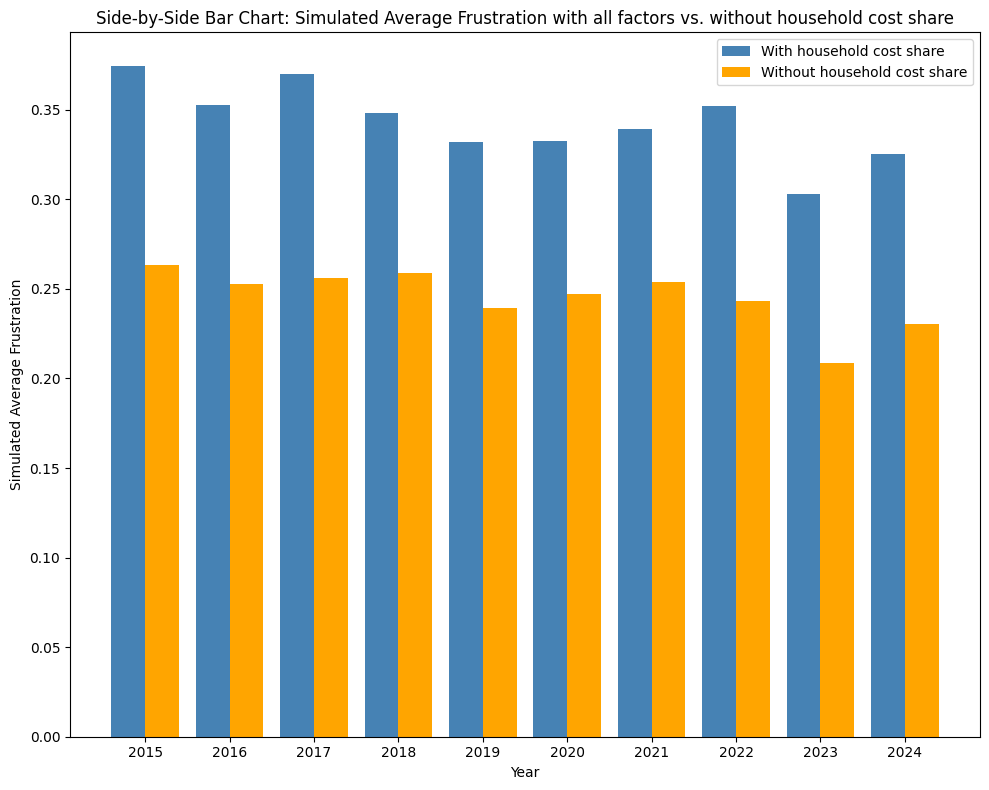

In [23]:
x = np.arange(len(relevant_years))  # numeric positions for shared years
bar_width = 0.4

# Plot bars
plt.figure(figsize=(10, 8))
plt.bar(x - bar_width/2, list(mean_frustrations_over_years_all_factors.values()), width=bar_width, label='With household cost share', color='steelblue')
plt.bar(x + bar_width/2, list(mean_frustrations_over_years_exclude_household_share.values()), width=bar_width, label='Without household cost share', color='orange')

# Axis labels and ticks
plt.xticks(x, relevant_years)
plt.xlabel("Year")
plt.ylabel("Simulated Average Frustration")
plt.title("Side-by-Side Bar Chart: Simulated Average Frustration with all factors vs. without household cost share")
plt.legend()
plt.tight_layout()
plt.show()

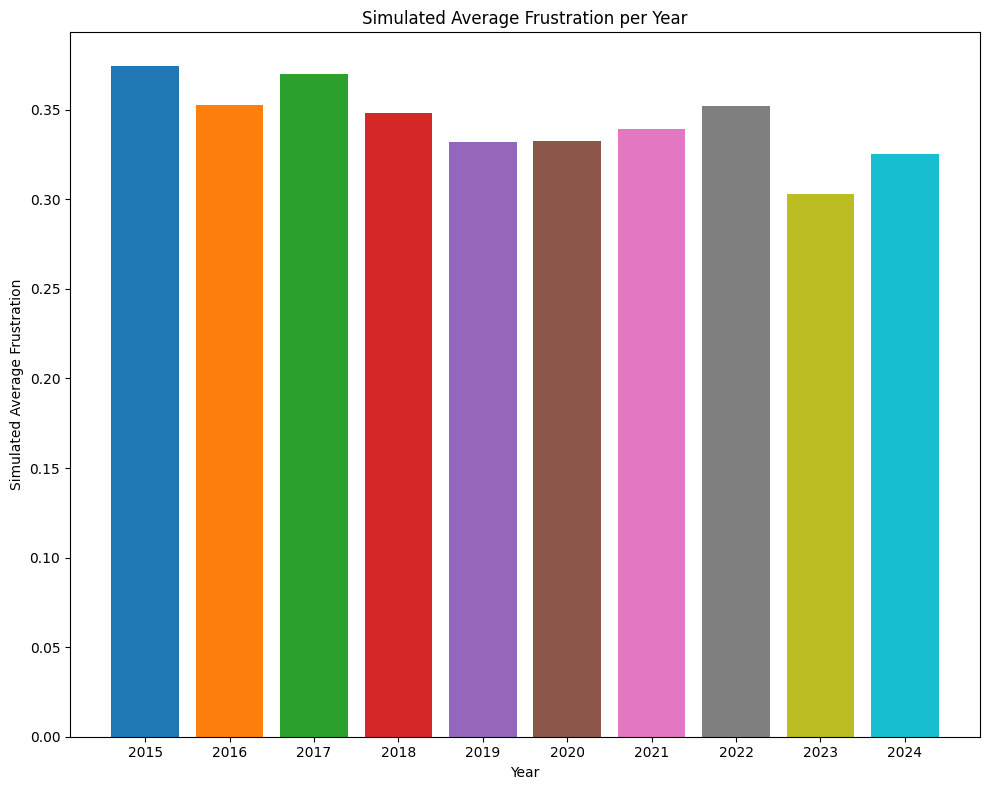

In [24]:
years = list(mean_frustrations_over_years_all_factors.keys())
frustration_means = list(mean_frustrations_over_years_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Frustration")
plt.title("Simulated Average Frustration per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_frustrations_over_years.pdf"), format="pdf")
plt.show()

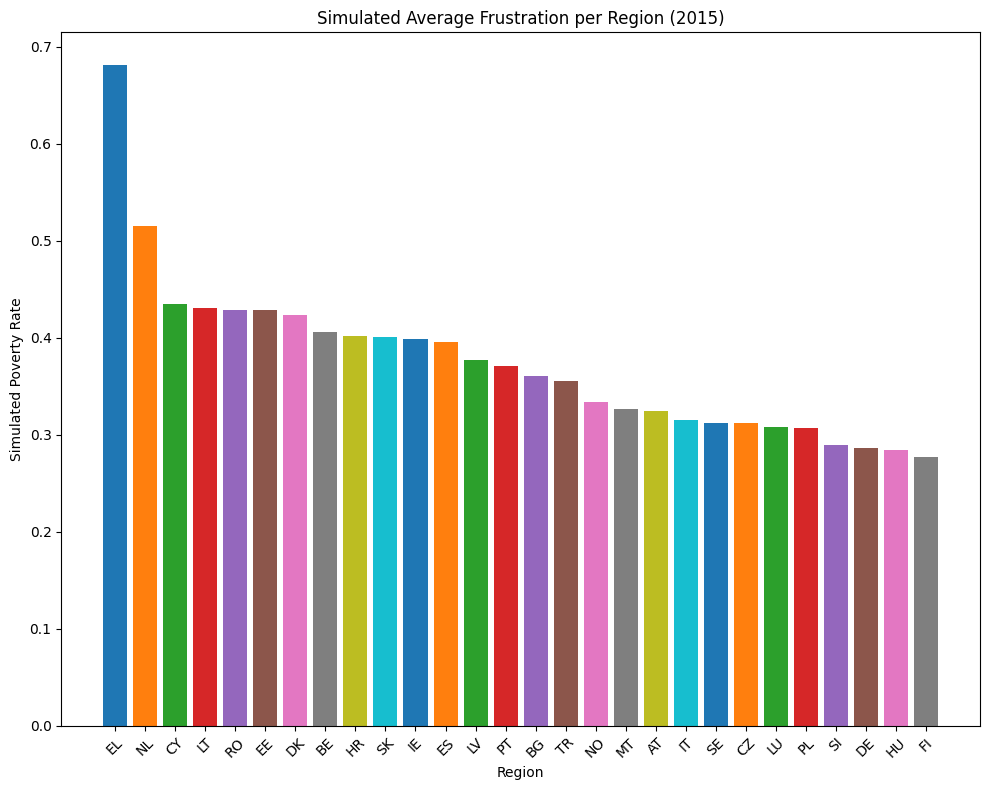

In [25]:
year = '2015'
frustration_series = mean_frustrations_dict_over_years_all_factors[year]
frustration_data = frustration_series.iloc[0]

sorted_frustration = dict(sorted(frustration_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_frustration.keys())
frustration_mean = list(sorted_frustration.values())

plt.figure(figsize=(10, 8))
plt.bar(region, frustration_mean, color=sns.color_palette("tab10", len(region)))
plt.xlabel("Region")
plt.ylabel("Simulated Poverty Rate")
plt.title(f"Simulated Average Frustration per Region ({year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_frustration_by_region_{year}.pdf"), format="pdf")
plt.show()

## 8. Plot mean opinions over years

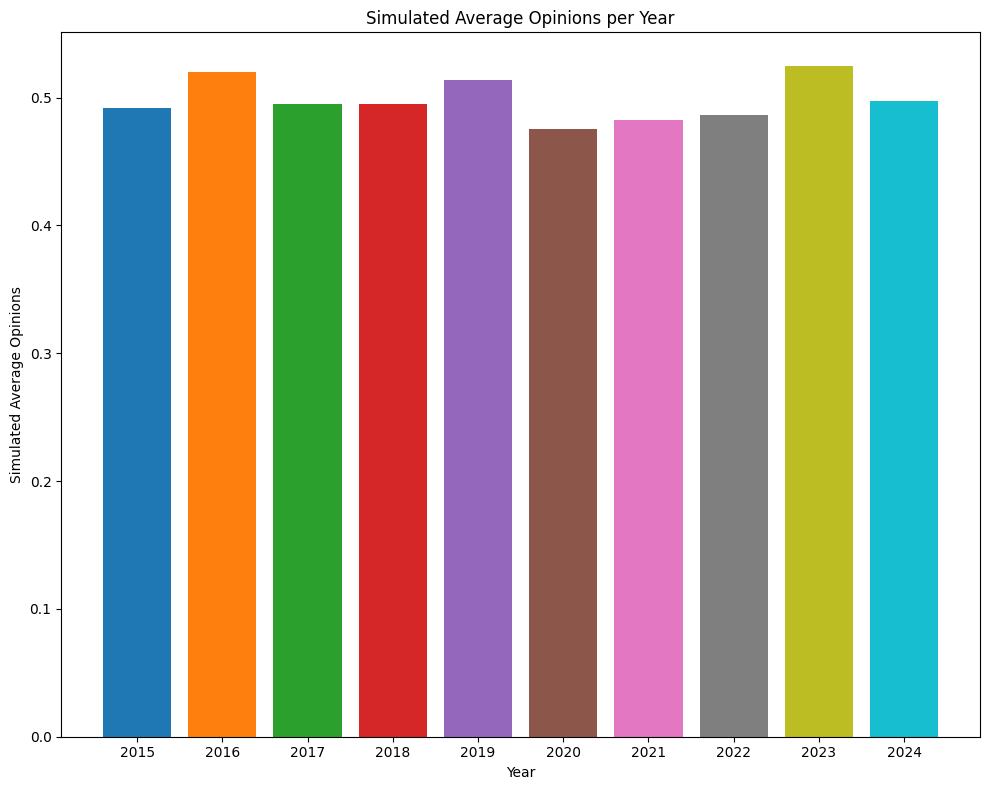

In [26]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(mean_opinions_over_years_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Opinions")
plt.title("Simulated Average Opinions per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_opinions_over_years.pdf"), format="pdf")
plt.show()

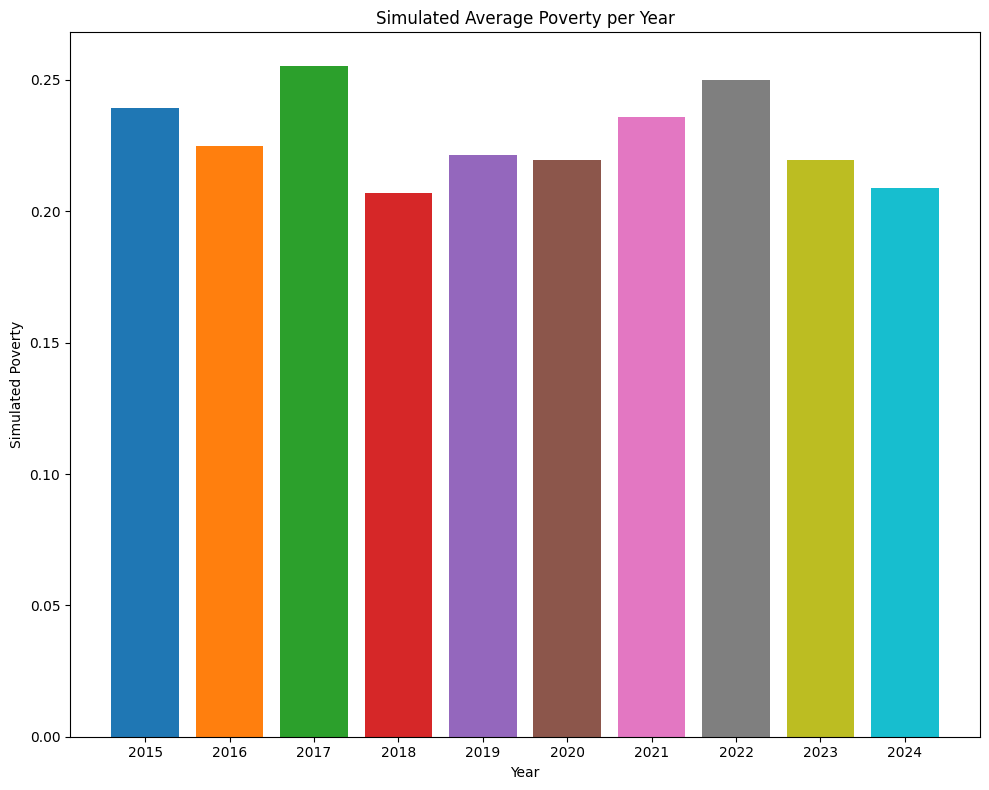

In [27]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(poverty_mean_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Poverty")
plt.title("Simulated Average Poverty per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_poverty_over_years.pdf"), format="pdf")
plt.show()

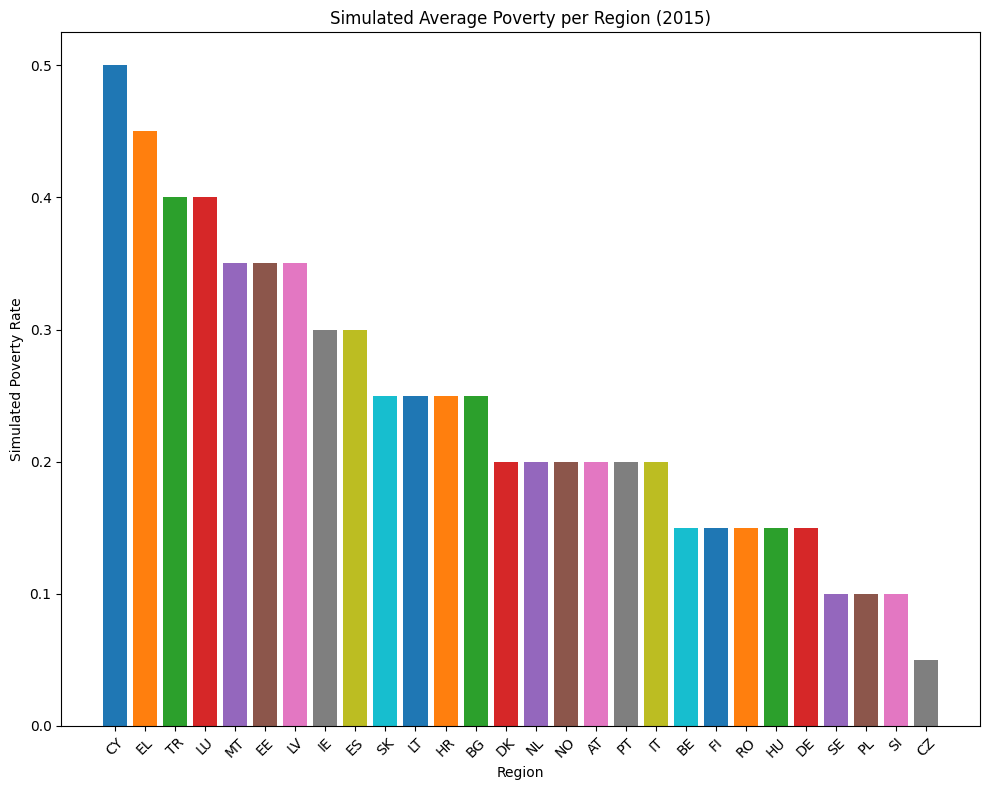

In [28]:
year = '2015'
poverty_series = poverty_dict_all_factors[year]
poverty_data = poverty_series.iloc[0]

sorted_poverty = dict(sorted(poverty_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_poverty.keys())
poverty_mean = list(sorted_poverty.values())

plt.figure(figsize=(10, 8))
plt.bar(region, poverty_mean, color=sns.color_palette("tab10", len(region)))
plt.xlabel("Region")
plt.ylabel("Simulated Poverty Rate")
plt.title(f"Simulated Average Poverty per Region ({year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_poverty_by_region_{year}.pdf"), format="pdf")
plt.show()

/tmp/ipykernel_36700/882919478.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_poverty_2015, x=year, y="geo", palette="viridis")


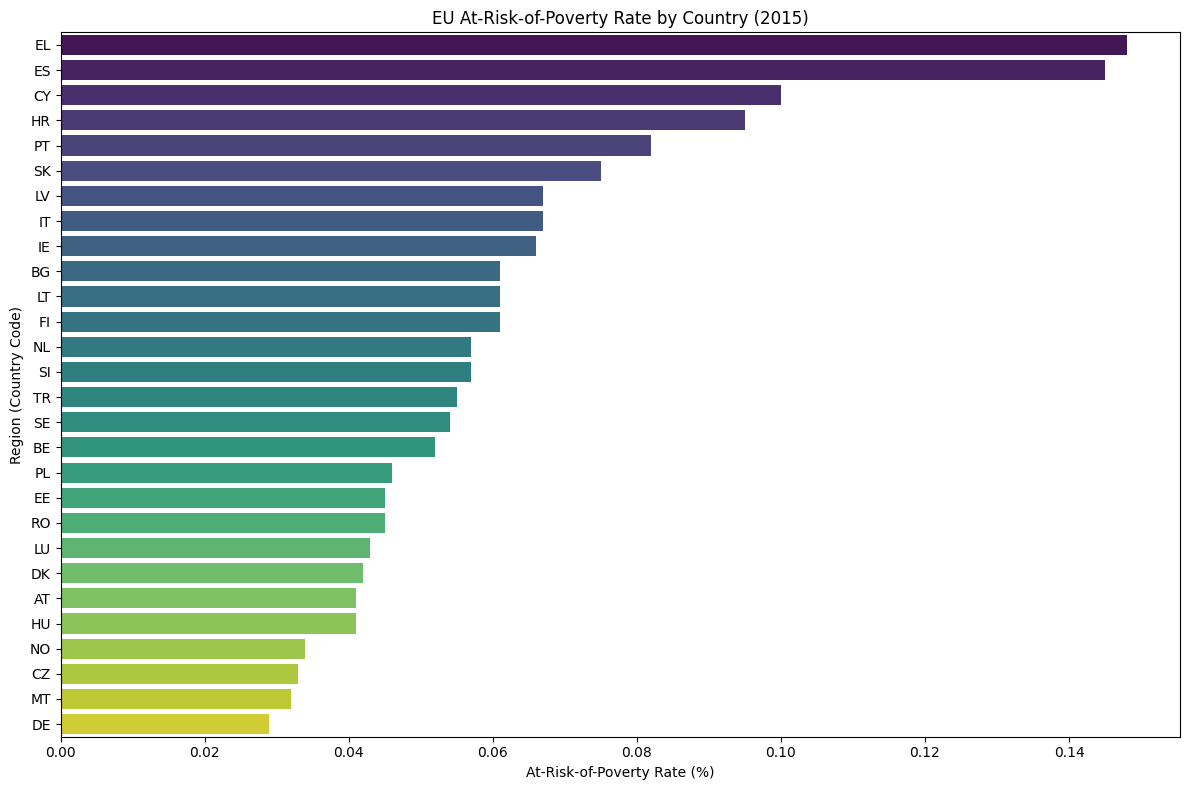

In [29]:
df_poverty_2015 = df_processed_unemployment_rate[["geo", year]].dropna().sort_values(year, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_poverty_2015, x=year, y="geo", palette="viridis")
plt.xlabel("At-Risk-of-Poverty Rate (%)")
plt.ylabel("Region (Country Code)")
plt.title(f"EU At-Risk-of-Poverty Rate by Country ({year})")
plt.tight_layout()
plt.show()